# Vehicle Insurance Fraud Detection #

## Data Exploration ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn import pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import random
import xgboost as xgb
import seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_csv('fraud_oracle.csv')
df.head()

Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  AgeOfVehicle  \
0          Jan                   1  Female        Single  ...       3 years   
1          Jan                   4    Male        Single  ...       6 years   
2          Nov                   2    Male       Married  ...       7 years   
3          Jul                   1    Male       Married  ...   more than 7   
4          Feb                   2  Female        Single  ...       5 years   

  AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType  \
0          26 to 30                No             No  External   
1          31 to 35               Yes             No  External   
2          41 to 50                No             No  External   
3          51 to 65               Yes             No  External   
4          31 to 35                No             No  External   

   NumberOfSuppliments  AddressChange_Claim  NumberOfCars  Year  BasePolicy  
0                 none               1 year        3 to 4  1994   Liability  
1                 none            no change     1 vehicle  1994   Collision  
2                 none            no change     1 vehicle  1994   Collision  
3          more than 5            no change     1 vehicle  1994   Liability  
4                 none            no change     1 vehicle  1994   Collision  

[5 rows x 33 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [4]:
df['FraudFound_P'].value_counts(normalize=True)

0    0.940143
1    0.059857
Name: FraudFound_P, dtype: float64

In [5]:
cols=df.columns

for col in cols:
    print(df[col].value_counts())

Jan    1411
May    1367
Mar    1360
Jun    1321
Oct    1305
Dec    1285
Apr    1280
Feb    1266
Jul    1257
Sep    1240
Nov    1201
Aug    1127
Name: Month, dtype: int64
3    3640
2    3558
4    3398
1    3187
5    1637
Name: WeekOfMonth, dtype: int64
Monday       2616
Friday       2445
Tuesday      2300
Thursday     2173
Wednesday    2159
Saturday     1982
Sunday       1745
Name: DayOfWeek, dtype: int64
Pontiac      3837
Toyota       3121
Honda        2801
Mazda        2354
Chevrolet    1681
Accura        472
Ford          450
VW            283
Dodge         109
Saab          108
Mercury        83
Saturn         58
Nisson         30
BMW            15
Jaguar          6
Porche          5
Mecedes         4
Ferrari         2
Lexus           1
Name: Make, dtype: int64
Urban    13822
Rural     1598
Name: AccidentArea, dtype: int64
Monday       3757
Tuesday      3375
Wednesday    2951
Thursday     2660
Friday       2497
Saturday      127
Sunday         52
0               1
Name: DayOfWeekCla

In [6]:
df[df['DayOfWeekClaimed']=='0']

Month  WeekOfMonth DayOfWeek   Make AccidentArea DayOfWeekClaimed  \
1516   Jul            2    Monday  Honda        Rural                0   

     MonthClaimed  WeekOfMonthClaimed   Sex MaritalStatus  ...  AgeOfVehicle  \
1516            0                   1  Male        Single  ...           new   

     AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType  \
1516          16 to 17                No             No  External   

      NumberOfSuppliments  AddressChange_Claim  NumberOfCars  Year  BasePolicy  
1516                 none            no change     1 vehicle  1994  All Perils  

[1 rows x 33 columns]

There is only one row with missing data. Drop this observation.

In [7]:
df=df[df['DayOfWeekClaimed']!='0']

Year, Policy number and Rep Number can be dropped from features since they are not predictors of Fraud. If a certain policy holder or rep is involved in vehicle fraud then it is possible that this could be used to identify fraud, but it will not help with general classification of claims.

In [8]:
df.drop(columns=['PolicyNumber','RepNumber','Year'],inplace=True)

In [9]:
#Look at rows where Age is 0
df[df['Age']==0]['AgeOfPolicyHolder'].value_counts()

16 to 17    319
Name: AgeOfPolicyHolder, dtype: int64

All rows where Age is 0 show the age of policy holder '16 to 17'. Lets look if age of policy holder tends to correspond to Age.

In [10]:
df.groupby('AgeOfPolicyHolder')['Age'].mean()

AgeOfPolicyHolder
16 to 17     0.000000
18 to 20    16.400000
21 to 25    18.814815
26 to 30    22.941272
31 to 35    30.548006
36 to 40    40.483304
41 to 50    50.423267
51 to 65    60.441092
over 65     72.783465
Name: Age, dtype: float64

The mean values don't perfectly correspond, which can be expected since the person involved in a claim is not always the policy holder. But, they do correspond to roughly the age range, so we will assume that the 16 to 17 category corresponds to an age of 16 so that we don't lose those rows of data.

In [11]:
df['Age']=df['Age'].apply(lambda x: 16 if x==0 else x)

In [12]:
df.groupby('AgeOfPolicyHolder')['Age'].mean()

AgeOfPolicyHolder
16 to 17    16.000000
18 to 20    16.400000
21 to 25    18.814815
26 to 30    22.941272
31 to 35    30.548006
36 to 40    40.483304
41 to 50    50.423267
51 to 65    60.441092
over 65     72.783465
Name: Age, dtype: float64

### Convert Feature Data Types ###

A number of the features are in object format when they could be numeric. This includes month, week, vehicle age, number of supplements. Some have difficult formats to deal with where one of the categories is "greater than" a certain value.  We'll create identifier features for these while setting the values in the numeric column to -1.

In [13]:
# Correct Month and MonthClaimed columns
month_map={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,
          'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}

df['Month']=df['Month'].map(month_map)
df['MonthClaimed']=df['MonthClaimed'].map(month_map)

In [14]:
#Correct DayOfWeek and DayOfWeekClaimed
day_map={'Sunday':1,'Monday':2,'Tuesday':3,'Wednesday':4,'Thursday':5,
        'Friday':6,'Saturday':7}

df['DayOfWeek']=df['DayOfWeek'].map(day_map)
df['DayOfWeekClaimed']=df['DayOfWeekClaimed'].map(day_map)

In [15]:
#replace vehicle price ranges with random prices in that range

def fix_vehicle_price(x):
    if x=='less than 20000':
        return random.randint(5000,19999)
    elif x=='more than 69000':
        return random.randint(70000,89000)
    else:
        lower=int(x[:5])
        upper=int(x[-5:])
        return random.randint(lower,upper)

df['VehiclePrice']=df['VehiclePrice'].apply(fix_vehicle_price)

In [16]:
#Examine Days_Policy_Accident and Days_Policy_Claim
print(df['Days_Policy_Accident'].value_counts())
print(df['Days_Policy_Claim'].value_counts())

more than 30    15246
8 to 15            55
none               55
15 to 30           49
1 to 7             14
Name: Days_Policy_Accident, dtype: int64
more than 30    15342
15 to 30           56
8 to 15            21
Name: Days_Policy_Claim, dtype: int64


Because only ~1% of all claims in the data set had accidents/claims less than 30 after buying policy, we will create new columns denoting 'accident less than 30 day policy' and 'claim less than 30 day policy' and delete the original columns

In [17]:
df['Less30DaysPolicyAccident']=df['Days_Policy_Accident'].apply(
    lambda x: 0 if x=='more than 30' else 1
)
df['Less30DaysPolicyClaim']=df['Days_Policy_Claim'].apply(
    lambda x: 0 if x=='more than 30' else 1
)
df.drop(columns=['Days_Policy_Accident','Days_Policy_Claim'],inplace=True)

In [18]:
#Examine AgeOfVehicle
df['AgeOfVehicle'].value_counts()

7 years        5807
more than 7    3981
6 years        3448
5 years        1357
new             372
4 years         229
3 years         152
2 years          73
Name: AgeOfVehicle, dtype: int64

Convert these values to numbers. New will be 1. More than 7, set to 10 and have identifying column.

In [19]:
vehicle_age_map={'new': 1,
                '2 years': 2,
                '3 years': 3,
                '4 years': 4,
                '5 years': 5,
                '6 years': 6,
                '7 years': 7,
                'more than 7': 10}  #set to -1
df['AgeOfVehicle']=df['AgeOfVehicle'].map(vehicle_age_map)
df['VehicleAgeOver7']=df['AgeOfVehicle'].apply(
    lambda x: 1 if x==10 else 0
)
df['VehicleAgeOver7'].value_counts()

0    11438
1     3981
Name: VehicleAgeOver7, dtype: int64

In [20]:
#Examine AgeOfPolicyHolder
df['AgeOfPolicyHolder'].value_counts()

31 to 35    5593
36 to 40    4043
41 to 50    2828
51 to 65    1392
26 to 30     613
over 65      508
16 to 17     319
21 to 25     108
18 to 20      15
Name: AgeOfPolicyHolder, dtype: int64

In [21]:
random.seed(42)

In [22]:
#function that returns random age from age range

def fix_age(x):
    if x=='over 65':
        return random.randint(66,78)  #78 is avg life expectancy in us
    else:
        lower=int(x[:2])
        upper=int(x[-2:])
        return random.randint(lower,upper)

In [23]:
df['AgeOfPolicyHolder']=df['AgeOfPolicyHolder'].apply(fix_age)

In [24]:
#Examine NumberOfCars
df['NumberOfCars'].value_counts()

1 vehicle      14315
2 vehicles       709
3 to 4           372
5 to 8            21
more than 8        2
Name: NumberOfCars, dtype: int64

In [25]:
#generate random numbers for categories with range. 
#Only two rows more than 8-enter 9 for these

def fix_num_cars(x):
    if x=='more than 8':
        return 9
    elif x=='3 to 4':
        return random.randint(3,4)
    elif x=='5 to 8':
        return random.randint(5,8)
    else:
        return int(x[0])
    
df['NumberOfCars']=df['NumberOfCars'].apply(fix_num_cars)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15419 entries, 0 to 15419
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Month                     15419 non-null  int64 
 1   WeekOfMonth               15419 non-null  int64 
 2   DayOfWeek                 15419 non-null  int64 
 3   Make                      15419 non-null  object
 4   AccidentArea              15419 non-null  object
 5   DayOfWeekClaimed          15419 non-null  int64 
 6   MonthClaimed              15419 non-null  int64 
 7   WeekOfMonthClaimed        15419 non-null  int64 
 8   Sex                       15419 non-null  object
 9   MaritalStatus             15419 non-null  object
 10  Age                       15419 non-null  int64 
 11  Fault                     15419 non-null  object
 12  PolicyType                15419 non-null  object
 13  VehicleCategory           15419 non-null  object
 14  VehiclePrice          

### Data Preprocessing ###

In [27]:
# Separate target variable and features
y=df['FraudFound_P']
X=df.drop(columns='FraudFound_P')

In [28]:
#One Hot Encode Categorical Variables
X_processed=pd.get_dummies(X)
X_processed.head()

Month  WeekOfMonth  DayOfWeek  DayOfWeekClaimed  MonthClaimed  \
0     12            5          4                 3             1   
1      1            3          4                 2             1   
2     10            5          6                 5            11   
3      6            2          7                 6             7   
4      1            5          2                 3             2   

   WeekOfMonthClaimed  Age  VehiclePrice  Deductible  DriverRating  ...  \
0                   1   21         70600         300             1  ...   
1                   4   34         83510         400             4  ...   
2                   2   47         76441         400             3  ...   
3                   1   65         21903         400             2  ...   
4                   2   27         78552         400             1  ...   

   NumberOfSuppliments_more than 5  NumberOfSuppliments_none  \
0                                0                         1   
1                                0                         1   
2                                0                         1   
3                                1                         0   
4                                0                         1   

   AddressChange_Claim_1 year  AddressChange_Claim_2 to 3 years  \
0                           1                                 0   
1                           0                                 0   
2                           0                                 0   
3                           0                                 0   
4                           0                                 0   

   AddressChange_Claim_4 to 8 years  AddressChange_Claim_no change  \
0                                 0                              0   
1                                 0                              1   
2                                 0                              1   
3                                 0                              1   
4                                 0                              1   

   AddressChange_Claim_under 6 months  BasePolicy_All Perils  \
0                                   0                      0   
1                                   0                      0   
2                                   0                      0   
3                                   0                      0   
4                                   0                      0   

   BasePolicy_Collision  BasePolicy_Liability  
0                     0                     1  
1                     1                     0  
2                     1                     0  
3                     0                     1  
4                     1                     0  

[5 rows x 79 columns]

In [29]:
#train test split 
#stratify y to ensure fraud instances are in both test and train sets

X_train,X_test,y_train,y_test=train_test_split(X_processed,y,random_state=42,
                                              stratify=y)

In [30]:
#Scale test data
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)

In [31]:
X_test_scaled=scaler.transform(X_test)

Before building any models, it is important to note what should be considered good performance based on the class imbalance in the data.  Since only ~6% of the data are classified as fraud, if the model just picked 'not fraud' every time, it would have an accuracy of 96%.  This means any model would need to beat this to be better than just guessing that its not fraud.  

It will also be important to pay attention to recall and precision to determine what types of errors the model tends to have.

# Logistic Regression #

### Baseline Model ###

In [250]:
baseline=LogisticRegression(random_state=123)

base_pipe=Pipeline(steps=[('scaler',StandardScaler()),('clf',baseline)])

results=cross_validate(base_pipe,X_train,y_train,
                         scoring=['neg_log_loss','accuracy','precision',
                                 'recall'])

print('log loss: {}'.format(results['test_neg_log_loss']))
print('accuracy: {}'.format(results['test_accuracy']))
print('precision: {}'.format(results['test_precision']))
print('recall: {}'.format(results['test_recall']))



log loss: [-0.19671391 -0.19436604 -0.19095805 -0.18781181 -0.18940366]
accuracy: [0.94033722 0.93817553 0.93904021 0.93687851 0.93901384]
precision: [0.5        0.27272727 0.375      0.23076923 0.2       ]
recall: [0.00724638 0.02173913 0.02158273 0.02158273 0.00724638]


Based on what we know about the data, this is not very good performance. Just guessing not fraud each time has about the same accuracy. The model finds about 44% of true positives and only 2% of predicted fraud is actually fraud. This means there is a lot of false positives that a company would waste time/money investigating.

In [251]:
#Run GridSearchCV to find best parameters for model
C_param=[.001,.01,.1,1,10,100]
solver=['liblinear','lbfgs','newton-cg']
penalty=['l1','l2','elasticnet']
class_weight=['balanced',None]

param_grid= {
    'clf__solver': solver,
    'clf__penalty': penalty,
    'clf__C': C_param,
    'clf__class_weight': class_weight,
    'clf__l1_ratio': [None, 0.5]
}

gs_log=GridSearchCV(base_pipe,param_grid,cv=3,scoring='neg_log_loss',
                   verbose=0)
gs_log.fit(X_train,y_train)


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalti

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    s

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalti

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalti

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalti

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalti

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalti

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalti

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalti

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalti

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalti

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalti

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalti

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(random_state=123))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__class_weight': ['balanced', None],
                         'clf__l1_ratio': [None, 0.5],
                         'clf__penalty': ['l1', 'l2', 'elasticnet'],
                         'clf__solver': ['liblinear', 'lbfgs', 'newton-cg']},
             scoring='neg_log_loss')

In [252]:
print('best score: {}'.format(gs_log.best_score_))
print('best params: {}'.format(gs_log.best_params_))

best score: -0.18988756004455135
best params: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__l1_ratio': None, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}


The best model found by GridSearchCV has C parameter of .1, l1 regularization, and liblinear solver with no class weighting.

In [253]:
gs_y_hat_train=gs_log.predict(X_train)
gs_y_prob=gs_log.predict_proba(X_train)

print('log_loss: {}'.format(log_loss(y_train,gs_y_prob)))
print('score: {}'.format(accuracy_score(y_train,gs_y_hat_train)))
print('recall: {}'.format(recall_score(y_train,gs_y_hat_train)))
print('precision: {}'.format(precision_score(y_train,gs_y_hat_train)))

log_loss: 0.1846412080184927
score: 0.9398132134209616
recall: 0.011560693641618497
precision: 0.4


No improvement from best model found by GridSearchCV. Next step is to try some methods to address the significant class imbalance.

### Log Regression with RandomOverSample ###

In [254]:
log_ros_pipe=pipeline.Pipeline(steps=[
    ('over',RandomOverSampler(random_state=42)),
    ('scaler',StandardScaler()),
    ('clf',LogisticRegression(random_state=123))
])


cv_results=cross_validate(log_ros_pipe,X_train,y_train,
                         scoring=['neg_log_loss','accuracy','precision',
                                 'recall'])

print('log loss: {}'.format(cv_results['test_neg_log_loss']))
print('accuracy: {}'.format(cv_results['test_accuracy']))
print('precision: {}'.format(cv_results['test_precision']))
print('recall: {}'.format(cv_results['test_recall']))


log loss: [-0.53580276 -0.5317651  -0.52340103 -0.5360827  -0.51856715]
accuracy: [0.63942931 0.63467358 0.64504972 0.62905318 0.63408304]
precision: [0.12660944 0.12828601 0.13412017 0.13353721 0.12658228]
recall: [0.85507246 0.88405797 0.89928058 0.94244604 0.86956522]


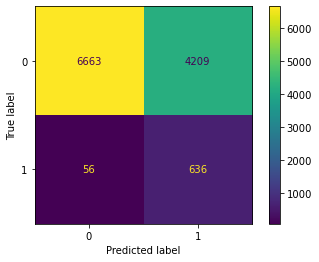

In [255]:
log_ros_pipe.fit(X_train,y_train)
plot_confusion_matrix(log_ros_pipe,X_train,y_train)

With random oversampling, the model does a better job of finding the fraud...over 80% of fraud is found. But there are a lot of false positives which equates to time spent investigating claims.

In [256]:
#Run GridSearchCV to find best parameters for model minimizing log loss
C_param=[.001,.01,.1,1,10,100]
solver=['liblinear','lbfgs','newton-cg']
penalty=['l1','l2','elasticnet']
class_weight=['balanced',None]

param_grid= {
    'clf__solver': solver,
    'clf__penalty': penalty,
    'clf__C': C_param,
    'clf__class_weight': class_weight,
    'clf__l1_ratio': [None, 0.5]
}

gs_log_ros=GridSearchCV(log_ros_pipe,param_grid,cv=3,scoring='neg_log_loss',
                   verbose=0)
gs_log_ros.fit(X_train,y_train)


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('over',
                                        RandomOverSampler(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(random_state=123))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__class_weight': ['balanced', None],
                         'clf__l1_ratio': [None, 0.5],
                         'clf__penalty': ['l1', 'l2', 'elasticnet'],
                         'clf__solver': ['liblinear', 'lbfgs', 'newton-cg']},
             scoring='neg_log_loss')

In [257]:
# best_log_ros_pipe=pipeline.Pipeline(steps=[
#     ('over',RandomOverSampler(random_state=42)),
#     ('scaler',StandardScaler()),
#     ('clf',LogisticRegression(C=.001,
#                               class_weight='balanced',
#                               penalty='l2',
#                               solver='newton-cg',
#                               random_state=123))
# ])


# cv_results=cross_validate(best_log_ros_pipe,X_train,y_train,
#                          scoring=['neg_log_loss','accuracy','precision',
#                                  'recall'])

# print('log loss: {}'.format(cv_results['test_neg_log_loss']))
# print('accuracy: {}'.format(cv_results['test_accuracy']))
# print('precision: {}'.format(cv_results['test_precision']))
# print('recall: {}'.format(cv_results['test_recall']))


best score: -0.5232570868320706
best params: {'clf__C': 0.001, 'clf__class_weight': 'balanced', 'clf__l1_ratio': None, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
AUC: 0.7924968703114398
log_loss: 0.5374041498598787
score: 0.6220492866407263
recall: 0.8961038961038961
precision: 0.12621951219512195


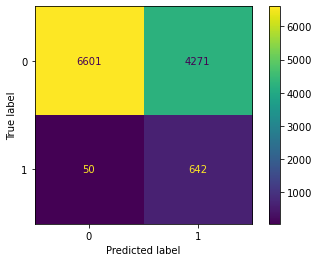

In [258]:
print('best score: {}'.format(gs_log_ros.best_score_))
print('best params: {}'.format(gs_log_ros.best_params_))
y_hat_test=gs_log_ros.predict(X_test)
y_hat_prob=gs_log_ros.predict_proba(X_test)
y_score=gs_log_ros.decision_function(X_test)
fpr,tpr,thresholds=roc_curve(y_test,y_score)
print('AUC: {}'.format(auc(fpr,tpr)))
print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_log_ros,X_train,y_train)

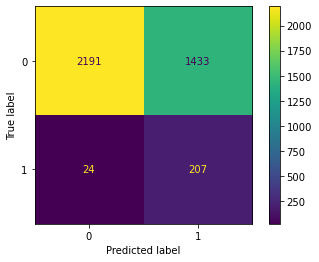

In [259]:
plot_confusion_matrix(gs_log_ros,X_test,y_test)

In [260]:
#Run GridSearchCV to find best parameters for recall
C_param=[.001,.01,.1,1,10,100]
solver=['liblinear','lbfgs','newton-cg']
penalty=['l1','l2','elasticnet']
class_weight=['balanced',None]

param_grid= {
    'clf__solver': solver,
    'clf__penalty': penalty,
    'clf__C': C_param,
    'clf__class_weight': class_weight,
    'clf__l1_ratio': [None, 0.5]
}

gs_log_ros_recall=GridSearchCV(log_ros_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_log_ros_recall.fit(X_train,y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('over',
                                        RandomOverSampler(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(random_state=123))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__class_weight': ['balanced', None],
                         'clf__l1_ratio': [None, 0.5],
                         'clf__penalty': ['l1', 'l2', 'elasticnet'],
                         'clf__solver': ['liblinear', 'lbfgs', 'newton-cg']},
             scoring='recall')

best score: 0.9292113683418032
best params: {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__l1_ratio': None, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
AUC: 0.7978794568198542
log_loss: 0.5509628020290932
score: 0.6103761348897536
recall: 0.9134199134199135
precision: 0.12463083284111046


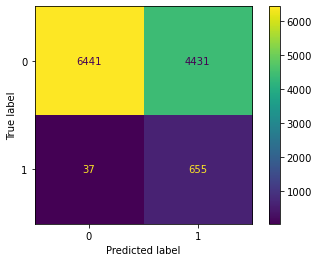

In [261]:
print('best score: {}'.format(gs_log_ros_recall.best_score_))
print('best params: {}'.format(gs_log_ros_recall.best_params_))
y_hat_test=gs_log_ros_recall.predict(X_test)
y_hat_prob=gs_log_ros_recall.predict_proba(X_test)
y_score=gs_log_ros_recall.decision_function(X_test)
fpr,tpr,thresholds=roc_curve(y_test,y_score)
print('AUC: {}'.format(auc(fpr,tpr)))
print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_log_ros_recall,X_train,y_train)

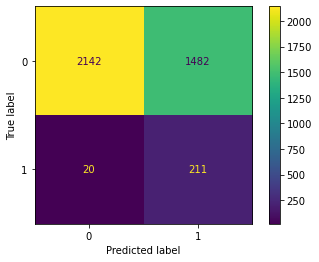

In [262]:
plot_confusion_matrix(gs_log_ros_recall,X_test,y_test)

In [263]:
#Run GridSearchCV to find best parameters for precision
C_param=[.001,.01,.1,1,10,100]
solver=['liblinear','lbfgs','newton-cg']
penalty=['l1','l2','elasticnet']
class_weight=['balanced',None]

param_grid= {
    'clf__solver': solver,
    'clf__penalty': penalty,
    'clf__C': C_param,
    'clf__class_weight': class_weight,
    'clf__l1_ratio': [None, 0.5]
}

gs_log_ros_prec=GridSearchCV(log_ros_pipe,param_grid,cv=3,scoring='precision',
                   verbose=0)
gs_log_ros_prec.fit(X_train,y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('over',
                                        RandomOverSampler(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(random_state=123))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__class_weight': ['balanced', None],
                         'clf__l1_ratio': [None, 0.5],
                         'clf__penalty': ['l1', 'l2', 'elasticnet'],
                         'clf__solver': ['liblinear', 'lbfgs', 'newton-cg']},
             scoring='precision')

best score: 0.1302137813314548
best params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__l1_ratio': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
AUC: 0.7882885142818917
log_loss: 0.5550400578054333
score: 0.624124513618677
recall: 0.8831168831168831
precision: 0.12546125461254612


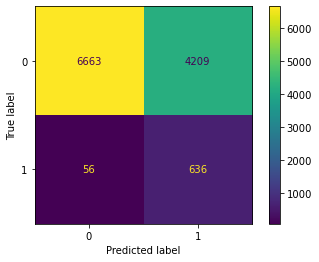

In [264]:
print('best score: {}'.format(gs_log_ros_prec.best_score_))
print('best params: {}'.format(gs_log_ros_prec.best_params_))
y_hat_test=gs_log_ros_prec.predict(X_test)
y_hat_prob=gs_log_ros_prec.predict_proba(X_test)
y_score=gs_log_ros_prec.decision_function(X_test)
fpr,tpr,thresholds=roc_curve(y_test,y_score)
print('AUC: {}'.format(auc(fpr,tpr)))
print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_log_ros_prec,X_train,y_train)

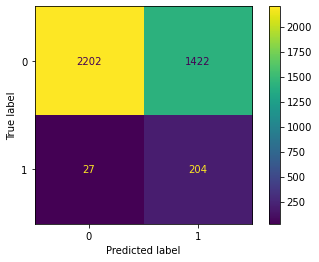

In [265]:
plot_confusion_matrix(gs_log_ros_prec,X_test,y_test)

The random over sampling logistic regression model with the lowest log loss has slightly higher recall (ability to find fraud), but the overall accuracy and precision are similar to baseline random over sampling model. 

When conducting gridsearch to maximize recall, the recall score increases to 93% and the precision decreases slightly.  Between maximizing log loss, recall, or precision for random oversampling we would want to maximize recall since it detects more fraud without a large increase in false positives comparatively.

### Log Regression with SMOTE ###

In [266]:
# try smote not in pipeline
sm=SMOTE(random_state=42)
X_res,y_res=sm.fit_resample(X_train,y_train)
print(X_train.shape)
print(X_res.shape)
print(y_res.shape)
ss=StandardScaler()
X_res_scaled=ss.fit_transform(X_res)
log_smote=LogisticRegression(random_state=123,max_iter=500)
X_t_sc=ss.transform(X_train)

log_smote.fit(X_res_scaled,y_res)
y_hat_smote=log_smote.predict(X_t_sc)
y_sm_prob=log_smote.predict_proba(X_t_sc)
y_score=log_smote.decision_function(X_t_sc)
fpr,tpr,thresholds=roc_curve(y_train,y_score)
print('AUC: {}'.format(auc(fpr,tpr)))
print('log_loss: {}'.format(log_loss(y_train,y_sm_prob)))
print('score: {}'.format(accuracy_score(y_train,y_hat_smote)))
print('recall: {}'.format(recall_score(y_train,y_hat_smote)))
print('precision: {}'.format(precision_score(y_train,y_hat_smote)))

(11564, 79)
(21744, 79)
(21744,)
AUC: 0.8212844311313572
log_loss: 0.18514716095517947
score: 0.9394673123486683
recall: 0.01878612716763006
precision: 0.38235294117647056


In [267]:
X_train_scaled

array([[ 7.45171513e-01, -6.11653773e-01, -5.17496458e-01, ...,
        -6.38757927e-01, -7.98724195e-01,  1.45527369e+00],
       [ 1.69157918e-01,  1.68962520e-01,  1.55213143e+00, ...,
        -6.38757927e-01,  1.25199663e+00, -6.87155967e-01],
       [-1.18848879e-01,  9.49578813e-01,  1.03472446e+00, ...,
        -6.38757927e-01, -7.98724195e-01,  1.45527369e+00],
       ...,
       [ 4.57164715e-01, -6.11653773e-01, -8.94858133e-05, ...,
        -6.38757927e-01, -7.98724195e-01,  1.45527369e+00],
       [-1.27087607e+00,  9.49578813e-01, -8.94858133e-05, ...,
        -6.38757927e-01,  1.25199663e+00, -6.87155967e-01],
       [-1.55888286e+00, -1.39227007e+00, -1.55231040e+00, ...,
         1.56553830e+00, -7.98724195e-01, -6.87155967e-01]])

In [268]:
X_t_sc

array([[ 0.96725222, -0.47922253, -0.45719934, ..., -0.62799877,
        -0.68772897,  2.19264505],
       [ 0.33097177,  0.36863871,  1.75567598, ..., -0.62799877,
         1.45406117, -0.45607017],
       [ 0.01283154,  1.21649995,  1.20245715, ..., -0.62799877,
        -0.68772897,  2.19264505],
       ...,
       [ 0.649112  , -0.47922253,  0.09601949, ..., -0.62799877,
        -0.68772897,  2.19264505],
       [-1.25972937,  1.21649995,  0.09601949, ..., -0.62799877,
         1.45406117, -0.45607017],
       [-1.5778696 , -1.32708376, -1.563637  , ...,  1.59235981,
        -0.68772897, -0.45607017]])

In [269]:
X_test_scaled=ss.transform(X_test)
y_hat_smote=log_smote.predict(X_test_scaled)
y_sm_prob=log_smote.predict_proba(X_test_scaled)
y_score=log_smote.decision_function(X_test_scaled)
fpr,tpr,thresholds=roc_curve(y_test,y_score)
print('AUC: {}'.format(auc(fpr,tpr)))
print('log_loss: {}'.format(log_loss(y_test,y_sm_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_smote)))
print('recall: {}'.format(recall_score(y_test,y_hat_smote)))
print('precision: {}'.format(precision_score(y_test,y_hat_smote)))

AUC: 0.7836692373116214
log_loss: 0.19924291158387597
score: 0.9377431906614786
recall: 0.004329004329004329
precision: 0.09090909090909091


In [270]:
log_smote_pipe=pipeline.Pipeline(steps=[
    ('smote',SMOTE(random_state=42)),
    ('scaler',StandardScaler()),
    ('clf',LogisticRegression(random_state=123,max_iter=500))
])

log_smote_pipe.fit(X_train,y_train)
y_hat=log_smote_pipe.predict(X_train)
print(y_hat.shape)
print(y_train.shape)
print(recall_score(y_train,y_hat))
cv_results=cross_validate(log_smote_pipe,X_train,y_train,
                         scoring=['neg_log_loss','accuracy','precision',
                                 'recall'],return_train_score=True)

print('log loss: {}'.format(cv_results['test_neg_log_loss']))
print('accuracy: {}'.format(cv_results['test_accuracy']))
print('precision: {}'.format(cv_results['test_precision']))
print('recall: {}'.format(cv_results['test_recall']))
print('')
print('Training Scores:')
print('log loss: {}'.format(cv_results['train_neg_log_loss']))
print('accuracy: {}'.format(cv_results['train_accuracy']))
print('precision: {}'.format(cv_results['train_precision']))
print('recall: {}'.format(cv_results['train_recall']))

(11564,)
(11564,)
0.01878612716763006
log loss: [-0.19921852 -0.19424655 -0.19308965 -0.1885852  -0.19102193]
accuracy: [0.94076956 0.93860787 0.93860787 0.93774319 0.93901384]
precision: [0.6        0.3        0.36363636 0.27272727 0.2       ]
recall: [0.02173913 0.02173913 0.02877698 0.02158273 0.00724638]

Training Scores:
log loss: [-0.18336818 -0.18343648 -0.18431196 -0.18468512 -0.1852892 ]
accuracy: [0.94033078 0.93924981 0.93914171 0.93935791 0.93914829]
precision: [0.5625     0.34615385 0.36111111 0.375      0.35483871]
recall: [0.01624549 0.01624549 0.02350814 0.02169982 0.0198556 ]


In [271]:
#Run GridSearchCV to find best parameters for model with log loss
C_param=[.001,.01,.1,1,10,100]
solver=['liblinear','lbfgs','newton-cg']
penalty=['l1','l2','elasticnet']
class_weight=['balanced',None]

param_grid= {
    'clf__solver': solver,
    'clf__penalty': penalty,
    'clf__C': C_param,
    'clf__class_weight': class_weight,
    'clf__l1_ratio': [None, 0.5]
}

gs_log_smote=GridSearchCV(log_smote_pipe,param_grid,cv=3,scoring='neg_log_loss',
                   verbose=0)
gs_log_smote.fit(X_train,y_train)


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=500,
                                                           random_state=123))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__class_weight': ['balanced', None],
                         'clf__l1_ratio': [None, 0.5],
                         'clf__penalty': ['l1', 'l2', 'elasticnet'],
                         'clf__solver': ['liblinear', 'lbfgs', 'newton-cg']},
             scoring='neg_log_loss')

best score: -0.19328252674958257
best params: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__l1_ratio': None, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
AUC: 0.7911589881788558
log_loss: 0.19659955815507554
score: 0.9374837872892348
recall: 0.008658008658008658
precision: 0.14285714285714285


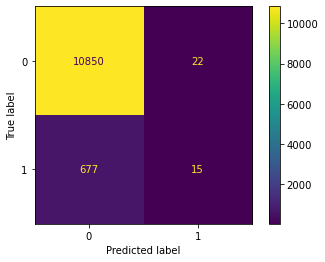

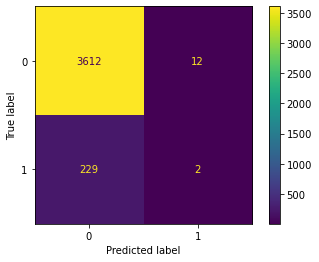

In [272]:
print('best score: {}'.format(gs_log_smote.best_score_))
print('best params: {}'.format(gs_log_smote.best_params_))
y_hat_test=gs_log_smote.predict(X_test)
y_hat_prob=gs_log_smote.predict_proba(X_test)
y_score=gs_log_smote.decision_function(X_test)
fpr,tpr,thresholds=roc_curve(y_test,y_score)
print('AUC: {}'.format(auc(fpr,tpr)))
print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_log_smote,X_train,y_train)
plot_confusion_matrix(gs_log_smote,X_test,y_test)

In [273]:
#Run GridSearchCV to find best parameters for model with recall
C_param=[.001,.01,.1,1,10,100]
solver=['liblinear','lbfgs','newton-cg']
penalty=['l1','l2','elasticnet']
class_weight=['balanced',None]

param_grid= {
    'clf__solver': solver,
    'clf__penalty': penalty,
    'clf__C': C_param,
    'clf__class_weight': class_weight,
    'clf__l1_ratio': [None, 0.5]
}

gs_log_smote_recall=GridSearchCV(log_smote_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_log_smote_recall.fit(X_train,y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=500,
                                                           random_state=123))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__class_weight': ['balanced', None],
                         'clf__l1_ratio': [None, 0.5],
                         'clf__penalty': ['l1', 'l2', 'elasticnet'],
                         'clf__solver': ['liblinear', 'lbfgs', 'newton-cg']},
             scoring='recall')

best score: 0.7557814166509819
best params: {'clf__C': 0.001, 'clf__class_weight': 'balanced', 'clf__l1_ratio': None, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
AUC: 0.7967948166623663
log_loss: 0.37850560064714944
score: 0.8378728923476005
recall: 0.3939393939393939
precision: 0.1579861111111111


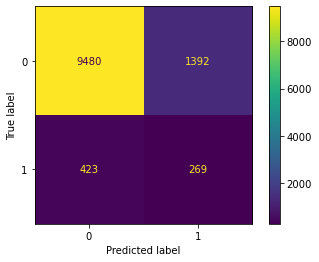

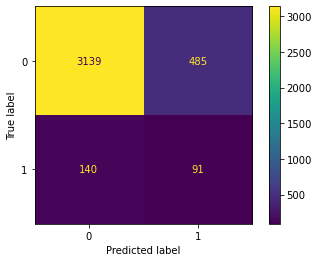

In [274]:
print('best score: {}'.format(gs_log_smote_recall.best_score_))
print('best params: {}'.format(gs_log_smote_recall.best_params_))
y_hat_test=gs_log_smote_recall.predict(X_test)
y_hat_prob=gs_log_smote_recall.predict_proba(X_test)
y_score=gs_log_smote_recall.decision_function(X_test)
fpr,tpr,thresholds=roc_curve(y_test,y_score)
print('AUC: {}'.format(auc(fpr,tpr)))
print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_log_smote_recall,X_train,y_train)
plot_confusion_matrix(gs_log_smote_recall,X_test,y_test)

While SMOTE has a higher accuracy than random over sampling, it does not do a very good job of identifying the fraud. It is more similar to just guessing no fraud every time.

By running GridSearchCV for recall we can increase the fraud detected with less false positives than with random over sampling, however we are still missing about 50% of the fraud.

### Log Regression with ADASYN ###

The adaptive synthetic sampling method is similar to SMOTE, it also generates samples by interpolation, but it focuses on generating samples next to original samples that are hard to classify (using KNN).

In [275]:
#baseline log model with ADASYN sampling
log_ada_pipe=pipeline.Pipeline(steps=[
    ('adasyn',ADASYN(random_state=42)),
    ('scaler',StandardScaler()),
    ('clf',LogisticRegression(random_state=123,max_iter=500))
])


cv_results=cross_validate(log_ada_pipe,X_train,y_train,
                         scoring=['neg_log_loss','roc_auc','accuracy',
                                  'precision','recall'])

print('log loss: {}'.format(cv_results['test_neg_log_loss']))
print('AUC: {}'.format(cv_results['test_roc_auc']))
print('accuracy: {}'.format(cv_results['test_accuracy']))
print('precision: {}'.format(cv_results['test_precision']))
print('recall: {}'.format(cv_results['test_recall']))


log loss: [-0.19962488 -0.19437774 -0.19326115 -0.1887656  -0.19083847]
AUC: [0.77954023 0.80228219 0.79791916 0.817566   0.80803101]
accuracy: [0.93990489 0.93860787 0.93860787 0.93774319 0.93901384]
precision: [0.4        0.3        0.36363636 0.30769231 0.2       ]
recall: [0.01449275 0.02173913 0.02877698 0.02877698 0.00724638]


In [276]:
#Run GridSearchCV to find best parameters for model
C_param=[.001,.01,.1,1,10,100]
solver=['liblinear','lbfgs','newton-cg']
penalty=['l1','l2','elasticnet']
class_weight=['balanced',None]

param_grid= {
    'clf__solver': solver,
    'clf__penalty': penalty,
    'clf__C': C_param,
    'clf__class_weight': class_weight,
    'clf__l1_ratio': [None, 0.5]
}

gs_log_ada=GridSearchCV(log_ada_pipe,param_grid,cv=3,scoring='neg_log_loss',
                   verbose=0)
gs_log_ada.fit(X_train,y_train)


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('adasyn', ADASYN(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=500,
                                                           random_state=123))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__class_weight': ['balanced', None],
                         'clf__l1_ratio': [None, 0.5],
                         'clf__penalty': ['l1', 'l2', 'elasticnet'],
                         'clf__solver': ['liblinear', 'lbfgs', 'newton-cg']},
             scoring='neg_log_loss')

best score: -0.19371719902129234
best params: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__l1_ratio': None, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
AUC: 0.7915042095505671
log_loss: 0.1962509240493427
score: 0.9374837872892348
recall: 0.008658008658008658
precision: 0.14285714285714285


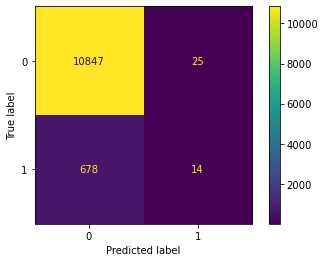

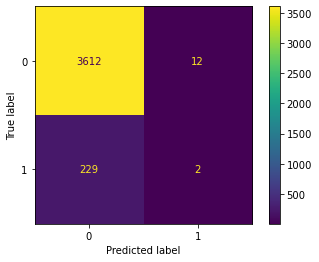

In [277]:
print('best score: {}'.format(gs_log_ada.best_score_))
print('best params: {}'.format(gs_log_ada.best_params_))
y_hat_test=gs_log_ada.predict(X_test)
y_hat_prob=gs_log_ada.predict_proba(X_test)
y_score=gs_log_ada.decision_function(X_test)
fpr,tpr,thresholds=roc_curve(y_test,y_score)
print('AUC: {}'.format(auc(fpr,tpr)))
print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_log_ada,X_train,y_train)
plot_confusion_matrix(gs_log_ada,X_test,y_test)

In [278]:
#Run GridSearchCV to find best parameters for model with recall
C_param=[.001,.01,.1,1,10,100]
solver=['liblinear','lbfgs','newton-cg']
penalty=['l1','l2','elasticnet']
class_weight=['balanced',None]

param_grid= {
    'clf__solver': solver,
    'clf__penalty': penalty,
    'clf__C': C_param,
    'clf__class_weight': class_weight,
    'clf__l1_ratio': [None, 0.5]
}

gs_log_ada_recall=GridSearchCV(log_ada_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_log_ada_recall.fit(X_train,y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('adasyn', ADASYN(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=500,
                                                           random_state=123))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__class_weight': ['balanced', None],
                         'clf__l1_ratio': [None, 0.5],
                         'clf__penalty': ['l1', 'l2', 'elasticnet'],
                         'clf__solver': ['liblinear', 'lbfgs', 'newton-cg']},
             scoring='recall')

best score: 0.7644456992283079
best params: {'clf__C': 0.001, 'clf__class_weight': None, 'clf__l1_ratio': None, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
AUC: 0.7963958410978279
log_loss: 0.37750271105281513
score: 0.8391699092088197
recall: 0.4069264069264069
precision: 0.16291161178509533


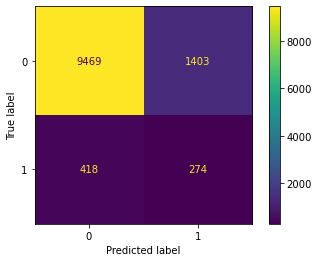

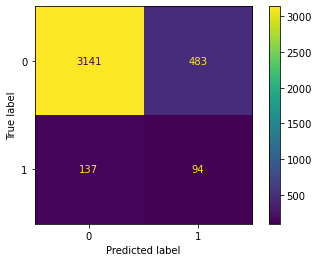

In [279]:
print('best score: {}'.format(gs_log_ada_recall.best_score_))
print('best params: {}'.format(gs_log_ada_recall.best_params_))
y_hat_test=gs_log_ada_recall.predict(X_test)
y_hat_prob=gs_log_ada_recall.predict_proba(X_test)
y_score=gs_log_ada_recall.decision_function(X_test)
fpr,tpr,thresholds=roc_curve(y_test,y_score)
print('AUC: {}'.format(auc(fpr,tpr)))
print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_log_ada_recall,X_train,y_train)
plot_confusion_matrix(gs_log_ada_recall,X_test,y_test)

Random Over Sampling also outperforms ADASYN. It is more capable of recognizing fraud, even if there are about twice as many false positives. ADASYN with hyperparameters selected to maximize recall identify a little over half the fraud with about half the false positives, but it would be more desireable to be able to flag 93% of real fraud, especially given that there are still a large number of false positives to handle in either case.

# Random Forests #

### Baseline Decision Tree ###

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     10872
           1       0.97      0.10      0.18       692

    accuracy                           0.95     11564
   macro avg       0.96      0.55      0.58     11564
weighted avg       0.95      0.95      0.92     11564



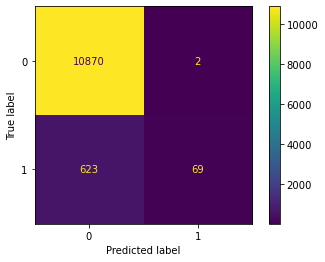

In [280]:
tree_clf=DecisionTreeClassifier(max_depth=8)
tree_clf.fit(X_train,y_train)
y_hat_tree=tree_clf.predict(X_train)
print(classification_report(y_train,y_hat_tree))
plot_confusion_matrix(tree_clf,X_train,y_train)

### Baseline Random Forest ###

AUC: [0.81581209 0.79982842 0.80862614 0.8146572  0.8066244 ]
accuracy: [0.94163424 0.94033722 0.93990489 0.94076956 0.94117647]
precision: [1.         0.5        0.5        0.66666667 1.        ]
recall: [0.02173913 0.00724638 0.01438849 0.02877698 0.01449275]


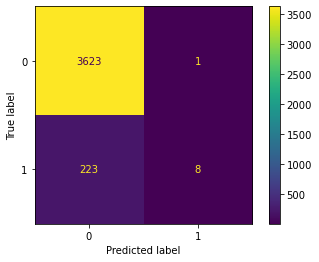

In [281]:
forest=RandomForestClassifier()


cv_results=cross_validate(forest,X_train,y_train,
                         scoring=['roc_auc','accuracy',
                                  'precision','recall'])

print('AUC: {}'.format(cv_results['test_roc_auc']))
print('accuracy: {}'.format(cv_results['test_accuracy']))
print('precision: {}'.format(cv_results['test_precision']))
print('recall: {}'.format(cv_results['test_recall']))
forest.fit(X_train,y_train)
plot_confusion_matrix(forest,X_test,y_test)

In [282]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11564 entries, 1359 to 13494
Data columns (total 79 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Month                               11564 non-null  int64
 1   WeekOfMonth                         11564 non-null  int64
 2   DayOfWeek                           11564 non-null  int64
 3   DayOfWeekClaimed                    11564 non-null  int64
 4   MonthClaimed                        11564 non-null  int64
 5   WeekOfMonthClaimed                  11564 non-null  int64
 6   Age                                 11564 non-null  int64
 7   VehiclePrice                        11564 non-null  int64
 8   Deductible                          11564 non-null  int64
 9   DriverRating                        11564 non-null  int64
 10  AgeOfVehicle                        11564 non-null  int64
 11  AgeOfPolicyHolder                   11564 non-null  int64
 12  N

In [283]:
#Perform GridSearch to find maximum recall
param_grid= {
    'n_estimators': [50,100,200],
    'criterion': ['gini','entropy'],
    'max_depth': [None,5,10,15],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [1,2,3,4],
    'max_features': ['auto','log2']
}

gs_forest=GridSearchCV(forest,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_forest.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 200]},
             scoring='recall')

best score: 0.018790388355605748
best params: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}
log_loss: 0.2295329294172919
score: 0.940337224383917
recall: 0.017316017316017316
precision: 0.5714285714285714


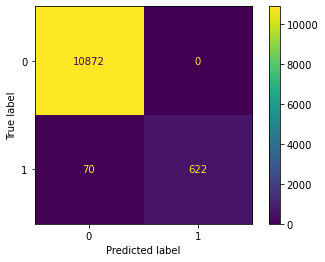

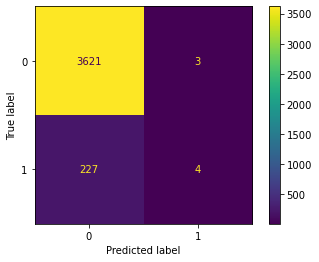

In [284]:
print('best score: {}'.format(gs_forest.best_score_))
print('best params: {}'.format(gs_forest.best_params_))
y_hat_test=gs_forest.predict(X_test)
y_hat_prob=gs_forest.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_forest,X_train,y_train)
plot_confusion_matrix(gs_forest,X_test,y_test)

Even a gridsearch meant to find the best recall did not perform well on the test set.  We'll examine oversampling methods next to address the class imbalance.

### Random Forest with RandomOverSample ###

log loss: [-0.23280189 -0.1870279  -0.2206785  -0.20018918 -0.20031558]
accuracy: [0.94033722 0.9412019  0.93817553 0.94076956 0.93944637]
precision: [0.5        0.57142857 0.35714286 0.6        0.4       ]
recall: [0.07246377 0.05797101 0.03597122 0.04316547 0.02898551]


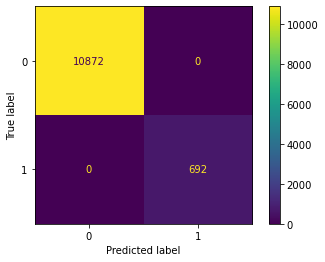

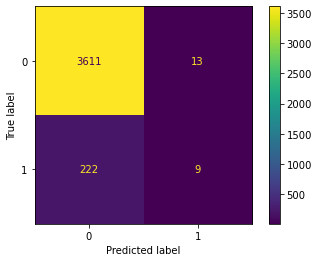

In [285]:
forest_ros_pipe=pipeline.Pipeline(steps=[
    ('over',RandomOverSampler(random_state=42)),
    ('clf',RandomForestClassifier(random_state=123))
])


cv_results=cross_validate(forest_ros_pipe,X_train,y_train,
                         scoring=['neg_log_loss','accuracy','precision',
                                 'recall'])

print('log loss: {}'.format(cv_results['test_neg_log_loss']))
print('accuracy: {}'.format(cv_results['test_accuracy']))
print('precision: {}'.format(cv_results['test_precision']))
print('recall: {}'.format(cv_results['test_recall']))
forest_ros_pipe.fit(X_train,y_train)
plot_confusion_matrix(forest_ros_pipe,X_train,y_train)
plot_confusion_matrix(forest_ros_pipe,X_test,y_test)

In [286]:
#Perform GridSearch to find maximum recall
param_grid= {
    'clf__n_estimators': [50,100,200],
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': [None,5,10,15],
    'clf__min_samples_split': [2,3,4],
    'clf__min_samples_leaf': [1,2,3,4],
    'clf__max_features': ['auto','log2']
}

gs_ros_forest=GridSearchCV(forest_ros_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_ros_forest.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('over',
                                        RandomOverSampler(random_state=42)),
                                       ('clf',
                                        RandomForestClassifier(random_state=123))]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [None, 5, 10, 15],
                         'clf__max_features': ['auto', 'log2'],
                         'clf__min_samples_leaf': [1, 2, 3, 4],
                         'clf__min_samples_split': [2, 3, 4],
                         'clf__n_estimators': [50, 100, 200]},
             scoring='recall')

best score: 0.945084384214819
best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
log_loss: 0.5240931933680595
score: 0.6072632944228274
recall: 0.9437229437229437
precision: 0.12681791739383363


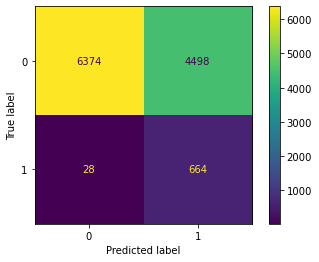

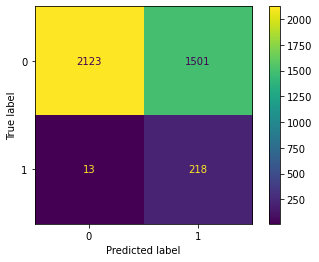

In [287]:
print('best score: {}'.format(gs_ros_forest.best_score_))
print('best params: {}'.format(gs_ros_forest.best_params_))
y_hat_test=gs_ros_forest.predict(X_test)
y_hat_prob=gs_ros_forest.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_ros_forest,X_train,y_train)
plot_confusion_matrix(gs_ros_forest,X_test,y_test)

### Random Forest with SMOTE ###

log loss: [-0.20049452 -0.2095563  -0.23247828 -0.19480245 -0.24109623]
accuracy: [0.93731085 0.93947255 0.93428448 0.93904021 0.94031142]
precision: [0.31578947 0.375      0.15789474 0.4        0.5       ]
recall: [0.04347826 0.02173913 0.02158273 0.02877698 0.02898551]


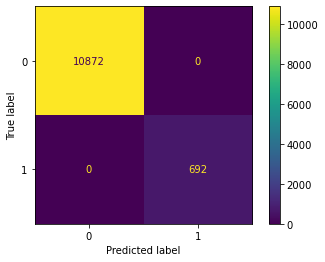

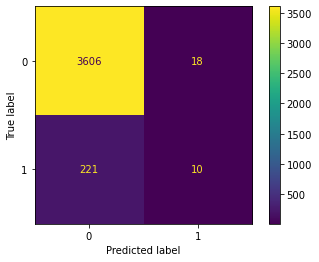

In [288]:
forest_sm_pipe=pipeline.Pipeline(steps=[
    ('smote',SMOTE(random_state=42)),
    ('clf',RandomForestClassifier(random_state=123))
])


cv_results=cross_validate(forest_sm_pipe,X_train,y_train,
                         scoring=['neg_log_loss','accuracy','precision',
                                 'recall'])

print('log loss: {}'.format(cv_results['test_neg_log_loss']))
print('accuracy: {}'.format(cv_results['test_accuracy']))
print('precision: {}'.format(cv_results['test_precision']))
print('recall: {}'.format(cv_results['test_recall']))
forest_sm_pipe.fit(X_train,y_train)
plot_confusion_matrix(forest_sm_pipe,X_train,y_train)
plot_confusion_matrix(forest_sm_pipe,X_test,y_test)

In [289]:
#Perform GridSearch to find maximum recall
param_grid= {
    'clf__n_estimators': [50,100,200],
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': [None,5,10,15],
    'clf__min_samples_split': [2,3,4],
    'clf__min_samples_leaf': [1,2,3,4],
    'clf__max_features': ['auto','log2']
}

gs_sm_forest=GridSearchCV(forest_sm_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_sm_forest.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('clf',
                                        RandomForestClassifier(random_state=123))]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [None, 5, 10, 15],
                         'clf__max_features': ['auto', 'log2'],
                         'clf__min_samples_leaf': [1, 2, 3, 4],
                         'clf__min_samples_split': [2, 3, 4],
                         'clf__n_estimators': [50, 100, 200]},
             scoring='recall')

best score: 0.5115377376246941
best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4, 'clf__n_estimators': 100}
log_loss: 0.4026493024739636
score: 0.7865110246433203
recall: 0.5194805194805194
precision: 0.14423076923076922


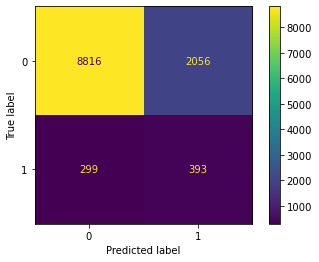

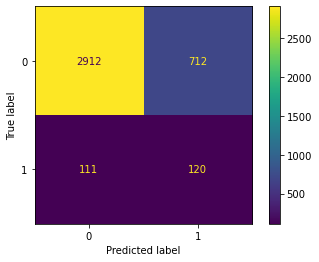

In [290]:
print('best score: {}'.format(gs_sm_forest.best_score_))
print('best params: {}'.format(gs_sm_forest.best_params_))
y_hat_test=gs_sm_forest.predict(X_test)
y_hat_prob=gs_sm_forest.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_sm_forest,X_train,y_train)
plot_confusion_matrix(gs_sm_forest,X_test,y_test)

### Random Forest with ADASYN ###

log loss: [-0.19921837 -0.22386462 -0.23178607 -0.23610621 -0.25146972]
accuracy: [0.93947255 0.93644617 0.93514916 0.93990489 0.93901384]
precision: [0.45       0.15384615 0.21052632 0.5        0.33333333]
recall: [0.06521739 0.01449275 0.02877698 0.03597122 0.02173913]


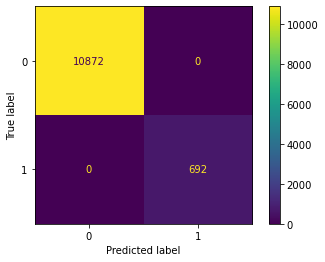

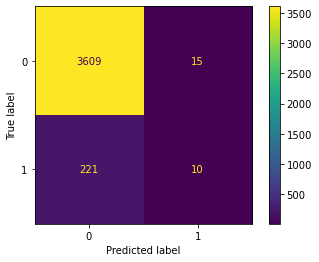

In [291]:
forest_ada_pipe=pipeline.Pipeline(steps=[
    ('smote',ADASYN(random_state=42)),
    ('clf',RandomForestClassifier(random_state=123))
])


cv_results=cross_validate(forest_ada_pipe,X_train,y_train,
                         scoring=['neg_log_loss','accuracy','precision',
                                 'recall'])

print('log loss: {}'.format(cv_results['test_neg_log_loss']))
print('accuracy: {}'.format(cv_results['test_accuracy']))
print('precision: {}'.format(cv_results['test_precision']))
print('recall: {}'.format(cv_results['test_recall']))
forest_ada_pipe.fit(X_train,y_train)
plot_confusion_matrix(forest_ada_pipe,X_train,y_train)
plot_confusion_matrix(forest_ada_pipe,X_test,y_test)

In [292]:
#Perform GridSearch to find maximum recall
param_grid= {
    'clf__n_estimators': [50,75,100],
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': [None,5,10,15],
    'clf__min_samples_split': [2,3,4],
    'clf__min_samples_leaf': [1,2,3,4],
    'clf__max_features': ['auto','log2']
}

gs_ada_forest=GridSearchCV(forest_ada_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_ada_forest.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smote', ADASYN(random_state=42)),
                                       ('clf',
                                        RandomForestClassifier(random_state=123))]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [None, 5, 10, 15],
                         'clf__max_features': ['auto', 'log2'],
                         'clf__min_samples_leaf': [1, 2, 3, 4],
                         'clf__min_samples_split': [2, 3, 4],
                         'clf__n_estimators': [50, 75, 100]},
             scoring='recall')

best score: 0.5303406738189347
best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
log_loss: 0.40297643263384353
score: 0.7826199740596628
recall: 0.5108225108225108
precision: 0.13997627520759193


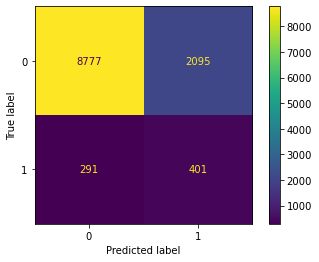

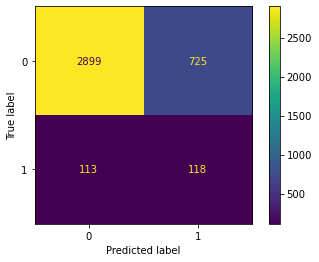

In [293]:
print('best score: {}'.format(gs_ada_forest.best_score_))
print('best params: {}'.format(gs_ada_forest.best_params_))
y_hat_test=gs_ada_forest.predict(X_test)
y_hat_prob=gs_ada_forest.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_ada_forest,X_train,y_train)
plot_confusion_matrix(gs_ada_forest,X_test,y_test)

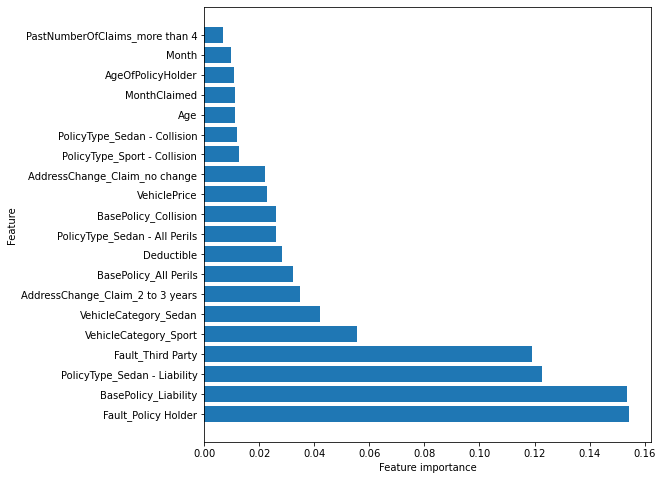

In [294]:
def plot_feature_importances(model,X):
    n_features = X.shape[1]
    impor=model.best_estimator_.named_steps['clf'].feature_importances_
    #plt.figure(figsize=(8,15))
    #plt.barh(range(n_features), impor, align='center') 
    #plt.yticks(np.arange(n_features), X.columns.values) 
    #plt.xlabel('Feature importance')
    #plt.ylabel('Feature')
    
    #plot top 20
    feat=pd.DataFrame({'features':X.columns.values,'importance': impor})
    top20=feat.sort_values('importance',ascending=False).head(20)
    plt.figure(figsize=(8,8))
    plt.barh(range(20), top20['importance'], align='center') 
    plt.yticks(np.arange(20), top20['features']) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(gs_ros_forest,X_train)

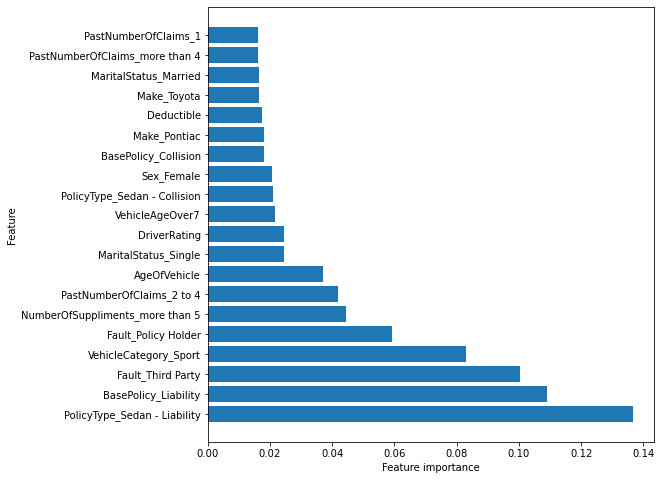

In [295]:
plot_feature_importances(gs_ada_forest,X_train)

# Adaboost #

### Baseline Adaboost ###

AUC: [0.76919707 0.78726137 0.78989927 0.8194506  0.80598776]
accuracy: [0.93817553 0.93428448 0.93687851 0.93385214 0.93685121]
precision: [0.22222222 0.15       0.23076923 0.20833333 0.25      ]
recall: [0.01449275 0.02173913 0.02158273 0.03597122 0.02898551]


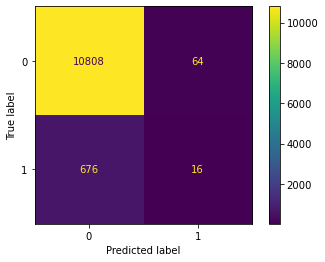

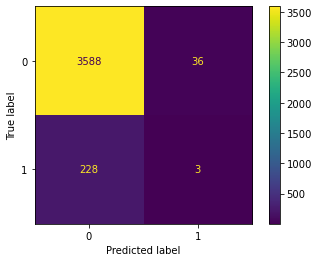

In [296]:
adab_clf=AdaBoostClassifier(random_state=50)

cv_results=cross_validate(adab_clf,X_train,y_train,
                         scoring=['roc_auc','accuracy',
                                  'precision','recall'])

print('AUC: {}'.format(cv_results['test_roc_auc']))
print('accuracy: {}'.format(cv_results['test_accuracy']))
print('precision: {}'.format(cv_results['test_precision']))
print('recall: {}'.format(cv_results['test_recall']))

adab_clf.fit(X_train,y_train)
plot_confusion_matrix(adab_clf,X_train,y_train)
plot_confusion_matrix(adab_clf,X_test,y_test)

In [297]:
#Perform GridSearch to find maximum recall
param_grid= {
    'base_estimator': [DecisionTreeClassifier(max_depth=1),
                       DecisionTreeClassifier(max_depth=2),
                      DecisionTreeClassifier(max_depth=3),
                      DecisionTreeClassifier(max_depth=10)],
    'n_estimators': [50,75,100,500],
    'learning_rate': [.1,1],
}

gs_adab=GridSearchCV(adab_clf,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_adab.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=50),
             param_grid={'base_estimator': [DecisionTreeClassifier(max_depth=1),
                                            DecisionTreeClassifier(max_depth=2),
                                            DecisionTreeClassifier(max_depth=3),
                                            DecisionTreeClassifier(max_depth=10)],
                         'learning_rate': [0.1, 1],
                         'n_estimators': [50, 75, 100, 500]},
             scoring='recall')

best score: 0.11264822134387352
best params: {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 1, 'n_estimators': 75}
log_loss: 0.5347769258713565
score: 0.9265888456549936
recall: 0.09090909090909091
precision: 0.22340425531914893


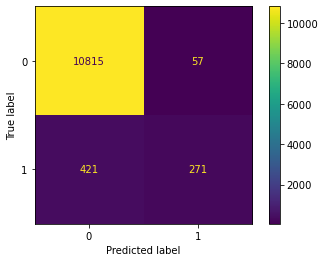

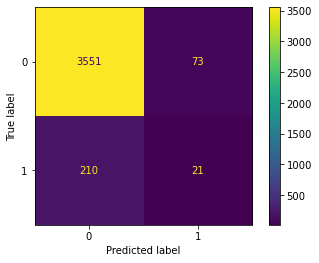

In [298]:
print('best score: {}'.format(gs_adab.best_score_))
print('best params: {}'.format(gs_adab.best_params_))
y_hat_test=gs_adab.predict(X_test)
y_hat_prob=gs_adab.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_adab,X_train,y_train)
plot_confusion_matrix(gs_adab,X_test,y_test)

Text(0, 0.5, 'Feature')

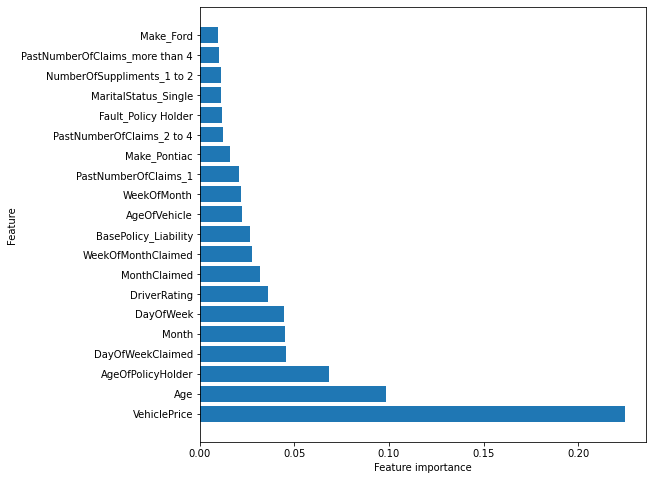

In [299]:
n_features = X.shape[1]
impor=gs_adab.best_estimator_.feature_importances_

    
    #plot top 20
feat=pd.DataFrame({'features':X_train.columns.values,'importance': impor})
top20=feat.sort_values('importance',ascending=False).head(20)
plt.figure(figsize=(8,8))
plt.barh(range(20), top20['importance'], align='center') 
plt.yticks(np.arange(20), top20['features']) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')


### Adaboost with RandomOverSample ###

log loss: [-0.67877251 -0.67442223 -0.67886809 -0.67883311 -0.67408356]
accuracy: [0.65023779 0.65110246 0.67315175 0.65888457 0.66349481]
precision: [0.11569301 0.12541993 0.13404508 0.13235294 0.12962963]
recall: [0.73188406 0.8115942  0.81294964 0.84172662 0.8115942 ]


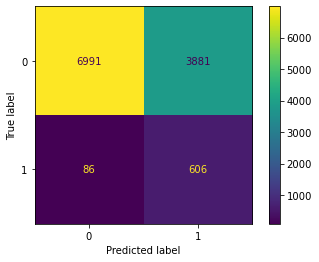

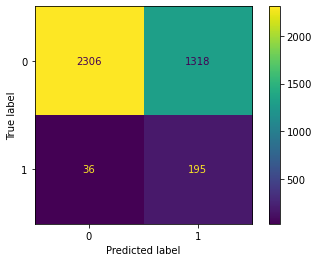

In [300]:
adab_ros_pipe=pipeline.Pipeline(steps=[
    ('over',RandomOverSampler(random_state=42)),
    ('clf',AdaBoostClassifier(random_state=123))
])


cv_results=cross_validate(adab_ros_pipe,X_train,y_train,
                         scoring=['neg_log_loss','accuracy','precision',
                                 'recall'])

print('log loss: {}'.format(cv_results['test_neg_log_loss']))
print('accuracy: {}'.format(cv_results['test_accuracy']))
print('precision: {}'.format(cv_results['test_precision']))
print('recall: {}'.format(cv_results['test_recall']))
adab_ros_pipe.fit(X_train,y_train)
plot_confusion_matrix(adab_ros_pipe,X_train,y_train)
plot_confusion_matrix(adab_ros_pipe,X_test,y_test)

In [301]:
#Perform GridSearch to find maximum recall
param_grid= {
    'clf__base_estimator': [DecisionTreeClassifier(max_depth=1),
                       DecisionTreeClassifier(max_depth=2),
                      DecisionTreeClassifier(max_depth=3),
                      DecisionTreeClassifier(max_depth=10)],
    'clf__n_estimators': [50,75,100,500],
    'clf__learning_rate': [.1,1],
}

gs_ros_adab=GridSearchCV(adab_ros_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_ros_adab.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('over',
                                        RandomOverSampler(random_state=42)),
                                       ('clf',
                                        AdaBoostClassifier(random_state=123))]),
             param_grid={'clf__base_estimator': [DecisionTreeClassifier(max_depth=1),
                                                 DecisionTreeClassifier(max_depth=2),
                                                 DecisionTreeClassifier(max_depth=3),
                                                 DecisionTreeClassifier(max_depth=10)],
                         'clf__learning_rate': [0.1, 1],
                         'clf__n_estimators': [50, 75, 100, 500]},
             scoring='recall')

best score: 0.9292050944224858
best params: {'clf__base_estimator': DecisionTreeClassifier(max_depth=1), 'clf__learning_rate': 0.1, 'clf__n_estimators': 75}
log_loss: 0.6363946348440506
score: 0.5968871595330739
recall: 0.9307359307359307
precision: 0.1226468910439247


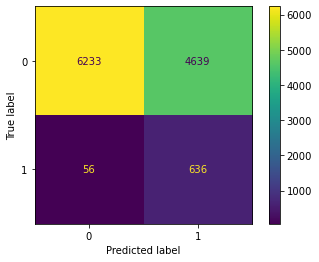

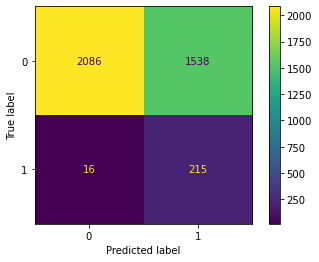

In [302]:
print('best score: {}'.format(gs_ros_adab.best_score_))
print('best params: {}'.format(gs_ros_adab.best_params_))
y_hat_test=gs_ros_adab.predict(X_test)
y_hat_prob=gs_ros_adab.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_ros_adab,X_train,y_train)
plot_confusion_matrix(gs_ros_adab,X_test,y_test)

In [303]:
#Perform GridSearch to find maximum accuracy
param_grid= {
    'clf__base_estimator': [DecisionTreeClassifier(max_depth=1),
                       DecisionTreeClassifier(max_depth=2),
                      DecisionTreeClassifier(max_depth=3),
                      DecisionTreeClassifier(max_depth=10)],
    'clf__n_estimators': [50,75,100,500],
    'clf__learning_rate': [.1,1],
}

gs_ros_adab_acc=GridSearchCV(adab_ros_pipe,param_grid,cv=3,scoring='accuracy',
                   verbose=0)
gs_ros_adab_acc.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('over',
                                        RandomOverSampler(random_state=42)),
                                       ('clf',
                                        AdaBoostClassifier(random_state=123))]),
             param_grid={'clf__base_estimator': [DecisionTreeClassifier(max_depth=1),
                                                 DecisionTreeClassifier(max_depth=2),
                                                 DecisionTreeClassifier(max_depth=3),
                                                 DecisionTreeClassifier(max_depth=10)],
                         'clf__learning_rate': [0.1, 1],
                         'clf__n_estimators': [50, 75, 100, 500]},
             scoring='accuracy')

best score: 0.9399861705380858
best params: {'clf__base_estimator': DecisionTreeClassifier(max_depth=10), 'clf__learning_rate': 1, 'clf__n_estimators': 500}
log_loss: 0.5085036675980273
score: 0.9400778210116731
recall: 0.008658008658008658
precision: 0.5


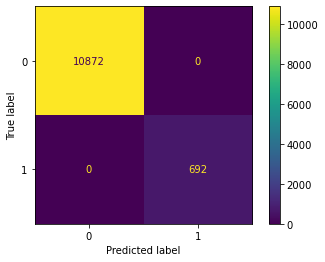

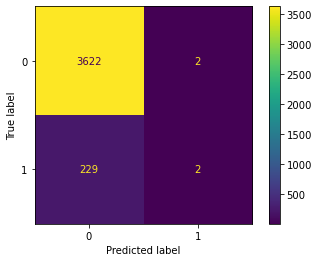

In [304]:
print('best score: {}'.format(gs_ros_adab_acc.best_score_))
print('best params: {}'.format(gs_ros_adab_acc.best_params_))
y_hat_test=gs_ros_adab_acc.predict(X_test)
y_hat_prob=gs_ros_adab_acc.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_ros_adab_acc,X_train,y_train)
plot_confusion_matrix(gs_ros_adab_acc,X_test,y_test)

### Adaboost with ADASYN ###

log loss: [-0.65974546 -0.65801751 -0.65733546 -0.65726045 -0.6585282 ]
accuracy: [0.91266753 0.9256377  0.92693472 0.91439689 0.92430796]
precision: [0.1097561  0.14583333 0.22222222 0.11688312 0.20634921]
recall: [0.06521739 0.05072464 0.08633094 0.0647482  0.0942029 ]


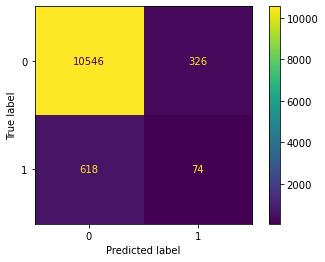

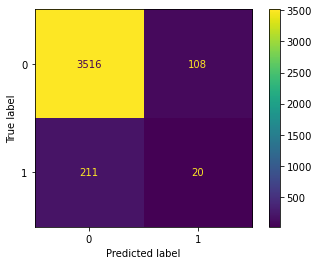

In [305]:
adab_ada_pipe=pipeline.Pipeline(steps=[
    ('adasyn',ADASYN(random_state=42)),
    ('clf',AdaBoostClassifier(random_state=123))
])


cv_results=cross_validate(adab_ada_pipe,X_train,y_train,
                         scoring=['neg_log_loss','accuracy','precision',
                                 'recall'])

print('log loss: {}'.format(cv_results['test_neg_log_loss']))
print('accuracy: {}'.format(cv_results['test_accuracy']))
print('precision: {}'.format(cv_results['test_precision']))
print('recall: {}'.format(cv_results['test_recall']))
adab_ada_pipe.fit(X_train,y_train)
plot_confusion_matrix(adab_ada_pipe,X_train,y_train)
plot_confusion_matrix(adab_ada_pipe,X_test,y_test)

In [306]:
#Perform GridSearch to find maximum recall
param_grid= {
    'clf__base_estimator': [DecisionTreeClassifier(max_depth=1),
                       DecisionTreeClassifier(max_depth=2),
                      DecisionTreeClassifier(max_depth=3),
                      DecisionTreeClassifier(max_depth=10)],
    'clf__n_estimators': [50,75,100,500],
    'clf__learning_rate': [.1,1],
}

gs_ada_adab=GridSearchCV(adab_ada_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_ada_adab.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('adasyn', ADASYN(random_state=42)),
                                       ('clf',
                                        AdaBoostClassifier(random_state=123))]),
             param_grid={'clf__base_estimator': [DecisionTreeClassifier(max_depth=1),
                                                 DecisionTreeClassifier(max_depth=2),
                                                 DecisionTreeClassifier(max_depth=3),
                                                 DecisionTreeClassifier(max_depth=10)],
                         'clf__learning_rate': [0.1, 1],
                         'clf__n_estimators': [50, 75, 100, 500]},
             scoring='recall')

best score: 0.7022711587928979
best params: {'clf__base_estimator': DecisionTreeClassifier(max_depth=1), 'clf__learning_rate': 0.1, 'clf__n_estimators': 50}
log_loss: 0.5749365753009797
score: 0.7079118028534371
recall: 0.7012987012987013
precision: 0.13289581624282198


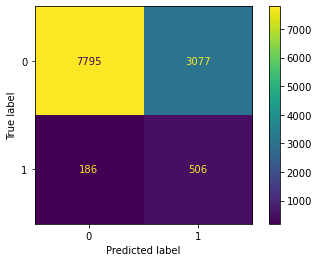

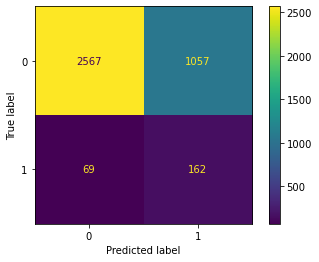

In [307]:
print('best score: {}'.format(gs_ada_adab.best_score_))
print('best params: {}'.format(gs_ada_adab.best_params_))
y_hat_test=gs_ada_adab.predict(X_test)
y_hat_prob=gs_ada_adab.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_ada_adab,X_train,y_train)
plot_confusion_matrix(gs_ada_adab,X_test,y_test)

# XGBoost #

AUC: [0.81157421 0.80340496 0.77960925 0.82105392 0.79371492]
accuracy: [0.94033722 0.94033722 0.93774319 0.94163424 0.93944637]
precision: [0.5        0.5        0.35294118 0.625      0.4       ]
recall: [0.12318841 0.05072464 0.04316547 0.07194245 0.02898551]


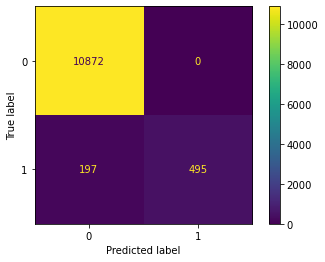

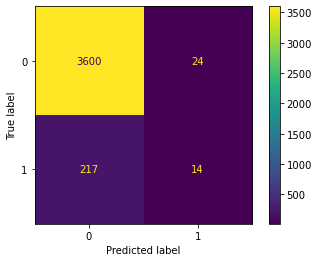

In [308]:
xgb_pipe=pipeline.Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('clf',xgb.XGBClassifier(objective='binary:logistic', 
                             random_state=123))
])

cv_results=cross_validate(xgb_pipe,X_train,y_train,
                         scoring=['roc_auc','accuracy',
                                  'precision','recall'])

print('AUC: {}'.format(cv_results['test_roc_auc']))
print('accuracy: {}'.format(cv_results['test_accuracy']))
print('precision: {}'.format(cv_results['test_precision']))
print('recall: {}'.format(cv_results['test_recall']))

xgb_pipe.fit(X_train,y_train)
plot_confusion_matrix(xgb_pipe,X_train,y_train)
plot_confusion_matrix(xgb_pipe,X_test,y_test)

In [309]:
#Perform GridSearchCV to find max recall

param_grid= {
    'clf__max_depth': [3,4,5,7,10],
    'clf__learning_rate': [.1,.01,.05],
    'clf__gamma': [0,.25,1],
    'clf__reg_lambda': [0,1,10],
    'clf__scale_pos_weight': [1,5,15,25,35],
    'clf__subsample': [.8,1],
    'clf__colsample_bytree': [.5,1]
}

gs_xgb=GridSearchCV(xgb_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_xgb.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0, gpu_id=-1,
                                                      importance_type='gain',
                                                      interaction_constraints='',
                                                      learning_rate=0.300000012,
                                                      max_delta_step=0,
                                                      max_depth=6,
                                              

best score: 0.9609699479264696
best params: {'clf__colsample_bytree': 0.5, 'clf__gamma': 0, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__reg_lambda': 0, 'clf__scale_pos_weight': 15, 'clf__subsample': 1}
log_loss: 0.5430451215666401
score: 0.6041504539559014
recall: 0.961038961038961
precision: 0.1276595744680851


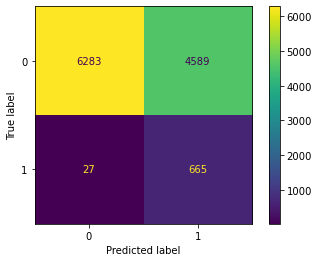

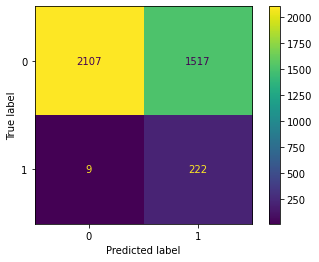

In [361]:
print('best score: {}'.format(gs_xgb.best_score_))
print('best params: {}'.format(gs_xgb.best_params_))
y_hat_test=gs_xgb.predict(X_test)
y_hat_prob=gs_xgb.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_xgb,X_train,y_train)
plot_confusion_matrix(gs_xgb,X_test,y_test)

In [357]:
#Refine GridSearch

param_grid= {
    'clf__max_depth': [1,2,3],
    'clf__n_estimators': [100,500],
    'clf__learning_rate': [.01],
    'clf__gamma': [0],
    'clf__reg_lambda': [0],
    'clf__scale_pos_weight': [15,20,25,40],
    'clf__subsample': [.9,1],
    'clf__colsample_bytree': [.3,.4,.5]
}

gs_xgb_2=GridSearchCV(xgb_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_xgb_2.fit(X_train,y_train)

print('best score: {}'.format(gs_xgb_2.best_score_))
print('best params: {}'.format(gs_xgb_2.best_params_))


best score: 0.9609699479264696
best params: {'clf__colsample_bytree': 0.3, 'clf__gamma': 0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'clf__reg_lambda': 0, 'clf__scale_pos_weight': 40, 'clf__subsample': 0.9}


log_loss: 0.7706477046476727
score: 0.5992217898832685
recall: 0.961038961038961
precision: 0.12627986348122866


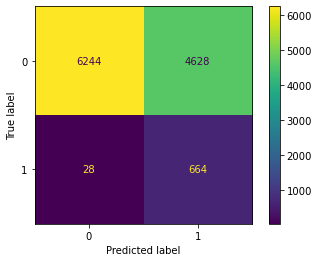

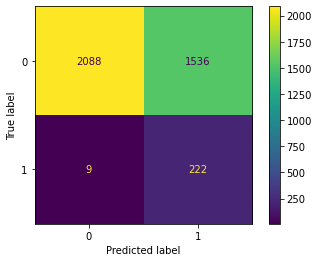

In [362]:
y_hat_test=gs_xgb_2.predict(X_test)
y_hat_prob=gs_xgb_2.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_xgb_2,X_train,y_train)
plot_confusion_matrix(gs_xgb_2,X_test,y_test)

best score: 0.22818311507287561
best params: {'clf__colsample_bytree': 0.3, 'clf__gamma': 0, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__reg_lambda': 0, 'clf__scale_pos_weight': 15, 'clf__subsample': 0.9}
log_loss: 0.5203241624179672
score: 0.6186770428015564
recall: 0.9307359307359307
precision: 0.1288196524865189


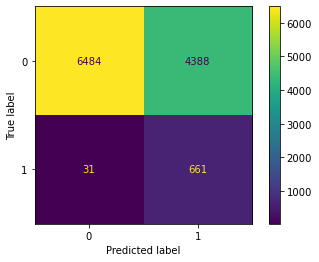

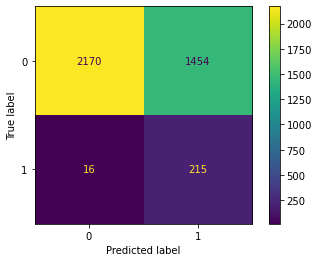

In [370]:
#tune for f1
param_grid= {
    'clf__max_depth': [1,2,3],
    'clf__n_estimators': [100,200],
    'clf__learning_rate': [.01],
    'clf__gamma': [0],
    'clf__reg_lambda': [0],
    'clf__scale_pos_weight': [15,20,25,40],
    'clf__subsample': [.9,1],
    'clf__colsample_bytree': [.3,.4,.5]
}

gs_xgb_f1_2=GridSearchCV(xgb_pipe,param_grid,cv=3,scoring='f1',
                   verbose=0)
gs_xgb_f1_2.fit(X_train,y_train)

print('best score: {}'.format(gs_xgb_f1_2.best_score_))
print('best params: {}'.format(gs_xgb_f1_2.best_params_))
y_hat_test=gs_xgb_f1_2.predict(X_test)
y_hat_prob=gs_xgb_f1_2.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_xgb_f1_2,X_train,y_train)
plot_confusion_matrix(gs_xgb_f1_2,X_test,y_test)

### XGBoost with RandomOverSample ###

AUC: [0.80888556 0.78062969 0.78227317 0.80565281 0.78899511]
accuracy: [0.89494163 0.88197147 0.88932123 0.90056204 0.89100346]
precision: [0.22797927 0.16080402 0.18378378 0.24861878 0.18333333]
recall: [0.31884058 0.23188406 0.24460432 0.32374101 0.23913043]


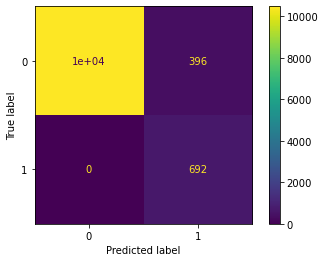

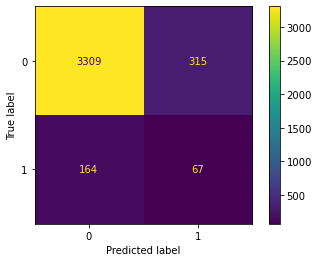

In [311]:
xgb_ros_pipe=pipeline.Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('ros',RandomOverSampler(random_state=42)),
    ('clf',xgb.XGBClassifier(objective='binary:logistic', 
                             random_state=123))
])

cv_results=cross_validate(xgb_ros_pipe,X_train,y_train,
                         scoring=['roc_auc','accuracy',
                                  'precision','recall'])

print('AUC: {}'.format(cv_results['test_roc_auc']))
print('accuracy: {}'.format(cv_results['test_accuracy']))
print('precision: {}'.format(cv_results['test_precision']))
print('recall: {}'.format(cv_results['test_recall']))

xgb_ros_pipe.fit(X_train,y_train)
plot_confusion_matrix(xgb_ros_pipe,X_train,y_train)
plot_confusion_matrix(xgb_ros_pipe,X_test,y_test)

In [312]:
#Perform GridSearchCV to find max recall

param_grid= {
    'clf__max_depth': [3,4,5,7,10],
    'clf__learning_rate': [.1,.01,.05],
    'clf__gamma': [0,.25,1],
    'clf__reg_lambda': [0,1,10],
    'clf__scale_pos_weight': [1,3,5],
    'clf__subsample': [.8,1],
    'clf__colsample_bytree': [.5,1]
}

gs_ros_xgb=GridSearchCV(xgb_ros_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_ros_xgb.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ros',
                                        RandomOverSampler(random_state=42)),
                                       ('clf',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0, gpu_id=-1,
                                                      importance_type='gain',
                                                      interaction_constraints='',
                                                      learning_rate=0.300000012,
                                                      max_del

best score: 0.9667419536984755
best params: {'clf__colsample_bytree': 1, 'clf__gamma': 0, 'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__reg_lambda': 10, 'clf__scale_pos_weight': 5, 'clf__subsample': 1}
log_loss: 1.0369599477734643
score: 0.5735408560311284
recall: 0.961038961038961
precision: 0.11954765751211632


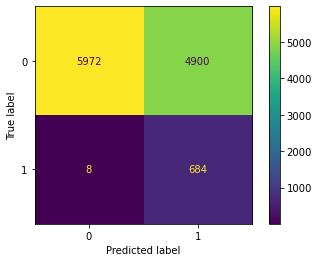

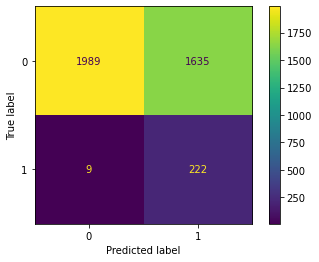

In [313]:
print('best score: {}'.format(gs_ros_xgb.best_score_))
print('best params: {}'.format(gs_ros_xgb.best_params_))
y_hat_test=gs_ros_xgb.predict(X_test)
y_hat_prob=gs_ros_xgb.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_ros_xgb,X_train,y_train)
plot_confusion_matrix(gs_ros_xgb,X_test,y_test)

In [314]:
#Perform GridSearchCV to find max f1 score

param_grid= {
    'clf__max_depth': [3,4,5,7,10],
    'clf__learning_rate': [.1,.01,.05],
    'clf__gamma': [0,.25,1],
    'clf__reg_lambda': [0,1,10],
    'clf__scale_pos_weight': [1,3,5],
    'clf__subsample': [.8,1],
    'clf__colsample_bytree': [.5,1]
}

gs_ros_xgb=GridSearchCV(xgb_ros_pipe,param_grid,cv=3,scoring='f1',
                   verbose=0)
gs_ros_xgb.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ros',
                                        RandomOverSampler(random_state=42)),
                                       ('clf',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0, gpu_id=-1,
                                                      importance_type='gain',
                                                      interaction_constraints='',
                                                      learning_rate=0.300000012,
                                                      max_del

best score: 0.25820512767409187
best params: {'clf__colsample_bytree': 1, 'clf__gamma': 1, 'clf__learning_rate': 0.05, 'clf__max_depth': 10, 'clf__reg_lambda': 10, 'clf__scale_pos_weight': 1, 'clf__subsample': 0.8}
log_loss: 0.3446913610413023
score: 0.7880674448767834
f1 score:0.24000000000000002
recall: 0.5584415584415584
precision: 0.1528436018957346


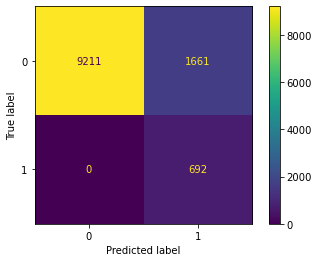

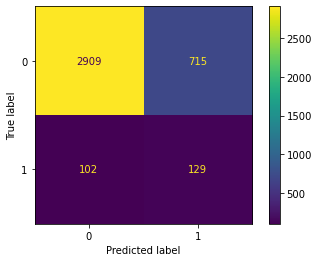

In [315]:
print('best score: {}'.format(gs_ros_xgb.best_score_))
print('best params: {}'.format(gs_ros_xgb.best_params_))
y_hat_test=gs_ros_xgb.predict(X_test)
y_hat_prob=gs_ros_xgb.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('f1 score:{}'.format(f1_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_ros_xgb,X_train,y_train)
plot_confusion_matrix(gs_ros_xgb,X_test,y_test)

### XGBoost with SMOTE ###

best score: 0.9624129493694711
best params: {'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__reg_lambda': 0, 'clf__scale_pos_weight': 5, 'clf__subsample': 1}
log_loss: 0.7238082351774248
score: 0.5987029831387808
f1 score:0.22300351582119537
recall: 0.961038961038961
precision: 0.12613636363636363


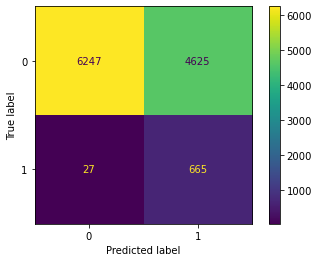

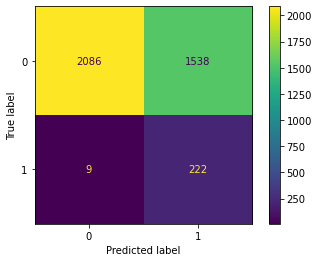

In [316]:
xgb_smote_pipe=pipeline.Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('smote',SMOTE(random_state=42)),
    ('clf',xgb.XGBClassifier(objective='binary:logistic', 
                             random_state=123))
])

#Perform GridSearchCV to find max recall

param_grid= {
    'clf__max_depth': [3,4,5,7,10],
    'clf__learning_rate': [.1,.01,.05],
    'clf__gamma': [0,.25,1],
    'clf__reg_lambda': [0,1,10],
    'clf__scale_pos_weight': [5,10,15],
    'clf__subsample': [.8,1],
    'clf__colsample_bytree': [.8,1]
}

gs_smote_xgb=GridSearchCV(xgb_smote_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_smote_xgb.fit(X_train,y_train)

print('best score: {}'.format(gs_smote_xgb.best_score_))
print('best params: {}'.format(gs_smote_xgb.best_params_))
y_hat_test=gs_smote_xgb.predict(X_test)
y_hat_prob=gs_smote_xgb.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('f1 score:{}'.format(f1_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_smote_xgb,X_train,y_train)
plot_confusion_matrix(gs_smote_xgb,X_test,y_test)

best score: 0.9681912290607944
best params: {'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__reg_lambda': 0, 'clf__scale_pos_weight': 15, 'clf__subsample': 0.8}
log_loss: 0.8421340568520216
score: 0.5782101167315176
f1 score:0.21600771456123435
recall: 0.9696969696969697
precision: 0.12154096581660337


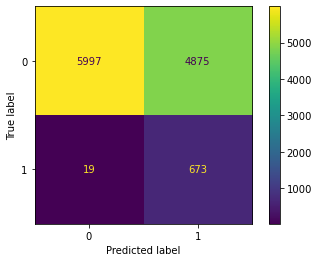

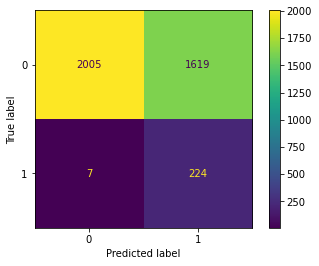

In [322]:
xgb_smote_pipe=pipeline.Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('smote',SMOTE(random_state=42)),
    ('clf',xgb.XGBClassifier(objective='binary:logistic', 
                             random_state=123))
])

#Perform GridSearchCV to find max recall

param_grid= {
    'clf__max_depth': [3,4,5,7,10],
    'clf__learning_rate': [.1,.01,.05],
    'clf__gamma': [0,.25,1],
    'clf__reg_lambda': [0,1,10],
    'clf__scale_pos_weight': [5,10,15],
    'clf__subsample': [.8,1],
    'clf__colsample_bytree': [.8,1]
}

gs_smote_xgb=GridSearchCV(xgb_smote_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_smote_xgb.fit(X_train,y_train)

print('best score: {}'.format(gs_smote_xgb.best_score_))
print('best params: {}'.format(gs_smote_xgb.best_params_))
y_hat_test=gs_smote_xgb.predict(X_test)
y_hat_prob=gs_smote_xgb.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('f1 score:{}'.format(f1_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_smote_xgb,X_train,y_train)
plot_confusion_matrix(gs_smote_xgb,X_test,y_test)

### XGBoost with ADASYN ###

best score: 0.9652989522554739
best params: {'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__reg_lambda': 0, 'clf__scale_pos_weight': 5, 'clf__subsample': 0.8}
log_loss: 0.7271204083732749
score: 0.5937743190661479
f1 score:0.2208955223880597
recall: 0.961038961038961
precision: 0.12478920741989882


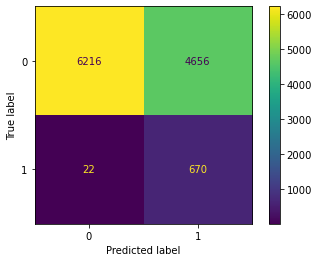

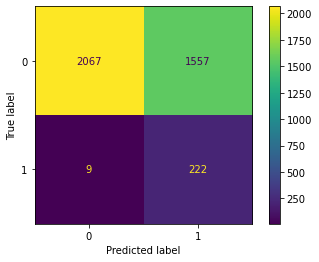

In [317]:
xgb_ada_pipe=pipeline.Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('adasyn',ADASYN(random_state=42)),
    ('clf',xgb.XGBClassifier(objective='binary:logistic', 
                             random_state=123))
])

#Perform GridSearchCV to find max recall

param_grid= {
    'clf__max_depth': [3,4,5,7,10],
    'clf__learning_rate': [.1,.01,.05],
    'clf__gamma': [0,.25,1],
    'clf__reg_lambda': [0,1,10],
    'clf__scale_pos_weight': [1,3,5],
    'clf__subsample': [.8,1],
    'clf__colsample_bytree': [.8,1]
}

gs_ada_xgb=GridSearchCV(xgb_ada_pipe,param_grid,cv=3,scoring='recall',
                   verbose=0)
gs_ada_xgb.fit(X_train,y_train)

print('best score: {}'.format(gs_ada_xgb.best_score_))
print('best params: {}'.format(gs_ada_xgb.best_params_))
y_hat_test=gs_ada_xgb.predict(X_test)
y_hat_prob=gs_ada_xgb.predict_proba(X_test)

print('log_loss: {}'.format(log_loss(y_test,y_hat_prob)))
print('score: {}'.format(accuracy_score(y_test,y_hat_test)))
print('f1 score:{}'.format(f1_score(y_test,y_hat_test)))
print('recall: {}'.format(recall_score(y_test,y_hat_test)))
print('precision: {}'.format(precision_score(y_test,y_hat_test)))
plot_confusion_matrix(gs_ada_xgb,X_train,y_train)
plot_confusion_matrix(gs_ada_xgb,X_test,y_test)

# CATBoost #

In [32]:
import catboost

### Baseline Catboost ###

In [33]:
#Catboost can handle categorical variables
#We'll use a diff version of X_train that hasn't been ohe'd
#X, y are before ohe

#get list of categorical features in X
dtypes=X.dtypes.reset_index()
cat_features=dtypes[dtypes[0]=='object']['index'].to_list()


In [34]:
#Split into test and train

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X, y ,random_state=42, stratify=y
)

In [35]:
#Split training set into train and validation for catboost training

train_X, val_X, train_y, val_y = train_test_split(
    X_train_cat, y_train_cat, random_state=42, stratify=y_train_cat
)

In [36]:
#create train_pool and validation_pool

train_pool = catboost.Pool(
    data = train_X,
    label = train_y,
    cat_features = cat_features
)

val_pool = catboost.Pool(
    data = val_X,
    label = val_y,
    cat_features=cat_features
)

Catboost default iterations is 1000 and it automatically calculates a learning rate based on the data set and number of iterations. It will revert back to iteration with the best loss fn score for model output. 

It uses log-loss for loss function and calculates log loss as well as any other metrics defined in 'custom_loss' for each iteration (can be seen on the graph). 

The scale_pos_weight parameter is used for class imbalances and it is set here to the recommended amount of (sum_pos/sum_neg) (96/4).  We will work on tuning this hyperparameter as well as a few others later on.

In [39]:
cat_model = catboost.CatBoostClassifier(
    verbose=50,
    #iterations=500,
    #learning_rate=.05,
    custom_loss=['AUC','Recall','Accuracy'],
    train_dir='first',
    scale_pos_weight=24
)

cat_model.fit(train_pool, eval_set = val_pool, verbose=50,
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.05403
0:	learn: 0.6645234	test: 0.6629554	best: 0.6629554 (0)	total: 9.95ms	remaining: 9.94s
50:	learn: 0.4556720	test: 0.4884782	best: 0.4876927 (43)	total: 325ms	remaining: 6.04s
100:	learn: 0.4198559	test: 0.4776620	best: 0.4763764 (96)	total: 653ms	remaining: 5.81s
150:	learn: 0.3964692	test: 0.4773527	best: 0.4761028 (131)	total: 989ms	remaining: 5.56s
200:	learn: 0.3580142	test: 0.4857307	best: 0.4761028 (131)	total: 1.39s	remaining: 5.54s
250:	learn: 0.3208194	test: 0.5042483	best: 0.4761028 (131)	total: 1.84s	remaining: 5.49s
300:	learn: 0.2852668	test: 0.5249586	best: 0.4761028 (131)	total: 2.33s	remaining: 5.42s
350:	learn: 0.2549585	test: 0.5473530	best: 0.4761028 (131)	total: 2.81s	remaining: 5.19s
400:	learn: 0.2318630	test: 0.5656753	best: 0.4761028 (131)	total: 3.26s	remaining: 4.88s
450:	learn: 0.2092615	test: 0.5933219	best: 0.4761028 (131)	total: 3.67s	remaining: 4.46s
500:	learn: 0.1897676	test: 0.6234972	best: 0.4761028 (131)	total: 4.09s	rema

In [51]:
test_pool=catboost.Pool(X_test_cat, y_test_cat,cat_features=cat_features)

y_hat_cat=cat_model.predict(test_pool)
curve = get_roc_curve(cat_model,test_pool)
fpr, tpr, thresholds = curve
print('AUC: {}'.format(auc(fpr,tpr)))
#print('log_loss: {}'.format(log_loss(y_test_cat,y_hat_cat)))
print('score: {}'.format(accuracy_score(y_test_cat,y_hat_cat)))
print('recall: {}'.format(recall_score(y_test_cat,y_hat_cat)))
print('precision: {}'.format(precision_score(y_test_cat,y_hat_cat)))
catboost.utils.get_confusion_matrix(cat_model,test_pool)

AUC: 0.81857840467112
score: 0.6062256809338521
recall: 0.948051948051948
precision: 0.12695652173913044


array([[2118., 1506.],
       [  12.,  219.]])

### Hyperparameter tuning ###

In [ ]:
#GridSearch with cat_model

clf = catboost.CatBoostClassifier(
    cat_features = cat_features,
    verbose=100,
)

param_grid = {
    'scale_pos_weight': [15,20,25,30,50],
    'random_strength': [0,1,2],
    'l2_leaf_reg': [0,1,10],
    'depth': [4,6,10],
    'iterations': [500,1000,5000],
    'eval_metric': ['Logloss','AUC','Recall'],
    'learning_rate': [.001,.01,.3]
}

cat_grid_recall = GridSearchCV(clf, param_grid = param_grid, cv=3, 
                               scoring='recall')
cat_grid_recall.fit(X_train_cat,y_train_cat)

print('best score: {}'.format(cat_grid_recall.best_score_))
print('best params: {}'.format(cat_grid_recall.best_params_))

y_hat_test=cat_grid_recall.predict(X_test_cat)

print('score: {}'.format(accuracy_score(y_test_cat,y_hat_test)))
print('recall: {}'.format(recall_score(y_test_cat,y_hat_test)))
print('precision: {}'.format(precision_score(y_test_cat,y_hat_test)))


0:	learn: 0.6924556	total: 12.7ms	remaining: 6.33s
100:	learn: 0.6367246	total: 347ms	remaining: 1.37s
200:	learn: 0.5929682	total: 671ms	remaining: 998ms
300:	learn: 0.5670024	total: 995ms	remaining: 658ms
400:	learn: 0.5515683	total: 1.33s	remaining: 328ms
499:	learn: 0.5389447	total: 1.65s	remaining: 0us
0:	learn: 0.6925475	total: 4.62ms	remaining: 2.31s
100:	learn: 0.6360323	total: 332ms	remaining: 1.31s
200:	learn: 0.5976410	total: 650ms	remaining: 968ms
300:	learn: 0.5717340	total: 995ms	remaining: 658ms
400:	learn: 0.5417917	total: 1.37s	remaining: 339ms
499:	learn: 0.5237672	total: 1.71s	remaining: 0us
0:	learn: 0.6921679	total: 4.71ms	remaining: 2.35s
100:	learn: 0.6273599	total: 383ms	remaining: 1.51s
200:	learn: 0.5890626	total: 733ms	remaining: 1.09s
300:	learn: 0.5653606	total: 1.05s	remaining: 692ms
400:	learn: 0.5495735	total: 1.38s	remaining: 340ms
499:	learn: 0.5373231	total: 1.69s	remaining: 0us
0:	learn: 0.6924746	total: 4.48ms	remaining: 2.23s
100:	learn: 0.6381085	

400:	learn: 0.5774300	total: 1.35s	remaining: 333ms
499:	learn: 0.5588780	total: 1.69s	remaining: 0us
0:	learn: 0.6928381	total: 4.41ms	remaining: 2.2s
100:	learn: 0.6570717	total: 297ms	remaining: 1.17s
200:	learn: 0.6237722	total: 601ms	remaining: 895ms
300:	learn: 0.5946438	total: 922ms	remaining: 610ms
400:	learn: 0.5683485	total: 1.23s	remaining: 305ms
499:	learn: 0.5474183	total: 1.52s	remaining: 0us
0:	learn: 0.6928354	total: 4.54ms	remaining: 2.26s
100:	learn: 0.6548295	total: 336ms	remaining: 1.33s
200:	learn: 0.6196058	total: 652ms	remaining: 970ms
300:	learn: 0.5896858	total: 967ms	remaining: 640ms
400:	learn: 0.5648952	total: 1.31s	remaining: 323ms
499:	learn: 0.5412396	total: 1.63s	remaining: 0us
0:	learn: 0.6927309	total: 4.3ms	remaining: 2.14s
100:	learn: 0.6555822	total: 316ms	remaining: 1.25s
200:	learn: 0.6229885	total: 636ms	remaining: 946ms
300:	learn: 0.5945006	total: 948ms	remaining: 627ms
400:	learn: 0.5686681	total: 1.27s	remaining: 313ms
499:	learn: 0.5447144	t

200:	learn: 0.4397549	total: 674ms	remaining: 1s
300:	learn: 0.4183728	total: 1.05s	remaining: 694ms
400:	learn: 0.3977560	total: 1.44s	remaining: 354ms
499:	learn: 0.3813389	total: 1.82s	remaining: 0us
0:	learn: 0.6862634	total: 4.67ms	remaining: 2.33s
100:	learn: 0.4649001	total: 327ms	remaining: 1.29s
200:	learn: 0.4187809	total: 663ms	remaining: 986ms
300:	learn: 0.3972633	total: 1.03s	remaining: 683ms
400:	learn: 0.3818974	total: 1.42s	remaining: 350ms
499:	learn: 0.3692022	total: 1.81s	remaining: 0us
0:	learn: 0.6871074	total: 4.54ms	remaining: 2.27s
100:	learn: 0.4439664	total: 325ms	remaining: 1.28s
200:	learn: 0.4066768	total: 691ms	remaining: 1.03s
300:	learn: 0.3817416	total: 1.08s	remaining: 717ms
400:	learn: 0.3658907	total: 1.44s	remaining: 355ms
499:	learn: 0.3499215	total: 1.84s	remaining: 0us
0:	learn: 0.6867339	total: 4.83ms	remaining: 2.41s
100:	learn: 0.4622535	total: 317ms	remaining: 1.25s
200:	learn: 0.4241122	total: 660ms	remaining: 982ms
300:	learn: 0.3992175	to

100:	learn: 0.5443215	total: 368ms	remaining: 1.45s
200:	learn: 0.5079726	total: 694ms	remaining: 1.03s
300:	learn: 0.4876341	total: 1.04s	remaining: 690ms
400:	learn: 0.4774971	total: 1.4s	remaining: 345ms
499:	learn: 0.4707415	total: 1.74s	remaining: 0us
0:	learn: 0.6919937	total: 4.43ms	remaining: 2.21s
100:	learn: 0.5444627	total: 326ms	remaining: 1.29s
200:	learn: 0.5071769	total: 661ms	remaining: 983ms
300:	learn: 0.4891266	total: 979ms	remaining: 647ms
400:	learn: 0.4745622	total: 1.31s	remaining: 323ms
499:	learn: 0.4656373	total: 1.69s	remaining: 0us
0:	learn: 0.6902682	total: 4.87ms	remaining: 2.43s
100:	learn: 0.5327327	total: 360ms	remaining: 1.42s
200:	learn: 0.4860986	total: 710ms	remaining: 1.06s
300:	learn: 0.4665913	total: 1.05s	remaining: 694ms
400:	learn: 0.4549625	total: 1.42s	remaining: 350ms
499:	learn: 0.4484197	total: 1.76s	remaining: 0us
0:	learn: 0.6898727	total: 4.12ms	remaining: 2.06s
100:	learn: 0.5414955	total: 342ms	remaining: 1.35s
200:	learn: 0.5001605	

499:	learn: 0.0331554	total: 2s	remaining: 0us
0:	learn: 0.5718624	total: 4.48ms	remaining: 2.23s
100:	learn: 0.2599789	total: 399ms	remaining: 1.58s
200:	learn: 0.1505653	total: 812ms	remaining: 1.21s
300:	learn: 0.0945650	total: 1.22s	remaining: 804ms
400:	learn: 0.0589573	total: 1.63s	remaining: 401ms
499:	learn: 0.0391484	total: 2.02s	remaining: 0us
0:	learn: 0.6056502	total: 4.99ms	remaining: 2.49s
100:	learn: 0.2672186	total: 411ms	remaining: 1.62s
200:	learn: 0.1519939	total: 822ms	remaining: 1.22s
300:	learn: 0.1011166	total: 1.23s	remaining: 811ms
400:	learn: 0.0652123	total: 1.63s	remaining: 402ms
499:	learn: 0.0418860	total: 2.03s	remaining: 0us
0:	learn: 0.5838340	total: 4.53ms	remaining: 2.26s
100:	learn: 0.2418914	total: 403ms	remaining: 1.59s
200:	learn: 0.1421695	total: 804ms	remaining: 1.2s
300:	learn: 0.0884724	total: 1.21s	remaining: 798ms
400:	learn: 0.0576339	total: 1.6s	remaining: 396ms
499:	learn: 0.0384455	total: 2.01s	remaining: 0us
0:	learn: 0.5709782	total: 4

300:	learn: 0.0639210	total: 1.24s	remaining: 817ms
400:	learn: 0.0403988	total: 1.65s	remaining: 408ms
499:	learn: 0.0244239	total: 2.07s	remaining: 0us
0:	learn: 0.6127403	total: 4.62ms	remaining: 2.3s
100:	learn: 0.1865594	total: 413ms	remaining: 1.63s
200:	learn: 0.1031355	total: 837ms	remaining: 1.25s
300:	learn: 0.0614162	total: 1.27s	remaining: 840ms
400:	learn: 0.0389333	total: 1.68s	remaining: 414ms
499:	learn: 0.0254146	total: 2.1s	remaining: 0us
0:	learn: 0.6925550	total: 4.84ms	remaining: 2.41s
100:	learn: 0.6433374	total: 336ms	remaining: 1.33s
200:	learn: 0.6087419	total: 668ms	remaining: 993ms
300:	learn: 0.5828805	total: 1s	remaining: 665ms
400:	learn: 0.5645297	total: 1.33s	remaining: 329ms
499:	learn: 0.5514521	total: 1.65s	remaining: 0us
0:	learn: 0.6926440	total: 4.42ms	remaining: 2.21s
100:	learn: 0.6416139	total: 329ms	remaining: 1.3s
200:	learn: 0.6040115	total: 646ms	remaining: 961ms
300:	learn: 0.5769337	total: 977ms	remaining: 646ms
400:	learn: 0.5508545	total

100:	learn: 0.6518339	total: 371ms	remaining: 1.47s
200:	learn: 0.6214136	total: 705ms	remaining: 1.05s
300:	learn: 0.5947791	total: 1.06s	remaining: 702ms
400:	learn: 0.5737539	total: 1.39s	remaining: 344ms
499:	learn: 0.5541227	total: 1.75s	remaining: 0us
0:	learn: 0.6928601	total: 4.43ms	remaining: 2.21s
100:	learn: 0.6572926	total: 367ms	remaining: 1.45s
200:	learn: 0.6258541	total: 765ms	remaining: 1.14s
300:	learn: 0.6003381	total: 1.14s	remaining: 751ms
400:	learn: 0.5791562	total: 1.49s	remaining: 368ms
499:	learn: 0.5611750	total: 1.85s	remaining: 0us
0:	learn: 0.6928385	total: 5.79ms	remaining: 2.89s
100:	learn: 0.6548280	total: 365ms	remaining: 1.44s
200:	learn: 0.6215572	total: 708ms	remaining: 1.05s
300:	learn: 0.5930190	total: 1.04s	remaining: 686ms
400:	learn: 0.5666989	total: 1.36s	remaining: 336ms
499:	learn: 0.5445082	total: 1.68s	remaining: 0us
0:	learn: 0.6928358	total: 4.6ms	remaining: 2.29s
100:	learn: 0.6538369	total: 350ms	remaining: 1.38s
200:	learn: 0.6208893	

499:	learn: 0.4090329	total: 1.79s	remaining: 0us
0:	learn: 0.6880970	total: 4.47ms	remaining: 2.23s
100:	learn: 0.4680900	total: 328ms	remaining: 1.29s
200:	learn: 0.4367342	total: 678ms	remaining: 1.01s
300:	learn: 0.4194599	total: 1.05s	remaining: 698ms
400:	learn: 0.4077622	total: 1.42s	remaining: 350ms
499:	learn: 0.3983372	total: 1.79s	remaining: 0us
0:	learn: 0.6872989	total: 4.7ms	remaining: 2.35s
100:	learn: 0.4832181	total: 364ms	remaining: 1.44s
200:	learn: 0.4499093	total: 712ms	remaining: 1.06s
300:	learn: 0.4343826	total: 1.08s	remaining: 714ms
400:	learn: 0.4200730	total: 1.44s	remaining: 357ms
499:	learn: 0.4083428	total: 1.84s	remaining: 0us
0:	learn: 0.6869933	total: 4.75ms	remaining: 2.37s
100:	learn: 0.4687523	total: 337ms	remaining: 1.33s
200:	learn: 0.4317553	total: 675ms	remaining: 1s
300:	learn: 0.4145646	total: 1.05s	remaining: 692ms
400:	learn: 0.4026862	total: 1.41s	remaining: 349ms
499:	learn: 0.3924846	total: 1.79s	remaining: 0us
0:	learn: 0.6877793	total: 

300:	learn: 0.4993570	total: 1.01s	remaining: 668ms
400:	learn: 0.4906818	total: 1.35s	remaining: 333ms
499:	learn: 0.4825813	total: 1.71s	remaining: 0us
0:	learn: 0.6906329	total: 4.52ms	remaining: 2.25s
100:	learn: 0.5497717	total: 339ms	remaining: 1.34s
200:	learn: 0.5120205	total: 693ms	remaining: 1.03s
300:	learn: 0.4926224	total: 1.05s	remaining: 695ms
400:	learn: 0.4827606	total: 1.42s	remaining: 349ms
499:	learn: 0.4746474	total: 1.79s	remaining: 0us
0:	learn: 0.6902071	total: 4ms	remaining: 1.99s
100:	learn: 0.5430436	total: 359ms	remaining: 1.42s
200:	learn: 0.5105051	total: 706ms	remaining: 1.05s
300:	learn: 0.4946390	total: 1.06s	remaining: 699ms
400:	learn: 0.4843258	total: 1.42s	remaining: 351ms
499:	learn: 0.4769756	total: 1.78s	remaining: 0us
0:	learn: 0.6920016	total: 4.58ms	remaining: 2.29s
100:	learn: 0.5554253	total: 332ms	remaining: 1.31s
200:	learn: 0.5093046	total: 679ms	remaining: 1.01s
300:	learn: 0.4938975	total: 1.01s	remaining: 671ms
400:	learn: 0.4815752	to

100:	learn: 0.3124791	total: 402ms	remaining: 1.59s
200:	learn: 0.2113195	total: 815ms	remaining: 1.21s
300:	learn: 0.1410121	total: 1.23s	remaining: 814ms
400:	learn: 0.1021551	total: 1.66s	remaining: 409ms
499:	learn: 0.0762517	total: 2.06s	remaining: 0us
0:	learn: 0.5892934	total: 4.61ms	remaining: 2.3s
100:	learn: 0.2816435	total: 410ms	remaining: 1.62s
200:	learn: 0.1787134	total: 820ms	remaining: 1.22s
300:	learn: 0.1257018	total: 1.23s	remaining: 810ms
400:	learn: 0.0923629	total: 1.64s	remaining: 405ms
499:	learn: 0.0676823	total: 2.06s	remaining: 0us
0:	learn: 0.5766118	total: 4.79ms	remaining: 2.39s
100:	learn: 0.2880495	total: 408ms	remaining: 1.61s
200:	learn: 0.1875138	total: 813ms	remaining: 1.21s
300:	learn: 0.1255434	total: 1.22s	remaining: 808ms
400:	learn: 0.0915225	total: 1.63s	remaining: 404ms
499:	learn: 0.0660350	total: 2.04s	remaining: 0us
0:	learn: 0.6064851	total: 4.7ms	remaining: 2.34s
100:	learn: 0.2914340	total: 408ms	remaining: 1.61s
200:	learn: 0.1967816	t

499:	learn: 0.0619812	total: 2.06s	remaining: 0us
0:	learn: 0.6159886	total: 4.84ms	remaining: 2.42s
100:	learn: 0.2536732	total: 389ms	remaining: 1.54s
200:	learn: 0.1679756	total: 797ms	remaining: 1.19s
300:	learn: 0.1149364	total: 1.22s	remaining: 808ms
400:	learn: 0.0841270	total: 1.65s	remaining: 407ms
499:	learn: 0.0620095	total: 2.06s	remaining: 0us
0:	learn: 0.6153657	total: 4.64ms	remaining: 2.31s
100:	learn: 0.2269436	total: 395ms	remaining: 1.56s
200:	learn: 0.1421239	total: 809ms	remaining: 1.2s
300:	learn: 0.0940094	total: 1.23s	remaining: 813ms
400:	learn: 0.0700486	total: 1.64s	remaining: 405ms
499:	learn: 0.0533852	total: 2.05s	remaining: 0us
0:	learn: 0.6135611	total: 4.67ms	remaining: 2.33s
100:	learn: 0.2259258	total: 404ms	remaining: 1.6s
200:	learn: 0.1438558	total: 815ms	remaining: 1.21s
300:	learn: 0.1022908	total: 1.24s	remaining: 820ms
400:	learn: 0.0747362	total: 1.65s	remaining: 408ms
499:	learn: 0.0560242	total: 2.07s	remaining: 0us
0:	learn: 0.6925986	total

300:	learn: 0.6047595	total: 1.03s	remaining: 682ms
400:	learn: 0.5849849	total: 1.38s	remaining: 340ms
499:	learn: 0.5681451	total: 1.72s	remaining: 0us
0:	learn: 0.6927706	total: 4.22ms	remaining: 2.1s
100:	learn: 0.6536773	total: 337ms	remaining: 1.33s
200:	learn: 0.6214051	total: 659ms	remaining: 981ms
300:	learn: 0.5975857	total: 976ms	remaining: 645ms
400:	learn: 0.5788513	total: 1.3s	remaining: 322ms
499:	learn: 0.5631806	total: 1.63s	remaining: 0us
0:	learn: 0.6928111	total: 4.48ms	remaining: 2.23s
100:	learn: 0.6557614	total: 343ms	remaining: 1.35s
200:	learn: 0.6236081	total: 672ms	remaining: 999ms
300:	learn: 0.6001428	total: 999ms	remaining: 660ms
400:	learn: 0.5784817	total: 1.32s	remaining: 326ms
499:	learn: 0.5593044	total: 1.65s	remaining: 0us
0:	learn: 0.6928601	total: 4.4ms	remaining: 2.2s
100:	learn: 0.6600417	total: 341ms	remaining: 1.35s
200:	learn: 0.6291375	total: 675ms	remaining: 1s
300:	learn: 0.6027491	total: 1s	remaining: 664ms
400:	learn: 0.5812888	total: 1.

100:	learn: 0.5013480	total: 334ms	remaining: 1.32s
200:	learn: 0.4704166	total: 682ms	remaining: 1.01s
300:	learn: 0.4564733	total: 1.03s	remaining: 682ms
400:	learn: 0.4470519	total: 1.41s	remaining: 347ms
499:	learn: 0.4401351	total: 1.79s	remaining: 0us
0:	learn: 0.6876365	total: 4.8ms	remaining: 2.4s
100:	learn: 0.4925823	total: 335ms	remaining: 1.32s
200:	learn: 0.4554429	total: 682ms	remaining: 1.01s
300:	learn: 0.4392475	total: 1.05s	remaining: 695ms
400:	learn: 0.4317110	total: 1.4s	remaining: 347ms
499:	learn: 0.4239037	total: 1.78s	remaining: 0us
0:	learn: 0.6884465	total: 4.47ms	remaining: 2.23s
100:	learn: 0.4730243	total: 328ms	remaining: 1.3s
200:	learn: 0.4428893	total: 692ms	remaining: 1.03s
300:	learn: 0.4276617	total: 1.09s	remaining: 722ms
400:	learn: 0.4190323	total: 1.48s	remaining: 366ms
499:	learn: 0.4124269	total: 1.84s	remaining: 0us
0:	learn: 0.6874184	total: 4.44ms	remaining: 2.21s
100:	learn: 0.4859798	total: 325ms	remaining: 1.28s
200:	learn: 0.4531520	tot

499:	learn: 0.4839100	total: 1.86s	remaining: 0us
0:	learn: 0.6884550	total: 4.49ms	remaining: 2.24s
100:	learn: 0.5570153	total: 353ms	remaining: 1.39s
200:	learn: 0.5203675	total: 712ms	remaining: 1.06s
300:	learn: 0.5036700	total: 1.08s	remaining: 711ms
400:	learn: 0.4965077	total: 1.44s	remaining: 356ms
499:	learn: 0.4913509	total: 1.8s	remaining: 0us
0:	learn: 0.6902582	total: 4.46ms	remaining: 2.23s
100:	learn: 0.5539902	total: 354ms	remaining: 1.4s
200:	learn: 0.5197353	total: 697ms	remaining: 1.04s
300:	learn: 0.5026086	total: 1.03s	remaining: 681ms
400:	learn: 0.4914262	total: 1.38s	remaining: 341ms
499:	learn: 0.4861729	total: 1.72s	remaining: 0us
0:	learn: 0.6906346	total: 4.54ms	remaining: 2.26s
100:	learn: 0.5497862	total: 351ms	remaining: 1.38s
200:	learn: 0.5126085	total: 707ms	remaining: 1.05s
300:	learn: 0.4928043	total: 1.09s	remaining: 722ms
400:	learn: 0.4845173	total: 1.45s	remaining: 359ms
499:	learn: 0.4773012	total: 1.83s	remaining: 0us
0:	learn: 0.6902087	total

300:	learn: 0.1368323	total: 1.25s	remaining: 824ms
400:	learn: 0.1069197	total: 1.66s	remaining: 409ms
499:	learn: 0.0848632	total: 2.06s	remaining: 0us
0:	learn: 0.5132899	total: 4.42ms	remaining: 2.2s
100:	learn: 0.2377778	total: 407ms	remaining: 1.61s
200:	learn: 0.1695849	total: 818ms	remaining: 1.22s
300:	learn: 0.1289747	total: 1.25s	remaining: 823ms
400:	learn: 0.1047175	total: 1.66s	remaining: 411ms
499:	learn: 0.0846490	total: 2.07s	remaining: 0us
0:	learn: 0.6096368	total: 4.68ms	remaining: 2.33s
100:	learn: 0.3449769	total: 411ms	remaining: 1.62s
200:	learn: 0.2491039	total: 830ms	remaining: 1.24s
300:	learn: 0.1849654	total: 1.25s	remaining: 828ms
400:	learn: 0.1464524	total: 1.66s	remaining: 411ms
499:	learn: 0.1178320	total: 2.08s	remaining: 0us
0:	learn: 0.5937105	total: 4.5ms	remaining: 2.24s
100:	learn: 0.3171856	total: 410ms	remaining: 1.62s
200:	learn: 0.2223126	total: 821ms	remaining: 1.22s
300:	learn: 0.1657215	total: 1.24s	remaining: 821ms
400:	learn: 0.1292487	t

100:	learn: 0.2986138	total: 399ms	remaining: 1.57s
200:	learn: 0.2084539	total: 811ms	remaining: 1.21s
300:	learn: 0.1585571	total: 1.22s	remaining: 809ms
400:	learn: 0.1221858	total: 1.64s	remaining: 406ms
499:	learn: 0.1001818	total: 2.05s	remaining: 0us
0:	learn: 0.6369571	total: 4.66ms	remaining: 2.33s
100:	learn: 0.2991014	total: 400ms	remaining: 1.58s
200:	learn: 0.2089197	total: 808ms	remaining: 1.2s
300:	learn: 0.1556109	total: 1.22s	remaining: 810ms
400:	learn: 0.1227563	total: 1.64s	remaining: 406ms
499:	learn: 0.0963013	total: 2.06s	remaining: 0us
0:	learn: 0.6160043	total: 4.4ms	remaining: 2.19s
100:	learn: 0.2733229	total: 399ms	remaining: 1.57s
200:	learn: 0.2099680	total: 810ms	remaining: 1.2s
300:	learn: 0.1713620	total: 1.2s	remaining: 796ms
400:	learn: 0.1430725	total: 1.61s	remaining: 398ms
499:	learn: 0.1167656	total: 2.02s	remaining: 0us
0:	learn: 0.6153874	total: 4.47ms	remaining: 2.23s
100:	learn: 0.2637318	total: 398ms	remaining: 1.57s
200:	learn: 0.1917407	tot

999:	learn: 0.4630877	total: 3.17s	remaining: 0us
0:	learn: 0.6922074	total: 4.64ms	remaining: 4.63s
100:	learn: 0.6140301	total: 321ms	remaining: 2.85s
200:	learn: 0.5598635	total: 647ms	remaining: 2.57s
300:	learn: 0.5208382	total: 970ms	remaining: 2.25s
400:	learn: 0.4918995	total: 1.3s	remaining: 1.94s
500:	learn: 0.4697899	total: 1.62s	remaining: 1.61s
600:	learn: 0.4521354	total: 1.93s	remaining: 1.28s
700:	learn: 0.4379408	total: 2.25s	remaining: 959ms
800:	learn: 0.4264436	total: 2.56s	remaining: 637ms
900:	learn: 0.4148489	total: 2.88s	remaining: 317ms
999:	learn: 0.4050327	total: 3.21s	remaining: 0us
0:	learn: 0.6924143	total: 4.62ms	remaining: 4.61s
100:	learn: 0.6200104	total: 323ms	remaining: 2.87s
200:	learn: 0.5658289	total: 641ms	remaining: 2.55s
300:	learn: 0.5240266	total: 966ms	remaining: 2.24s
400:	learn: 0.4922381	total: 1.29s	remaining: 1.93s
500:	learn: 0.4594229	total: 1.62s	remaining: 1.61s
600:	learn: 0.4347326	total: 1.93s	remaining: 1.28s
700:	learn: 0.41685

500:	learn: 0.5587394	total: 1.7s	remaining: 1.69s
600:	learn: 0.5435052	total: 2.05s	remaining: 1.36s
700:	learn: 0.5295798	total: 2.4s	remaining: 1.02s
800:	learn: 0.5174246	total: 2.74s	remaining: 682ms
900:	learn: 0.5075070	total: 3.09s	remaining: 340ms
999:	learn: 0.4991929	total: 3.44s	remaining: 0us
0:	learn: 0.6928381	total: 4.47ms	remaining: 4.47s
100:	learn: 0.6570717	total: 296ms	remaining: 2.63s
200:	learn: 0.6237722	total: 596ms	remaining: 2.37s
300:	learn: 0.5946438	total: 916ms	remaining: 2.13s
400:	learn: 0.5683485	total: 1.23s	remaining: 1.84s
500:	learn: 0.5473135	total: 1.52s	remaining: 1.52s
600:	learn: 0.5259863	total: 1.83s	remaining: 1.22s
700:	learn: 0.5091933	total: 2.15s	remaining: 919ms
800:	learn: 0.4955472	total: 2.46s	remaining: 611ms
900:	learn: 0.4819516	total: 2.78s	remaining: 306ms
999:	learn: 0.4705638	total: 3.11s	remaining: 0us
0:	learn: 0.6928354	total: 4.4ms	remaining: 4.4s
100:	learn: 0.6548295	total: 335ms	remaining: 2.98s
200:	learn: 0.6196058	

100:	learn: 0.6693922	total: 329ms	remaining: 2.93s
200:	learn: 0.6503522	total: 647ms	remaining: 2.57s
300:	learn: 0.6316408	total: 962ms	remaining: 2.23s
400:	learn: 0.6141370	total: 1.31s	remaining: 1.95s
500:	learn: 0.6001565	total: 1.62s	remaining: 1.61s
600:	learn: 0.5846026	total: 1.96s	remaining: 1.3s
700:	learn: 0.5730694	total: 2.28s	remaining: 972ms
800:	learn: 0.5605501	total: 2.63s	remaining: 654ms
900:	learn: 0.5502282	total: 2.97s	remaining: 326ms
999:	learn: 0.5423838	total: 3.3s	remaining: 0us
0:	learn: 0.6928381	total: 4.32ms	remaining: 4.32s
100:	learn: 0.6620604	total: 332ms	remaining: 2.96s
200:	learn: 0.6367668	total: 649ms	remaining: 2.58s
300:	learn: 0.6134074	total: 973ms	remaining: 2.26s
400:	learn: 0.5939988	total: 1.28s	remaining: 1.92s
500:	learn: 0.5771414	total: 1.59s	remaining: 1.58s
600:	learn: 0.5627197	total: 1.89s	remaining: 1.25s
700:	learn: 0.5483661	total: 2.21s	remaining: 943ms
800:	learn: 0.5355488	total: 2.52s	remaining: 626ms
900:	learn: 0.522

600:	learn: 0.3385135	total: 2.26s	remaining: 1.5s
700:	learn: 0.3285579	total: 2.67s	remaining: 1.14s
800:	learn: 0.3199714	total: 3.07s	remaining: 763ms
900:	learn: 0.3109581	total: 3.48s	remaining: 383ms
999:	learn: 0.3023933	total: 3.88s	remaining: 0us
0:	learn: 0.6867339	total: 4.69ms	remaining: 4.68s
100:	learn: 0.4622535	total: 320ms	remaining: 2.85s
200:	learn: 0.4241122	total: 670ms	remaining: 2.66s
300:	learn: 0.3992175	total: 1.05s	remaining: 2.44s
400:	learn: 0.3808756	total: 1.43s	remaining: 2.13s
500:	learn: 0.3668097	total: 1.86s	remaining: 1.85s
600:	learn: 0.3546564	total: 2.27s	remaining: 1.5s
700:	learn: 0.3422158	total: 2.66s	remaining: 1.14s
800:	learn: 0.3318817	total: 3.06s	remaining: 760ms
900:	learn: 0.3215514	total: 3.46s	remaining: 380ms
999:	learn: 0.3127369	total: 3.85s	remaining: 0us
0:	learn: 0.6838652	total: 4.42ms	remaining: 4.41s
100:	learn: 0.4059289	total: 325ms	remaining: 2.89s
200:	learn: 0.3512314	total: 681ms	remaining: 2.71s
300:	learn: 0.331864

100:	learn: 0.4917051	total: 361ms	remaining: 3.21s
200:	learn: 0.4490742	total: 691ms	remaining: 2.75s
300:	learn: 0.4313450	total: 1.05s	remaining: 2.44s
400:	learn: 0.4210417	total: 1.42s	remaining: 2.12s
500:	learn: 0.4095435	total: 1.79s	remaining: 1.78s
600:	learn: 0.4021493	total: 2.16s	remaining: 1.43s
700:	learn: 0.3948788	total: 2.53s	remaining: 1.08s
800:	learn: 0.3870690	total: 2.91s	remaining: 722ms
900:	learn: 0.3769190	total: 3.28s	remaining: 361ms
999:	learn: 0.3659321	total: 3.68s	remaining: 0us
0:	learn: 0.6902908	total: 4.57ms	remaining: 4.57s
100:	learn: 0.5011871	total: 344ms	remaining: 3.06s
200:	learn: 0.4546867	total: 709ms	remaining: 2.82s
300:	learn: 0.4373763	total: 1.07s	remaining: 2.48s
400:	learn: 0.4253853	total: 1.43s	remaining: 2.14s
500:	learn: 0.4176208	total: 1.78s	remaining: 1.77s
600:	learn: 0.4104147	total: 2.14s	remaining: 1.42s
700:	learn: 0.4051767	total: 2.5s	remaining: 1.07s
800:	learn: 0.3969830	total: 2.87s	remaining: 713ms
900:	learn: 0.38

600:	learn: 0.4383368	total: 1.98s	remaining: 1.32s
700:	learn: 0.4317908	total: 2.31s	remaining: 985ms
800:	learn: 0.4266648	total: 2.65s	remaining: 658ms
900:	learn: 0.4187413	total: 3s	remaining: 329ms
999:	learn: 0.4089141	total: 3.38s	remaining: 0us
0:	learn: 0.6873501	total: 4.67ms	remaining: 4.66s
100:	learn: 0.5413242	total: 334ms	remaining: 2.97s
200:	learn: 0.4742624	total: 682ms	remaining: 2.71s
300:	learn: 0.4538494	total: 1.03s	remaining: 2.39s
400:	learn: 0.4420906	total: 1.38s	remaining: 2.05s
500:	learn: 0.4314057	total: 1.73s	remaining: 1.72s
600:	learn: 0.4248693	total: 2.07s	remaining: 1.38s
700:	learn: 0.4188834	total: 2.4s	remaining: 1.02s
800:	learn: 0.4127723	total: 2.73s	remaining: 678ms
900:	learn: 0.4046859	total: 3.08s	remaining: 339ms
999:	learn: 0.3920032	total: 3.46s	remaining: 0us
0:	learn: 0.6909213	total: 4.62ms	remaining: 4.62s
100:	learn: 0.5397600	total: 320ms	remaining: 2.85s
200:	learn: 0.4851429	total: 669ms	remaining: 2.66s
300:	learn: 0.4602343	

100:	learn: 0.2167303	total: 410ms	remaining: 3.65s
200:	learn: 0.1223746	total: 818ms	remaining: 3.25s
300:	learn: 0.0765583	total: 1.23s	remaining: 2.86s
400:	learn: 0.0498423	total: 1.65s	remaining: 2.46s
500:	learn: 0.0325077	total: 2.05s	remaining: 2.04s
600:	learn: 0.0208566	total: 2.45s	remaining: 1.63s
700:	learn: 0.0134960	total: 2.86s	remaining: 1.22s
800:	learn: 0.0086619	total: 3.24s	remaining: 806ms
900:	learn: 0.0063480	total: 3.62s	remaining: 398ms
999:	learn: 0.0054098	total: 3.97s	remaining: 0us
0:	learn: 0.5678757	total: 4.58ms	remaining: 4.57s
100:	learn: 0.1937932	total: 406ms	remaining: 3.61s
200:	learn: 0.1106275	total: 809ms	remaining: 3.21s
300:	learn: 0.0688803	total: 1.21s	remaining: 2.81s
400:	learn: 0.0439369	total: 1.61s	remaining: 2.41s
500:	learn: 0.0278162	total: 2.02s	remaining: 2.01s
600:	learn: 0.0170492	total: 2.42s	remaining: 1.6s
700:	learn: 0.0107543	total: 2.82s	remaining: 1.2s
800:	learn: 0.0070831	total: 3.21s	remaining: 798ms
900:	learn: 0.006

600:	learn: 0.0243695	total: 2.43s	remaining: 1.61s
700:	learn: 0.0151453	total: 2.83s	remaining: 1.21s
800:	learn: 0.0098714	total: 3.23s	remaining: 802ms
900:	learn: 0.0066898	total: 3.61s	remaining: 397ms
999:	learn: 0.0055025	total: 3.96s	remaining: 0us
0:	learn: 0.5984885	total: 4.18ms	remaining: 4.18s
100:	learn: 0.2523181	total: 399ms	remaining: 3.55s
200:	learn: 0.1496531	total: 807ms	remaining: 3.21s
300:	learn: 0.0937521	total: 1.22s	remaining: 2.83s
400:	learn: 0.0601897	total: 1.63s	remaining: 2.43s
500:	learn: 0.0404759	total: 2.03s	remaining: 2.03s
600:	learn: 0.0257051	total: 2.44s	remaining: 1.62s
700:	learn: 0.0169425	total: 2.85s	remaining: 1.22s
800:	learn: 0.0110780	total: 3.25s	remaining: 807ms
900:	learn: 0.0084460	total: 3.6s	remaining: 396ms
999:	learn: 0.0067169	total: 3.96s	remaining: 0us
0:	learn: 0.6087027	total: 4.44ms	remaining: 4.43s
100:	learn: 0.2260559	total: 403ms	remaining: 3.59s
200:	learn: 0.1308854	total: 811ms	remaining: 3.22s
300:	learn: 0.08169

100:	learn: 0.2445557	total: 396ms	remaining: 3.52s
200:	learn: 0.1371494	total: 798ms	remaining: 3.17s
300:	learn: 0.0842299	total: 1.2s	remaining: 2.79s
400:	learn: 0.0535928	total: 1.6s	remaining: 2.39s
500:	learn: 0.0332157	total: 2s	remaining: 2s
600:	learn: 0.0205953	total: 2.41s	remaining: 1.6s
700:	learn: 0.0131594	total: 2.82s	remaining: 1.2s
800:	learn: 0.0082847	total: 3.22s	remaining: 799ms
900:	learn: 0.0059659	total: 3.61s	remaining: 396ms
999:	learn: 0.0049272	total: 3.96s	remaining: 0us
0:	learn: 0.6419221	total: 4.5ms	remaining: 4.5s
100:	learn: 0.2318906	total: 396ms	remaining: 3.52s
200:	learn: 0.1400948	total: 809ms	remaining: 3.22s
300:	learn: 0.0840908	total: 1.22s	remaining: 2.83s
400:	learn: 0.0528146	total: 1.63s	remaining: 2.43s
500:	learn: 0.0337271	total: 2.04s	remaining: 2.03s
600:	learn: 0.0221905	total: 2.44s	remaining: 1.62s
700:	learn: 0.0147334	total: 2.85s	remaining: 1.21s
800:	learn: 0.0097779	total: 3.25s	remaining: 807ms
900:	learn: 0.0071252	total

700:	learn: 0.4926194	total: 2.26s	remaining: 963ms
800:	learn: 0.4826346	total: 2.58s	remaining: 640ms
900:	learn: 0.4744689	total: 2.89s	remaining: 318ms
999:	learn: 0.4680778	total: 3.21s	remaining: 0us
0:	learn: 0.6925580	total: 4.67ms	remaining: 4.66s
100:	learn: 0.6369276	total: 329ms	remaining: 2.93s
200:	learn: 0.5970480	total: 647ms	remaining: 2.57s
300:	learn: 0.5678815	total: 969ms	remaining: 2.25s
400:	learn: 0.5459613	total: 1.29s	remaining: 1.93s
500:	learn: 0.5289638	total: 1.61s	remaining: 1.61s
600:	learn: 0.5158498	total: 1.92s	remaining: 1.28s
700:	learn: 0.5050728	total: 2.23s	remaining: 953ms
800:	learn: 0.4962371	total: 2.55s	remaining: 633ms
900:	learn: 0.4895327	total: 2.87s	remaining: 315ms
999:	learn: 0.4840626	total: 3.19s	remaining: 0us
0:	learn: 0.6925269	total: 4.66ms	remaining: 4.66s
100:	learn: 0.6383652	total: 339ms	remaining: 3.02s
200:	learn: 0.5969954	total: 662ms	remaining: 2.63s
300:	learn: 0.5659052	total: 1s	remaining: 2.32s
400:	learn: 0.5419058

100:	learn: 0.6527204	total: 345ms	remaining: 3.07s
200:	learn: 0.6186829	total: 667ms	remaining: 2.65s
300:	learn: 0.5947299	total: 990ms	remaining: 2.3s
400:	learn: 0.5757575	total: 1.32s	remaining: 1.97s
500:	learn: 0.5585510	total: 1.66s	remaining: 1.66s
600:	learn: 0.5443344	total: 2.01s	remaining: 1.33s
700:	learn: 0.5329095	total: 2.36s	remaining: 1s
800:	learn: 0.5221464	total: 2.71s	remaining: 672ms
900:	learn: 0.5140020	total: 3.06s	remaining: 336ms
999:	learn: 0.5073047	total: 3.41s	remaining: 0us
0:	learn: 0.6925867	total: 4.41ms	remaining: 4.4s
100:	learn: 0.6555958	total: 340ms	remaining: 3.02s
200:	learn: 0.6230938	total: 678ms	remaining: 2.69s
300:	learn: 0.5999719	total: 1s	remaining: 2.33s
400:	learn: 0.5796958	total: 1.33s	remaining: 1.99s
500:	learn: 0.5639175	total: 1.68s	remaining: 1.67s
600:	learn: 0.5510466	total: 2.02s	remaining: 1.34s
700:	learn: 0.5396649	total: 2.37s	remaining: 1.01s
800:	learn: 0.5287683	total: 2.73s	remaining: 678ms
900:	learn: 0.5214613	t

700:	learn: 0.5781444	total: 2.25s	remaining: 960ms
800:	learn: 0.5689794	total: 2.56s	remaining: 637ms
900:	learn: 0.5605915	total: 2.91s	remaining: 320ms
999:	learn: 0.5544842	total: 3.24s	remaining: 0us
0:	learn: 0.6928586	total: 4.74ms	remaining: 4.74s
100:	learn: 0.6680392	total: 327ms	remaining: 2.91s
200:	learn: 0.6459797	total: 663ms	remaining: 2.63s
300:	learn: 0.6262977	total: 989ms	remaining: 2.3s
400:	learn: 0.6100758	total: 1.32s	remaining: 1.98s
500:	learn: 0.5946310	total: 1.66s	remaining: 1.65s
600:	learn: 0.5817728	total: 1.99s	remaining: 1.32s
700:	learn: 0.5702091	total: 2.35s	remaining: 1s
800:	learn: 0.5597442	total: 2.69s	remaining: 668ms
900:	learn: 0.5511995	total: 3.05s	remaining: 335ms
999:	learn: 0.5437485	total: 3.4s	remaining: 0us
0:	learn: 0.6928181	total: 4.1ms	remaining: 4.09s
100:	learn: 0.6702259	total: 339ms	remaining: 3.02s
200:	learn: 0.6486846	total: 695ms	remaining: 2.76s
300:	learn: 0.6298706	total: 1.03s	remaining: 2.4s
400:	learn: 0.6141935	tot

100:	learn: 0.4858789	total: 328ms	remaining: 2.92s
200:	learn: 0.4504380	total: 682ms	remaining: 2.71s
300:	learn: 0.4327107	total: 1.05s	remaining: 2.44s
400:	learn: 0.4203876	total: 1.43s	remaining: 2.14s
500:	learn: 0.4089486	total: 1.82s	remaining: 1.81s
600:	learn: 0.3999555	total: 2.22s	remaining: 1.47s
700:	learn: 0.3917092	total: 2.63s	remaining: 1.12s
800:	learn: 0.3843755	total: 3.06s	remaining: 760ms
900:	learn: 0.3778470	total: 3.46s	remaining: 381ms
999:	learn: 0.3714966	total: 3.87s	remaining: 0us
0:	learn: 0.6880970	total: 4.62ms	remaining: 4.62s
100:	learn: 0.4680900	total: 339ms	remaining: 3.01s
200:	learn: 0.4367342	total: 704ms	remaining: 2.8s
300:	learn: 0.4194599	total: 1.09s	remaining: 2.54s
400:	learn: 0.4077622	total: 1.46s	remaining: 2.18s
500:	learn: 0.3982601	total: 1.84s	remaining: 1.83s
600:	learn: 0.3885133	total: 2.24s	remaining: 1.48s
700:	learn: 0.3791078	total: 2.65s	remaining: 1.13s
800:	learn: 0.3706609	total: 3.05s	remaining: 757ms
900:	learn: 0.36

700:	learn: 0.4460210	total: 2.62s	remaining: 1.12s
800:	learn: 0.4402372	total: 3.02s	remaining: 750ms
900:	learn: 0.4335380	total: 3.41s	remaining: 375ms
999:	learn: 0.4244643	total: 3.82s	remaining: 0us
0:	learn: 0.6897548	total: 4.29ms	remaining: 4.29s
100:	learn: 0.5186833	total: 339ms	remaining: 3.02s
200:	learn: 0.4855882	total: 671ms	remaining: 2.67s
300:	learn: 0.4710072	total: 1.03s	remaining: 2.4s
400:	learn: 0.4609393	total: 1.41s	remaining: 2.11s
500:	learn: 0.4532100	total: 1.78s	remaining: 1.77s
600:	learn: 0.4462402	total: 2.16s	remaining: 1.43s
700:	learn: 0.4404075	total: 2.53s	remaining: 1.08s
800:	learn: 0.4337290	total: 2.9s	remaining: 720ms
900:	learn: 0.4263840	total: 3.28s	remaining: 360ms
999:	learn: 0.4163191	total: 3.68s	remaining: 0us
0:	learn: 0.6881778	total: 4.49ms	remaining: 4.48s
100:	learn: 0.5040512	total: 346ms	remaining: 3.08s
200:	learn: 0.4667272	total: 698ms	remaining: 2.77s
300:	learn: 0.4515031	total: 1.08s	remaining: 2.5s
400:	learn: 0.4422741

100:	learn: 0.5430436	total: 355ms	remaining: 3.16s
200:	learn: 0.5105051	total: 696ms	remaining: 2.77s
300:	learn: 0.4946390	total: 1.05s	remaining: 2.43s
400:	learn: 0.4843258	total: 1.4s	remaining: 2.1s
500:	learn: 0.4769371	total: 1.76s	remaining: 1.75s
600:	learn: 0.4719364	total: 2.11s	remaining: 1.4s
700:	learn: 0.4675092	total: 2.47s	remaining: 1.05s
800:	learn: 0.4630227	total: 2.83s	remaining: 703ms
900:	learn: 0.4563432	total: 3.21s	remaining: 353ms
999:	learn: 0.4474511	total: 3.6s	remaining: 0us
0:	learn: 0.6920016	total: 4.57ms	remaining: 4.57s
100:	learn: 0.5554253	total: 331ms	remaining: 2.95s
200:	learn: 0.5093046	total: 679ms	remaining: 2.7s
300:	learn: 0.4938975	total: 1.01s	remaining: 2.35s
400:	learn: 0.4815752	total: 1.35s	remaining: 2.02s
500:	learn: 0.4723703	total: 1.7s	remaining: 1.69s
600:	learn: 0.4659857	total: 2.05s	remaining: 1.36s
700:	learn: 0.4609064	total: 2.37s	remaining: 1.01s
800:	learn: 0.4547755	total: 2.74s	remaining: 681ms
900:	learn: 0.4487395

700:	learn: 0.0339191	total: 2.97s	remaining: 1.27s
800:	learn: 0.0281081	total: 3.4s	remaining: 845ms
900:	learn: 0.0234406	total: 3.79s	remaining: 416ms
999:	learn: 0.0195014	total: 4.18s	remaining: 0us
0:	learn: 0.5615616	total: 4.81ms	remaining: 4.81s
100:	learn: 0.2561573	total: 411ms	remaining: 3.66s
200:	learn: 0.1701921	total: 827ms	remaining: 3.29s
300:	learn: 0.1218394	total: 1.25s	remaining: 2.9s
400:	learn: 0.0852802	total: 1.68s	remaining: 2.5s
500:	learn: 0.0636305	total: 2.09s	remaining: 2.08s
600:	learn: 0.0483338	total: 2.5s	remaining: 1.66s
700:	learn: 0.0377088	total: 2.91s	remaining: 1.24s
800:	learn: 0.0298715	total: 3.33s	remaining: 826ms
900:	learn: 0.0238297	total: 3.74s	remaining: 411ms
999:	learn: 0.0201166	total: 4.14s	remaining: 0us
0:	learn: 0.5613053	total: 4.82ms	remaining: 4.81s
100:	learn: 0.2608009	total: 413ms	remaining: 3.68s
200:	learn: 0.1730379	total: 828ms	remaining: 3.29s
300:	learn: 0.1236836	total: 1.24s	remaining: 2.88s
400:	learn: 0.0928817	

100:	learn: 0.2878262	total: 410ms	remaining: 3.65s
200:	learn: 0.1831680	total: 825ms	remaining: 3.28s
300:	learn: 0.1239130	total: 1.24s	remaining: 2.88s
400:	learn: 0.0896788	total: 1.66s	remaining: 2.47s
500:	learn: 0.0660443	total: 2.07s	remaining: 2.06s
600:	learn: 0.0499048	total: 2.49s	remaining: 1.65s
700:	learn: 0.0384759	total: 2.91s	remaining: 1.24s
800:	learn: 0.0293346	total: 3.32s	remaining: 826ms
900:	learn: 0.0242524	total: 3.73s	remaining: 410ms
999:	learn: 0.0203415	total: 4.14s	remaining: 0us
0:	learn: 0.5752661	total: 4.64ms	remaining: 4.64s
100:	learn: 0.2693482	total: 411ms	remaining: 3.65s
200:	learn: 0.1736242	total: 824ms	remaining: 3.28s
300:	learn: 0.1208866	total: 1.25s	remaining: 2.9s
400:	learn: 0.0876728	total: 1.74s	remaining: 2.6s
500:	learn: 0.0655670	total: 2.16s	remaining: 2.16s
600:	learn: 0.0497576	total: 2.59s	remaining: 1.72s
700:	learn: 0.0381007	total: 3.01s	remaining: 1.28s
800:	learn: 0.0289211	total: 3.43s	remaining: 853ms
900:	learn: 0.023

600:	learn: 0.0567267	total: 2.52s	remaining: 1.68s
700:	learn: 0.0452511	total: 2.94s	remaining: 1.25s
800:	learn: 0.0355082	total: 3.35s	remaining: 833ms
900:	learn: 0.0288692	total: 3.77s	remaining: 414ms
999:	learn: 0.0240177	total: 4.18s	remaining: 0us
0:	learn: 0.6299480	total: 4.67ms	remaining: 4.67s
100:	learn: 0.2864536	total: 397ms	remaining: 3.54s
200:	learn: 0.1783113	total: 812ms	remaining: 3.23s
300:	learn: 0.1231944	total: 1.22s	remaining: 2.84s
400:	learn: 0.0884529	total: 1.63s	remaining: 2.44s
500:	learn: 0.0628289	total: 2.04s	remaining: 2.04s
600:	learn: 0.0473314	total: 2.46s	remaining: 1.63s
700:	learn: 0.0366547	total: 2.88s	remaining: 1.23s
800:	learn: 0.0283120	total: 3.29s	remaining: 817ms
900:	learn: 0.0231528	total: 3.7s	remaining: 407ms
999:	learn: 0.0198010	total: 4.08s	remaining: 0us
0:	learn: 0.6200506	total: 4.11ms	remaining: 4.11s
100:	learn: 0.2878205	total: 403ms	remaining: 3.59s
200:	learn: 0.1862576	total: 817ms	remaining: 3.25s
300:	learn: 0.12806

100:	learn: 0.6460849	total: 334ms	remaining: 2.97s
200:	learn: 0.6130542	total: 654ms	remaining: 2.6s
300:	learn: 0.5878621	total: 977ms	remaining: 2.27s
400:	learn: 0.5674809	total: 1.3s	remaining: 1.94s
500:	learn: 0.5513497	total: 1.62s	remaining: 1.61s
600:	learn: 0.5392840	total: 1.94s	remaining: 1.29s
700:	learn: 0.5301964	total: 2.26s	remaining: 963ms
800:	learn: 0.5224794	total: 2.58s	remaining: 640ms
900:	learn: 0.5158353	total: 2.9s	remaining: 319ms
999:	learn: 0.5103111	total: 3.23s	remaining: 0us
0:	learn: 0.6926964	total: 4.72ms	remaining: 4.71s
100:	learn: 0.6449551	total: 335ms	remaining: 2.98s
200:	learn: 0.6081675	total: 650ms	remaining: 2.58s
300:	learn: 0.5798239	total: 967ms	remaining: 2.25s
400:	learn: 0.5585412	total: 1.29s	remaining: 1.92s
500:	learn: 0.5383756	total: 1.6s	remaining: 1.6s
600:	learn: 0.5224877	total: 1.93s	remaining: 1.28s
700:	learn: 0.5103660	total: 2.25s	remaining: 958ms
800:	learn: 0.5014798	total: 2.57s	remaining: 638ms
900:	learn: 0.494227

700:	learn: 0.5473898	total: 2.43s	remaining: 1.03s
800:	learn: 0.5398136	total: 2.78s	remaining: 690ms
900:	learn: 0.5333046	total: 3.14s	remaining: 345ms
999:	learn: 0.5280491	total: 3.49s	remaining: 0us
0:	learn: 0.6927987	total: 4.82ms	remaining: 4.81s
100:	learn: 0.6569868	total: 341ms	remaining: 3.03s
200:	learn: 0.6267388	total: 668ms	remaining: 2.65s
300:	learn: 0.6054204	total: 996ms	remaining: 2.31s
400:	learn: 0.5881931	total: 1.33s	remaining: 1.99s
500:	learn: 0.5746860	total: 1.67s	remaining: 1.66s
600:	learn: 0.5633496	total: 2.01s	remaining: 1.33s
700:	learn: 0.5540858	total: 2.36s	remaining: 1.01s
800:	learn: 0.5455523	total: 2.71s	remaining: 673ms
900:	learn: 0.5380949	total: 3.08s	remaining: 338ms
999:	learn: 0.5322498	total: 3.43s	remaining: 0us
0:	learn: 0.6927060	total: 4.57ms	remaining: 4.56s
100:	learn: 0.6493639	total: 333ms	remaining: 2.96s
200:	learn: 0.6195187	total: 653ms	remaining: 2.59s
300:	learn: 0.5966349	total: 982ms	remaining: 2.28s
400:	learn: 0.5794

200:	learn: 0.6430250	total: 672ms	remaining: 2.67s
300:	learn: 0.6259668	total: 994ms	remaining: 2.31s
400:	learn: 0.6117506	total: 1.33s	remaining: 1.99s
500:	learn: 0.5982512	total: 1.68s	remaining: 1.67s
600:	learn: 0.5868792	total: 2.01s	remaining: 1.34s
700:	learn: 0.5763085	total: 2.37s	remaining: 1.01s
800:	learn: 0.5677463	total: 2.73s	remaining: 678ms
900:	learn: 0.5606868	total: 3.08s	remaining: 339ms
999:	learn: 0.5537833	total: 3.44s	remaining: 0us
0:	learn: 0.6928567	total: 4.18ms	remaining: 4.18s
100:	learn: 0.6654822	total: 347ms	remaining: 3.09s
200:	learn: 0.6410389	total: 675ms	remaining: 2.68s
300:	learn: 0.6243191	total: 1.01s	remaining: 2.34s
400:	learn: 0.6100050	total: 1.34s	remaining: 2.01s
500:	learn: 0.5961596	total: 1.69s	remaining: 1.68s
600:	learn: 0.5852051	total: 2.03s	remaining: 1.35s
700:	learn: 0.5765967	total: 2.39s	remaining: 1.02s
800:	learn: 0.5695803	total: 2.73s	remaining: 678ms
900:	learn: 0.5621417	total: 3.08s	remaining: 338ms
999:	learn: 0.5

700:	learn: 0.4230088	total: 2.68s	remaining: 1.14s
800:	learn: 0.4160306	total: 3.07s	remaining: 763ms
900:	learn: 0.4095349	total: 3.48s	remaining: 383ms
999:	learn: 0.4029787	total: 3.89s	remaining: 0us
0:	learn: 0.6867005	total: 5.07ms	remaining: 5.06s
100:	learn: 0.5119311	total: 349ms	remaining: 3.1s
200:	learn: 0.4809602	total: 711ms	remaining: 2.83s
300:	learn: 0.4670286	total: 1.08s	remaining: 2.51s
400:	learn: 0.4576585	total: 1.45s	remaining: 2.17s
500:	learn: 0.4495970	total: 1.84s	remaining: 1.84s
600:	learn: 0.4399742	total: 2.23s	remaining: 1.48s
700:	learn: 0.4310031	total: 2.62s	remaining: 1.12s
800:	learn: 0.4233709	total: 3.01s	remaining: 749ms
900:	learn: 0.4156958	total: 3.42s	remaining: 375ms
999:	learn: 0.4084640	total: 3.83s	remaining: 0us
0:	learn: 0.6878198	total: 4.62ms	remaining: 4.61s
100:	learn: 0.5081625	total: 329ms	remaining: 2.93s
200:	learn: 0.4734618	total: 669ms	remaining: 2.66s
300:	learn: 0.4575405	total: 1.03s	remaining: 2.4s
400:	learn: 0.448232

100:	learn: 0.5222468	total: 360ms	remaining: 3.2s
200:	learn: 0.4918164	total: 746ms	remaining: 2.96s
300:	learn: 0.4787536	total: 1.13s	remaining: 2.62s
400:	learn: 0.4709201	total: 1.52s	remaining: 2.27s
500:	learn: 0.4643367	total: 1.91s	remaining: 1.9s
600:	learn: 0.4588205	total: 2.29s	remaining: 1.52s
700:	learn: 0.4535428	total: 2.68s	remaining: 1.14s
800:	learn: 0.4493153	total: 3.07s	remaining: 763ms
900:	learn: 0.4433529	total: 3.46s	remaining: 381ms
999:	learn: 0.4370263	total: 3.87s	remaining: 0us
0:	learn: 0.6881271	total: 4.57ms	remaining: 4.56s
100:	learn: 0.5301535	total: 352ms	remaining: 3.13s
200:	learn: 0.5002379	total: 715ms	remaining: 2.84s
300:	learn: 0.4869756	total: 1.1s	remaining: 2.56s
400:	learn: 0.4785929	total: 1.49s	remaining: 2.22s
500:	learn: 0.4720170	total: 1.88s	remaining: 1.87s
600:	learn: 0.4662587	total: 2.26s	remaining: 1.5s
700:	learn: 0.4616118	total: 2.65s	remaining: 1.13s
800:	learn: 0.4561357	total: 3.03s	remaining: 754ms
900:	learn: 0.45096

600:	learn: 0.4940397	total: 2.06s	remaining: 1.36s
700:	learn: 0.4896017	total: 2.4s	remaining: 1.02s
800:	learn: 0.4853119	total: 2.77s	remaining: 687ms
900:	learn: 0.4792964	total: 3.14s	remaining: 345ms
999:	learn: 0.4715015	total: 3.52s	remaining: 0us
0:	learn: 0.6907399	total: 4.55ms	remaining: 4.54s
100:	learn: 0.5469466	total: 351ms	remaining: 3.12s
200:	learn: 0.5126059	total: 711ms	remaining: 2.83s
300:	learn: 0.4992398	total: 1.07s	remaining: 2.5s
400:	learn: 0.4913934	total: 1.43s	remaining: 2.13s
500:	learn: 0.4838459	total: 1.79s	remaining: 1.78s
600:	learn: 0.4783511	total: 2.16s	remaining: 1.43s
700:	learn: 0.4730364	total: 2.53s	remaining: 1.08s
800:	learn: 0.4671470	total: 2.91s	remaining: 723ms
900:	learn: 0.4616993	total: 3.29s	remaining: 362ms
999:	learn: 0.4537929	total: 3.69s	remaining: 0us
0:	learn: 0.6884550	total: 4.77ms	remaining: 4.76s
100:	learn: 0.5570153	total: 352ms	remaining: 3.14s
200:	learn: 0.5203675	total: 711ms	remaining: 2.82s
300:	learn: 0.503670

100:	learn: 0.3167876	total: 408ms	remaining: 3.63s
200:	learn: 0.2296806	total: 825ms	remaining: 3.28s
300:	learn: 0.1800329	total: 1.25s	remaining: 2.9s
400:	learn: 0.1463924	total: 1.66s	remaining: 2.49s
500:	learn: 0.1200759	total: 2.08s	remaining: 2.07s
600:	learn: 0.0968684	total: 2.5s	remaining: 1.66s
700:	learn: 0.0804848	total: 2.92s	remaining: 1.25s
800:	learn: 0.0690851	total: 3.34s	remaining: 829ms
900:	learn: 0.0585587	total: 3.76s	remaining: 413ms
999:	learn: 0.0515188	total: 4.16s	remaining: 0us
0:	learn: 0.5932922	total: 5.24ms	remaining: 5.24s
100:	learn: 0.2949397	total: 417ms	remaining: 3.71s
200:	learn: 0.2068091	total: 831ms	remaining: 3.3s
300:	learn: 0.1640261	total: 1.25s	remaining: 2.9s
400:	learn: 0.1281572	total: 1.67s	remaining: 2.49s
500:	learn: 0.1012642	total: 2.09s	remaining: 2.08s
600:	learn: 0.0836896	total: 2.5s	remaining: 1.66s
700:	learn: 0.0685478	total: 2.91s	remaining: 1.24s
800:	learn: 0.0560439	total: 3.32s	remaining: 825ms
900:	learn: 0.049136

600:	learn: 0.0720060	total: 2.49s	remaining: 1.65s
700:	learn: 0.0633879	total: 2.91s	remaining: 1.24s
800:	learn: 0.0573299	total: 3.32s	remaining: 825ms
900:	learn: 0.0529317	total: 3.71s	remaining: 408ms
999:	learn: 0.0489792	total: 4.09s	remaining: 0us
0:	learn: 0.6096368	total: 4.83ms	remaining: 4.83s
100:	learn: 0.3449769	total: 414ms	remaining: 3.68s
200:	learn: 0.2491039	total: 835ms	remaining: 3.32s
300:	learn: 0.1849654	total: 1.26s	remaining: 2.92s
400:	learn: 0.1464524	total: 1.67s	remaining: 2.5s
500:	learn: 0.1173037	total: 2.09s	remaining: 2.08s
600:	learn: 0.0989702	total: 2.51s	remaining: 1.67s
700:	learn: 0.0841691	total: 2.93s	remaining: 1.25s
800:	learn: 0.0720247	total: 3.35s	remaining: 833ms
900:	learn: 0.0641366	total: 3.76s	remaining: 414ms
999:	learn: 0.0588390	total: 4.16s	remaining: 0us
0:	learn: 0.5937105	total: 4.81ms	remaining: 4.8s
100:	learn: 0.3171856	total: 412ms	remaining: 3.66s
200:	learn: 0.2223126	total: 821ms	remaining: 3.26s
300:	learn: 0.165721

100:	learn: 0.2615298	total: 395ms	remaining: 3.52s
200:	learn: 0.1816161	total: 818ms	remaining: 3.25s
300:	learn: 0.1441854	total: 1.23s	remaining: 2.85s
400:	learn: 0.1137281	total: 1.65s	remaining: 2.46s
500:	learn: 0.0905223	total: 2.08s	remaining: 2.07s
600:	learn: 0.0763373	total: 2.5s	remaining: 1.66s
700:	learn: 0.0647337	total: 2.9s	remaining: 1.24s
800:	learn: 0.0584142	total: 3.3s	remaining: 821ms
900:	learn: 0.0521931	total: 3.71s	remaining: 407ms
999:	learn: 0.0476264	total: 4.09s	remaining: 0us
0:	learn: 0.6244985	total: 4.24ms	remaining: 4.23s
100:	learn: 0.3436128	total: 406ms	remaining: 3.62s
200:	learn: 0.2557423	total: 826ms	remaining: 3.28s
300:	learn: 0.1941900	total: 1.25s	remaining: 2.9s
400:	learn: 0.1529084	total: 1.68s	remaining: 2.51s
500:	learn: 0.1240157	total: 2.1s	remaining: 2.09s
600:	learn: 0.1048716	total: 2.52s	remaining: 1.67s
700:	learn: 0.0889397	total: 2.94s	remaining: 1.25s
800:	learn: 0.0734982	total: 3.36s	remaining: 835ms
900:	learn: 0.063264

600:	learn: 0.0754691	total: 2.46s	remaining: 1.63s
700:	learn: 0.0659830	total: 2.87s	remaining: 1.23s
800:	learn: 0.0572807	total: 3.3s	remaining: 819ms
900:	learn: 0.0541190	total: 3.66s	remaining: 402ms
999:	learn: 0.0521663	total: 4s	remaining: 0us
0:	learn: 0.6142666	total: 4.57ms	remaining: 4.56s
100:	learn: 0.2703893	total: 388ms	remaining: 3.45s
200:	learn: 0.1873654	total: 799ms	remaining: 3.18s
300:	learn: 0.1425682	total: 1.23s	remaining: 2.85s
400:	learn: 0.1142324	total: 1.65s	remaining: 2.46s
500:	learn: 0.0951238	total: 2.06s	remaining: 2.06s
600:	learn: 0.0791452	total: 2.49s	remaining: 1.66s
700:	learn: 0.0691834	total: 2.89s	remaining: 1.23s
800:	learn: 0.0616367	total: 3.29s	remaining: 817ms
900:	learn: 0.0561983	total: 3.67s	remaining: 403ms
999:	learn: 0.0522621	total: 4.05s	remaining: 0us
0:	learn: 0.6924556	total: 4.76ms	remaining: 23.8s
100:	learn: 0.6367246	total: 388ms	remaining: 18.8s
200:	learn: 0.5929682	total: 742ms	remaining: 17.7s
300:	learn: 0.5670024	

3900:	learn: 0.4322091	total: 14s	remaining: 3.93s
4000:	learn: 0.4303978	total: 14.4s	remaining: 3.58s
4100:	learn: 0.4286212	total: 14.7s	remaining: 3.23s
4200:	learn: 0.4268610	total: 15.1s	remaining: 2.88s
4300:	learn: 0.4252245	total: 15.5s	remaining: 2.52s
4400:	learn: 0.4235786	total: 15.9s	remaining: 2.16s
4500:	learn: 0.4219666	total: 16.3s	remaining: 1.81s
4600:	learn: 0.4205404	total: 16.7s	remaining: 1.45s
4700:	learn: 0.4191632	total: 17.1s	remaining: 1.09s
4800:	learn: 0.4179065	total: 17.5s	remaining: 724ms
4900:	learn: 0.4166854	total: 17.9s	remaining: 361ms
4999:	learn: 0.4155527	total: 18.3s	remaining: 0us
0:	learn: 0.6924746	total: 4.75ms	remaining: 23.8s
100:	learn: 0.6381085	total: 337ms	remaining: 16.3s
200:	learn: 0.6004256	total: 658ms	remaining: 15.7s
300:	learn: 0.5690390	total: 980ms	remaining: 15.3s
400:	learn: 0.5494795	total: 1.3s	remaining: 14.9s
500:	learn: 0.5358386	total: 1.61s	remaining: 14.5s
600:	learn: 0.5244412	total: 1.93s	remaining: 14.1s
700:	l

4300:	learn: 0.4141538	total: 15.4s	remaining: 2.5s
4400:	learn: 0.4125353	total: 15.8s	remaining: 2.15s
4500:	learn: 0.4108461	total: 16.2s	remaining: 1.79s
4600:	learn: 0.4091831	total: 16.6s	remaining: 1.44s
4700:	learn: 0.4077092	total: 16.9s	remaining: 1.08s
4800:	learn: 0.4061924	total: 17.3s	remaining: 718ms
4900:	learn: 0.4048810	total: 17.7s	remaining: 358ms
4999:	learn: 0.4034836	total: 18.1s	remaining: 0us
0:	learn: 0.6924711	total: 4.68ms	remaining: 23.4s
100:	learn: 0.6368787	total: 337ms	remaining: 16.4s
200:	learn: 0.5972288	total: 658ms	remaining: 15.7s
300:	learn: 0.5662888	total: 982ms	remaining: 15.3s
400:	learn: 0.5425765	total: 1.29s	remaining: 14.9s
500:	learn: 0.5268378	total: 1.61s	remaining: 14.4s
600:	learn: 0.5144549	total: 1.92s	remaining: 14.1s
700:	learn: 0.5037663	total: 2.23s	remaining: 13.7s
800:	learn: 0.4950710	total: 2.55s	remaining: 13.4s
900:	learn: 0.4878409	total: 2.88s	remaining: 13.1s
1000:	learn: 0.4814784	total: 3.2s	remaining: 12.8s
1100:	le

4700:	learn: 0.3883552	total: 16.9s	remaining: 1.07s
4800:	learn: 0.3869437	total: 17.3s	remaining: 715ms
4900:	learn: 0.3855798	total: 17.7s	remaining: 357ms
4999:	learn: 0.3843188	total: 18s	remaining: 0us
0:	learn: 0.6924509	total: 4.87ms	remaining: 24.3s
100:	learn: 0.6337555	total: 340ms	remaining: 16.5s
200:	learn: 0.5907014	total: 666ms	remaining: 15.9s
300:	learn: 0.5577744	total: 994ms	remaining: 15.5s
400:	learn: 0.5320851	total: 1.31s	remaining: 15s
500:	learn: 0.5143556	total: 1.62s	remaining: 14.6s
600:	learn: 0.5006458	total: 1.94s	remaining: 14.2s
700:	learn: 0.4900533	total: 2.25s	remaining: 13.8s
800:	learn: 0.4806325	total: 2.56s	remaining: 13.4s
900:	learn: 0.4721388	total: 2.87s	remaining: 13.1s
1000:	learn: 0.4649530	total: 3.2s	remaining: 12.8s
1100:	learn: 0.4583921	total: 3.53s	remaining: 12.5s
1200:	learn: 0.4526046	total: 3.86s	remaining: 12.2s
1300:	learn: 0.4477603	total: 4.18s	remaining: 11.9s
1400:	learn: 0.4430602	total: 4.5s	remaining: 11.6s
1500:	learn:

100:	learn: 0.6140301	total: 336ms	remaining: 16.3s
200:	learn: 0.5598635	total: 661ms	remaining: 15.8s
300:	learn: 0.5208382	total: 997ms	remaining: 15.6s
400:	learn: 0.4918995	total: 1.33s	remaining: 15.3s
500:	learn: 0.4697899	total: 1.65s	remaining: 14.8s
600:	learn: 0.4521354	total: 1.96s	remaining: 14.4s
700:	learn: 0.4379408	total: 2.28s	remaining: 14s
800:	learn: 0.4264436	total: 2.58s	remaining: 13.6s
900:	learn: 0.4148489	total: 2.9s	remaining: 13.2s
1000:	learn: 0.4049752	total: 3.24s	remaining: 12.9s
1100:	learn: 0.3960441	total: 3.57s	remaining: 12.7s
1200:	learn: 0.3892711	total: 3.92s	remaining: 12.4s
1300:	learn: 0.3828711	total: 4.28s	remaining: 12.2s
1400:	learn: 0.3770771	total: 4.63s	remaining: 11.9s
1500:	learn: 0.3723009	total: 4.98s	remaining: 11.6s
1600:	learn: 0.3666938	total: 5.33s	remaining: 11.3s
1700:	learn: 0.3618022	total: 5.66s	remaining: 11s
1800:	learn: 0.3577397	total: 6.01s	remaining: 10.7s
1900:	learn: 0.3540709	total: 6.36s	remaining: 10.4s
2000:	l

500:	learn: 0.5606363	total: 1.67s	remaining: 15s
600:	learn: 0.5514857	total: 2.01s	remaining: 14.7s
700:	learn: 0.5431242	total: 2.34s	remaining: 14.3s
800:	learn: 0.5367570	total: 2.68s	remaining: 14s
900:	learn: 0.5306822	total: 3.03s	remaining: 13.8s
1000:	learn: 0.5262254	total: 3.39s	remaining: 13.5s
1100:	learn: 0.5209123	total: 3.74s	remaining: 13.2s
1200:	learn: 0.5174265	total: 4.09s	remaining: 12.9s
1300:	learn: 0.5136212	total: 4.46s	remaining: 12.7s
1400:	learn: 0.5099566	total: 4.83s	remaining: 12.4s
1500:	learn: 0.5073200	total: 5.2s	remaining: 12.1s
1600:	learn: 0.5047978	total: 5.57s	remaining: 11.8s
1700:	learn: 0.5026747	total: 5.93s	remaining: 11.5s
1800:	learn: 0.5006718	total: 6.3s	remaining: 11.2s
1900:	learn: 0.4985912	total: 6.67s	remaining: 10.9s
2000:	learn: 0.4968047	total: 7.04s	remaining: 10.5s
2100:	learn: 0.4945726	total: 7.4s	remaining: 10.2s
2200:	learn: 0.4928329	total: 7.77s	remaining: 9.89s
2300:	learn: 0.4913085	total: 8.14s	remaining: 9.55s
2400:

900:	learn: 0.5306568	total: 3.07s	remaining: 14s
1000:	learn: 0.5239953	total: 3.41s	remaining: 13.6s
1100:	learn: 0.5189394	total: 3.76s	remaining: 13.3s
1200:	learn: 0.5145954	total: 4.12s	remaining: 13s
1300:	learn: 0.5108162	total: 4.47s	remaining: 12.7s
1400:	learn: 0.5076884	total: 4.81s	remaining: 12.4s
1500:	learn: 0.5043515	total: 5.17s	remaining: 12.1s
1600:	learn: 0.5010471	total: 5.54s	remaining: 11.8s
1700:	learn: 0.4984966	total: 5.9s	remaining: 11.4s
1800:	learn: 0.4958263	total: 6.27s	remaining: 11.1s
1900:	learn: 0.4938870	total: 6.62s	remaining: 10.8s
2000:	learn: 0.4919896	total: 6.98s	remaining: 10.5s
2100:	learn: 0.4896843	total: 7.34s	remaining: 10.1s
2200:	learn: 0.4879327	total: 7.7s	remaining: 9.79s
2300:	learn: 0.4859025	total: 8.06s	remaining: 9.45s
2400:	learn: 0.4837557	total: 8.44s	remaining: 9.13s
2500:	learn: 0.4824097	total: 8.79s	remaining: 8.79s
2600:	learn: 0.4806810	total: 9.16s	remaining: 8.45s
2700:	learn: 0.4789101	total: 9.53s	remaining: 8.11s


1300:	learn: 0.5019073	total: 4.38s	remaining: 12.5s
1400:	learn: 0.4984671	total: 4.72s	remaining: 12.1s
1500:	learn: 0.4946741	total: 5.05s	remaining: 11.8s
1600:	learn: 0.4909859	total: 5.4s	remaining: 11.5s
1700:	learn: 0.4880204	total: 5.74s	remaining: 11.1s
1800:	learn: 0.4849856	total: 6.1s	remaining: 10.8s
1900:	learn: 0.4824366	total: 6.46s	remaining: 10.5s
2000:	learn: 0.4796203	total: 6.82s	remaining: 10.2s
2100:	learn: 0.4771389	total: 7.16s	remaining: 9.88s
2200:	learn: 0.4752973	total: 7.5s	remaining: 9.54s
2300:	learn: 0.4733713	total: 7.84s	remaining: 9.2s
2400:	learn: 0.4715452	total: 8.19s	remaining: 8.87s
2500:	learn: 0.4698656	total: 8.55s	remaining: 8.54s
2600:	learn: 0.4683924	total: 8.89s	remaining: 8.2s
2700:	learn: 0.4669457	total: 9.26s	remaining: 7.88s
2800:	learn: 0.4654493	total: 9.63s	remaining: 7.56s
2900:	learn: 0.4642210	total: 10s	remaining: 7.24s
3000:	learn: 0.4628385	total: 10.4s	remaining: 6.91s
3100:	learn: 0.4613112	total: 10.7s	remaining: 6.58s


1700:	learn: 0.4745855	total: 5.69s	remaining: 11s
1800:	learn: 0.4720781	total: 6.03s	remaining: 10.7s
1900:	learn: 0.4695124	total: 6.36s	remaining: 10.4s
2000:	learn: 0.4664148	total: 6.72s	remaining: 10.1s
2100:	learn: 0.4641647	total: 7.05s	remaining: 9.72s
2200:	learn: 0.4615820	total: 7.38s	remaining: 9.39s
2300:	learn: 0.4589343	total: 7.74s	remaining: 9.08s
2400:	learn: 0.4571733	total: 8.08s	remaining: 8.74s
2500:	learn: 0.4548176	total: 8.44s	remaining: 8.43s
2600:	learn: 0.4533700	total: 8.78s	remaining: 8.1s
2700:	learn: 0.4515268	total: 9.14s	remaining: 7.78s
2800:	learn: 0.4500842	total: 9.49s	remaining: 7.45s
2900:	learn: 0.4487314	total: 9.87s	remaining: 7.14s
3000:	learn: 0.4473153	total: 10.2s	remaining: 6.81s
3100:	learn: 0.4460951	total: 10.6s	remaining: 6.48s
3200:	learn: 0.4445705	total: 11s	remaining: 6.16s
3300:	learn: 0.4432971	total: 11.3s	remaining: 5.82s
3400:	learn: 0.4419736	total: 11.7s	remaining: 5.49s
3500:	learn: 0.4407525	total: 12s	remaining: 5.15s


2100:	learn: 0.4055011	total: 6.86s	remaining: 9.46s
2200:	learn: 0.4021352	total: 7.22s	remaining: 9.19s
2300:	learn: 0.3995383	total: 7.56s	remaining: 8.87s
2400:	learn: 0.3968771	total: 7.91s	remaining: 8.56s
2500:	learn: 0.3939744	total: 8.26s	remaining: 8.25s
2600:	learn: 0.3920929	total: 8.59s	remaining: 7.93s
2700:	learn: 0.3899118	total: 8.94s	remaining: 7.61s
2800:	learn: 0.3881921	total: 9.29s	remaining: 7.29s
2900:	learn: 0.3864548	total: 9.63s	remaining: 6.96s
3000:	learn: 0.3845583	total: 9.97s	remaining: 6.64s
3100:	learn: 0.3828975	total: 10.3s	remaining: 6.32s
3200:	learn: 0.3813625	total: 10.7s	remaining: 6s
3300:	learn: 0.3799802	total: 11s	remaining: 5.68s
3400:	learn: 0.3786611	total: 11.4s	remaining: 5.36s
3500:	learn: 0.3776048	total: 11.7s	remaining: 5.02s
3600:	learn: 0.3766088	total: 12.1s	remaining: 4.69s
3700:	learn: 0.3753495	total: 12.4s	remaining: 4.36s
3800:	learn: 0.3742752	total: 12.8s	remaining: 4.03s
3900:	learn: 0.3733018	total: 13.1s	remaining: 3.7s

2500:	learn: 0.5098843	total: 8.61s	remaining: 8.6s
2600:	learn: 0.5079379	total: 8.96s	remaining: 8.27s
2700:	learn: 0.5062342	total: 9.31s	remaining: 7.93s
2800:	learn: 0.5046628	total: 9.67s	remaining: 7.59s
2900:	learn: 0.5028968	total: 10s	remaining: 7.25s
3000:	learn: 0.5018004	total: 10.4s	remaining: 6.9s
3100:	learn: 0.5007833	total: 10.7s	remaining: 6.56s
3200:	learn: 0.4996730	total: 11.1s	remaining: 6.21s
3300:	learn: 0.4985594	total: 11.4s	remaining: 5.86s
3400:	learn: 0.4974194	total: 11.7s	remaining: 5.52s
3500:	learn: 0.4965376	total: 12.1s	remaining: 5.17s
3600:	learn: 0.4954181	total: 12.4s	remaining: 4.83s
3700:	learn: 0.4944165	total: 12.8s	remaining: 4.48s
3800:	learn: 0.4935863	total: 13.1s	remaining: 4.14s
3900:	learn: 0.4924933	total: 13.5s	remaining: 3.8s
4000:	learn: 0.4915758	total: 13.8s	remaining: 3.45s
4100:	learn: 0.4908119	total: 14.2s	remaining: 3.11s
4200:	learn: 0.4900227	total: 14.5s	remaining: 2.76s
4300:	learn: 0.4893524	total: 14.9s	remaining: 2.42

2900:	learn: 0.4982786	total: 9.8s	remaining: 7.09s
3000:	learn: 0.4968527	total: 10.1s	remaining: 6.74s
3100:	learn: 0.4955786	total: 10.5s	remaining: 6.41s
3200:	learn: 0.4943290	total: 10.8s	remaining: 6.07s
3300:	learn: 0.4933313	total: 11.1s	remaining: 5.72s
3400:	learn: 0.4922759	total: 11.5s	remaining: 5.39s
3500:	learn: 0.4911153	total: 11.8s	remaining: 5.07s
3600:	learn: 0.4901126	total: 12.2s	remaining: 4.73s
3700:	learn: 0.4889409	total: 12.5s	remaining: 4.39s
3800:	learn: 0.4879020	total: 12.8s	remaining: 4.05s
3900:	learn: 0.4867969	total: 13.2s	remaining: 3.71s
4000:	learn: 0.4859520	total: 13.5s	remaining: 3.37s
4100:	learn: 0.4849473	total: 13.9s	remaining: 3.04s
4200:	learn: 0.4839183	total: 14.2s	remaining: 2.7s
4300:	learn: 0.4830777	total: 14.5s	remaining: 2.36s
4400:	learn: 0.4823749	total: 14.9s	remaining: 2.03s
4500:	learn: 0.4814433	total: 15.2s	remaining: 1.69s
4600:	learn: 0.4805865	total: 15.6s	remaining: 1.35s
4700:	learn: 0.4797599	total: 15.9s	remaining: 1

3200:	learn: 0.4830788	total: 10.6s	remaining: 5.96s
3300:	learn: 0.4814090	total: 11s	remaining: 5.64s
3400:	learn: 0.4799189	total: 11.3s	remaining: 5.31s
3500:	learn: 0.4785900	total: 11.6s	remaining: 4.98s
3600:	learn: 0.4775795	total: 12s	remaining: 4.65s
3700:	learn: 0.4767057	total: 12.3s	remaining: 4.32s
3800:	learn: 0.4756049	total: 12.7s	remaining: 4s
3900:	learn: 0.4746168	total: 13s	remaining: 3.66s
4000:	learn: 0.4736314	total: 13.3s	remaining: 3.33s
4100:	learn: 0.4726648	total: 13.7s	remaining: 3s
4200:	learn: 0.4717266	total: 14s	remaining: 2.67s
4300:	learn: 0.4707581	total: 14.4s	remaining: 2.33s
4400:	learn: 0.4699190	total: 14.7s	remaining: 2s
4500:	learn: 0.4691374	total: 15s	remaining: 1.67s
4600:	learn: 0.4679792	total: 15.4s	remaining: 1.33s
4700:	learn: 0.4672900	total: 15.7s	remaining: 999ms
4800:	learn: 0.4666750	total: 16.1s	remaining: 666ms
4900:	learn: 0.4658817	total: 16.4s	remaining: 332ms
4999:	learn: 0.4650272	total: 16.8s	remaining: 0us
0:	learn: 0.69

3600:	learn: 0.4615186	total: 12.1s	remaining: 4.7s
3700:	learn: 0.4604170	total: 12.4s	remaining: 4.36s
3800:	learn: 0.4589517	total: 12.8s	remaining: 4.03s
3900:	learn: 0.4577320	total: 13.1s	remaining: 3.7s
4000:	learn: 0.4566674	total: 13.5s	remaining: 3.36s
4100:	learn: 0.4556361	total: 13.8s	remaining: 3.02s
4200:	learn: 0.4546238	total: 14.1s	remaining: 2.69s
4300:	learn: 0.4532656	total: 14.5s	remaining: 2.35s
4400:	learn: 0.4524119	total: 14.8s	remaining: 2.02s
4500:	learn: 0.4517037	total: 15.2s	remaining: 1.68s
4600:	learn: 0.4509553	total: 15.5s	remaining: 1.34s
4700:	learn: 0.4500183	total: 15.9s	remaining: 1.01s
4800:	learn: 0.4491072	total: 16.2s	remaining: 671ms
4900:	learn: 0.4481363	total: 16.5s	remaining: 334ms
4999:	learn: 0.4474399	total: 16.9s	remaining: 0us
0:	learn: 0.6925574	total: 4.83ms	remaining: 24.1s
100:	learn: 0.6678847	total: 335ms	remaining: 16.2s
200:	learn: 0.6468048	total: 660ms	remaining: 15.7s
300:	learn: 0.6258878	total: 981ms	remaining: 15.3s
40

4000:	learn: 0.3937941	total: 13.1s	remaining: 3.26s
4100:	learn: 0.3923016	total: 13.4s	remaining: 2.93s
4200:	learn: 0.3909931	total: 13.7s	remaining: 2.61s
4300:	learn: 0.3898352	total: 14s	remaining: 2.28s
4400:	learn: 0.3888507	total: 14.4s	remaining: 1.96s
4500:	learn: 0.3877574	total: 14.7s	remaining: 1.63s
4600:	learn: 0.3862393	total: 15.1s	remaining: 1.31s
4700:	learn: 0.3853076	total: 15.4s	remaining: 981ms
4800:	learn: 0.3844710	total: 15.8s	remaining: 654ms
4900:	learn: 0.3834836	total: 16.1s	remaining: 326ms
4999:	learn: 0.3828099	total: 16.4s	remaining: 0us
0:	learn: 0.6928354	total: 4.97ms	remaining: 24.9s
100:	learn: 0.6611252	total: 340ms	remaining: 16.5s
200:	learn: 0.6331795	total: 663ms	remaining: 15.8s
300:	learn: 0.6092213	total: 985ms	remaining: 15.4s
400:	learn: 0.5886821	total: 1.31s	remaining: 15s
500:	learn: 0.5724697	total: 1.62s	remaining: 14.6s
600:	learn: 0.5572325	total: 1.95s	remaining: 14.2s
700:	learn: 0.5419943	total: 2.27s	remaining: 13.9s
800:	lea

4300:	learn: 0.2038588	total: 17.4s	remaining: 2.82s
4400:	learn: 0.2010356	total: 17.8s	remaining: 2.42s
4500:	learn: 0.1984263	total: 18.2s	remaining: 2.02s
4600:	learn: 0.1957599	total: 18.6s	remaining: 1.61s
4700:	learn: 0.1933126	total: 19s	remaining: 1.21s
4800:	learn: 0.1902845	total: 19.4s	remaining: 806ms
4900:	learn: 0.1872137	total: 19.8s	remaining: 400ms
4999:	learn: 0.1842878	total: 20.2s	remaining: 0us
0:	learn: 0.6872414	total: 4.54ms	remaining: 22.7s
100:	learn: 0.4820855	total: 325ms	remaining: 15.8s
200:	learn: 0.4458174	total: 682ms	remaining: 16.3s
300:	learn: 0.4276624	total: 1.05s	remaining: 16.4s
400:	learn: 0.4116083	total: 1.45s	remaining: 16.6s
500:	learn: 0.3972750	total: 1.84s	remaining: 16.5s
600:	learn: 0.3849320	total: 2.24s	remaining: 16.4s
700:	learn: 0.3750240	total: 2.64s	remaining: 16.2s
800:	learn: 0.3652196	total: 3.05s	remaining: 16s
900:	learn: 0.3556860	total: 3.46s	remaining: 15.8s
1000:	learn: 0.3475983	total: 3.87s	remaining: 15.5s
1100:	lear

4700:	learn: 0.1757148	total: 19s	remaining: 1.21s
4800:	learn: 0.1730877	total: 19.4s	remaining: 803ms
4900:	learn: 0.1705701	total: 19.8s	remaining: 400ms
4999:	learn: 0.1680536	total: 20.2s	remaining: 0us
0:	learn: 0.6874601	total: 4.51ms	remaining: 22.5s
100:	learn: 0.4750984	total: 325ms	remaining: 15.8s
200:	learn: 0.4404147	total: 694ms	remaining: 16.6s
300:	learn: 0.4189098	total: 1.05s	remaining: 16.5s
400:	learn: 0.4022348	total: 1.43s	remaining: 16.4s
500:	learn: 0.3858383	total: 1.83s	remaining: 16.4s
600:	learn: 0.3731388	total: 2.25s	remaining: 16.4s
700:	learn: 0.3628828	total: 2.65s	remaining: 16.2s
800:	learn: 0.3519871	total: 3.09s	remaining: 16.2s
900:	learn: 0.3427021	total: 3.49s	remaining: 15.9s
1000:	learn: 0.3340500	total: 3.9s	remaining: 15.6s
1100:	learn: 0.3246927	total: 4.31s	remaining: 15.3s
1200:	learn: 0.3169643	total: 4.71s	remaining: 14.9s
1300:	learn: 0.3101143	total: 5.13s	remaining: 14.6s
1400:	learn: 0.3042519	total: 5.53s	remaining: 14.2s
1500:	lea

100:	learn: 0.4602192	total: 325ms	remaining: 15.8s
200:	learn: 0.4242740	total: 691ms	remaining: 16.5s
300:	learn: 0.3993018	total: 1.07s	remaining: 16.7s
400:	learn: 0.3827073	total: 1.45s	remaining: 16.7s
500:	learn: 0.3667759	total: 1.85s	remaining: 16.7s
600:	learn: 0.3539071	total: 2.25s	remaining: 16.5s
700:	learn: 0.3450486	total: 2.65s	remaining: 16.2s
800:	learn: 0.3366035	total: 3.05s	remaining: 16s
900:	learn: 0.3272085	total: 3.46s	remaining: 15.8s
1000:	learn: 0.3183803	total: 3.9s	remaining: 15.6s
1100:	learn: 0.3110036	total: 4.31s	remaining: 15.3s
1200:	learn: 0.3039546	total: 4.71s	remaining: 14.9s
1300:	learn: 0.2968208	total: 5.13s	remaining: 14.6s
1400:	learn: 0.2897596	total: 5.53s	remaining: 14.2s
1500:	learn: 0.2813054	total: 5.93s	remaining: 13.8s
1600:	learn: 0.2754520	total: 6.35s	remaining: 13.5s
1700:	learn: 0.2692857	total: 6.74s	remaining: 13.1s
1800:	learn: 0.2624416	total: 7.14s	remaining: 12.7s
1900:	learn: 0.2563909	total: 7.54s	remaining: 12.3s
2000:

500:	learn: 0.3497581	total: 1.86s	remaining: 16.7s
600:	learn: 0.3385135	total: 2.26s	remaining: 16.5s
700:	learn: 0.3285579	total: 2.67s	remaining: 16.3s
800:	learn: 0.3199714	total: 3.06s	remaining: 16.1s
900:	learn: 0.3109581	total: 3.47s	remaining: 15.8s
1000:	learn: 0.3023597	total: 3.87s	remaining: 15.5s
1100:	learn: 0.2942546	total: 4.27s	remaining: 15.1s
1200:	learn: 0.2871152	total: 4.67s	remaining: 14.8s
1300:	learn: 0.2800582	total: 5.08s	remaining: 14.4s
1400:	learn: 0.2729352	total: 5.48s	remaining: 14.1s
1500:	learn: 0.2667998	total: 5.88s	remaining: 13.7s
1600:	learn: 0.2604586	total: 6.28s	remaining: 13.3s
1700:	learn: 0.2542576	total: 6.69s	remaining: 13s
1800:	learn: 0.2482359	total: 7.09s	remaining: 12.6s
1900:	learn: 0.2424457	total: 7.48s	remaining: 12.2s
2000:	learn: 0.2374339	total: 7.87s	remaining: 11.8s
2100:	learn: 0.2332043	total: 8.28s	remaining: 11.4s
2200:	learn: 0.2291471	total: 8.69s	remaining: 11s
2300:	learn: 0.2241408	total: 9.1s	remaining: 10.7s
240

900:	learn: 0.2566510	total: 3.48s	remaining: 15.8s
1000:	learn: 0.2499246	total: 3.88s	remaining: 15.5s
1100:	learn: 0.2433747	total: 4.28s	remaining: 15.1s
1200:	learn: 0.2363459	total: 4.67s	remaining: 14.8s
1300:	learn: 0.2308696	total: 5.07s	remaining: 14.4s
1400:	learn: 0.2253849	total: 5.48s	remaining: 14.1s
1500:	learn: 0.2205273	total: 5.89s	remaining: 13.7s
1600:	learn: 0.2145550	total: 6.3s	remaining: 13.4s
1700:	learn: 0.2092361	total: 6.72s	remaining: 13s
1800:	learn: 0.2045845	total: 7.13s	remaining: 12.7s
1900:	learn: 0.1990186	total: 7.54s	remaining: 12.3s
2000:	learn: 0.1942752	total: 7.94s	remaining: 11.9s
2100:	learn: 0.1896800	total: 8.36s	remaining: 11.5s
2200:	learn: 0.1859315	total: 8.77s	remaining: 11.1s
2300:	learn: 0.1819351	total: 9.17s	remaining: 10.8s
2400:	learn: 0.1782252	total: 9.6s	remaining: 10.4s
2500:	learn: 0.1747547	total: 10s	remaining: 9.99s
2600:	learn: 0.1710102	total: 10.4s	remaining: 9.6s
2700:	learn: 0.1674842	total: 10.8s	remaining: 9.21s
2

1300:	learn: 0.3629133	total: 5.04s	remaining: 14.3s
1400:	learn: 0.3536927	total: 5.44s	remaining: 14s
1500:	learn: 0.3451489	total: 5.84s	remaining: 13.6s
1600:	learn: 0.3363086	total: 6.24s	remaining: 13.3s
1700:	learn: 0.3271290	total: 6.66s	remaining: 12.9s
1800:	learn: 0.3187777	total: 7.06s	remaining: 12.5s
1900:	learn: 0.3111135	total: 7.46s	remaining: 12.2s
2000:	learn: 0.3032151	total: 7.87s	remaining: 11.8s
2100:	learn: 0.2960148	total: 8.28s	remaining: 11.4s
2200:	learn: 0.2888459	total: 8.68s	remaining: 11s
2300:	learn: 0.2828926	total: 9.09s	remaining: 10.7s
2400:	learn: 0.2764269	total: 9.48s	remaining: 10.3s
2500:	learn: 0.2705924	total: 9.89s	remaining: 9.89s
2600:	learn: 0.2657526	total: 10.3s	remaining: 9.49s
2700:	learn: 0.2603074	total: 10.7s	remaining: 9.12s
2800:	learn: 0.2551032	total: 11.1s	remaining: 8.73s
2900:	learn: 0.2494447	total: 11.5s	remaining: 8.34s
3000:	learn: 0.2444747	total: 11.9s	remaining: 7.95s
3100:	learn: 0.2394703	total: 12.3s	remaining: 7.5

1700:	learn: 0.3154777	total: 6.67s	remaining: 12.9s
1800:	learn: 0.3076049	total: 7.08s	remaining: 12.6s
1900:	learn: 0.2997797	total: 7.49s	remaining: 12.2s
2000:	learn: 0.2930314	total: 7.89s	remaining: 11.8s
2100:	learn: 0.2857326	total: 8.29s	remaining: 11.4s
2200:	learn: 0.2790812	total: 8.71s	remaining: 11.1s
2300:	learn: 0.2723743	total: 9.11s	remaining: 10.7s
2400:	learn: 0.2659389	total: 9.51s	remaining: 10.3s
2500:	learn: 0.2583900	total: 9.91s	remaining: 9.91s
2600:	learn: 0.2526717	total: 10.3s	remaining: 9.52s
2700:	learn: 0.2467206	total: 10.7s	remaining: 9.14s
2800:	learn: 0.2414863	total: 11.1s	remaining: 8.75s
2900:	learn: 0.2359150	total: 11.6s	remaining: 8.36s
3000:	learn: 0.2300668	total: 12s	remaining: 7.97s
3100:	learn: 0.2251319	total: 12.4s	remaining: 7.58s
3200:	learn: 0.2207755	total: 12.8s	remaining: 7.18s
3300:	learn: 0.2170566	total: 13.2s	remaining: 6.78s
3400:	learn: 0.2122626	total: 13.6s	remaining: 6.38s
3500:	learn: 0.2074502	total: 14s	remaining: 5.9

2100:	learn: 0.2732827	total: 8.24s	remaining: 11.4s
2200:	learn: 0.2663867	total: 8.65s	remaining: 11s
2300:	learn: 0.2609424	total: 9.06s	remaining: 10.6s
2400:	learn: 0.2544657	total: 9.46s	remaining: 10.2s
2500:	learn: 0.2489925	total: 9.87s	remaining: 9.87s
2600:	learn: 0.2438670	total: 10.3s	remaining: 9.48s
2700:	learn: 0.2386158	total: 10.7s	remaining: 9.09s
2800:	learn: 0.2323923	total: 11.1s	remaining: 8.7s
2900:	learn: 0.2276383	total: 11.5s	remaining: 8.31s
3000:	learn: 0.2228066	total: 11.9s	remaining: 7.92s
3100:	learn: 0.2174898	total: 12.3s	remaining: 7.54s
3200:	learn: 0.2131413	total: 12.7s	remaining: 7.15s
3300:	learn: 0.2089375	total: 13.1s	remaining: 6.76s
3400:	learn: 0.2044758	total: 13.5s	remaining: 6.37s
3500:	learn: 0.2003714	total: 14s	remaining: 5.97s
3600:	learn: 0.1969608	total: 14.4s	remaining: 5.58s
3700:	learn: 0.1934020	total: 14.8s	remaining: 5.19s
3800:	learn: 0.1894268	total: 15.2s	remaining: 4.79s
3900:	learn: 0.1850987	total: 15.6s	remaining: 4.39

2500:	learn: 0.2408313	total: 16.1s	remaining: 16.1s
2600:	learn: 0.2355446	total: 16.8s	remaining: 15.5s
2700:	learn: 0.2298408	total: 17.6s	remaining: 14.9s
2800:	learn: 0.2245067	total: 18.3s	remaining: 14.4s
2900:	learn: 0.2191054	total: 19s	remaining: 13.8s
3000:	learn: 0.2139724	total: 19.8s	remaining: 13.2s
3100:	learn: 0.2091963	total: 20.5s	remaining: 12.5s
3200:	learn: 0.2047890	total: 21s	remaining: 11.8s
3300:	learn: 0.2002841	total: 21.6s	remaining: 11.1s
3400:	learn: 0.1965145	total: 22.1s	remaining: 10.4s
3500:	learn: 0.1923568	total: 22.8s	remaining: 9.78s
3600:	learn: 0.1882203	total: 23.6s	remaining: 9.19s
3700:	learn: 0.1844289	total: 24.4s	remaining: 8.58s
3800:	learn: 0.1809455	total: 25.2s	remaining: 7.94s
3900:	learn: 0.1773143	total: 26s	remaining: 7.32s
4000:	learn: 0.1738924	total: 26.8s	remaining: 6.68s
4100:	learn: 0.1706776	total: 27.5s	remaining: 6.02s
4200:	learn: 0.1675891	total: 27.9s	remaining: 5.32s
4300:	learn: 0.1647160	total: 28.4s	remaining: 4.62s

2900:	learn: 0.1802068	total: 18.2s	remaining: 13.1s
3000:	learn: 0.1766215	total: 18.7s	remaining: 12.4s
3100:	learn: 0.1724514	total: 19.1s	remaining: 11.7s
3200:	learn: 0.1686288	total: 19.8s	remaining: 11.1s
3300:	learn: 0.1651893	total: 20.5s	remaining: 10.5s
3400:	learn: 0.1620792	total: 21.2s	remaining: 9.95s
3500:	learn: 0.1587096	total: 21.9s	remaining: 9.37s
3600:	learn: 0.1554495	total: 22.6s	remaining: 8.78s
3700:	learn: 0.1526846	total: 23.3s	remaining: 8.17s
3800:	learn: 0.1500939	total: 24s	remaining: 7.57s
3900:	learn: 0.1469949	total: 24.6s	remaining: 6.93s
4000:	learn: 0.1433866	total: 25.1s	remaining: 6.27s
4100:	learn: 0.1409677	total: 25.6s	remaining: 5.62s
4200:	learn: 0.1382090	total: 26.1s	remaining: 4.97s
4300:	learn: 0.1351813	total: 26.7s	remaining: 4.33s
4400:	learn: 0.1322304	total: 27.3s	remaining: 3.72s
4500:	learn: 0.1296206	total: 28s	remaining: 3.11s
4600:	learn: 0.1269176	total: 28.7s	remaining: 2.49s
4700:	learn: 0.1247702	total: 29.4s	remaining: 1.8

3300:	learn: 0.2453027	total: 12.7s	remaining: 6.55s
3400:	learn: 0.2411392	total: 13.1s	remaining: 6.17s
3500:	learn: 0.2365324	total: 13.5s	remaining: 5.79s
3600:	learn: 0.2321322	total: 13.9s	remaining: 5.4s
3700:	learn: 0.2270388	total: 14.3s	remaining: 5.02s
3800:	learn: 0.2220436	total: 14.7s	remaining: 4.64s
3900:	learn: 0.2181094	total: 15.1s	remaining: 4.26s
4000:	learn: 0.2139334	total: 15.5s	remaining: 3.87s
4100:	learn: 0.2106364	total: 15.9s	remaining: 3.49s
4200:	learn: 0.2068204	total: 16.3s	remaining: 3.1s
4300:	learn: 0.2021900	total: 16.7s	remaining: 2.72s
4400:	learn: 0.1984893	total: 17.1s	remaining: 2.33s
4500:	learn: 0.1951116	total: 17.5s	remaining: 1.94s
4600:	learn: 0.1921220	total: 17.9s	remaining: 1.55s
4700:	learn: 0.1889140	total: 18.3s	remaining: 1.17s
4800:	learn: 0.1861218	total: 18.7s	remaining: 776ms
4900:	learn: 0.1828672	total: 19.1s	remaining: 386ms
4999:	learn: 0.1793583	total: 19.5s	remaining: 0us
0:	learn: 0.6880725	total: 4.74ms	remaining: 23.7s

3700:	learn: 0.2163675	total: 21.6s	remaining: 7.57s
3800:	learn: 0.2123950	total: 22.2s	remaining: 7.01s
3900:	learn: 0.2087010	total: 22.9s	remaining: 6.45s
4000:	learn: 0.2051624	total: 23.6s	remaining: 5.88s
4100:	learn: 0.2016253	total: 24.3s	remaining: 5.32s
4200:	learn: 0.1978724	total: 25s	remaining: 4.75s
4300:	learn: 0.1929842	total: 25.6s	remaining: 4.17s
4400:	learn: 0.1895753	total: 26.3s	remaining: 3.58s
4500:	learn: 0.1866022	total: 26.9s	remaining: 2.98s
4600:	learn: 0.1834581	total: 27.4s	remaining: 2.37s
4700:	learn: 0.1805961	total: 27.9s	remaining: 1.77s
4800:	learn: 0.1774981	total: 28.3s	remaining: 1.17s
4900:	learn: 0.1745510	total: 28.7s	remaining: 579ms
4999:	learn: 0.1712281	total: 29.1s	remaining: 0us
0:	learn: 0.6902151	total: 4.11ms	remaining: 20.6s
100:	learn: 0.5443215	total: 358ms	remaining: 17.4s
200:	learn: 0.5079726	total: 679ms	remaining: 16.2s
300:	learn: 0.4876341	total: 1.02s	remaining: 16s
400:	learn: 0.4774971	total: 1.37s	remaining: 15.8s
500:	

4100:	learn: 0.1869428	total: 25.8s	remaining: 5.65s
4200:	learn: 0.1835084	total: 26.3s	remaining: 5.01s
4300:	learn: 0.1799991	total: 26.8s	remaining: 4.36s
4400:	learn: 0.1769170	total: 27.3s	remaining: 3.71s
4500:	learn: 0.1739508	total: 28.1s	remaining: 3.12s
4600:	learn: 0.1710854	total: 28.8s	remaining: 2.5s
4700:	learn: 0.1688216	total: 29.6s	remaining: 1.88s
4800:	learn: 0.1657928	total: 30.2s	remaining: 1.25s
4900:	learn: 0.1628318	total: 31s	remaining: 626ms
4999:	learn: 0.1598991	total: 31.7s	remaining: 0us
0:	learn: 0.6898727	total: 5.76ms	remaining: 28.8s
100:	learn: 0.5414955	total: 511ms	remaining: 24.8s
200:	learn: 0.5001605	total: 923ms	remaining: 22s
300:	learn: 0.4783721	total: 1.35s	remaining: 21.1s
400:	learn: 0.4668365	total: 1.91s	remaining: 21.9s
500:	learn: 0.4593416	total: 2.47s	remaining: 22.2s
600:	learn: 0.4519870	total: 3.1s	remaining: 22.7s
700:	learn: 0.4470424	total: 3.7s	remaining: 22.7s
800:	learn: 0.4408628	total: 4.31s	remaining: 22.6s
900:	learn: 

4500:	learn: 0.1671324	total: 17.3s	remaining: 1.92s
4600:	learn: 0.1640350	total: 17.7s	remaining: 1.53s
4700:	learn: 0.1611821	total: 18.1s	remaining: 1.15s
4800:	learn: 0.1582434	total: 18.5s	remaining: 767ms
4900:	learn: 0.1550804	total: 18.9s	remaining: 382ms
4999:	learn: 0.1524209	total: 19.3s	remaining: 0us
0:	learn: 0.6909213	total: 4.47ms	remaining: 22.4s
100:	learn: 0.5397600	total: 320ms	remaining: 15.5s
200:	learn: 0.4851429	total: 659ms	remaining: 15.7s
300:	learn: 0.4602343	total: 1s	remaining: 15.6s
400:	learn: 0.4492397	total: 1.34s	remaining: 15.4s
500:	learn: 0.4397549	total: 1.69s	remaining: 15.2s
600:	learn: 0.4318117	total: 2.03s	remaining: 14.9s
700:	learn: 0.4268580	total: 2.38s	remaining: 14.6s
800:	learn: 0.4218668	total: 2.72s	remaining: 14.3s
900:	learn: 0.4136709	total: 3.09s	remaining: 14.1s
1000:	learn: 0.4049818	total: 3.46s	remaining: 13.8s
1100:	learn: 0.3888941	total: 3.87s	remaining: 13.7s
1200:	learn: 0.3691254	total: 4.27s	remaining: 13.5s
1300:	lea

4900:	learn: 0.1257183	total: 30.5s	remaining: 616ms
4999:	learn: 0.1233873	total: 31.2s	remaining: 0us
0:	learn: 0.6898406	total: 4.79ms	remaining: 24s
100:	learn: 0.5052738	total: 574ms	remaining: 27.9s
200:	learn: 0.4274753	total: 1.14s	remaining: 27.3s
300:	learn: 0.3996059	total: 1.7s	remaining: 26.5s
400:	learn: 0.3834625	total: 2.28s	remaining: 26.1s
500:	learn: 0.3755558	total: 2.85s	remaining: 25.6s
600:	learn: 0.3693303	total: 3.3s	remaining: 24.2s
700:	learn: 0.3631248	total: 3.71s	remaining: 22.8s
800:	learn: 0.3580237	total: 4.22s	remaining: 22.1s
900:	learn: 0.3503871	total: 4.65s	remaining: 21.2s
1000:	learn: 0.3416384	total: 5.1s	remaining: 20.4s
1100:	learn: 0.3290037	total: 5.71s	remaining: 20.2s
1200:	learn: 0.3112283	total: 6.43s	remaining: 20.3s
1300:	learn: 0.2946186	total: 7.12s	remaining: 20.3s
1400:	learn: 0.2815580	total: 7.81s	remaining: 20.1s
1500:	learn: 0.2714038	total: 8.51s	remaining: 19.8s
1600:	learn: 0.2626706	total: 9.22s	remaining: 19.6s
1700:	learn

200:	learn: 0.1485995	total: 1.35s	remaining: 32.4s
300:	learn: 0.0959841	total: 1.95s	remaining: 30.4s
400:	learn: 0.0625408	total: 2.42s	remaining: 27.8s
500:	learn: 0.0395505	total: 3s	remaining: 26.9s
600:	learn: 0.0253004	total: 3.65s	remaining: 26.7s
700:	learn: 0.0166865	total: 4.34s	remaining: 26.6s
800:	learn: 0.0111643	total: 5.03s	remaining: 26.4s
900:	learn: 0.0078801	total: 5.7s	remaining: 25.9s
1000:	learn: 0.0060088	total: 6.36s	remaining: 25.4s
1100:	learn: 0.0043155	total: 7.04s	remaining: 24.9s
1200:	learn: 0.0037141	total: 7.61s	remaining: 24.1s
1300:	learn: 0.0036860	total: 8.04s	remaining: 22.9s
1400:	learn: 0.0035800	total: 8.42s	remaining: 21.6s
1500:	learn: 0.0033910	total: 8.83s	remaining: 20.6s
1600:	learn: 0.0033904	total: 9.29s	remaining: 19.7s
1700:	learn: 0.0033887	total: 9.8s	remaining: 19s
1800:	learn: 0.0032817	total: 10.3s	remaining: 18.3s
1900:	learn: 0.0032237	total: 10.8s	remaining: 17.7s
2000:	learn: 0.0032224	total: 11.4s	remaining: 17s
2100:	lear

600:	learn: 0.0236446	total: 3.17s	remaining: 23.2s
700:	learn: 0.0150820	total: 3.87s	remaining: 23.7s
800:	learn: 0.0094886	total: 4.54s	remaining: 23.8s
900:	learn: 0.0063573	total: 5.21s	remaining: 23.7s
1000:	learn: 0.0051656	total: 5.82s	remaining: 23.2s
1100:	learn: 0.0047565	total: 6.28s	remaining: 22.2s
1200:	learn: 0.0044074	total: 6.66s	remaining: 21.1s
1300:	learn: 0.0042180	total: 7.08s	remaining: 20.1s
1400:	learn: 0.0041389	total: 7.57s	remaining: 19.4s
1500:	learn: 0.0039754	total: 8.1s	remaining: 18.9s
1600:	learn: 0.0037251	total: 8.66s	remaining: 18.4s
1700:	learn: 0.0037091	total: 9.2s	remaining: 17.8s
1800:	learn: 0.0036940	total: 9.74s	remaining: 17.3s
1900:	learn: 0.0036081	total: 10.3s	remaining: 16.8s
2000:	learn: 0.0036043	total: 10.8s	remaining: 16.2s
2100:	learn: 0.0036017	total: 11.3s	remaining: 15.6s
2200:	learn: 0.0034322	total: 11.8s	remaining: 15s
2300:	learn: 0.0033287	total: 12.3s	remaining: 14.4s
2400:	learn: 0.0032813	total: 12.7s	remaining: 13.7s
2

1000:	learn: 0.0059639	total: 6.28s	remaining: 25.1s
1100:	learn: 0.0053991	total: 6.79s	remaining: 24.1s
1200:	learn: 0.0051740	total: 7.18s	remaining: 22.7s
1300:	learn: 0.0048906	total: 7.56s	remaining: 21.5s
1400:	learn: 0.0045043	total: 8.07s	remaining: 20.7s
1500:	learn: 0.0045028	total: 8.52s	remaining: 19.9s
1600:	learn: 0.0043570	total: 9.07s	remaining: 19.3s
1700:	learn: 0.0043551	total: 9.57s	remaining: 18.6s
1800:	learn: 0.0043391	total: 10.1s	remaining: 17.9s
1900:	learn: 0.0043366	total: 10.5s	remaining: 17.2s
2000:	learn: 0.0043344	total: 11s	remaining: 16.5s
2100:	learn: 0.0043319	total: 11.5s	remaining: 15.9s
2200:	learn: 0.0043298	total: 12s	remaining: 15.2s
2300:	learn: 0.0043199	total: 12.5s	remaining: 14.7s
2400:	learn: 0.0043176	total: 13s	remaining: 14.1s
2500:	learn: 0.0043174	total: 13.3s	remaining: 13.3s
2600:	learn: 0.0043174	total: 13.7s	remaining: 12.6s
2700:	learn: 0.0043174	total: 14s	remaining: 11.9s
2800:	learn: 0.0042478	total: 14.3s	remaining: 11.2s
2

1400:	learn: 0.0047108	total: 5.05s	remaining: 13s
1500:	learn: 0.0047090	total: 5.32s	remaining: 12.4s
1600:	learn: 0.0047072	total: 5.59s	remaining: 11.9s
1700:	learn: 0.0046528	total: 5.86s	remaining: 11.4s
1800:	learn: 0.0046330	total: 6.13s	remaining: 10.9s
1900:	learn: 0.0046330	total: 6.4s	remaining: 10.4s
2000:	learn: 0.0046200	total: 6.69s	remaining: 10s
2100:	learn: 0.0045732	total: 6.98s	remaining: 9.63s
2200:	learn: 0.0045431	total: 7.25s	remaining: 9.22s
2300:	learn: 0.0045411	total: 7.53s	remaining: 8.83s
2400:	learn: 0.0045398	total: 7.8s	remaining: 8.45s
2500:	learn: 0.0045379	total: 8.09s	remaining: 8.08s
2600:	learn: 0.0045352	total: 8.39s	remaining: 7.74s
2700:	learn: 0.0045335	total: 8.7s	remaining: 7.41s
2800:	learn: 0.0045300	total: 9.01s	remaining: 7.08s
2900:	learn: 0.0044963	total: 9.31s	remaining: 6.74s
3000:	learn: 0.0044621	total: 9.6s	remaining: 6.39s
3100:	learn: 0.0044605	total: 9.89s	remaining: 6.06s
3200:	learn: 0.0044417	total: 10.2s	remaining: 5.73s
3

1800:	learn: 0.0050858	total: 10.4s	remaining: 18.6s
1900:	learn: 0.0048214	total: 11s	remaining: 17.9s
2000:	learn: 0.0047979	total: 11.3s	remaining: 17s
2100:	learn: 0.0047941	total: 11.7s	remaining: 16.1s
2200:	learn: 0.0047715	total: 12s	remaining: 15.3s
2300:	learn: 0.0047687	total: 12.4s	remaining: 14.6s
2400:	learn: 0.0047663	total: 12.9s	remaining: 14s
2500:	learn: 0.0047643	total: 13.3s	remaining: 13.3s
2600:	learn: 0.0047620	total: 13.9s	remaining: 12.8s
2700:	learn: 0.0047045	total: 14.4s	remaining: 12.3s
2800:	learn: 0.0047038	total: 14.9s	remaining: 11.7s
2900:	learn: 0.0046783	total: 15.5s	remaining: 11.2s
3000:	learn: 0.0046465	total: 16.1s	remaining: 10.7s
3100:	learn: 0.0045392	total: 16.6s	remaining: 10.2s
3200:	learn: 0.0045374	total: 17s	remaining: 9.58s
3300:	learn: 0.0044862	total: 17.6s	remaining: 9.04s
3400:	learn: 0.0044836	total: 17.9s	remaining: 8.44s
3500:	learn: 0.0044269	total: 18.3s	remaining: 7.84s
3600:	learn: 0.0044010	total: 18.8s	remaining: 7.3s
3700

2200:	learn: 0.0031038	total: 12.8s	remaining: 16.3s
2300:	learn: 0.0029299	total: 13.2s	remaining: 15.5s
2400:	learn: 0.0029291	total: 13.7s	remaining: 14.8s
2500:	learn: 0.0029266	total: 14.2s	remaining: 14.2s
2600:	learn: 0.0029250	total: 14.8s	remaining: 13.6s
2700:	learn: 0.0029239	total: 15.3s	remaining: 13.1s
2800:	learn: 0.0029222	total: 15.9s	remaining: 12.5s
2900:	learn: 0.0029121	total: 16.4s	remaining: 11.9s
3000:	learn: 0.0029113	total: 17s	remaining: 11.3s
3100:	learn: 0.0029107	total: 17.5s	remaining: 10.7s
3200:	learn: 0.0029098	total: 18.1s	remaining: 10.1s
3300:	learn: 0.0029077	total: 18.6s	remaining: 9.55s
3400:	learn: 0.0029067	total: 19s	remaining: 8.91s
3500:	learn: 0.0028845	total: 19.4s	remaining: 8.29s
3600:	learn: 0.0028400	total: 19.8s	remaining: 7.68s
3700:	learn: 0.0028384	total: 20.3s	remaining: 7.11s
3800:	learn: 0.0028379	total: 20.7s	remaining: 6.54s
3900:	learn: 0.0028015	total: 21.3s	remaining: 5.99s
4000:	learn: 0.0027892	total: 21.9s	remaining: 5.4

2600:	learn: 0.0037108	total: 8.48s	remaining: 7.82s
2700:	learn: 0.0037026	total: 8.77s	remaining: 7.46s
2800:	learn: 0.0036864	total: 9.06s	remaining: 7.11s
2900:	learn: 0.0036257	total: 9.37s	remaining: 6.78s
3000:	learn: 0.0036244	total: 9.67s	remaining: 6.44s
3100:	learn: 0.0035290	total: 9.97s	remaining: 6.1s
3200:	learn: 0.0034884	total: 10.3s	remaining: 5.77s
3300:	learn: 0.0034869	total: 10.6s	remaining: 5.44s
3400:	learn: 0.0034524	total: 10.9s	remaining: 5.11s
3500:	learn: 0.0034510	total: 11.2s	remaining: 4.78s
3600:	learn: 0.0034507	total: 11.5s	remaining: 4.45s
3700:	learn: 0.0034505	total: 11.7s	remaining: 4.12s
3800:	learn: 0.0034504	total: 12s	remaining: 3.79s
3900:	learn: 0.0034500	total: 12.3s	remaining: 3.47s
4000:	learn: 0.0034495	total: 12.6s	remaining: 3.14s
4100:	learn: 0.0034493	total: 12.9s	remaining: 2.82s
4200:	learn: 0.0034491	total: 13.1s	remaining: 2.5s
4300:	learn: 0.0034489	total: 13.4s	remaining: 2.18s
4400:	learn: 0.0034481	total: 13.7s	remaining: 1.8

3000:	learn: 0.0038638	total: 15.7s	remaining: 10.4s
3100:	learn: 0.0038637	total: 16s	remaining: 9.82s
3200:	learn: 0.0038637	total: 16.4s	remaining: 9.21s
3300:	learn: 0.0038275	total: 16.8s	remaining: 8.62s
3400:	learn: 0.0037106	total: 17.3s	remaining: 8.11s
3500:	learn: 0.0037081	total: 17.8s	remaining: 7.62s
3600:	learn: 0.0036782	total: 18.3s	remaining: 7.11s
3700:	learn: 0.0036355	total: 18.9s	remaining: 6.62s
3800:	learn: 0.0034924	total: 19.4s	remaining: 6.11s
3900:	learn: 0.0034920	total: 19.9s	remaining: 5.59s
4000:	learn: 0.0034373	total: 20.4s	remaining: 5.09s
4100:	learn: 0.0034358	total: 20.9s	remaining: 4.58s
4200:	learn: 0.0034354	total: 21.4s	remaining: 4.06s
4300:	learn: 0.0034344	total: 21.8s	remaining: 3.54s
4400:	learn: 0.0034337	total: 22.2s	remaining: 3.02s
4500:	learn: 0.0034331	total: 22.6s	remaining: 2.5s
4600:	learn: 0.0034329	total: 22.9s	remaining: 1.99s
4700:	learn: 0.0034323	total: 23.4s	remaining: 1.49s
4800:	learn: 0.0034320	total: 23.9s	remaining: 99

3400:	learn: 0.0039398	total: 14.2s	remaining: 6.67s
3500:	learn: 0.0039398	total: 14.7s	remaining: 6.28s
3600:	learn: 0.0039188	total: 15.2s	remaining: 5.89s
3700:	learn: 0.0039180	total: 15.6s	remaining: 5.49s
3800:	learn: 0.0039180	total: 16.1s	remaining: 5.08s
3900:	learn: 0.0039180	total: 16.6s	remaining: 4.67s
4000:	learn: 0.0039175	total: 17s	remaining: 4.25s
4100:	learn: 0.0038004	total: 17.4s	remaining: 3.81s
4200:	learn: 0.0036532	total: 17.8s	remaining: 3.38s
4300:	learn: 0.0036513	total: 18.3s	remaining: 2.97s
4400:	learn: 0.0035214	total: 18.7s	remaining: 2.55s
4500:	learn: 0.0034613	total: 19.2s	remaining: 2.13s
4600:	learn: 0.0034160	total: 19.7s	remaining: 1.71s
4700:	learn: 0.0034156	total: 20.2s	remaining: 1.29s
4800:	learn: 0.0034156	total: 20.7s	remaining: 859ms
4900:	learn: 0.0034154	total: 21.2s	remaining: 429ms
4999:	learn: 0.0034153	total: 21.7s	remaining: 0us
0:	learn: 0.6159453	total: 7.13ms	remaining: 35.6s
100:	learn: 0.1959226	total: 677ms	remaining: 32.8s


3800:	learn: 0.0048939	total: 19.5s	remaining: 6.14s
3900:	learn: 0.0048924	total: 20s	remaining: 5.65s
4000:	learn: 0.0048905	total: 20.6s	remaining: 5.14s
4100:	learn: 0.0048490	total: 21.1s	remaining: 4.62s
4200:	learn: 0.0048486	total: 21.6s	remaining: 4.11s
4300:	learn: 0.0048485	total: 22.1s	remaining: 3.59s
4400:	learn: 0.0048479	total: 22.6s	remaining: 3.07s
4500:	learn: 0.0048451	total: 23.1s	remaining: 2.56s
4600:	learn: 0.0047917	total: 23.5s	remaining: 2.04s
4700:	learn: 0.0047896	total: 23.9s	remaining: 1.52s
4800:	learn: 0.0047894	total: 24.3s	remaining: 1.01s
4900:	learn: 0.0047882	total: 24.8s	remaining: 501ms
4999:	learn: 0.0047576	total: 25.3s	remaining: 0us
0:	learn: 0.6241966	total: 10.3ms	remaining: 51.7s
100:	learn: 0.2855768	total: 673ms	remaining: 32.6s
200:	learn: 0.1698570	total: 1.38s	remaining: 32.9s
300:	learn: 0.1074708	total: 2.11s	remaining: 32.9s
400:	learn: 0.0673451	total: 2.76s	remaining: 31.6s
500:	learn: 0.0437728	total: 3.43s	remaining: 30.8s
600:

4200:	learn: 0.0026708	total: 22.9s	remaining: 4.35s
4300:	learn: 0.0026690	total: 23.4s	remaining: 3.8s
4400:	learn: 0.0026514	total: 23.7s	remaining: 3.23s
4500:	learn: 0.0026505	total: 24.1s	remaining: 2.67s
4600:	learn: 0.0025907	total: 24.5s	remaining: 2.13s
4700:	learn: 0.0025896	total: 24.9s	remaining: 1.58s
4800:	learn: 0.0025886	total: 25.1s	remaining: 1.04s
4900:	learn: 0.0025874	total: 25.4s	remaining: 514ms
4999:	learn: 0.0025795	total: 25.8s	remaining: 0us
0:	learn: 0.6216196	total: 4.36ms	remaining: 21.8s
100:	learn: 0.2840234	total: 398ms	remaining: 19.3s
200:	learn: 0.1605636	total: 807ms	remaining: 19.3s
300:	learn: 0.0947352	total: 1.39s	remaining: 21.7s
400:	learn: 0.0618131	total: 2.04s	remaining: 23.3s
500:	learn: 0.0389292	total: 2.69s	remaining: 24.1s
600:	learn: 0.0262938	total: 3.34s	remaining: 24.5s
700:	learn: 0.0167754	total: 4.01s	remaining: 24.6s
800:	learn: 0.0109409	total: 4.66s	remaining: 24.5s
900:	learn: 0.0077404	total: 5.29s	remaining: 24.1s
1000:	l

4600:	learn: 0.0034770	total: 22.9s	remaining: 1.98s
4700:	learn: 0.0034764	total: 23.3s	remaining: 1.48s
4800:	learn: 0.0034757	total: 23.8s	remaining: 986ms
4900:	learn: 0.0034747	total: 24.3s	remaining: 491ms
4999:	learn: 0.0034727	total: 24.8s	remaining: 0us
0:	learn: 0.6640430	total: 5.41ms	remaining: 27s
100:	learn: 0.2434336	total: 640ms	remaining: 31s
200:	learn: 0.1397724	total: 1.31s	remaining: 31.2s
300:	learn: 0.0850155	total: 1.98s	remaining: 30.8s
400:	learn: 0.0565700	total: 2.64s	remaining: 30.3s
500:	learn: 0.0360501	total: 3.33s	remaining: 29.9s
600:	learn: 0.0225625	total: 3.83s	remaining: 28s
700:	learn: 0.0142318	total: 4.36s	remaining: 26.7s
800:	learn: 0.0097563	total: 5s	remaining: 26.2s
900:	learn: 0.0068427	total: 5.67s	remaining: 25.8s
1000:	learn: 0.0058630	total: 6.24s	remaining: 24.9s
1100:	learn: 0.0058630	total: 6.7s	remaining: 23.7s
1200:	learn: 0.0058630	total: 7.18s	remaining: 22.7s
1300:	learn: 0.0058630	total: 7.66s	remaining: 21.8s
1400:	learn: 0.0

4999:	learn: 0.0032387	total: 25.3s	remaining: 0us
0:	learn: 0.6419221	total: 6.2ms	remaining: 31s
100:	learn: 0.2318906	total: 611ms	remaining: 29.6s
200:	learn: 0.1400948	total: 1.1s	remaining: 26.2s
300:	learn: 0.0840908	total: 1.65s	remaining: 25.8s
400:	learn: 0.0528146	total: 2.31s	remaining: 26.5s
500:	learn: 0.0337271	total: 3.02s	remaining: 27.2s
600:	learn: 0.0221905	total: 3.73s	remaining: 27.3s
700:	learn: 0.0147334	total: 4.43s	remaining: 27.2s
800:	learn: 0.0097779	total: 5.13s	remaining: 26.9s
900:	learn: 0.0071252	total: 5.78s	remaining: 26.3s
1000:	learn: 0.0057252	total: 6.41s	remaining: 25.6s
1100:	learn: 0.0049374	total: 6.91s	remaining: 24.5s
1200:	learn: 0.0048891	total: 7.26s	remaining: 23s
1300:	learn: 0.0048891	total: 7.6s	remaining: 21.6s
1400:	learn: 0.0048891	total: 7.93s	remaining: 20.4s
1500:	learn: 0.0048701	total: 8.37s	remaining: 19.5s
1600:	learn: 0.0048701	total: 8.83s	remaining: 18.7s
1700:	learn: 0.0048697	total: 9.3s	remaining: 18s
1800:	learn: 0.0

300:	learn: 0.0834125	total: 1.65s	remaining: 25.7s
400:	learn: 0.0511786	total: 2.31s	remaining: 26.5s
500:	learn: 0.0324923	total: 3s	remaining: 26.9s
600:	learn: 0.0199013	total: 3.7s	remaining: 27.1s
700:	learn: 0.0136873	total: 4.43s	remaining: 27.2s
800:	learn: 0.0104743	total: 5.26s	remaining: 27.6s
900:	learn: 0.0078009	total: 5.9s	remaining: 26.9s
1000:	learn: 0.0075500	total: 6.33s	remaining: 25.3s
1100:	learn: 0.0075500	total: 6.68s	remaining: 23.7s
1200:	learn: 0.0072020	total: 7.1s	remaining: 22.5s
1300:	learn: 0.0070554	total: 7.58s	remaining: 21.6s
1400:	learn: 0.0070517	total: 8.05s	remaining: 20.7s
1500:	learn: 0.0068161	total: 8.56s	remaining: 20s
1600:	learn: 0.0067057	total: 9.07s	remaining: 19.3s
1700:	learn: 0.0067053	total: 9.56s	remaining: 18.5s
1800:	learn: 0.0067053	total: 10s	remaining: 17.9s
1900:	learn: 0.0067048	total: 10.5s	remaining: 17.2s
2000:	learn: 0.0067044	total: 11s	remaining: 16.5s
2100:	learn: 0.0067035	total: 11.5s	remaining: 15.9s
2200:	learn:

700:	learn: 0.5336321	total: 3.73s	remaining: 22.9s
800:	learn: 0.5267008	total: 4.12s	remaining: 21.6s
900:	learn: 0.5202478	total: 4.58s	remaining: 20.8s
1000:	learn: 0.5142178	total: 5.06s	remaining: 20.2s
1100:	learn: 0.5077193	total: 5.56s	remaining: 19.7s
1200:	learn: 0.5026529	total: 6.11s	remaining: 19.3s
1300:	learn: 0.4980529	total: 6.66s	remaining: 18.9s
1400:	learn: 0.4945007	total: 7.23s	remaining: 18.6s
1500:	learn: 0.4914017	total: 7.79s	remaining: 18.2s
1600:	learn: 0.4885399	total: 8.39s	remaining: 17.8s
1700:	learn: 0.4860078	total: 8.96s	remaining: 17.4s
1800:	learn: 0.4835866	total: 9.53s	remaining: 16.9s
1900:	learn: 0.4814921	total: 9.99s	remaining: 16.3s
2000:	learn: 0.4793818	total: 10.4s	remaining: 15.6s
2100:	learn: 0.4774227	total: 11s	remaining: 15.2s
2200:	learn: 0.4755869	total: 11.6s	remaining: 14.7s
2300:	learn: 0.4739007	total: 12.2s	remaining: 14.3s
2400:	learn: 0.4723935	total: 12.8s	remaining: 13.9s
2500:	learn: 0.4708311	total: 13.5s	remaining: 13.5

1100:	learn: 0.5016209	total: 5.6s	remaining: 19.8s
1200:	learn: 0.4969285	total: 6.13s	remaining: 19.4s
1300:	learn: 0.4923509	total: 6.54s	remaining: 18.6s
1400:	learn: 0.4883197	total: 6.91s	remaining: 17.8s
1500:	learn: 0.4839912	total: 7.39s	remaining: 17.2s
1600:	learn: 0.4803508	total: 7.96s	remaining: 16.9s
1700:	learn: 0.4773636	total: 8.54s	remaining: 16.6s
1800:	learn: 0.4748003	total: 9.12s	remaining: 16.2s
1900:	learn: 0.4725638	total: 9.68s	remaining: 15.8s
2000:	learn: 0.4704624	total: 10.2s	remaining: 15.3s
2100:	learn: 0.4685943	total: 10.8s	remaining: 14.9s
2200:	learn: 0.4665426	total: 11.4s	remaining: 14.5s
2300:	learn: 0.4641879	total: 12s	remaining: 14.1s
2400:	learn: 0.4620002	total: 12.6s	remaining: 13.6s
2500:	learn: 0.4603446	total: 13s	remaining: 13s
2600:	learn: 0.4585676	total: 13.5s	remaining: 12.4s
2700:	learn: 0.4568910	total: 14s	remaining: 11.9s
2800:	learn: 0.4553880	total: 14.6s	remaining: 11.5s
2900:	learn: 0.4538490	total: 15.3s	remaining: 11s
3000

1500:	learn: 0.4666356	total: 7.84s	remaining: 18.3s
1600:	learn: 0.4626847	total: 8.39s	remaining: 17.8s
1700:	learn: 0.4592692	total: 8.92s	remaining: 17.3s
1800:	learn: 0.4566487	total: 9.48s	remaining: 16.8s
1900:	learn: 0.4542703	total: 10s	remaining: 16.3s
2000:	learn: 0.4518289	total: 10.4s	remaining: 15.6s
2100:	learn: 0.4496260	total: 11s	remaining: 15.1s
2200:	learn: 0.4473813	total: 11.6s	remaining: 14.7s
2300:	learn: 0.4454126	total: 12.2s	remaining: 14.4s
2400:	learn: 0.4434183	total: 12.9s	remaining: 13.9s
2500:	learn: 0.4415879	total: 13.5s	remaining: 13.5s
2600:	learn: 0.4402040	total: 14.1s	remaining: 13s
2700:	learn: 0.4387572	total: 14.6s	remaining: 12.4s
2800:	learn: 0.4374158	total: 15s	remaining: 11.8s
2900:	learn: 0.4359633	total: 15.4s	remaining: 11.2s
3000:	learn: 0.4345371	total: 15.9s	remaining: 10.6s
3100:	learn: 0.4332065	total: 16.5s	remaining: 10.1s
3200:	learn: 0.4316711	total: 17.1s	remaining: 9.63s
3300:	learn: 0.4302691	total: 17.7s	remaining: 9.13s
3

1900:	learn: 0.4340340	total: 10s	remaining: 16.3s
2000:	learn: 0.4315971	total: 10.6s	remaining: 15.9s
2100:	learn: 0.4294266	total: 11.2s	remaining: 15.4s
2200:	learn: 0.4273081	total: 11.7s	remaining: 14.9s
2300:	learn: 0.4252617	total: 12.2s	remaining: 14.3s
2400:	learn: 0.4238227	total: 12.7s	remaining: 13.7s
2500:	learn: 0.4227266	total: 13.2s	remaining: 13.2s
2600:	learn: 0.4214447	total: 13.8s	remaining: 12.7s
2700:	learn: 0.4200241	total: 14.4s	remaining: 12.3s
2800:	learn: 0.4184423	total: 15.1s	remaining: 11.9s
2900:	learn: 0.4167937	total: 15.8s	remaining: 11.4s
3000:	learn: 0.4154606	total: 16.4s	remaining: 10.9s
3100:	learn: 0.4142395	total: 17s	remaining: 10.4s
3200:	learn: 0.4130500	total: 17.7s	remaining: 9.93s
3300:	learn: 0.4117859	total: 18.2s	remaining: 9.36s
3400:	learn: 0.4106576	total: 18.6s	remaining: 8.77s
3500:	learn: 0.4094029	total: 19.2s	remaining: 8.23s
3600:	learn: 0.4081362	total: 19.8s	remaining: 7.71s
3700:	learn: 0.4069423	total: 20.5s	remaining: 7.2

2300:	learn: 0.3600543	total: 11.8s	remaining: 13.8s
2400:	learn: 0.3583348	total: 12.3s	remaining: 13.3s
2500:	learn: 0.3569688	total: 12.9s	remaining: 12.9s
2600:	learn: 0.3559245	total: 13.4s	remaining: 12.4s
2700:	learn: 0.3548617	total: 14s	remaining: 11.9s
2800:	learn: 0.3537579	total: 14.6s	remaining: 11.5s
2900:	learn: 0.3526793	total: 15.2s	remaining: 11s
3000:	learn: 0.3515352	total: 15.8s	remaining: 10.5s
3100:	learn: 0.3503817	total: 16.5s	remaining: 10.1s
3200:	learn: 0.3493100	total: 17.1s	remaining: 9.62s
3300:	learn: 0.3482464	total: 17.6s	remaining: 9.06s
3400:	learn: 0.3472115	total: 18.1s	remaining: 8.49s
3500:	learn: 0.3461316	total: 18.7s	remaining: 8s
3600:	learn: 0.3451554	total: 19.3s	remaining: 7.51s
3700:	learn: 0.3441017	total: 20s	remaining: 7.01s
3800:	learn: 0.3430257	total: 20.6s	remaining: 6.5s
3900:	learn: 0.3419120	total: 21.2s	remaining: 5.98s
4000:	learn: 0.3408154	total: 21.9s	remaining: 5.47s
4100:	learn: 0.3398619	total: 22.5s	remaining: 4.93s
420

2700:	learn: 0.4940270	total: 15.1s	remaining: 12.8s
2800:	learn: 0.4928332	total: 15.7s	remaining: 12.3s
2900:	learn: 0.4915093	total: 16.3s	remaining: 11.8s
3000:	learn: 0.4902977	total: 16.9s	remaining: 11.2s
3100:	learn: 0.4892672	total: 17.5s	remaining: 10.7s
3200:	learn: 0.4883182	total: 18.1s	remaining: 10.2s
3300:	learn: 0.4873690	total: 18.8s	remaining: 9.66s
3400:	learn: 0.4862532	total: 19.4s	remaining: 9.13s
3500:	learn: 0.4853166	total: 20.1s	remaining: 8.59s
3600:	learn: 0.4845078	total: 20.5s	remaining: 7.97s
3700:	learn: 0.4836428	total: 21s	remaining: 7.38s
3800:	learn: 0.4825968	total: 21.6s	remaining: 6.82s
3900:	learn: 0.4816475	total: 22.2s	remaining: 6.25s
4000:	learn: 0.4807302	total: 22.8s	remaining: 5.69s
4100:	learn: 0.4799390	total: 23.4s	remaining: 5.13s
4200:	learn: 0.4792199	total: 24s	remaining: 4.57s
4300:	learn: 0.4784485	total: 24.7s	remaining: 4.01s
4400:	learn: 0.4777220	total: 25.3s	remaining: 3.45s
4500:	learn: 0.4770132	total: 25.9s	remaining: 2.8

3100:	learn: 0.4820119	total: 17.6s	remaining: 10.8s
3200:	learn: 0.4810911	total: 18.2s	remaining: 10.2s
3300:	learn: 0.4801429	total: 18.7s	remaining: 9.63s
3400:	learn: 0.4790883	total: 19.1s	remaining: 9s
3500:	learn: 0.4782169	total: 19.7s	remaining: 8.43s
3600:	learn: 0.4772768	total: 20.3s	remaining: 7.89s
3700:	learn: 0.4763341	total: 20.9s	remaining: 7.33s
3800:	learn: 0.4753116	total: 21.5s	remaining: 6.78s
3900:	learn: 0.4744843	total: 22.1s	remaining: 6.23s
4000:	learn: 0.4735279	total: 22.7s	remaining: 5.68s
4100:	learn: 0.4724803	total: 23.4s	remaining: 5.13s
4200:	learn: 0.4717529	total: 24s	remaining: 4.57s
4300:	learn: 0.4709518	total: 24.6s	remaining: 4s
4400:	learn: 0.4701534	total: 25.1s	remaining: 3.42s
4500:	learn: 0.4694882	total: 25.6s	remaining: 2.84s
4600:	learn: 0.4685010	total: 26.2s	remaining: 2.27s
4700:	learn: 0.4678129	total: 26.8s	remaining: 1.71s
4800:	learn: 0.4671768	total: 27.5s	remaining: 1.14s
4900:	learn: 0.4664351	total: 28.1s	remaining: 568ms
4

3500:	learn: 0.4636929	total: 19.5s	remaining: 8.35s
3600:	learn: 0.4628600	total: 20.1s	remaining: 7.83s
3700:	learn: 0.4620082	total: 20.8s	remaining: 7.29s
3800:	learn: 0.4608631	total: 21.4s	remaining: 6.75s
3900:	learn: 0.4597770	total: 21.9s	remaining: 6.16s
4000:	learn: 0.4590125	total: 22.4s	remaining: 5.59s
4100:	learn: 0.4581874	total: 23s	remaining: 5.04s
4200:	learn: 0.4571034	total: 23.7s	remaining: 4.5s
4300:	learn: 0.4564305	total: 24.3s	remaining: 3.95s
4400:	learn: 0.4555379	total: 24.9s	remaining: 3.39s
4500:	learn: 0.4549331	total: 25.5s	remaining: 2.83s
4600:	learn: 0.4541301	total: 26.1s	remaining: 2.27s
4700:	learn: 0.4533854	total: 26.8s	remaining: 1.71s
4800:	learn: 0.4527331	total: 27.5s	remaining: 1.14s
4900:	learn: 0.4519383	total: 28s	remaining: 565ms
4999:	learn: 0.4511573	total: 28.4s	remaining: 0us
0:	learn: 0.6926462	total: 6.14ms	remaining: 30.7s
100:	learn: 0.6527204	total: 362ms	remaining: 17.6s
200:	learn: 0.6186829	total: 698ms	remaining: 16.7s
300:

3900:	learn: 0.4441175	total: 21.4s	remaining: 6.03s
4000:	learn: 0.4432127	total: 22s	remaining: 5.5s
4100:	learn: 0.4423457	total: 22.6s	remaining: 4.96s
4200:	learn: 0.4416283	total: 23.2s	remaining: 4.42s
4300:	learn: 0.4408379	total: 23.9s	remaining: 3.88s
4400:	learn: 0.4400593	total: 24.3s	remaining: 3.31s
4500:	learn: 0.4393706	total: 24.8s	remaining: 2.74s
4600:	learn: 0.4385293	total: 25.3s	remaining: 2.19s
4700:	learn: 0.4376420	total: 25.9s	remaining: 1.64s
4800:	learn: 0.4368680	total: 26.5s	remaining: 1.1s
4900:	learn: 0.4361534	total: 27.1s	remaining: 546ms
4999:	learn: 0.4354282	total: 27.7s	remaining: 0us
0:	learn: 0.6928075	total: 4.68ms	remaining: 23.4s
100:	learn: 0.6518339	total: 625ms	remaining: 30.3s
200:	learn: 0.6214136	total: 1.19s	remaining: 28.3s
300:	learn: 0.5947791	total: 1.77s	remaining: 27.7s
400:	learn: 0.5737539	total: 2.31s	remaining: 26.5s
500:	learn: 0.5539906	total: 2.73s	remaining: 24.5s
600:	learn: 0.5379659	total: 3.14s	remaining: 23s
700:	lear

4300:	learn: 0.3758986	total: 22.9s	remaining: 3.72s
4400:	learn: 0.3752319	total: 23.5s	remaining: 3.19s
4500:	learn: 0.3743416	total: 24.1s	remaining: 2.67s
4600:	learn: 0.3736500	total: 24.7s	remaining: 2.14s
4700:	learn: 0.3728300	total: 25.3s	remaining: 1.61s
4800:	learn: 0.3721799	total: 25.9s	remaining: 1.07s
4900:	learn: 0.3714003	total: 26.5s	remaining: 536ms
4999:	learn: 0.3707018	total: 27.1s	remaining: 0us
0:	learn: 0.6928358	total: 5.62ms	remaining: 28.1s
100:	learn: 0.6538369	total: 427ms	remaining: 20.7s
200:	learn: 0.6208893	total: 853ms	remaining: 20.4s
300:	learn: 0.5903061	total: 1.36s	remaining: 21.3s
400:	learn: 0.5664668	total: 1.92s	remaining: 22s
500:	learn: 0.5432222	total: 2.5s	remaining: 22.4s
600:	learn: 0.5243901	total: 3.03s	remaining: 22.2s
700:	learn: 0.5060845	total: 3.58s	remaining: 21.9s
800:	learn: 0.4887939	total: 4.14s	remaining: 21.7s
900:	learn: 0.4742884	total: 4.7s	remaining: 21.4s
1000:	learn: 0.4623545	total: 5.29s	remaining: 21.1s
1100:	lear

4700:	learn: 0.4952379	total: 23s	remaining: 1.46s
4800:	learn: 0.4942521	total: 23.6s	remaining: 976ms
4900:	learn: 0.4934621	total: 24.1s	remaining: 487ms
4999:	learn: 0.4927918	total: 24.7s	remaining: 0us
0:	learn: 0.6929050	total: 6.68ms	remaining: 33.4s
100:	learn: 0.6624283	total: 597ms	remaining: 29s
200:	learn: 0.6383476	total: 1.17s	remaining: 27.9s
300:	learn: 0.6176252	total: 1.74s	remaining: 27.2s
400:	learn: 0.6018277	total: 2.13s	remaining: 24.4s
500:	learn: 0.5885307	total: 2.54s	remaining: 22.8s
600:	learn: 0.5767049	total: 2.93s	remaining: 21.4s
700:	learn: 0.5669815	total: 3.48s	remaining: 21.3s
800:	learn: 0.5577278	total: 4.06s	remaining: 21.3s
900:	learn: 0.5500739	total: 4.64s	remaining: 21.1s
1000:	learn: 0.5438201	total: 5.22s	remaining: 20.9s
1100:	learn: 0.5392135	total: 5.83s	remaining: 20.7s
1200:	learn: 0.5336668	total: 6.48s	remaining: 20.5s
1300:	learn: 0.5297743	total: 7.12s	remaining: 20.2s
1400:	learn: 0.5262905	total: 7.73s	remaining: 19.8s
1500:	lear

100:	learn: 0.6655268	total: 345ms	remaining: 16.8s
200:	learn: 0.6454245	total: 667ms	remaining: 15.9s
300:	learn: 0.6267796	total: 982ms	remaining: 15.3s
400:	learn: 0.6104590	total: 1.31s	remaining: 15s
500:	learn: 0.5961053	total: 1.63s	remaining: 14.7s
600:	learn: 0.5821190	total: 1.98s	remaining: 14.5s
700:	learn: 0.5711691	total: 2.32s	remaining: 14.3s
800:	learn: 0.5615689	total: 2.66s	remaining: 13.9s
900:	learn: 0.5532770	total: 3.01s	remaining: 13.7s
1000:	learn: 0.5464198	total: 3.36s	remaining: 13.4s
1100:	learn: 0.5404222	total: 3.71s	remaining: 13.2s
1200:	learn: 0.5347885	total: 4.08s	remaining: 12.9s
1300:	learn: 0.5297617	total: 4.43s	remaining: 12.6s
1400:	learn: 0.5253920	total: 4.79s	remaining: 12.3s
1500:	learn: 0.5216400	total: 5.13s	remaining: 12s
1600:	learn: 0.5185425	total: 5.47s	remaining: 11.6s
1700:	learn: 0.5152913	total: 5.81s	remaining: 11.3s
1800:	learn: 0.5120556	total: 6.17s	remaining: 11s
1900:	learn: 0.5095180	total: 6.53s	remaining: 10.6s
2000:	le

500:	learn: 0.5946310	total: 2.49s	remaining: 22.4s
600:	learn: 0.5817728	total: 3.06s	remaining: 22.4s
700:	learn: 0.5702091	total: 3.64s	remaining: 22.3s
800:	learn: 0.5597442	total: 4.22s	remaining: 22.1s
900:	learn: 0.5511995	total: 4.66s	remaining: 21.2s
1000:	learn: 0.5437378	total: 5.07s	remaining: 20.2s
1100:	learn: 0.5368353	total: 5.54s	remaining: 19.6s
1200:	learn: 0.5303637	total: 6.08s	remaining: 19.2s
1300:	learn: 0.5239071	total: 6.65s	remaining: 18.9s
1400:	learn: 0.5181595	total: 7.2s	remaining: 18.5s
1500:	learn: 0.5132584	total: 7.75s	remaining: 18.1s
1600:	learn: 0.5091224	total: 8.32s	remaining: 17.7s
1700:	learn: 0.5054014	total: 8.91s	remaining: 17.3s
1800:	learn: 0.5016780	total: 9.51s	remaining: 16.9s
1900:	learn: 0.4992419	total: 10.1s	remaining: 16.4s
2000:	learn: 0.4967402	total: 10.6s	remaining: 15.9s
2100:	learn: 0.4941986	total: 11s	remaining: 15.2s
2200:	learn: 0.4920075	total: 11.5s	remaining: 14.6s
2300:	learn: 0.4895942	total: 11.9s	remaining: 13.9s
2

900:	learn: 0.5480749	total: 4.71s	remaining: 21.4s
1000:	learn: 0.5388242	total: 5.25s	remaining: 21s
1100:	learn: 0.5299112	total: 5.79s	remaining: 20.5s
1200:	learn: 0.5223523	total: 6.35s	remaining: 20.1s
1300:	learn: 0.5164570	total: 6.9s	remaining: 19.6s
1400:	learn: 0.5111641	total: 7.46s	remaining: 19.2s
1500:	learn: 0.5058567	total: 8.04s	remaining: 18.7s
1600:	learn: 0.5009809	total: 8.64s	remaining: 18.3s
1700:	learn: 0.4958668	total: 9.16s	remaining: 17.8s
1800:	learn: 0.4916639	total: 9.58s	remaining: 17s
1900:	learn: 0.4875645	total: 10.2s	remaining: 16.7s
2000:	learn: 0.4842651	total: 10.9s	remaining: 16.3s
2100:	learn: 0.4804271	total: 11.4s	remaining: 15.8s
2200:	learn: 0.4784473	total: 12s	remaining: 15.3s
2300:	learn: 0.4751962	total: 12.5s	remaining: 14.7s
2400:	learn: 0.4723169	total: 13s	remaining: 14s
2500:	learn: 0.4699805	total: 13.5s	remaining: 13.5s
2600:	learn: 0.4678629	total: 14.1s	remaining: 13s
2700:	learn: 0.4657220	total: 14.7s	remaining: 12.5s
2800:	l

1300:	learn: 0.4790442	total: 6.61s	remaining: 18.8s
1400:	learn: 0.4698388	total: 7.21s	remaining: 18.5s
1500:	learn: 0.4622354	total: 7.78s	remaining: 18.1s
1600:	learn: 0.4547943	total: 8.34s	remaining: 17.7s
1700:	learn: 0.4480239	total: 8.92s	remaining: 17.3s
1800:	learn: 0.4413470	total: 9.54s	remaining: 16.9s
1900:	learn: 0.4346801	total: 10.1s	remaining: 16.5s
2000:	learn: 0.4297760	total: 10.7s	remaining: 16.1s
2100:	learn: 0.4252569	total: 11.2s	remaining: 15.4s
2200:	learn: 0.4212852	total: 11.6s	remaining: 14.8s
2300:	learn: 0.4175873	total: 12.2s	remaining: 14.3s
2400:	learn: 0.4133481	total: 12.7s	remaining: 13.8s
2500:	learn: 0.4107301	total: 13.3s	remaining: 13.3s
2600:	learn: 0.4080251	total: 13.8s	remaining: 12.8s
2700:	learn: 0.4052996	total: 14.5s	remaining: 12.3s
2800:	learn: 0.4026752	total: 15s	remaining: 11.8s
2900:	learn: 0.4001198	total: 15.7s	remaining: 11.3s
3000:	learn: 0.3980269	total: 16.2s	remaining: 10.8s
3100:	learn: 0.3962726	total: 16.8s	remaining: 1

1700:	learn: 0.3364484	total: 10.7s	remaining: 20.7s
1800:	learn: 0.3304368	total: 11.4s	remaining: 20.2s
1900:	learn: 0.3248700	total: 12s	remaining: 19.5s
2000:	learn: 0.3192458	total: 12.5s	remaining: 18.7s
2100:	learn: 0.3139154	total: 13.1s	remaining: 18.1s
2200:	learn: 0.3089989	total: 13.8s	remaining: 17.6s
2300:	learn: 0.3043008	total: 14.5s	remaining: 17s
2400:	learn: 0.2995710	total: 15.2s	remaining: 16.4s
2500:	learn: 0.2946376	total: 15.7s	remaining: 15.7s
2600:	learn: 0.2900859	total: 16.3s	remaining: 15s
2700:	learn: 0.2859084	total: 16.9s	remaining: 14.4s
2800:	learn: 0.2819718	total: 17.6s	remaining: 13.8s
2900:	learn: 0.2780913	total: 18.3s	remaining: 13.2s
3000:	learn: 0.2739361	total: 18.9s	remaining: 12.6s
3100:	learn: 0.2697694	total: 19.4s	remaining: 11.9s
3200:	learn: 0.2661204	total: 20s	remaining: 11.3s
3300:	learn: 0.2623078	total: 20.7s	remaining: 10.7s
3400:	learn: 0.2581232	total: 21.4s	remaining: 10.1s
3500:	learn: 0.2540689	total: 22.1s	remaining: 9.47s
3

2100:	learn: 0.3042790	total: 9.71s	remaining: 13.4s
2200:	learn: 0.2992136	total: 10.5s	remaining: 13.4s
2300:	learn: 0.2946602	total: 11.2s	remaining: 13.2s
2400:	learn: 0.2900407	total: 11.8s	remaining: 12.8s
2500:	learn: 0.2852357	total: 12.3s	remaining: 12.3s
2600:	learn: 0.2801827	total: 13s	remaining: 12s
2700:	learn: 0.2758164	total: 13.7s	remaining: 11.6s
2800:	learn: 0.2714857	total: 14.4s	remaining: 11.3s
2900:	learn: 0.2673071	total: 15.1s	remaining: 10.9s
3000:	learn: 0.2633613	total: 15.7s	remaining: 10.5s
3100:	learn: 0.2592778	total: 16.5s	remaining: 10.1s
3200:	learn: 0.2553593	total: 17.2s	remaining: 9.66s
3300:	learn: 0.2516418	total: 17.8s	remaining: 9.17s
3400:	learn: 0.2479312	total: 18.4s	remaining: 8.63s
3500:	learn: 0.2444686	total: 19.1s	remaining: 8.17s
3600:	learn: 0.2414160	total: 19.7s	remaining: 7.67s
3700:	learn: 0.2379976	total: 20.4s	remaining: 7.17s
3800:	learn: 0.2344533	total: 21.1s	remaining: 6.66s
3900:	learn: 0.2309825	total: 21.8s	remaining: 6.1

2500:	learn: 0.2740267	total: 9.9s	remaining: 9.89s
2600:	learn: 0.2693640	total: 10.3s	remaining: 9.5s
2700:	learn: 0.2651069	total: 10.7s	remaining: 9.12s
2800:	learn: 0.2608278	total: 11.1s	remaining: 8.73s
2900:	learn: 0.2570291	total: 11.5s	remaining: 8.35s
3000:	learn: 0.2525295	total: 12s	remaining: 7.96s
3100:	learn: 0.2489251	total: 12.4s	remaining: 7.58s
3200:	learn: 0.2458015	total: 12.8s	remaining: 7.18s
3300:	learn: 0.2426327	total: 13.2s	remaining: 6.79s
3400:	learn: 0.2392647	total: 13.6s	remaining: 6.4s
3500:	learn: 0.2360598	total: 14s	remaining: 6.01s
3600:	learn: 0.2321754	total: 14.4s	remaining: 5.61s
3700:	learn: 0.2291491	total: 14.9s	remaining: 5.22s
3800:	learn: 0.2256412	total: 15.3s	remaining: 4.82s
3900:	learn: 0.2224901	total: 15.7s	remaining: 4.42s
4000:	learn: 0.2197106	total: 16.1s	remaining: 4.02s
4100:	learn: 0.2161483	total: 16.5s	remaining: 3.62s
4200:	learn: 0.2128672	total: 16.9s	remaining: 3.22s
4300:	learn: 0.2097761	total: 17.3s	remaining: 2.81s


2900:	learn: 0.2453269	total: 18.1s	remaining: 13.1s
3000:	learn: 0.2417772	total: 18.8s	remaining: 12.5s
3100:	learn: 0.2380728	total: 19.5s	remaining: 11.9s
3200:	learn: 0.2342499	total: 20.2s	remaining: 11.3s
3300:	learn: 0.2304983	total: 20.7s	remaining: 10.6s
3400:	learn: 0.2275134	total: 21.2s	remaining: 9.96s
3500:	learn: 0.2242373	total: 21.8s	remaining: 9.35s
3600:	learn: 0.2207933	total: 22.5s	remaining: 8.76s
3700:	learn: 0.2175062	total: 23.2s	remaining: 8.14s
3800:	learn: 0.2143143	total: 23.9s	remaining: 7.53s
3900:	learn: 0.2112639	total: 24.6s	remaining: 6.92s
4000:	learn: 0.2082834	total: 25.3s	remaining: 6.31s
4100:	learn: 0.2054880	total: 26s	remaining: 5.7s
4200:	learn: 0.2028008	total: 26.6s	remaining: 5.06s
4300:	learn: 0.1996016	total: 27.1s	remaining: 4.41s
4400:	learn: 0.1969862	total: 27.7s	remaining: 3.76s
4500:	learn: 0.1945858	total: 28.2s	remaining: 3.13s
4600:	learn: 0.1920046	total: 28.9s	remaining: 2.51s
4700:	learn: 0.1893994	total: 29.6s	remaining: 1.

3300:	learn: 0.1987020	total: 20.9s	remaining: 10.8s
3400:	learn: 0.1959301	total: 21.6s	remaining: 10.2s
3500:	learn: 0.1934161	total: 22.3s	remaining: 9.56s
3600:	learn: 0.1907551	total: 22.9s	remaining: 8.91s
3700:	learn: 0.1880556	total: 23.4s	remaining: 8.23s
3800:	learn: 0.1854450	total: 24.1s	remaining: 7.59s
3900:	learn: 0.1824561	total: 24.8s	remaining: 6.97s
4000:	learn: 0.1795055	total: 25.4s	remaining: 6.35s
4100:	learn: 0.1770111	total: 26.1s	remaining: 5.72s
4200:	learn: 0.1742292	total: 26.8s	remaining: 5.1s
4300:	learn: 0.1720072	total: 27.5s	remaining: 4.47s
4400:	learn: 0.1699058	total: 28.2s	remaining: 3.84s
4500:	learn: 0.1680334	total: 28.9s	remaining: 3.21s
4600:	learn: 0.1660483	total: 29.4s	remaining: 2.55s
4700:	learn: 0.1640530	total: 30s	remaining: 1.91s
4800:	learn: 0.1622368	total: 30.7s	remaining: 1.27s
4900:	learn: 0.1603174	total: 31.4s	remaining: 634ms
4999:	learn: 0.1584498	total: 32s	remaining: 0us
0:	learn: 0.6851051	total: 6.05ms	remaining: 30.2s
10

3700:	learn: 0.2630213	total: 19.7s	remaining: 6.92s
3800:	learn: 0.2593079	total: 20.1s	remaining: 6.35s
3900:	learn: 0.2557329	total: 20.5s	remaining: 5.79s
4000:	learn: 0.2522643	total: 21s	remaining: 5.23s
4100:	learn: 0.2487315	total: 21.4s	remaining: 4.68s
4200:	learn: 0.2457232	total: 21.8s	remaining: 4.14s
4300:	learn: 0.2423281	total: 22.2s	remaining: 3.61s
4400:	learn: 0.2387633	total: 22.6s	remaining: 3.08s
4500:	learn: 0.2351951	total: 23s	remaining: 2.55s
4600:	learn: 0.2315904	total: 23.4s	remaining: 2.03s
4700:	learn: 0.2286251	total: 23.9s	remaining: 1.52s
4800:	learn: 0.2256037	total: 24.3s	remaining: 1s
4900:	learn: 0.2222643	total: 24.7s	remaining: 498ms
4999:	learn: 0.2187108	total: 25.1s	remaining: 0us
0:	learn: 0.6876129	total: 4.55ms	remaining: 22.7s
100:	learn: 0.5231316	total: 375ms	remaining: 18.2s
200:	learn: 0.4951133	total: 954ms	remaining: 22.8s
300:	learn: 0.4834350	total: 1.55s	remaining: 24.3s
400:	learn: 0.4748395	total: 2.16s	remaining: 24.8s
500:	lea

4100:	learn: 0.2359084	total: 16.5s	remaining: 3.62s
4200:	learn: 0.2327363	total: 16.9s	remaining: 3.22s
4300:	learn: 0.2298586	total: 17.4s	remaining: 2.82s
4400:	learn: 0.2267672	total: 17.8s	remaining: 2.42s
4500:	learn: 0.2232706	total: 18.2s	remaining: 2.02s
4600:	learn: 0.2204072	total: 18.6s	remaining: 1.61s
4700:	learn: 0.2175906	total: 19s	remaining: 1.21s
4800:	learn: 0.2145398	total: 19.4s	remaining: 805ms
4900:	learn: 0.2116518	total: 19.8s	remaining: 401ms
4999:	learn: 0.2086929	total: 20.2s	remaining: 0us
0:	learn: 0.6877518	total: 4.89ms	remaining: 24.5s
100:	learn: 0.5242942	total: 351ms	remaining: 17s
200:	learn: 0.4891145	total: 705ms	remaining: 16.8s
300:	learn: 0.4722671	total: 1.07s	remaining: 16.7s
400:	learn: 0.4642771	total: 1.43s	remaining: 16.4s
500:	learn: 0.4570141	total: 1.81s	remaining: 16.2s
600:	learn: 0.4514824	total: 2.17s	remaining: 15.9s
700:	learn: 0.4460210	total: 2.56s	remaining: 15.7s
800:	learn: 0.4402372	total: 2.95s	remaining: 15.5s
900:	lear

4500:	learn: 0.2126135	total: 25.5s	remaining: 2.83s
4600:	learn: 0.2095971	total: 25.9s	remaining: 2.25s
4700:	learn: 0.2067125	total: 26.4s	remaining: 1.68s
4800:	learn: 0.2039530	total: 26.8s	remaining: 1.11s
4900:	learn: 0.2011323	total: 27.2s	remaining: 549ms
4999:	learn: 0.1982742	total: 27.6s	remaining: 0us
0:	learn: 0.6875889	total: 4.54ms	remaining: 22.7s
100:	learn: 0.5161379	total: 337ms	remaining: 16.4s
200:	learn: 0.4759622	total: 695ms	remaining: 16.6s
300:	learn: 0.4602181	total: 1.05s	remaining: 16.4s
400:	learn: 0.4514213	total: 1.42s	remaining: 16.3s
500:	learn: 0.4444718	total: 1.81s	remaining: 16.3s
600:	learn: 0.4389291	total: 2.18s	remaining: 16s
700:	learn: 0.4330448	total: 2.56s	remaining: 15.7s
800:	learn: 0.4271909	total: 2.94s	remaining: 15.4s
900:	learn: 0.4201519	total: 3.33s	remaining: 15.2s
1000:	learn: 0.4099364	total: 3.74s	remaining: 14.9s
1100:	learn: 0.3983256	total: 4.14s	remaining: 14.7s
1200:	learn: 0.3861990	total: 4.54s	remaining: 14.4s
1300:	le

4900:	learn: 0.1967488	total: 31.7s	remaining: 640ms
4999:	learn: 0.1941165	total: 32.4s	remaining: 0us
0:	learn: 0.6902912	total: 10ms	remaining: 50s
100:	learn: 0.5023733	total: 576ms	remaining: 27.9s
200:	learn: 0.4600200	total: 1.19s	remaining: 28.4s
300:	learn: 0.4422760	total: 1.78s	remaining: 27.8s
400:	learn: 0.4327140	total: 2.44s	remaining: 28s
500:	learn: 0.4255130	total: 3.09s	remaining: 27.7s
600:	learn: 0.4203292	total: 3.71s	remaining: 27.1s
700:	learn: 0.4154727	total: 4.3s	remaining: 26.4s
800:	learn: 0.4094433	total: 4.78s	remaining: 25.1s
900:	learn: 0.4028332	total: 5.27s	remaining: 24s
1000:	learn: 0.3931842	total: 5.92s	remaining: 23.7s
1100:	learn: 0.3813685	total: 6.59s	remaining: 23.3s
1200:	learn: 0.3709288	total: 7.26s	remaining: 23s
1300:	learn: 0.3603589	total: 7.92s	remaining: 22.5s
1400:	learn: 0.3512401	total: 8.59s	remaining: 22.1s
1500:	learn: 0.3430702	total: 9.32s	remaining: 21.7s
1600:	learn: 0.3352902	total: 10s	remaining: 21.3s
1700:	learn: 0.3277

200:	learn: 0.4021750	total: 671ms	remaining: 16s
300:	learn: 0.3803129	total: 1.03s	remaining: 16.1s
400:	learn: 0.3686107	total: 1.39s	remaining: 15.9s
500:	learn: 0.3626608	total: 1.75s	remaining: 15.7s
600:	learn: 0.3567136	total: 2.11s	remaining: 15.5s
700:	learn: 0.3522858	total: 2.49s	remaining: 15.3s
800:	learn: 0.3478314	total: 2.86s	remaining: 15s
900:	learn: 0.3422979	total: 3.23s	remaining: 14.7s
1000:	learn: 0.3348509	total: 3.62s	remaining: 14.4s
1100:	learn: 0.3248557	total: 4.01s	remaining: 14.2s
1200:	learn: 0.3159414	total: 4.41s	remaining: 14s
1300:	learn: 0.3073292	total: 4.81s	remaining: 13.7s
1400:	learn: 0.2990340	total: 5.21s	remaining: 13.4s
1500:	learn: 0.2924008	total: 5.61s	remaining: 13.1s
1600:	learn: 0.2858643	total: 6.01s	remaining: 12.8s
1700:	learn: 0.2803515	total: 6.42s	remaining: 12.5s
1800:	learn: 0.2741511	total: 6.83s	remaining: 12.1s
1900:	learn: 0.2683877	total: 7.24s	remaining: 11.8s
2000:	learn: 0.2633709	total: 7.66s	remaining: 11.5s
2100:	l

600:	learn: 0.4806153	total: 2.12s	remaining: 15.5s
700:	learn: 0.4755919	total: 2.47s	remaining: 15.1s
800:	learn: 0.4700345	total: 2.84s	remaining: 14.9s
900:	learn: 0.4640750	total: 3.2s	remaining: 14.6s
1000:	learn: 0.4558049	total: 3.59s	remaining: 14.3s
1100:	learn: 0.4441830	total: 3.99s	remaining: 14.1s
1200:	learn: 0.4299085	total: 4.4s	remaining: 13.9s
1300:	learn: 0.4179168	total: 4.8s	remaining: 13.6s
1400:	learn: 0.4078767	total: 5.2s	remaining: 13.4s
1500:	learn: 0.3977517	total: 5.62s	remaining: 13.1s
1600:	learn: 0.3880984	total: 6.02s	remaining: 12.8s
1700:	learn: 0.3791514	total: 6.54s	remaining: 12.7s
1800:	learn: 0.3706846	total: 7.18s	remaining: 12.8s
1900:	learn: 0.3628292	total: 7.84s	remaining: 12.8s
2000:	learn: 0.3552880	total: 8.52s	remaining: 12.8s
2100:	learn: 0.3486810	total: 9.2s	remaining: 12.7s
2200:	learn: 0.3424544	total: 9.89s	remaining: 12.6s
2300:	learn: 0.3360812	total: 10.6s	remaining: 12.4s
2400:	learn: 0.3301386	total: 11.3s	remaining: 12.2s
25

1000:	learn: 0.4473732	total: 3.58s	remaining: 14.3s
1100:	learn: 0.4360734	total: 3.98s	remaining: 14.1s
1200:	learn: 0.4228907	total: 4.38s	remaining: 13.9s
1300:	learn: 0.4096934	total: 4.79s	remaining: 13.6s
1400:	learn: 0.3979450	total: 5.17s	remaining: 13.3s
1500:	learn: 0.3876769	total: 5.57s	remaining: 13s
1600:	learn: 0.3794116	total: 5.97s	remaining: 12.7s
1700:	learn: 0.3715641	total: 6.37s	remaining: 12.4s
1800:	learn: 0.3643100	total: 6.78s	remaining: 12s
1900:	learn: 0.3566666	total: 7.19s	remaining: 11.7s
2000:	learn: 0.3494061	total: 7.59s	remaining: 11.4s
2100:	learn: 0.3423211	total: 8s	remaining: 11s
2200:	learn: 0.3348709	total: 8.41s	remaining: 10.7s
2300:	learn: 0.3286405	total: 8.84s	remaining: 10.4s
2400:	learn: 0.3221838	total: 9.26s	remaining: 10s
2500:	learn: 0.3166459	total: 9.67s	remaining: 9.66s
2600:	learn: 0.3110500	total: 10.3s	remaining: 9.45s
2700:	learn: 0.3056209	total: 10.9s	remaining: 9.27s
2800:	learn: 0.3005649	total: 11.6s	remaining: 9.09s
2900

1400:	learn: 0.3832591	total: 8.34s	remaining: 21.4s
1500:	learn: 0.3730807	total: 9.02s	remaining: 21s
1600:	learn: 0.3636902	total: 9.59s	remaining: 20.4s
1700:	learn: 0.3550573	total: 10.2s	remaining: 19.8s
1800:	learn: 0.3477973	total: 10.9s	remaining: 19.3s
1900:	learn: 0.3401274	total: 11.6s	remaining: 18.8s
2000:	learn: 0.3330133	total: 12.3s	remaining: 18.4s
2100:	learn: 0.3259606	total: 12.9s	remaining: 17.9s
2200:	learn: 0.3191646	total: 13.7s	remaining: 17.4s
2300:	learn: 0.3127733	total: 14.4s	remaining: 16.9s
2400:	learn: 0.3069969	total: 15.1s	remaining: 16.3s
2500:	learn: 0.3018897	total: 15.7s	remaining: 15.7s
2600:	learn: 0.2966888	total: 16.2s	remaining: 15s
2700:	learn: 0.2915862	total: 16.8s	remaining: 14.3s
2800:	learn: 0.2862863	total: 17.5s	remaining: 13.7s
2900:	learn: 0.2806049	total: 18.2s	remaining: 13.2s
3000:	learn: 0.2762347	total: 18.9s	remaining: 12.6s
3100:	learn: 0.2719889	total: 19.7s	remaining: 12s
3200:	learn: 0.2681278	total: 20.4s	remaining: 11.5s

1800:	learn: 0.3324997	total: 11.2s	remaining: 19.9s
1900:	learn: 0.3258246	total: 11.9s	remaining: 19.4s
2000:	learn: 0.3191950	total: 12.4s	remaining: 18.6s
2100:	learn: 0.3128449	total: 13s	remaining: 17.9s
2200:	learn: 0.3068611	total: 13.6s	remaining: 17.4s
2300:	learn: 0.3013499	total: 14.3s	remaining: 16.8s
2400:	learn: 0.2961515	total: 15.1s	remaining: 16.3s
2500:	learn: 0.2913682	total: 15.8s	remaining: 15.8s
2600:	learn: 0.2862251	total: 16.6s	remaining: 15.3s
2700:	learn: 0.2815342	total: 17.3s	remaining: 14.7s
2800:	learn: 0.2768812	total: 18s	remaining: 14.1s
2900:	learn: 0.2718506	total: 18.5s	remaining: 13.4s
3000:	learn: 0.2676069	total: 19.1s	remaining: 12.7s
3100:	learn: 0.2630573	total: 19.5s	remaining: 12s
3200:	learn: 0.2591146	total: 20s	remaining: 11.2s
3300:	learn: 0.2550595	total: 20.4s	remaining: 10.5s
3400:	learn: 0.2513042	total: 20.8s	remaining: 9.8s
3500:	learn: 0.2473625	total: 21.3s	remaining: 9.1s
3600:	learn: 0.2434160	total: 21.7s	remaining: 8.42s
370

2200:	learn: 0.2612946	total: 13.4s	remaining: 17.1s
2300:	learn: 0.2564364	total: 14.1s	remaining: 16.6s
2400:	learn: 0.2518583	total: 14.8s	remaining: 16.1s
2500:	learn: 0.2470447	total: 15.5s	remaining: 15.5s
2600:	learn: 0.2427545	total: 16.2s	remaining: 15s
2700:	learn: 0.2385492	total: 16.9s	remaining: 14.4s
2800:	learn: 0.2349738	total: 17.5s	remaining: 13.7s
2900:	learn: 0.2312257	total: 18s	remaining: 13s
3000:	learn: 0.2271724	total: 18.7s	remaining: 12.5s
3100:	learn: 0.2232223	total: 19.4s	remaining: 11.9s
3200:	learn: 0.2193610	total: 20.1s	remaining: 11.3s
3300:	learn: 0.2156538	total: 20.8s	remaining: 10.7s
3400:	learn: 0.2122376	total: 21.5s	remaining: 10.1s
3500:	learn: 0.2087837	total: 22.1s	remaining: 9.44s
3600:	learn: 0.2057050	total: 22.6s	remaining: 8.78s
3700:	learn: 0.2023447	total: 23.3s	remaining: 8.16s
3800:	learn: 0.1994447	total: 24s	remaining: 7.57s
3900:	learn: 0.1968823	total: 24.7s	remaining: 6.96s
4000:	learn: 0.1942669	total: 25.4s	remaining: 6.34s
4

2600:	learn: 0.0090103	total: 15.4s	remaining: 14.2s
2700:	learn: 0.0088278	total: 16s	remaining: 13.6s
2800:	learn: 0.0087592	total: 16.5s	remaining: 13s
2900:	learn: 0.0086651	total: 17.1s	remaining: 12.3s
3000:	learn: 0.0086165	total: 17.6s	remaining: 11.7s
3100:	learn: 0.0085691	total: 18s	remaining: 11s
3200:	learn: 0.0084077	total: 18.4s	remaining: 10.4s
3300:	learn: 0.0083805	total: 19s	remaining: 9.77s
3400:	learn: 0.0083309	total: 19.5s	remaining: 9.18s
3500:	learn: 0.0083274	total: 20.1s	remaining: 8.6s
3600:	learn: 0.0082919	total: 20.6s	remaining: 8.02s
3700:	learn: 0.0082258	total: 21.2s	remaining: 7.44s
3800:	learn: 0.0081254	total: 21.7s	remaining: 6.86s
3900:	learn: 0.0081209	total: 22.3s	remaining: 6.27s
4000:	learn: 0.0080487	total: 22.8s	remaining: 5.7s
4100:	learn: 0.0079776	total: 23.3s	remaining: 5.12s
4200:	learn: 0.0078992	total: 23.8s	remaining: 4.52s
4300:	learn: 0.0078190	total: 24.2s	remaining: 3.93s
4400:	learn: 0.0078080	total: 24.6s	remaining: 3.35s
4500:

3000:	learn: 0.0101857	total: 17.3s	remaining: 11.6s
3100:	learn: 0.0101719	total: 17.9s	remaining: 11s
3200:	learn: 0.0100991	total: 18.4s	remaining: 10.3s
3300:	learn: 0.0099939	total: 18.8s	remaining: 9.68s
3400:	learn: 0.0098312	total: 19.2s	remaining: 9.03s
3500:	learn: 0.0098205	total: 19.7s	remaining: 8.43s
3600:	learn: 0.0097646	total: 20.2s	remaining: 7.87s
3700:	learn: 0.0097249	total: 20.8s	remaining: 7.3s
3800:	learn: 0.0096869	total: 21.4s	remaining: 6.74s
3900:	learn: 0.0095635	total: 21.9s	remaining: 6.18s
4000:	learn: 0.0095054	total: 22.5s	remaining: 5.62s
4100:	learn: 0.0093917	total: 23.1s	remaining: 5.07s
4200:	learn: 0.0093683	total: 23.7s	remaining: 4.51s
4300:	learn: 0.0093612	total: 24.3s	remaining: 3.95s
4400:	learn: 0.0093029	total: 24.8s	remaining: 3.38s
4500:	learn: 0.0093006	total: 25.2s	remaining: 2.8s
4600:	learn: 0.0092707	total: 25.7s	remaining: 2.23s
4700:	learn: 0.0092007	total: 26.2s	remaining: 1.67s
4800:	learn: 0.0090853	total: 26.7s	remaining: 1.1

3400:	learn: 0.0110375	total: 19.3s	remaining: 9.09s
3500:	learn: 0.0109690	total: 19.9s	remaining: 8.52s
3600:	learn: 0.0108068	total: 20.5s	remaining: 7.95s
3700:	learn: 0.0107494	total: 21.2s	remaining: 7.43s
3800:	learn: 0.0105739	total: 21.8s	remaining: 6.89s
3900:	learn: 0.0104910	total: 22.4s	remaining: 6.32s
4000:	learn: 0.0104721	total: 23s	remaining: 5.74s
4100:	learn: 0.0103588	total: 23.5s	remaining: 5.16s
4200:	learn: 0.0102813	total: 24s	remaining: 4.56s
4300:	learn: 0.0102494	total: 24.3s	remaining: 3.96s
4400:	learn: 0.0100562	total: 24.9s	remaining: 3.39s
4500:	learn: 0.0100062	total: 25.5s	remaining: 2.83s
4600:	learn: 0.0098814	total: 26s	remaining: 2.26s
4700:	learn: 0.0098309	total: 26.5s	remaining: 1.68s
4800:	learn: 0.0096649	total: 26.9s	remaining: 1.11s
4900:	learn: 0.0096448	total: 27.3s	remaining: 551ms
4999:	learn: 0.0096263	total: 27.8s	remaining: 0us
0:	learn: 0.5523760	total: 10.2ms	remaining: 50.8s
100:	learn: 0.2434131	total: 734ms	remaining: 35.6s
200:

3700:	learn: 0.0106438	total: 20.6s	remaining: 7.23s
3800:	learn: 0.0104919	total: 21.2s	remaining: 6.68s
3900:	learn: 0.0104304	total: 21.8s	remaining: 6.13s
4000:	learn: 0.0103974	total: 22.4s	remaining: 5.58s
4100:	learn: 0.0103402	total: 22.9s	remaining: 5.03s
4200:	learn: 0.0102963	total: 23.5s	remaining: 4.47s
4300:	learn: 0.0101465	total: 24.1s	remaining: 3.91s
4400:	learn: 0.0100413	total: 24.5s	remaining: 3.33s
4500:	learn: 0.0099150	total: 24.9s	remaining: 2.76s
4600:	learn: 0.0099095	total: 25.5s	remaining: 2.21s
4700:	learn: 0.0098728	total: 26.1s	remaining: 1.66s
4800:	learn: 0.0098612	total: 26.7s	remaining: 1.11s
4900:	learn: 0.0098213	total: 27.3s	remaining: 551ms
4999:	learn: 0.0097646	total: 27.9s	remaining: 0us
0:	learn: 0.5095062	total: 8.47ms	remaining: 42.3s
100:	learn: 0.2176127	total: 692ms	remaining: 33.6s
200:	learn: 0.1468422	total: 1.4s	remaining: 33.4s
300:	learn: 0.1006259	total: 2.11s	remaining: 32.9s
400:	learn: 0.0755235	total: 2.63s	remaining: 30.2s
50

4100:	learn: 0.0132765	total: 22.9s	remaining: 5.02s
4200:	learn: 0.0131810	total: 23.4s	remaining: 4.45s
4300:	learn: 0.0131166	total: 24.1s	remaining: 3.91s
4400:	learn: 0.0129329	total: 24.7s	remaining: 3.37s
4500:	learn: 0.0129111	total: 25.3s	remaining: 2.81s
4600:	learn: 0.0128804	total: 25.9s	remaining: 2.25s
4700:	learn: 0.0128016	total: 26.4s	remaining: 1.68s
4800:	learn: 0.0127816	total: 26.8s	remaining: 1.11s
4900:	learn: 0.0127047	total: 27.2s	remaining: 550ms
4999:	learn: 0.0126808	total: 27.8s	remaining: 0us
0:	learn: 0.6088869	total: 5.35ms	remaining: 26.7s
100:	learn: 0.3124791	total: 643ms	remaining: 31.2s
200:	learn: 0.2113195	total: 1.32s	remaining: 31.6s
300:	learn: 0.1410121	total: 2.01s	remaining: 31.4s
400:	learn: 0.1021551	total: 2.73s	remaining: 31.3s
500:	learn: 0.0760730	total: 3.45s	remaining: 31s
600:	learn: 0.0553493	total: 4.2s	remaining: 30.7s
700:	learn: 0.0429838	total: 4.79s	remaining: 29.4s
800:	learn: 0.0335511	total: 5.29s	remaining: 27.7s
900:	lea

4400:	learn: 0.0080508	total: 24.8s	remaining: 3.37s
4500:	learn: 0.0079643	total: 25.3s	remaining: 2.81s
4600:	learn: 0.0079367	total: 25.9s	remaining: 2.24s
4700:	learn: 0.0079324	total: 26.4s	remaining: 1.68s
4800:	learn: 0.0078822	total: 26.8s	remaining: 1.11s
4900:	learn: 0.0078644	total: 27.2s	remaining: 550ms
4999:	learn: 0.0078258	total: 27.7s	remaining: 0us
0:	learn: 0.6064851	total: 12.6ms	remaining: 1m 3s
100:	learn: 0.2914340	total: 699ms	remaining: 33.9s
200:	learn: 0.1967816	total: 1.41s	remaining: 33.6s
300:	learn: 0.1398197	total: 2.1s	remaining: 32.8s
400:	learn: 0.1005510	total: 2.79s	remaining: 32s
500:	learn: 0.0731564	total: 3.49s	remaining: 31.4s
600:	learn: 0.0568541	total: 4.2s	remaining: 30.8s
700:	learn: 0.0444864	total: 4.86s	remaining: 29.8s
800:	learn: 0.0351701	total: 5.35s	remaining: 28s
900:	learn: 0.0284776	total: 5.86s	remaining: 26.7s
1000:	learn: 0.0249967	total: 6.41s	remaining: 25.6s
1100:	learn: 0.0216561	total: 7.07s	remaining: 25s
1200:	learn: 0

4800:	learn: 0.0083724	total: 26.6s	remaining: 1.1s
4900:	learn: 0.0081922	total: 27.2s	remaining: 549ms
4999:	learn: 0.0081691	total: 27.9s	remaining: 0us
0:	learn: 0.6100822	total: 9.3ms	remaining: 46.5s
100:	learn: 0.2757981	total: 742ms	remaining: 36s
200:	learn: 0.1825207	total: 1.46s	remaining: 34.8s
300:	learn: 0.1252856	total: 2.08s	remaining: 32.4s
400:	learn: 0.0913985	total: 2.6s	remaining: 29.9s
500:	learn: 0.0702651	total: 3.3s	remaining: 29.7s
600:	learn: 0.0529480	total: 4.03s	remaining: 29.5s
700:	learn: 0.0423556	total: 4.77s	remaining: 29.2s
800:	learn: 0.0335976	total: 5.51s	remaining: 28.9s
900:	learn: 0.0278309	total: 6.21s	remaining: 28.2s
1000:	learn: 0.0240538	total: 6.78s	remaining: 27.1s
1100:	learn: 0.0211608	total: 7.27s	remaining: 25.8s
1200:	learn: 0.0183864	total: 7.98s	remaining: 25.2s
1300:	learn: 0.0164716	total: 8.7s	remaining: 24.7s
1400:	learn: 0.0157761	total: 9.18s	remaining: 23.6s
1500:	learn: 0.0149907	total: 9.62s	remaining: 22.4s
1600:	learn: 

100:	learn: 0.2818489	total: 480ms	remaining: 23.3s
200:	learn: 0.1791051	total: 1.1s	remaining: 26.4s
300:	learn: 0.1258884	total: 1.78s	remaining: 27.8s
400:	learn: 0.0922383	total: 2.5s	remaining: 28.6s
500:	learn: 0.0694983	total: 3.22s	remaining: 28.9s
600:	learn: 0.0537508	total: 3.93s	remaining: 28.8s
700:	learn: 0.0427507	total: 4.63s	remaining: 28.4s
800:	learn: 0.0347247	total: 5.33s	remaining: 27.9s
900:	learn: 0.0292041	total: 6.01s	remaining: 27.3s
1000:	learn: 0.0257210	total: 6.46s	remaining: 25.8s
1100:	learn: 0.0230967	total: 6.94s	remaining: 24.6s
1200:	learn: 0.0210809	total: 7.44s	remaining: 23.5s
1300:	learn: 0.0194105	total: 8s	remaining: 22.8s
1400:	learn: 0.0185964	total: 8.56s	remaining: 22s
1500:	learn: 0.0173285	total: 9.2s	remaining: 21.5s
1600:	learn: 0.0157180	total: 9.87s	remaining: 21s
1700:	learn: 0.0153036	total: 10.5s	remaining: 20.3s
1800:	learn: 0.0148890	total: 11.1s	remaining: 19.7s
1900:	learn: 0.0145969	total: 11.7s	remaining: 19s
2000:	learn: 0

500:	learn: 0.0672571	total: 3.57s	remaining: 32s
600:	learn: 0.0522121	total: 4.24s	remaining: 31s
700:	learn: 0.0421566	total: 4.93s	remaining: 30.2s
800:	learn: 0.0361387	total: 5.51s	remaining: 28.9s
900:	learn: 0.0312483	total: 5.97s	remaining: 27.2s
1000:	learn: 0.0269792	total: 6.45s	remaining: 25.7s
1100:	learn: 0.0244011	total: 6.86s	remaining: 24.3s
1200:	learn: 0.0224892	total: 7.26s	remaining: 23s
1300:	learn: 0.0206999	total: 7.64s	remaining: 21.7s
1400:	learn: 0.0196153	total: 8s	remaining: 20.6s
1500:	learn: 0.0186312	total: 8.38s	remaining: 19.5s
1600:	learn: 0.0182889	total: 8.71s	remaining: 18.5s
1700:	learn: 0.0177268	total: 9.04s	remaining: 17.5s
1800:	learn: 0.0174768	total: 9.39s	remaining: 16.7s
1900:	learn: 0.0169089	total: 9.73s	remaining: 15.9s
2000:	learn: 0.0164952	total: 10.1s	remaining: 15.1s
2100:	learn: 0.0162600	total: 10.4s	remaining: 14.3s
2200:	learn: 0.0162434	total: 10.7s	remaining: 13.6s
2300:	learn: 0.0158977	total: 11s	remaining: 13s
2400:	learn

900:	learn: 0.0294933	total: 3.7s	remaining: 16.8s
1000:	learn: 0.0240000	total: 4.11s	remaining: 16.4s
1100:	learn: 0.0201685	total: 4.51s	remaining: 16s
1200:	learn: 0.0172766	total: 4.9s	remaining: 15.5s
1300:	learn: 0.0150194	total: 5.3s	remaining: 15.1s
1400:	learn: 0.0132739	total: 5.73s	remaining: 14.7s
1500:	learn: 0.0127809	total: 6.27s	remaining: 14.6s
1600:	learn: 0.0118828	total: 6.83s	remaining: 14.5s
1700:	learn: 0.0114945	total: 7.39s	remaining: 14.3s
1800:	learn: 0.0111963	total: 7.98s	remaining: 14.2s
1900:	learn: 0.0106942	total: 8.55s	remaining: 13.9s
2000:	learn: 0.0106851	total: 9.72s	remaining: 14.6s
2100:	learn: 0.0103069	total: 11s	remaining: 15.2s
2200:	learn: 0.0102047	total: 11.6s	remaining: 14.7s
2300:	learn: 0.0100841	total: 12.1s	remaining: 14.2s
2400:	learn: 0.0097997	total: 12.7s	remaining: 13.8s
2500:	learn: 0.0096708	total: 13.4s	remaining: 13.4s
2600:	learn: 0.0095616	total: 14s	remaining: 12.9s
2700:	learn: 0.0094871	total: 14.6s	remaining: 12.4s
280

1300:	learn: 0.0173076	total: 8.66s	remaining: 24.6s
1400:	learn: 0.0156099	total: 9.31s	remaining: 23.9s
1500:	learn: 0.0149472	total: 9.84s	remaining: 22.9s
1600:	learn: 0.0146321	total: 10.2s	remaining: 21.8s
1700:	learn: 0.0141283	total: 10.7s	remaining: 20.7s
1800:	learn: 0.0131349	total: 11.3s	remaining: 20s
1900:	learn: 0.0129776	total: 11.8s	remaining: 19.2s
2000:	learn: 0.0129725	total: 12.2s	remaining: 18.2s
2100:	learn: 0.0124509	total: 12.6s	remaining: 17.4s
2200:	learn: 0.0120933	total: 13.2s	remaining: 16.7s
2300:	learn: 0.0120175	total: 13.7s	remaining: 16.1s
2400:	learn: 0.0118195	total: 14.3s	remaining: 15.5s
2500:	learn: 0.0114766	total: 14.9s	remaining: 14.9s
2600:	learn: 0.0109849	total: 15.5s	remaining: 14.3s
2700:	learn: 0.0108620	total: 16.1s	remaining: 13.7s
2800:	learn: 0.0107235	total: 16.7s	remaining: 13.1s
2900:	learn: 0.0105982	total: 17.1s	remaining: 12.4s
3000:	learn: 0.0105343	total: 17.5s	remaining: 11.7s
3100:	learn: 0.0104375	total: 18s	remaining: 11s

1700:	learn: 0.0136510	total: 10.3s	remaining: 19.9s
1800:	learn: 0.0136328	total: 10.7s	remaining: 19.1s
1900:	learn: 0.0136184	total: 11.3s	remaining: 18.4s
2000:	learn: 0.0135644	total: 11.8s	remaining: 17.7s
2100:	learn: 0.0133102	total: 12.4s	remaining: 17.1s
2200:	learn: 0.0130109	total: 13s	remaining: 16.5s
2300:	learn: 0.0126124	total: 13.5s	remaining: 15.9s
2400:	learn: 0.0124873	total: 14s	remaining: 15.2s
2500:	learn: 0.0124744	total: 14.6s	remaining: 14.6s
2600:	learn: 0.0123310	total: 15s	remaining: 13.9s
2700:	learn: 0.0121960	total: 15.4s	remaining: 13.1s
2800:	learn: 0.0121452	total: 15.9s	remaining: 12.5s
2900:	learn: 0.0120260	total: 16.4s	remaining: 11.9s
3000:	learn: 0.0118907	total: 16.9s	remaining: 11.3s
3100:	learn: 0.0117548	total: 17.5s	remaining: 10.7s
3200:	learn: 0.0116435	total: 18s	remaining: 10.1s
3300:	learn: 0.0115262	total: 18.6s	remaining: 9.59s
3400:	learn: 0.0113630	total: 19.2s	remaining: 9.03s
3500:	learn: 0.0112791	total: 19.7s	remaining: 8.45s
3

2100:	learn: 0.0156202	total: 11.8s	remaining: 16.2s
2200:	learn: 0.0152509	total: 12.3s	remaining: 15.7s
2300:	learn: 0.0147018	total: 12.9s	remaining: 15.1s
2400:	learn: 0.0144967	total: 13.4s	remaining: 14.5s
2500:	learn: 0.0142656	total: 14s	remaining: 14s
2600:	learn: 0.0137553	total: 14.6s	remaining: 13.4s
2700:	learn: 0.0130948	total: 15.2s	remaining: 12.9s
2800:	learn: 0.0128093	total: 15.7s	remaining: 12.3s
2900:	learn: 0.0126743	total: 16.2s	remaining: 11.7s
3000:	learn: 0.0125280	total: 16.6s	remaining: 11.1s
3100:	learn: 0.0124959	total: 17s	remaining: 10.4s
3200:	learn: 0.0122197	total: 17.6s	remaining: 9.87s
3300:	learn: 0.0120996	total: 18.1s	remaining: 9.32s
3400:	learn: 0.0117637	total: 18.7s	remaining: 8.79s
3500:	learn: 0.0115958	total: 19.3s	remaining: 8.25s
3600:	learn: 0.0113229	total: 19.9s	remaining: 7.71s
3700:	learn: 0.0113191	total: 20.4s	remaining: 7.17s
3800:	learn: 0.0111445	total: 21s	remaining: 6.62s
3900:	learn: 0.0109719	total: 21.5s	remaining: 6.07s
4

2500:	learn: 0.0151844	total: 15.2s	remaining: 15.2s
2600:	learn: 0.0151188	total: 15.7s	remaining: 14.5s
2700:	learn: 0.0150887	total: 16.3s	remaining: 13.9s
2800:	learn: 0.0149490	total: 16.9s	remaining: 13.3s
2900:	learn: 0.0146863	total: 17.5s	remaining: 12.7s
3000:	learn: 0.0146325	total: 17.9s	remaining: 11.9s
3100:	learn: 0.0145493	total: 18.4s	remaining: 11.2s
3200:	learn: 0.0144508	total: 18.9s	remaining: 10.6s
3300:	learn: 0.0143605	total: 19.4s	remaining: 9.99s
3400:	learn: 0.0140808	total: 20s	remaining: 9.39s
3500:	learn: 0.0140715	total: 20.6s	remaining: 8.8s
3600:	learn: 0.0140433	total: 21.1s	remaining: 8.22s
3700:	learn: 0.0140032	total: 21.8s	remaining: 7.64s
3800:	learn: 0.0136289	total: 22.4s	remaining: 7.05s
3900:	learn: 0.0133201	total: 23s	remaining: 6.47s
4000:	learn: 0.0132798	total: 23.5s	remaining: 5.86s
4100:	learn: 0.0129685	total: 24s	remaining: 5.26s
4200:	learn: 0.0129454	total: 24.4s	remaining: 4.64s
4300:	learn: 0.0129408	total: 24.9s	remaining: 4.05s


2900:	learn: 0.4717477	total: 16.6s	remaining: 12s
3000:	learn: 0.4706463	total: 17.2s	remaining: 11.5s
3100:	learn: 0.4694651	total: 17.9s	remaining: 11s
3200:	learn: 0.4681334	total: 18.6s	remaining: 10.4s
3300:	learn: 0.4670417	total: 19.1s	remaining: 9.83s
3400:	learn: 0.4659431	total: 19.6s	remaining: 9.19s
3500:	learn: 0.4649056	total: 20.1s	remaining: 8.61s
3600:	learn: 0.4638497	total: 20.6s	remaining: 8.02s
3700:	learn: 0.4629694	total: 21.1s	remaining: 7.4s
3800:	learn: 0.4620291	total: 21.6s	remaining: 6.82s
3900:	learn: 0.4611998	total: 22.3s	remaining: 6.27s
4000:	learn: 0.4603925	total: 22.9s	remaining: 5.72s
4100:	learn: 0.4593120	total: 23.5s	remaining: 5.16s
4200:	learn: 0.4583055	total: 24.2s	remaining: 4.6s
4300:	learn: 0.4574671	total: 24.8s	remaining: 4.04s
4400:	learn: 0.4564798	total: 25.5s	remaining: 3.48s
4500:	learn: 0.4555317	total: 26.1s	remaining: 2.9s
4600:	learn: 0.4546015	total: 26.6s	remaining: 2.31s
4700:	learn: 0.4536585	total: 27.1s	remaining: 1.72s


3200:	learn: 0.4553680	total: 17.1s	remaining: 9.63s
3300:	learn: 0.4545683	total: 17.6s	remaining: 9.06s
3400:	learn: 0.4538231	total: 18.1s	remaining: 8.51s
3500:	learn: 0.4530783	total: 18.7s	remaining: 7.99s
3600:	learn: 0.4523948	total: 19.2s	remaining: 7.47s
3700:	learn: 0.4516239	total: 19.8s	remaining: 6.96s
3800:	learn: 0.4507788	total: 20.4s	remaining: 6.45s
3900:	learn: 0.4499047	total: 21.1s	remaining: 5.94s
4000:	learn: 0.4491099	total: 21.7s	remaining: 5.41s
4100:	learn: 0.4482287	total: 22.3s	remaining: 4.89s
4200:	learn: 0.4474751	total: 22.8s	remaining: 4.34s
4300:	learn: 0.4466351	total: 23.3s	remaining: 3.78s
4400:	learn: 0.4457627	total: 23.8s	remaining: 3.24s
4500:	learn: 0.4449436	total: 24.4s	remaining: 2.71s
4600:	learn: 0.4440733	total: 25s	remaining: 2.17s
4700:	learn: 0.4432723	total: 25.7s	remaining: 1.63s
4800:	learn: 0.4423585	total: 26.3s	remaining: 1.09s
4900:	learn: 0.4414741	total: 26.9s	remaining: 544ms
4999:	learn: 0.4405883	total: 27.6s	remaining: 0

3600:	learn: 0.4356706	total: 19.2s	remaining: 7.45s
3700:	learn: 0.4347721	total: 19.9s	remaining: 6.98s
3800:	learn: 0.4339937	total: 20.6s	remaining: 6.48s
3900:	learn: 0.4332446	total: 21.2s	remaining: 5.96s
4000:	learn: 0.4324970	total: 21.8s	remaining: 5.45s
4100:	learn: 0.4316555	total: 22.4s	remaining: 4.91s
4200:	learn: 0.4308499	total: 22.9s	remaining: 4.36s
4300:	learn: 0.4300273	total: 23.3s	remaining: 3.79s
4400:	learn: 0.4292122	total: 23.9s	remaining: 3.25s
4500:	learn: 0.4282787	total: 24.5s	remaining: 2.71s
4600:	learn: 0.4273238	total: 25.1s	remaining: 2.17s
4700:	learn: 0.4263676	total: 25.7s	remaining: 1.63s
4800:	learn: 0.4255665	total: 26.3s	remaining: 1.09s
4900:	learn: 0.4247938	total: 26.9s	remaining: 544ms
4999:	learn: 0.4239528	total: 27.5s	remaining: 0us
0:	learn: 0.6926737	total: 4.54ms	remaining: 22.7s
100:	learn: 0.6428999	total: 561ms	remaining: 27.2s
200:	learn: 0.6039368	total: 1.06s	remaining: 25.4s
300:	learn: 0.5735748	total: 1.49s	remaining: 23.2s


4000:	learn: 0.4153416	total: 21.8s	remaining: 5.44s
4100:	learn: 0.4144913	total: 22.4s	remaining: 4.92s
4200:	learn: 0.4137229	total: 23s	remaining: 4.37s
4300:	learn: 0.4127573	total: 23.5s	remaining: 3.81s
4400:	learn: 0.4118241	total: 23.9s	remaining: 3.26s
4500:	learn: 0.4109352	total: 24.5s	remaining: 2.72s
4600:	learn: 0.4100402	total: 25.1s	remaining: 2.18s
4700:	learn: 0.4092692	total: 25.7s	remaining: 1.64s
4800:	learn: 0.4084982	total: 26.4s	remaining: 1.09s
4900:	learn: 0.4077513	total: 27.1s	remaining: 547ms
4999:	learn: 0.4070618	total: 27.7s	remaining: 0us
0:	learn: 0.6926385	total: 13.8ms	remaining: 1m 8s
100:	learn: 0.6397739	total: 567ms	remaining: 27.5s
200:	learn: 0.5980987	total: 1.08s	remaining: 25.9s
300:	learn: 0.5653546	total: 1.52s	remaining: 23.7s
400:	learn: 0.5393659	total: 1.92s	remaining: 22s
500:	learn: 0.5147427	total: 2.36s	remaining: 21.2s
600:	learn: 0.4962873	total: 2.87s	remaining: 21s
700:	learn: 0.4823000	total: 3.39s	remaining: 20.8s
800:	learn

4400:	learn: 0.3495877	total: 24s	remaining: 3.27s
4500:	learn: 0.3490015	total: 24.4s	remaining: 2.71s
4600:	learn: 0.3485412	total: 24.9s	remaining: 2.16s
4700:	learn: 0.3479950	total: 25.3s	remaining: 1.61s
4800:	learn: 0.3474962	total: 25.9s	remaining: 1.07s
4900:	learn: 0.3469687	total: 26.5s	remaining: 535ms
4999:	learn: 0.3464835	total: 27.1s	remaining: 0us
0:	learn: 0.6924913	total: 11.9ms	remaining: 59.4s
100:	learn: 0.6249221	total: 561ms	remaining: 27.2s
200:	learn: 0.5718976	total: 1.1s	remaining: 26.3s
300:	learn: 0.5303692	total: 1.67s	remaining: 26s
400:	learn: 0.4973685	total: 2.23s	remaining: 25.6s
500:	learn: 0.4678489	total: 2.79s	remaining: 25s
600:	learn: 0.4453010	total: 3.3s	remaining: 24.2s
700:	learn: 0.4283698	total: 3.7s	remaining: 22.7s
800:	learn: 0.4147009	total: 4.09s	remaining: 21.5s
900:	learn: 0.4037192	total: 4.59s	remaining: 20.9s
1000:	learn: 0.3947544	total: 5.1s	remaining: 20.4s
1100:	learn: 0.3874516	total: 5.61s	remaining: 19.9s
1200:	learn: 0.3

4800:	learn: 0.4797132	total: 27.4s	remaining: 1.14s
4900:	learn: 0.4790913	total: 28.1s	remaining: 567ms
4999:	learn: 0.4785249	total: 28.7s	remaining: 0us
0:	learn: 0.6927028	total: 6.63ms	remaining: 33.1s
100:	learn: 0.6476085	total: 594ms	remaining: 28.8s
200:	learn: 0.6134981	total: 1.16s	remaining: 27.8s
300:	learn: 0.5906621	total: 1.77s	remaining: 27.7s
400:	learn: 0.5732653	total: 2.33s	remaining: 26.8s
500:	learn: 0.5597598	total: 2.89s	remaining: 25.9s
600:	learn: 0.5494038	total: 3.38s	remaining: 24.8s
700:	learn: 0.5410163	total: 3.79s	remaining: 23.2s
800:	learn: 0.5331304	total: 4.21s	remaining: 22.1s
900:	learn: 0.5273672	total: 4.75s	remaining: 21.6s
1000:	learn: 0.5215648	total: 5.33s	remaining: 21.3s
1100:	learn: 0.5164358	total: 5.95s	remaining: 21.1s
1200:	learn: 0.5118113	total: 6.57s	remaining: 20.8s
1300:	learn: 0.5081654	total: 7.22s	remaining: 20.5s
1400:	learn: 0.5047662	total: 7.85s	remaining: 20.2s
1500:	learn: 0.5019272	total: 8.46s	remaining: 19.7s
1600:	

100:	learn: 0.6493639	total: 466ms	remaining: 22.6s
200:	learn: 0.6195187	total: 925ms	remaining: 22.1s
300:	learn: 0.5966349	total: 1.32s	remaining: 20.6s
400:	learn: 0.5794493	total: 1.76s	remaining: 20.2s
500:	learn: 0.5646199	total: 2.32s	remaining: 20.8s
600:	learn: 0.5527225	total: 2.91s	remaining: 21.3s
700:	learn: 0.5417200	total: 3.52s	remaining: 21.6s
800:	learn: 0.5318448	total: 4.11s	remaining: 21.5s
900:	learn: 0.5242576	total: 4.69s	remaining: 21.4s
1000:	learn: 0.5176544	total: 5.31s	remaining: 21.2s
1100:	learn: 0.5119379	total: 6s	remaining: 21.2s
1200:	learn: 0.5072358	total: 6.61s	remaining: 20.9s
1300:	learn: 0.5027445	total: 7.1s	remaining: 20.2s
1400:	learn: 0.4989535	total: 7.55s	remaining: 19.4s
1500:	learn: 0.4955281	total: 8.14s	remaining: 19s
1600:	learn: 0.4926931	total: 8.72s	remaining: 18.5s
1700:	learn: 0.4900043	total: 9.33s	remaining: 18.1s
1800:	learn: 0.4876795	total: 9.94s	remaining: 17.7s
1900:	learn: 0.4856996	total: 10.6s	remaining: 17.2s
2000:	le

500:	learn: 0.5631833	total: 2.9s	remaining: 26.1s
600:	learn: 0.5481792	total: 3.4s	remaining: 24.9s
700:	learn: 0.5370027	total: 3.82s	remaining: 23.4s
800:	learn: 0.5271326	total: 4.3s	remaining: 22.6s
900:	learn: 0.5182855	total: 4.86s	remaining: 22.1s
1000:	learn: 0.5103131	total: 5.46s	remaining: 21.8s
1100:	learn: 0.5038703	total: 6.07s	remaining: 21.5s
1200:	learn: 0.4984315	total: 6.81s	remaining: 21.5s
1300:	learn: 0.4931479	total: 7.46s	remaining: 21.2s
1400:	learn: 0.4893342	total: 8.08s	remaining: 20.8s
1500:	learn: 0.4852253	total: 8.68s	remaining: 20.2s
1600:	learn: 0.4821984	total: 9.27s	remaining: 19.7s
1700:	learn: 0.4788546	total: 9.73s	remaining: 18.9s
1800:	learn: 0.4761629	total: 10.2s	remaining: 18.1s
1900:	learn: 0.4738603	total: 10.7s	remaining: 17.4s
2000:	learn: 0.4714134	total: 11.1s	remaining: 16.6s
2100:	learn: 0.4693689	total: 11.7s	remaining: 16.1s
2200:	learn: 0.4676261	total: 12.3s	remaining: 15.6s
2300:	learn: 0.4659493	total: 13s	remaining: 15.2s
240

900:	learn: 0.5081453	total: 4.79s	remaining: 21.8s
1000:	learn: 0.4996578	total: 5.38s	remaining: 21.5s
1100:	learn: 0.4925979	total: 5.97s	remaining: 21.1s
1200:	learn: 0.4867463	total: 6.58s	remaining: 20.8s
1300:	learn: 0.4818150	total: 7.19s	remaining: 20.4s
1400:	learn: 0.4769898	total: 7.79s	remaining: 20s
1500:	learn: 0.4722142	total: 8.38s	remaining: 19.5s
1600:	learn: 0.4688656	total: 8.82s	remaining: 18.7s
1700:	learn: 0.4658461	total: 9.32s	remaining: 18.1s
1800:	learn: 0.4627662	total: 9.91s	remaining: 17.6s
1900:	learn: 0.4598161	total: 10.5s	remaining: 17.2s
2000:	learn: 0.4574832	total: 11.2s	remaining: 16.7s
2100:	learn: 0.4548400	total: 11.8s	remaining: 16.3s
2200:	learn: 0.4529266	total: 12.4s	remaining: 15.8s
2300:	learn: 0.4510476	total: 13s	remaining: 15.3s
2400:	learn: 0.4491257	total: 13.7s	remaining: 14.8s
2500:	learn: 0.4475099	total: 14.2s	remaining: 14.2s
2600:	learn: 0.4455118	total: 14.7s	remaining: 13.6s
2700:	learn: 0.4440896	total: 15.2s	remaining: 13s


1300:	learn: 0.4323504	total: 6.8s	remaining: 19.3s
1400:	learn: 0.4255513	total: 7.28s	remaining: 18.7s
1500:	learn: 0.4188251	total: 7.71s	remaining: 18s
1600:	learn: 0.4140828	total: 8.17s	remaining: 17.4s
1700:	learn: 0.4092601	total: 8.71s	remaining: 16.9s
1800:	learn: 0.4048147	total: 9.32s	remaining: 16.6s
1900:	learn: 0.4011016	total: 9.94s	remaining: 16.2s
2000:	learn: 0.3978416	total: 10.6s	remaining: 15.8s
2100:	learn: 0.3947353	total: 11.2s	remaining: 15.4s
2200:	learn: 0.3920138	total: 11.8s	remaining: 15s
2300:	learn: 0.3894891	total: 12.4s	remaining: 14.6s
2400:	learn: 0.3870729	total: 13s	remaining: 14.1s
2500:	learn: 0.3849276	total: 13.5s	remaining: 13.5s
2600:	learn: 0.3830338	total: 14s	remaining: 12.9s
2700:	learn: 0.3814853	total: 14.5s	remaining: 12.3s
2800:	learn: 0.3799924	total: 15s	remaining: 11.8s
2900:	learn: 0.3785360	total: 15.6s	remaining: 11.3s
3000:	learn: 0.3770424	total: 16.2s	remaining: 10.8s
3100:	learn: 0.3757799	total: 16.9s	remaining: 10.3s
3200

1700:	learn: 0.5204052	total: 9.79s	remaining: 19s
1800:	learn: 0.5184544	total: 10.2s	remaining: 18.2s
1900:	learn: 0.5164866	total: 10.8s	remaining: 17.6s
2000:	learn: 0.5140571	total: 11.4s	remaining: 17.1s
2100:	learn: 0.5121841	total: 12.1s	remaining: 16.7s
2200:	learn: 0.5102558	total: 12.8s	remaining: 16.3s
2300:	learn: 0.5087187	total: 13.6s	remaining: 15.9s
2400:	learn: 0.5071480	total: 14.2s	remaining: 15.4s
2500:	learn: 0.5056651	total: 14.9s	remaining: 14.9s
2600:	learn: 0.5044460	total: 15.5s	remaining: 14.3s
2700:	learn: 0.5031527	total: 16s	remaining: 13.6s
2800:	learn: 0.5018359	total: 16.4s	remaining: 12.9s
2900:	learn: 0.5007246	total: 16.9s	remaining: 12.3s
3000:	learn: 0.4997782	total: 17.5s	remaining: 11.7s
3100:	learn: 0.4982799	total: 18.1s	remaining: 11.1s
3200:	learn: 0.4974221	total: 18.8s	remaining: 10.6s
3300:	learn: 0.4964753	total: 19.4s	remaining: 10s
3400:	learn: 0.4956346	total: 20.1s	remaining: 9.44s
3500:	learn: 0.4949319	total: 20.7s	remaining: 8.88s

2100:	learn: 0.5075186	total: 11.5s	remaining: 15.9s
2200:	learn: 0.5049439	total: 12.2s	remaining: 15.5s
2300:	learn: 0.5032848	total: 12.8s	remaining: 15s
2400:	learn: 0.5017300	total: 13.4s	remaining: 14.5s
2500:	learn: 0.4996021	total: 13.9s	remaining: 13.9s
2600:	learn: 0.4981089	total: 14.4s	remaining: 13.2s
2700:	learn: 0.4963802	total: 14.8s	remaining: 12.6s
2800:	learn: 0.4950883	total: 15.4s	remaining: 12.1s
2900:	learn: 0.4940513	total: 16s	remaining: 11.6s
3000:	learn: 0.4930028	total: 16.6s	remaining: 11.1s
3100:	learn: 0.4918696	total: 17.2s	remaining: 10.5s
3200:	learn: 0.4907594	total: 17.8s	remaining: 10s
3300:	learn: 0.4897328	total: 18.5s	remaining: 9.51s
3400:	learn: 0.4886056	total: 19.1s	remaining: 8.97s
3500:	learn: 0.4873904	total: 19.7s	remaining: 8.43s
3600:	learn: 0.4862975	total: 20.2s	remaining: 7.85s
3700:	learn: 0.4852673	total: 20.7s	remaining: 7.25s
3800:	learn: 0.4843100	total: 21.2s	remaining: 6.68s
3900:	learn: 0.4835000	total: 21.8s	remaining: 6.14s

2500:	learn: 0.4868485	total: 14.2s	remaining: 14.2s
2600:	learn: 0.4852328	total: 14.6s	remaining: 13.4s
2700:	learn: 0.4834281	total: 15.1s	remaining: 12.9s
2800:	learn: 0.4820535	total: 15.5s	remaining: 12.2s
2900:	learn: 0.4804404	total: 15.9s	remaining: 11.5s
3000:	learn: 0.4791938	total: 16.5s	remaining: 11s
3100:	learn: 0.4777751	total: 17.1s	remaining: 10.4s
3200:	learn: 0.4763613	total: 17.7s	remaining: 9.94s
3300:	learn: 0.4750385	total: 18.3s	remaining: 9.43s
3400:	learn: 0.4738668	total: 18.9s	remaining: 8.9s
3500:	learn: 0.4726766	total: 19.6s	remaining: 8.38s
3600:	learn: 0.4715262	total: 20.2s	remaining: 7.84s
3700:	learn: 0.4702810	total: 20.8s	remaining: 7.3s
3800:	learn: 0.4694779	total: 21.2s	remaining: 6.7s
3900:	learn: 0.4684974	total: 21.7s	remaining: 6.11s
4000:	learn: 0.4676658	total: 22.2s	remaining: 5.55s
4100:	learn: 0.4669018	total: 22.8s	remaining: 5.01s
4200:	learn: 0.4661634	total: 23.5s	remaining: 4.46s
4300:	learn: 0.4654012	total: 24.1s	remaining: 3.92

2900:	learn: 0.4652841	total: 15.6s	remaining: 11.3s
3000:	learn: 0.4635172	total: 16s	remaining: 10.6s
3100:	learn: 0.4619337	total: 16.5s	remaining: 10.1s
3200:	learn: 0.4605723	total: 17.1s	remaining: 9.61s
3300:	learn: 0.4594534	total: 17.7s	remaining: 9.12s
3400:	learn: 0.4580738	total: 18.3s	remaining: 8.62s
3500:	learn: 0.4568445	total: 18.9s	remaining: 8.11s
3600:	learn: 0.4553314	total: 19.6s	remaining: 7.6s
3700:	learn: 0.4543279	total: 20.2s	remaining: 7.09s
3800:	learn: 0.4531584	total: 20.8s	remaining: 6.58s
3900:	learn: 0.4521541	total: 21.4s	remaining: 6.03s
4000:	learn: 0.4512679	total: 21.9s	remaining: 5.46s
4100:	learn: 0.4503841	total: 22.3s	remaining: 4.89s
4200:	learn: 0.4496114	total: 22.9s	remaining: 4.36s
4300:	learn: 0.4487763	total: 23.5s	remaining: 3.82s
4400:	learn: 0.4477163	total: 24.1s	remaining: 3.28s
4500:	learn: 0.4470368	total: 24.7s	remaining: 2.74s
4600:	learn: 0.4463513	total: 25.4s	remaining: 2.2s
4700:	learn: 0.4455940	total: 26s	remaining: 1.65s

3300:	learn: 0.3956812	total: 17.6s	remaining: 9.05s
3400:	learn: 0.3941867	total: 18.1s	remaining: 8.53s
3500:	learn: 0.3928395	total: 18.7s	remaining: 8.02s
3600:	learn: 0.3912200	total: 19.5s	remaining: 7.58s
3700:	learn: 0.3898089	total: 20.2s	remaining: 7.1s
3800:	learn: 0.3885931	total: 20.9s	remaining: 6.58s
3900:	learn: 0.3875497	total: 21.5s	remaining: 6.05s
4000:	learn: 0.3864622	total: 22s	remaining: 5.5s
4100:	learn: 0.3856229	total: 22.5s	remaining: 4.93s
4200:	learn: 0.3847475	total: 22.9s	remaining: 4.36s
4300:	learn: 0.3838606	total: 23.5s	remaining: 3.81s
4400:	learn: 0.3828329	total: 24s	remaining: 3.27s
4500:	learn: 0.3816690	total: 24.6s	remaining: 2.73s
4600:	learn: 0.3808847	total: 25.2s	remaining: 2.19s
4700:	learn: 0.3799891	total: 25.8s	remaining: 1.64s
4800:	learn: 0.3791242	total: 26.4s	remaining: 1.09s
4900:	learn: 0.3785797	total: 27.1s	remaining: 548ms
4999:	learn: 0.3779168	total: 27.8s	remaining: 0us
0:	learn: 0.6928319	total: 6.33ms	remaining: 31.7s
100

3600:	learn: 0.2887326	total: 22.3s	remaining: 8.68s
3700:	learn: 0.2856188	total: 23s	remaining: 8.08s
3800:	learn: 0.2821277	total: 23.7s	remaining: 7.49s
3900:	learn: 0.2789081	total: 24.4s	remaining: 6.88s
4000:	learn: 0.2759202	total: 25.1s	remaining: 6.27s
4100:	learn: 0.2728208	total: 25.8s	remaining: 5.66s
4200:	learn: 0.2698453	total: 26.3s	remaining: 5.01s
4300:	learn: 0.2671409	total: 26.9s	remaining: 4.37s
4400:	learn: 0.2642397	total: 27.5s	remaining: 3.74s
4500:	learn: 0.2615988	total: 28s	remaining: 3.1s
4600:	learn: 0.2589009	total: 28.5s	remaining: 2.48s
4700:	learn: 0.2566491	total: 29.3s	remaining: 1.86s
4800:	learn: 0.2541906	total: 30s	remaining: 1.24s
4900:	learn: 0.2514881	total: 30.7s	remaining: 620ms
4999:	learn: 0.2487368	total: 31.4s	remaining: 0us
0:	learn: 0.6867005	total: 8.68ms	remaining: 43.4s
100:	learn: 0.5119311	total: 543ms	remaining: 26.4s
200:	learn: 0.4809602	total: 1.15s	remaining: 27.4s
300:	learn: 0.4670286	total: 1.62s	remaining: 25.3s
400:	le

4000:	learn: 0.2690480	total: 24.8s	remaining: 6.2s
4100:	learn: 0.2662924	total: 25.5s	remaining: 5.58s
4200:	learn: 0.2634268	total: 26.1s	remaining: 4.96s
4300:	learn: 0.2606231	total: 26.8s	remaining: 4.36s
4400:	learn: 0.2580550	total: 27.5s	remaining: 3.75s
4500:	learn: 0.2554854	total: 28.2s	remaining: 3.13s
4600:	learn: 0.2531704	total: 28.9s	remaining: 2.51s
4700:	learn: 0.2507687	total: 29.6s	remaining: 1.88s
4800:	learn: 0.2483518	total: 30.3s	remaining: 1.26s
4900:	learn: 0.2460143	total: 30.8s	remaining: 622ms
4999:	learn: 0.2435715	total: 31.4s	remaining: 0us
0:	learn: 0.6874185	total: 7.25ms	remaining: 36.2s
100:	learn: 0.5013480	total: 531ms	remaining: 25.8s
200:	learn: 0.4704166	total: 1.14s	remaining: 27.1s
300:	learn: 0.4564733	total: 1.81s	remaining: 28.3s
400:	learn: 0.4470519	total: 2.45s	remaining: 28.1s
500:	learn: 0.4399362	total: 3.12s	remaining: 28s
600:	learn: 0.4322818	total: 3.81s	remaining: 27.9s
700:	learn: 0.4247690	total: 4.49s	remaining: 27.5s
800:	le

4400:	learn: 0.2510754	total: 28.1s	remaining: 3.83s
4500:	learn: 0.2483228	total: 28.8s	remaining: 3.2s
4600:	learn: 0.2457326	total: 29.6s	remaining: 2.56s
4700:	learn: 0.2431886	total: 30.3s	remaining: 1.93s
4800:	learn: 0.2409441	total: 31s	remaining: 1.28s
4900:	learn: 0.2387455	total: 32s	remaining: 647ms
4999:	learn: 0.2363307	total: 33s	remaining: 0us
0:	learn: 0.6874184	total: 8.49ms	remaining: 42.5s
100:	learn: 0.4859798	total: 574ms	remaining: 27.9s
200:	learn: 0.4531520	total: 1.19s	remaining: 28.4s
300:	learn: 0.4408529	total: 1.86s	remaining: 29.1s
400:	learn: 0.4309247	total: 2.46s	remaining: 28.2s
500:	learn: 0.4249333	total: 3.06s	remaining: 27.5s
600:	learn: 0.4182194	total: 3.68s	remaining: 26.9s
700:	learn: 0.4103574	total: 4.34s	remaining: 26.6s
800:	learn: 0.4031040	total: 5.01s	remaining: 26.3s
900:	learn: 0.3967285	total: 5.6s	remaining: 25.5s
1000:	learn: 0.3902226	total: 6.06s	remaining: 24.2s
1100:	learn: 0.3833944	total: 6.54s	remaining: 23.2s
1200:	learn: 0

4800:	learn: 0.2303523	total: 30.6s	remaining: 1.27s
4900:	learn: 0.2280317	total: 31.1s	remaining: 629ms
4999:	learn: 0.2261422	total: 31.6s	remaining: 0us
0:	learn: 0.6871163	total: 8.34ms	remaining: 41.7s
100:	learn: 0.4701357	total: 532ms	remaining: 25.8s
200:	learn: 0.4365287	total: 1.12s	remaining: 26.8s
300:	learn: 0.4253373	total: 1.72s	remaining: 26.9s
400:	learn: 0.4163826	total: 2.32s	remaining: 26.6s
500:	learn: 0.4096310	total: 2.93s	remaining: 26.3s
600:	learn: 0.4040241	total: 3.53s	remaining: 25.9s
700:	learn: 0.3961760	total: 4.13s	remaining: 25.3s
800:	learn: 0.3906131	total: 4.75s	remaining: 24.9s
900:	learn: 0.3842845	total: 5.34s	remaining: 24.3s
1000:	learn: 0.3765669	total: 5.81s	remaining: 23.2s
1100:	learn: 0.3698992	total: 6.44s	remaining: 22.8s
1200:	learn: 0.3629567	total: 7.13s	remaining: 22.6s
1300:	learn: 0.3572221	total: 7.82s	remaining: 22.2s
1400:	learn: 0.3515217	total: 8.5s	remaining: 21.8s
1500:	learn: 0.3466432	total: 9.17s	remaining: 21.4s
1600:	l

100:	learn: 0.4098377	total: 408ms	remaining: 19.8s
200:	learn: 0.3708195	total: 839ms	remaining: 20s
300:	learn: 0.3574370	total: 1.42s	remaining: 22.2s
400:	learn: 0.3510466	total: 1.98s	remaining: 22.7s
500:	learn: 0.3493947	total: 2.37s	remaining: 21.3s
600:	learn: 0.3468855	total: 2.78s	remaining: 20.3s
700:	learn: 0.3442973	total: 3.42s	remaining: 21s
800:	learn: 0.3380993	total: 4.18s	remaining: 21.9s
900:	learn: 0.3330978	total: 4.8s	remaining: 21.9s
1000:	learn: 0.3292477	total: 5.42s	remaining: 21.7s
1100:	learn: 0.3245374	total: 6.12s	remaining: 21.7s
1200:	learn: 0.3202958	total: 6.74s	remaining: 21.3s
1300:	learn: 0.3167388	total: 7.36s	remaining: 20.9s
1400:	learn: 0.3129564	total: 8.01s	remaining: 20.6s
1500:	learn: 0.3079076	total: 8.55s	remaining: 19.9s
1600:	learn: 0.3028008	total: 9.07s	remaining: 19.2s
1700:	learn: 0.2987515	total: 9.74s	remaining: 18.9s
1800:	learn: 0.2943266	total: 10.5s	remaining: 18.6s
1900:	learn: 0.2896768	total: 11.1s	remaining: 18.2s
2000:	l

500:	learn: 0.4720170	total: 3.22s	remaining: 29s
600:	learn: 0.4662587	total: 3.86s	remaining: 28.3s
700:	learn: 0.4616118	total: 4.52s	remaining: 27.7s
800:	learn: 0.4561357	total: 5.17s	remaining: 27.1s
900:	learn: 0.4509658	total: 5.68s	remaining: 25.8s
1000:	learn: 0.4443179	total: 6.17s	remaining: 24.7s
1100:	learn: 0.4368519	total: 6.85s	remaining: 24.3s
1200:	learn: 0.4278980	total: 7.54s	remaining: 23.9s
1300:	learn: 0.4207921	total: 8.21s	remaining: 23.3s
1400:	learn: 0.4133464	total: 8.9s	remaining: 22.9s
1500:	learn: 0.4064133	total: 9.57s	remaining: 22.3s
1600:	learn: 0.3992269	total: 10.2s	remaining: 21.7s
1700:	learn: 0.3929720	total: 10.9s	remaining: 21.2s
1800:	learn: 0.3861199	total: 11.6s	remaining: 20.6s
1900:	learn: 0.3800176	total: 12.1s	remaining: 19.7s
2000:	learn: 0.3737983	total: 12.6s	remaining: 18.9s
2100:	learn: 0.3682010	total: 13.3s	remaining: 18.4s
2200:	learn: 0.3626343	total: 14.1s	remaining: 17.9s
2300:	learn: 0.3574007	total: 14.8s	remaining: 17.4s
2

900:	learn: 0.4430650	total: 5.12s	remaining: 23.3s
1000:	learn: 0.4356082	total: 5.8s	remaining: 23.2s
1100:	learn: 0.4271258	total: 6.48s	remaining: 23s
1200:	learn: 0.4190484	total: 7.16s	remaining: 22.6s
1300:	learn: 0.4114896	total: 7.8s	remaining: 22.2s
1400:	learn: 0.4040009	total: 8.29s	remaining: 21.3s
1500:	learn: 0.3965181	total: 8.85s	remaining: 20.6s
1600:	learn: 0.3895903	total: 9.5s	remaining: 20.2s
1700:	learn: 0.3829553	total: 10.2s	remaining: 19.7s
1800:	learn: 0.3764450	total: 10.8s	remaining: 19.3s
1900:	learn: 0.3704943	total: 11.6s	remaining: 18.8s
2000:	learn: 0.3648473	total: 12.3s	remaining: 18.4s
2100:	learn: 0.3595997	total: 13s	remaining: 17.9s
2200:	learn: 0.3542058	total: 13.7s	remaining: 17.4s
2300:	learn: 0.3484154	total: 14.2s	remaining: 16.7s
2400:	learn: 0.3430467	total: 14.7s	remaining: 15.9s
2500:	learn: 0.3381980	total: 15.4s	remaining: 15.4s
2600:	learn: 0.3336319	total: 16.1s	remaining: 14.8s
2700:	learn: 0.3284328	total: 16.8s	remaining: 14.3s
2

1300:	learn: 0.3996369	total: 7.9s	remaining: 22.5s
1400:	learn: 0.3927380	total: 8.39s	remaining: 21.6s
1500:	learn: 0.3860592	total: 8.95s	remaining: 20.9s
1600:	learn: 0.3791744	total: 9.66s	remaining: 20.5s
1700:	learn: 0.3730130	total: 10.4s	remaining: 20.1s
1800:	learn: 0.3672120	total: 11.1s	remaining: 19.6s
1900:	learn: 0.3611933	total: 11.8s	remaining: 19.2s
2000:	learn: 0.3554577	total: 12.4s	remaining: 18.6s
2100:	learn: 0.3497869	total: 13.1s	remaining: 18.1s
2200:	learn: 0.3448787	total: 13.8s	remaining: 17.6s
2300:	learn: 0.3397363	total: 14.4s	remaining: 16.9s
2400:	learn: 0.3344451	total: 14.9s	remaining: 16.1s
2500:	learn: 0.3294186	total: 15.4s	remaining: 15.4s
2600:	learn: 0.3246414	total: 16.1s	remaining: 14.8s
2700:	learn: 0.3206711	total: 16.8s	remaining: 14.3s
2800:	learn: 0.3166539	total: 17.5s	remaining: 13.7s
2900:	learn: 0.3122858	total: 18.2s	remaining: 13.2s
3000:	learn: 0.3079581	total: 18.9s	remaining: 12.6s
3100:	learn: 0.3041659	total: 19.6s	remaining: 

1700:	learn: 0.3604307	total: 6.38s	remaining: 12.4s
1800:	learn: 0.3541717	total: 6.79s	remaining: 12.1s
1900:	learn: 0.3484627	total: 7.19s	remaining: 11.7s
2000:	learn: 0.3434002	total: 7.59s	remaining: 11.4s
2100:	learn: 0.3383038	total: 8s	remaining: 11s
2200:	learn: 0.3332444	total: 8.4s	remaining: 10.7s
2300:	learn: 0.3280407	total: 8.81s	remaining: 10.3s
2400:	learn: 0.3235120	total: 9.22s	remaining: 9.98s
2500:	learn: 0.3187063	total: 9.63s	remaining: 9.63s
2600:	learn: 0.3139369	total: 10s	remaining: 9.26s
2700:	learn: 0.3097092	total: 10.5s	remaining: 8.9s
2800:	learn: 0.3061423	total: 10.9s	remaining: 8.54s
2900:	learn: 0.3024457	total: 11.3s	remaining: 8.17s
3000:	learn: 0.2986756	total: 11.7s	remaining: 7.79s
3100:	learn: 0.2948779	total: 12.1s	remaining: 7.42s
3200:	learn: 0.2913164	total: 12.5s	remaining: 7.04s
3300:	learn: 0.2874224	total: 12.9s	remaining: 6.66s
3400:	learn: 0.2836506	total: 13.3s	remaining: 6.27s
3500:	learn: 0.2801140	total: 13.8s	remaining: 5.89s
36

2100:	learn: 0.2979015	total: 12.3s	remaining: 17s
2200:	learn: 0.2938929	total: 13s	remaining: 16.5s
2300:	learn: 0.2902796	total: 13.6s	remaining: 16s
2400:	learn: 0.2861681	total: 14.3s	remaining: 15.5s
2500:	learn: 0.2824502	total: 15.1s	remaining: 15s
2600:	learn: 0.2785619	total: 15.8s	remaining: 14.5s
2700:	learn: 0.2748315	total: 16.4s	remaining: 14s
2800:	learn: 0.2709796	total: 17s	remaining: 13.3s
2900:	learn: 0.2675566	total: 17.5s	remaining: 12.7s
3000:	learn: 0.2647329	total: 18.2s	remaining: 12.1s
3100:	learn: 0.2612729	total: 18.8s	remaining: 11.5s
3200:	learn: 0.2587001	total: 19.5s	remaining: 11s
3300:	learn: 0.2555847	total: 20.2s	remaining: 10.4s
3400:	learn: 0.2523336	total: 20.9s	remaining: 9.83s
3500:	learn: 0.2490452	total: 21.6s	remaining: 9.25s
3600:	learn: 0.2461715	total: 22.3s	remaining: 8.65s
3700:	learn: 0.2436881	total: 22.9s	remaining: 8.03s
3800:	learn: 0.2415568	total: 23.4s	remaining: 7.37s
3900:	learn: 0.2389713	total: 24s	remaining: 6.75s
4000:	lea

2500:	learn: 0.3561619	total: 15.3s	remaining: 15.3s
2600:	learn: 0.3506688	total: 16s	remaining: 14.8s
2700:	learn: 0.3454374	total: 16.7s	remaining: 14.2s
2800:	learn: 0.3401129	total: 17.4s	remaining: 13.7s
2900:	learn: 0.3350780	total: 18.1s	remaining: 13.1s
3000:	learn: 0.3302591	total: 18.5s	remaining: 12.4s
3100:	learn: 0.3259657	total: 19.2s	remaining: 11.7s
3200:	learn: 0.3219075	total: 19.8s	remaining: 11.1s
3300:	learn: 0.3177870	total: 20.5s	remaining: 10.6s
3400:	learn: 0.3134135	total: 21.3s	remaining: 10s
3500:	learn: 0.3095258	total: 22.1s	remaining: 9.46s
3600:	learn: 0.3058107	total: 22.8s	remaining: 8.86s
3700:	learn: 0.3023683	total: 23.5s	remaining: 8.25s
3800:	learn: 0.2989174	total: 24.2s	remaining: 7.62s
3900:	learn: 0.2953253	total: 24.7s	remaining: 6.94s
4000:	learn: 0.2919019	total: 25.2s	remaining: 6.28s
4100:	learn: 0.2889859	total: 25.8s	remaining: 5.65s
4200:	learn: 0.2853696	total: 26.4s	remaining: 5.03s
4300:	learn: 0.2823124	total: 27.1s	remaining: 4.4

2800:	learn: 0.3312816	total: 12.2s	remaining: 9.61s
2900:	learn: 0.3265180	total: 13s	remaining: 9.38s
3000:	learn: 0.3215784	total: 13.7s	remaining: 9.11s
3100:	learn: 0.3168982	total: 14.4s	remaining: 8.79s
3200:	learn: 0.3127600	total: 14.9s	remaining: 8.36s
3300:	learn: 0.3082286	total: 15.5s	remaining: 7.95s
3400:	learn: 0.3039658	total: 16.2s	remaining: 7.6s
3500:	learn: 0.3000581	total: 16.8s	remaining: 7.21s
3600:	learn: 0.2962927	total: 17.3s	remaining: 6.74s
3700:	learn: 0.2926894	total: 17.9s	remaining: 6.27s
3800:	learn: 0.2888293	total: 18.6s	remaining: 5.86s
3900:	learn: 0.2855326	total: 19.3s	remaining: 5.43s
4000:	learn: 0.2821573	total: 20s	remaining: 4.99s
4100:	learn: 0.2792018	total: 20.7s	remaining: 4.54s
4200:	learn: 0.2763218	total: 21.4s	remaining: 4.08s
4300:	learn: 0.2730587	total: 22.1s	remaining: 3.6s
4400:	learn: 0.2701345	total: 22.8s	remaining: 3.11s
4500:	learn: 0.2671635	total: 23.4s	remaining: 2.6s
4600:	learn: 0.2639780	total: 23.9s	remaining: 2.08s


3200:	learn: 0.3072668	total: 19.9s	remaining: 11.2s
3300:	learn: 0.3033742	total: 20.6s	remaining: 10.6s
3400:	learn: 0.2995210	total: 21.3s	remaining: 10s
3500:	learn: 0.2953795	total: 22s	remaining: 9.44s
3600:	learn: 0.2920621	total: 22.8s	remaining: 8.85s
3700:	learn: 0.2883874	total: 23.5s	remaining: 8.24s
3800:	learn: 0.2853338	total: 24.2s	remaining: 7.63s
3900:	learn: 0.2821650	total: 24.7s	remaining: 6.96s
4000:	learn: 0.2792355	total: 25.3s	remaining: 6.31s
4100:	learn: 0.2756140	total: 25.9s	remaining: 5.68s
4200:	learn: 0.2722150	total: 26.6s	remaining: 5.07s
4300:	learn: 0.2689849	total: 27.4s	remaining: 4.45s
4400:	learn: 0.2656103	total: 28.1s	remaining: 3.82s
4500:	learn: 0.2623296	total: 28.8s	remaining: 3.19s
4600:	learn: 0.2589461	total: 29.5s	remaining: 2.56s
4700:	learn: 0.2558152	total: 30.2s	remaining: 1.92s
4800:	learn: 0.2530253	total: 30.7s	remaining: 1.27s
4900:	learn: 0.2498193	total: 31.3s	remaining: 632ms
4999:	learn: 0.2465716	total: 31.9s	remaining: 0us

3600:	learn: 0.2850118	total: 22.1s	remaining: 8.59s
3700:	learn: 0.2811545	total: 22.8s	remaining: 8.02s
3800:	learn: 0.2779810	total: 23.6s	remaining: 7.43s
3900:	learn: 0.2749572	total: 24.3s	remaining: 6.84s
4000:	learn: 0.2716667	total: 24.8s	remaining: 6.19s
4100:	learn: 0.2685833	total: 25.3s	remaining: 5.54s
4200:	learn: 0.2658072	total: 25.8s	remaining: 4.91s
4300:	learn: 0.2629098	total: 26.5s	remaining: 4.3s
4400:	learn: 0.2600185	total: 27.1s	remaining: 3.69s
4500:	learn: 0.2568985	total: 27.8s	remaining: 3.08s
4600:	learn: 0.2537689	total: 28.5s	remaining: 2.47s
4700:	learn: 0.2504322	total: 29.3s	remaining: 1.86s
4800:	learn: 0.2473461	total: 30s	remaining: 1.24s
4900:	learn: 0.2444004	total: 30.7s	remaining: 620ms
4999:	learn: 0.2416705	total: 31.3s	remaining: 0us
0:	learn: 0.6900764	total: 5.14ms	remaining: 25.7s
100:	learn: 0.5214547	total: 382ms	remaining: 18.5s
200:	learn: 0.4370938	total: 910ms	remaining: 21.7s
300:	learn: 0.4126559	total: 1.44s	remaining: 22.5s
400

4000:	learn: 0.2387273	total: 25.1s	remaining: 6.25s
4100:	learn: 0.2363247	total: 25.8s	remaining: 5.65s
4200:	learn: 0.2336274	total: 26.3s	remaining: 5s
4300:	learn: 0.2314354	total: 26.9s	remaining: 4.36s
4400:	learn: 0.2292573	total: 27.5s	remaining: 3.75s
4500:	learn: 0.2271153	total: 28.2s	remaining: 3.13s
4600:	learn: 0.2251171	total: 28.9s	remaining: 2.5s
4700:	learn: 0.2228845	total: 29.6s	remaining: 1.88s
4800:	learn: 0.2206210	total: 30.3s	remaining: 1.25s
4900:	learn: 0.2183245	total: 31s	remaining: 626ms
4999:	learn: 0.2161741	total: 31.7s	remaining: 0us
0:	learn: 0.5734998	total: 4.72ms	remaining: 23.6s
100:	learn: 0.3167876	total: 554ms	remaining: 26.9s
200:	learn: 0.2296806	total: 1.04s	remaining: 24.9s
300:	learn: 0.1800329	total: 1.71s	remaining: 26.7s
400:	learn: 0.1463924	total: 2.4s	remaining: 27.5s
500:	learn: 0.1200759	total: 3.06s	remaining: 27.5s
600:	learn: 0.0968684	total: 3.78s	remaining: 27.7s
700:	learn: 0.0804848	total: 4.51s	remaining: 27.7s
800:	learn:

4400:	learn: 0.0171454	total: 25.3s	remaining: 3.45s
4500:	learn: 0.0170018	total: 25.9s	remaining: 2.87s
4600:	learn: 0.0168614	total: 26.5s	remaining: 2.3s
4700:	learn: 0.0167125	total: 27.1s	remaining: 1.72s
4800:	learn: 0.0167097	total: 27.7s	remaining: 1.15s
4900:	learn: 0.0166263	total: 28.2s	remaining: 569ms
4999:	learn: 0.0163233	total: 28.7s	remaining: 0us
0:	learn: 0.5719793	total: 12.9ms	remaining: 1m 4s
100:	learn: 0.3202339	total: 673ms	remaining: 32.7s
200:	learn: 0.2237983	total: 1.4s	remaining: 33.3s
300:	learn: 0.1726031	total: 2.13s	remaining: 33.2s
400:	learn: 0.1377178	total: 2.84s	remaining: 32.5s
500:	learn: 0.1148109	total: 3.55s	remaining: 31.9s
600:	learn: 0.0976131	total: 4.29s	remaining: 31.4s
700:	learn: 0.0835549	total: 5.02s	remaining: 30.8s
800:	learn: 0.0703852	total: 5.54s	remaining: 29.1s
900:	learn: 0.0610220	total: 6.03s	remaining: 27.4s
1000:	learn: 0.0540376	total: 6.54s	remaining: 26.1s
1100:	learn: 0.0490458	total: 7.19s	remaining: 25.5s
1200:	le

4800:	learn: 0.0182246	total: 27.3s	remaining: 1.13s
4900:	learn: 0.0180070	total: 27.7s	remaining: 559ms
4999:	learn: 0.0178797	total: 28.1s	remaining: 0us
0:	learn: 0.5649618	total: 5.22ms	remaining: 26.1s
100:	learn: 0.3117233	total: 521ms	remaining: 25.3s
200:	learn: 0.2256114	total: 1.18s	remaining: 28.2s
300:	learn: 0.1737050	total: 1.85s	remaining: 28.8s
400:	learn: 0.1373619	total: 2.52s	remaining: 28.9s
500:	learn: 0.1154783	total: 3.23s	remaining: 29s
600:	learn: 0.0954112	total: 3.95s	remaining: 28.9s
700:	learn: 0.0837641	total: 4.64s	remaining: 28.5s
800:	learn: 0.0740549	total: 5.32s	remaining: 27.9s
900:	learn: 0.0640674	total: 5.93s	remaining: 27s
1000:	learn: 0.0567809	total: 6.42s	remaining: 25.7s
1100:	learn: 0.0519797	total: 7.07s	remaining: 25s
1200:	learn: 0.0480353	total: 7.73s	remaining: 24.4s
1300:	learn: 0.0440476	total: 8.38s	remaining: 23.8s
1400:	learn: 0.0408737	total: 9.06s	remaining: 23.3s
1500:	learn: 0.0374921	total: 9.73s	remaining: 22.7s
1600:	learn:

100:	learn: 0.2943038	total: 689ms	remaining: 33.4s
200:	learn: 0.2189120	total: 1.41s	remaining: 33.7s
300:	learn: 0.1639102	total: 2.1s	remaining: 32.9s
400:	learn: 0.1339428	total: 2.63s	remaining: 30.2s
500:	learn: 0.1135445	total: 3.18s	remaining: 28.6s
600:	learn: 0.0938621	total: 3.84s	remaining: 28.1s
700:	learn: 0.0798535	total: 4.51s	remaining: 27.7s
800:	learn: 0.0702716	total: 5.19s	remaining: 27.2s
900:	learn: 0.0618510	total: 5.86s	remaining: 26.7s
1000:	learn: 0.0566105	total: 6.56s	remaining: 26.2s
1100:	learn: 0.0519855	total: 7.23s	remaining: 25.6s
1200:	learn: 0.0490112	total: 7.86s	remaining: 24.9s
1300:	learn: 0.0453623	total: 8.48s	remaining: 24.1s
1400:	learn: 0.0430530	total: 8.93s	remaining: 22.9s
1500:	learn: 0.0404663	total: 9.48s	remaining: 22.1s
1600:	learn: 0.0386105	total: 10.1s	remaining: 21.4s
1700:	learn: 0.0376797	total: 10.7s	remaining: 20.7s
1800:	learn: 0.0375318	total: 11.2s	remaining: 19.9s
1900:	learn: 0.0362121	total: 11.7s	remaining: 19.1s
200

500:	learn: 0.1229566	total: 3.14s	remaining: 28.2s
600:	learn: 0.1065015	total: 3.63s	remaining: 26.6s
700:	learn: 0.0907251	total: 4.22s	remaining: 25.9s
800:	learn: 0.0820968	total: 4.86s	remaining: 25.5s
900:	learn: 0.0752441	total: 5.51s	remaining: 25.1s
1000:	learn: 0.0708225	total: 6.15s	remaining: 24.6s
1100:	learn: 0.0663796	total: 6.77s	remaining: 24s
1200:	learn: 0.0608668	total: 7.45s	remaining: 23.6s
1300:	learn: 0.0557893	total: 8.1s	remaining: 23s
1400:	learn: 0.0515652	total: 8.76s	remaining: 22.5s
1500:	learn: 0.0499516	total: 9.3s	remaining: 21.7s
1600:	learn: 0.0483182	total: 9.76s	remaining: 20.7s
1700:	learn: 0.0458117	total: 10.3s	remaining: 19.9s
1800:	learn: 0.0444044	total: 10.9s	remaining: 19.3s
1900:	learn: 0.0426303	total: 11.5s	remaining: 18.7s
2000:	learn: 0.0416580	total: 12.1s	remaining: 18.1s
2100:	learn: 0.0411753	total: 12.6s	remaining: 17.4s
2200:	learn: 0.0405146	total: 13.1s	remaining: 16.7s
2300:	learn: 0.0393829	total: 13.6s	remaining: 15.9s
2400

900:	learn: 0.0641366	total: 5.88s	remaining: 26.8s
1000:	learn: 0.0588055	total: 6.74s	remaining: 26.9s
1100:	learn: 0.0540416	total: 7.46s	remaining: 26.4s
1200:	learn: 0.0492188	total: 8.15s	remaining: 25.8s
1300:	learn: 0.0451402	total: 8.82s	remaining: 25.1s
1400:	learn: 0.0427287	total: 9.48s	remaining: 24.4s
1500:	learn: 0.0406690	total: 10.1s	remaining: 23.6s
1600:	learn: 0.0382288	total: 10.7s	remaining: 22.7s
1700:	learn: 0.0367695	total: 11.2s	remaining: 21.7s
1800:	learn: 0.0351302	total: 11.7s	remaining: 20.8s
1900:	learn: 0.0344179	total: 12.3s	remaining: 20s
2000:	learn: 0.0340423	total: 12.8s	remaining: 19.2s
2100:	learn: 0.0330819	total: 13.4s	remaining: 18.5s
2200:	learn: 0.0322960	total: 14s	remaining: 17.8s
2300:	learn: 0.0314730	total: 14.6s	remaining: 17.1s
2400:	learn: 0.0302816	total: 15.3s	remaining: 16.6s
2500:	learn: 0.0292975	total: 15.9s	remaining: 15.9s
2600:	learn: 0.0288619	total: 16.5s	remaining: 15.2s
2700:	learn: 0.0285890	total: 17s	remaining: 14.5s


1300:	learn: 0.0412543	total: 8.49s	remaining: 24.1s
1400:	learn: 0.0382541	total: 9.12s	remaining: 23.4s
1500:	learn: 0.0356589	total: 9.6s	remaining: 22.4s
1600:	learn: 0.0338560	total: 10.1s	remaining: 21.4s
1700:	learn: 0.0314994	total: 10.7s	remaining: 20.7s
1800:	learn: 0.0302444	total: 11.3s	remaining: 20.1s
1900:	learn: 0.0292088	total: 11.9s	remaining: 19.4s
2000:	learn: 0.0282426	total: 12.5s	remaining: 18.7s
2100:	learn: 0.0277145	total: 13.1s	remaining: 18s
2200:	learn: 0.0274423	total: 13.7s	remaining: 17.4s
2300:	learn: 0.0273434	total: 14.3s	remaining: 16.7s
2400:	learn: 0.0264646	total: 14.9s	remaining: 16.1s
2500:	learn: 0.0262831	total: 15.5s	remaining: 15.5s
2600:	learn: 0.0259261	total: 15.9s	remaining: 14.7s
2700:	learn: 0.0257164	total: 16.4s	remaining: 14s
2800:	learn: 0.0252872	total: 17s	remaining: 13.3s
2900:	learn: 0.0248162	total: 17.6s	remaining: 12.7s
3000:	learn: 0.0246702	total: 18.2s	remaining: 12.1s
3100:	learn: 0.0245595	total: 18.7s	remaining: 11.5s


1700:	learn: 0.0386391	total: 10.6s	remaining: 20.6s
1800:	learn: 0.0382371	total: 11.2s	remaining: 19.9s
1900:	learn: 0.0369743	total: 11.8s	remaining: 19.3s
2000:	learn: 0.0349037	total: 12.4s	remaining: 18.6s
2100:	learn: 0.0337593	total: 12.9s	remaining: 17.7s
2200:	learn: 0.0325862	total: 13.3s	remaining: 17s
2300:	learn: 0.0318228	total: 13.9s	remaining: 16.3s
2400:	learn: 0.0310326	total: 14.6s	remaining: 15.8s
2500:	learn: 0.0301326	total: 15.1s	remaining: 15.1s
2600:	learn: 0.0288516	total: 15.8s	remaining: 14.5s
2700:	learn: 0.0285037	total: 16.2s	remaining: 13.8s
2800:	learn: 0.0279754	total: 16.6s	remaining: 13.1s
2900:	learn: 0.0271414	total: 17.2s	remaining: 12.4s
3000:	learn: 0.0269660	total: 17.7s	remaining: 11.8s
3100:	learn: 0.0264520	total: 18.3s	remaining: 11.2s
3200:	learn: 0.0262750	total: 18.8s	remaining: 10.6s
3300:	learn: 0.0261506	total: 19.4s	remaining: 9.96s
3400:	learn: 0.0260229	total: 19.9s	remaining: 9.35s
3500:	learn: 0.0257306	total: 20.5s	remaining: 8

2100:	learn: 0.0342975	total: 13.3s	remaining: 18.3s
2200:	learn: 0.0335339	total: 13.9s	remaining: 17.6s
2300:	learn: 0.0332194	total: 14.5s	remaining: 17s
2400:	learn: 0.0327301	total: 15.1s	remaining: 16.3s
2500:	learn: 0.0322116	total: 15.5s	remaining: 15.5s
2600:	learn: 0.0321312	total: 15.9s	remaining: 14.7s
2700:	learn: 0.0320608	total: 16.5s	remaining: 14s
2800:	learn: 0.0318775	total: 17s	remaining: 13.3s
2900:	learn: 0.0311586	total: 17.6s	remaining: 12.7s
3000:	learn: 0.0304252	total: 18.2s	remaining: 12.1s
3100:	learn: 0.0300801	total: 18.8s	remaining: 11.5s
3200:	learn: 0.0297295	total: 19.3s	remaining: 10.9s
3300:	learn: 0.0295633	total: 19.9s	remaining: 10.3s
3400:	learn: 0.0289717	total: 20.6s	remaining: 9.68s
3500:	learn: 0.0288959	total: 21.1s	remaining: 9.05s
3600:	learn: 0.0288275	total: 21.6s	remaining: 8.4s
3700:	learn: 0.0284426	total: 22.1s	remaining: 7.74s
3800:	learn: 0.0280326	total: 22.5s	remaining: 7.09s
3900:	learn: 0.0278303	total: 23s	remaining: 6.47s
40

2500:	learn: 0.0360454	total: 15.3s	remaining: 15.3s
2600:	learn: 0.0356023	total: 15.9s	remaining: 14.6s
2700:	learn: 0.0352173	total: 16.4s	remaining: 14s
2800:	learn: 0.0350311	total: 17s	remaining: 13.4s
2900:	learn: 0.0350092	total: 17.6s	remaining: 12.7s
3000:	learn: 0.0347245	total: 18s	remaining: 12s
3100:	learn: 0.0343587	total: 18.4s	remaining: 11.3s
3200:	learn: 0.0338017	total: 19.2s	remaining: 10.8s
3300:	learn: 0.0335223	total: 19.8s	remaining: 10.2s
3400:	learn: 0.0329835	total: 20.4s	remaining: 9.61s
3500:	learn: 0.0326333	total: 21s	remaining: 9s
3600:	learn: 0.0323130	total: 21.6s	remaining: 8.41s
3700:	learn: 0.0320774	total: 22.2s	remaining: 7.81s
3800:	learn: 0.0319415	total: 22.9s	remaining: 7.22s
3900:	learn: 0.0316917	total: 23.5s	remaining: 6.62s
4000:	learn: 0.0316106	total: 24s	remaining: 5.98s
4100:	learn: 0.0316001	total: 24.4s	remaining: 5.35s
4200:	learn: 0.0313959	total: 24.9s	remaining: 4.75s
4300:	learn: 0.0313681	total: 25.5s	remaining: 4.15s
4400:	le

2900:	learn: 0.0239731	total: 18.2s	remaining: 13.1s
3000:	learn: 0.0238430	total: 18.6s	remaining: 12.4s
3100:	learn: 0.0235549	total: 19s	remaining: 11.6s
3200:	learn: 0.0229931	total: 19.6s	remaining: 11s
3300:	learn: 0.0220769	total: 20.2s	remaining: 10.4s
3400:	learn: 0.0215129	total: 20.8s	remaining: 9.78s
3500:	learn: 0.0213126	total: 21.4s	remaining: 9.14s
3600:	learn: 0.0212808	total: 21.9s	remaining: 8.52s
3700:	learn: 0.0212703	total: 22.5s	remaining: 7.91s
3800:	learn: 0.0212151	total: 23.1s	remaining: 7.29s
3900:	learn: 0.0210900	total: 23.7s	remaining: 6.69s
4000:	learn: 0.0205601	total: 24.3s	remaining: 6.07s
4100:	learn: 0.0204838	total: 24.7s	remaining: 5.42s
4200:	learn: 0.0204500	total: 25.2s	remaining: 4.79s
4300:	learn: 0.0199686	total: 25.6s	remaining: 4.16s
4400:	learn: 0.0195159	total: 25.9s	remaining: 3.53s
4500:	learn: 0.0192232	total: 26.3s	remaining: 2.92s
4600:	learn: 0.0188976	total: 26.6s	remaining: 2.31s
4700:	learn: 0.0185707	total: 27s	remaining: 1.72s

3300:	learn: 0.0237193	total: 20.3s	remaining: 10.4s
3400:	learn: 0.0232642	total: 20.8s	remaining: 9.8s
3500:	learn: 0.0229153	total: 21.4s	remaining: 9.15s
3600:	learn: 0.0228475	total: 21.8s	remaining: 8.46s
3700:	learn: 0.0228076	total: 22.2s	remaining: 7.79s
3800:	learn: 0.0227764	total: 22.7s	remaining: 7.17s
3900:	learn: 0.0226813	total: 23.3s	remaining: 6.56s
4000:	learn: 0.0225600	total: 23.8s	remaining: 5.95s
4100:	learn: 0.0224968	total: 24.4s	remaining: 5.36s
4200:	learn: 0.0220203	total: 25s	remaining: 4.76s
4300:	learn: 0.0219526	total: 25.7s	remaining: 4.17s
4400:	learn: 0.0218488	total: 26.3s	remaining: 3.58s
4500:	learn: 0.0214387	total: 26.9s	remaining: 2.98s
4600:	learn: 0.0211384	total: 27.5s	remaining: 2.38s
4700:	learn: 0.0207625	total: 27.9s	remaining: 1.77s
4800:	learn: 0.0202813	total: 28.4s	remaining: 1.18s
4900:	learn: 0.0199941	total: 28.9s	remaining: 584ms
4999:	learn: 0.0196190	total: 29.5s	remaining: 0us
0:	learn: 0.6299910	total: 4.64ms	remaining: 23.2s


3700:	learn: 0.0268927	total: 22.5s	remaining: 7.91s
3800:	learn: 0.0266971	total: 23.1s	remaining: 7.29s
3900:	learn: 0.0265205	total: 23.7s	remaining: 6.68s
4000:	learn: 0.0264602	total: 24.4s	remaining: 6.08s
4100:	learn: 0.0262004	total: 25s	remaining: 5.48s
4200:	learn: 0.0257427	total: 25.5s	remaining: 4.86s
4300:	learn: 0.0255878	total: 26s	remaining: 4.22s
4400:	learn: 0.0253945	total: 26.4s	remaining: 3.6s
4500:	learn: 0.0250084	total: 26.9s	remaining: 2.98s
4600:	learn: 0.0247239	total: 27.4s	remaining: 2.38s
4700:	learn: 0.0245700	total: 28s	remaining: 1.78s
4800:	learn: 0.0243265	total: 28.6s	remaining: 1.19s
4900:	learn: 0.0234598	total: 29.3s	remaining: 591ms
4999:	learn: 0.0232876	total: 29.8s	remaining: 0us
0:	learn: 0.6211965	total: 7.57ms	remaining: 37.8s
100:	learn: 0.3069875	total: 636ms	remaining: 30.8s
200:	learn: 0.2125189	total: 1.35s	remaining: 32.2s
300:	learn: 0.1572207	total: 2.05s	remaining: 32s
400:	learn: 0.1229675	total: 2.56s	remaining: 29.4s
500:	learn

4100:	learn: 0.0287583	total: 14.6s	remaining: 3.19s
4200:	learn: 0.0283608	total: 14.9s	remaining: 2.84s
4300:	learn: 0.0277081	total: 15.3s	remaining: 2.48s
4400:	learn: 0.0271519	total: 15.6s	remaining: 2.12s
4500:	learn: 0.0268313	total: 15.9s	remaining: 1.77s
4600:	learn: 0.0265766	total: 16.3s	remaining: 1.41s
4700:	learn: 0.0265385	total: 16.6s	remaining: 1.06s
4800:	learn: 0.0264118	total: 17s	remaining: 703ms
4900:	learn: 0.0261553	total: 17.3s	remaining: 349ms
4999:	learn: 0.0257848	total: 17.6s	remaining: 0us
0:	learn: 0.6003479	total: 4.64ms	remaining: 23.2s
100:	learn: 0.2986138	total: 399ms	remaining: 19.3s
200:	learn: 0.2084539	total: 801ms	remaining: 19.1s
300:	learn: 0.1585571	total: 1.21s	remaining: 19s
400:	learn: 0.1221858	total: 1.63s	remaining: 18.6s
500:	learn: 0.1000698	total: 2.03s	remaining: 18.3s
600:	learn: 0.0808497	total: 2.44s	remaining: 17.9s
700:	learn: 0.0685714	total: 2.84s	remaining: 17.4s
800:	learn: 0.0585426	total: 3.25s	remaining: 17s
900:	learn:

4500:	learn: 0.0299366	total: 26.3s	remaining: 2.92s
4600:	learn: 0.0290849	total: 26.9s	remaining: 2.33s
4700:	learn: 0.0284924	total: 27.5s	remaining: 1.75s
4800:	learn: 0.0284034	total: 28.1s	remaining: 1.16s
4900:	learn: 0.0280353	total: 28.7s	remaining: 579ms
4999:	learn: 0.0278907	total: 29.3s	remaining: 0us
0:	learn: 0.6153874	total: 8.16ms	remaining: 40.8s
100:	learn: 0.2637318	total: 665ms	remaining: 32.2s
200:	learn: 0.1917407	total: 1.39s	remaining: 33.1s
300:	learn: 0.1425580	total: 2s	remaining: 31.2s
400:	learn: 0.1136753	total: 2.51s	remaining: 28.8s
500:	learn: 0.0910692	total: 3s	remaining: 27s
600:	learn: 0.0754691	total: 3.43s	remaining: 25.1s
700:	learn: 0.0659830	total: 3.85s	remaining: 23.6s
800:	learn: 0.0572807	total: 4.26s	remaining: 22.3s
900:	learn: 0.0541190	total: 4.61s	remaining: 21s
1000:	learn: 0.0521661	total: 4.95s	remaining: 19.8s
1100:	learn: 0.0495897	total: 5.3s	remaining: 18.8s
1200:	learn: 0.0453924	total: 5.68s	remaining: 18s
1300:	learn: 0.0438

200:	total: 1.06s	remaining: 1.57s
300:	total: 1.6s	remaining: 1.05s
400:	total: 2.09s	remaining: 517ms
499:	total: 2.5s	remaining: 0us
0:	total: 12ms	remaining: 5.99s
100:	total: 522ms	remaining: 2.06s
200:	total: 1.03s	remaining: 1.53s
300:	total: 1.57s	remaining: 1.04s
400:	total: 2.13s	remaining: 526ms
499:	total: 2.66s	remaining: 0us
0:	total: 5.99ms	remaining: 2.99s
100:	total: 584ms	remaining: 2.31s
200:	total: 1.15s	remaining: 1.71s
300:	total: 1.69s	remaining: 1.12s
400:	total: 2.23s	remaining: 551ms
499:	total: 2.69s	remaining: 0us
0:	total: 5.14ms	remaining: 2.57s
100:	total: 403ms	remaining: 1.59s
200:	total: 878ms	remaining: 1.31s
300:	total: 1.42s	remaining: 940ms
400:	total: 2.06s	remaining: 509ms
499:	total: 2.69s	remaining: 0us
0:	total: 10.1ms	remaining: 5.05s
100:	total: 573ms	remaining: 2.26s
200:	total: 1.15s	remaining: 1.71s
300:	total: 1.73s	remaining: 1.14s
400:	total: 2.31s	remaining: 571ms
499:	total: 2.92s	remaining: 0us
0:	total: 6ms	remaining: 3s
100:	total

100:	total: 443ms	remaining: 1.75s
200:	total: 857ms	remaining: 1.27s
300:	total: 1.46s	remaining: 968ms
400:	total: 2.09s	remaining: 516ms
499:	total: 2.77s	remaining: 0us
0:	total: 7.61ms	remaining: 3.8s
100:	total: 536ms	remaining: 2.12s
200:	total: 1.12s	remaining: 1.67s
300:	total: 1.75s	remaining: 1.16s
400:	total: 2.37s	remaining: 586ms
499:	total: 3.03s	remaining: 0us
0:	total: 4.67ms	remaining: 2.33s
100:	total: 459ms	remaining: 1.81s
200:	total: 862ms	remaining: 1.28s
300:	total: 1.39s	remaining: 922ms
400:	total: 2.03s	remaining: 501ms
499:	total: 2.69s	remaining: 0us
0:	total: 10.6ms	remaining: 5.3s
100:	total: 541ms	remaining: 2.14s
200:	total: 1.15s	remaining: 1.7s
300:	total: 1.85s	remaining: 1.23s
400:	total: 2.3s	remaining: 567ms
499:	total: 2.81s	remaining: 0us
0:	total: 4.83ms	remaining: 2.41s
100:	total: 459ms	remaining: 1.81s
200:	total: 1s	remaining: 1.49s
300:	total: 1.61s	remaining: 1.06s
400:	total: 2.25s	remaining: 555ms
499:	total: 2.9s	remaining: 0us
0:	tota

100:	total: 579ms	remaining: 2.29s
200:	total: 1.27s	remaining: 1.88s
300:	total: 1.97s	remaining: 1.3s
400:	total: 2.65s	remaining: 655ms
499:	total: 3.34s	remaining: 0us
0:	total: 4.76ms	remaining: 2.38s
100:	total: 630ms	remaining: 2.49s
200:	total: 1.12s	remaining: 1.67s
300:	total: 1.69s	remaining: 1.12s
400:	total: 2.34s	remaining: 577ms
499:	total: 3s	remaining: 0us
0:	total: 9.29ms	remaining: 4.64s
100:	total: 678ms	remaining: 2.68s
200:	total: 1.39s	remaining: 2.06s
300:	total: 2.12s	remaining: 1.4s
400:	total: 2.82s	remaining: 696ms
499:	total: 3.51s	remaining: 0us
0:	total: 5.76ms	remaining: 2.87s
100:	total: 505ms	remaining: 2s
200:	total: 994ms	remaining: 1.48s
300:	total: 1.88s	remaining: 1.24s
400:	total: 2.58s	remaining: 637ms
499:	total: 3.26s	remaining: 0us
0:	total: 7.63ms	remaining: 3.81s
100:	total: 728ms	remaining: 2.88s
200:	total: 1.47s	remaining: 2.18s
300:	total: 2.2s	remaining: 1.45s
400:	total: 2.89s	remaining: 713ms
499:	total: 3.41s	remaining: 0us
0:	total

100:	total: 379ms	remaining: 1.5s
200:	total: 777ms	remaining: 1.16s
300:	total: 1.18s	remaining: 782ms
400:	total: 1.59s	remaining: 392ms
499:	total: 1.99s	remaining: 0us
0:	total: 4.7ms	remaining: 2.34s
100:	total: 384ms	remaining: 1.52s
200:	total: 957ms	remaining: 1.42s
300:	total: 1.59s	remaining: 1.05s
400:	total: 2.24s	remaining: 553ms
499:	total: 2.9s	remaining: 0us
0:	total: 6.68ms	remaining: 3.33s
100:	total: 642ms	remaining: 2.53s
200:	total: 1.33s	remaining: 1.98s
300:	total: 2.14s	remaining: 1.41s
400:	total: 2.83s	remaining: 698ms
499:	total: 3.32s	remaining: 0us
0:	total: 4.99ms	remaining: 2.49s
100:	total: 480ms	remaining: 1.9s
200:	total: 1.01s	remaining: 1.51s
300:	total: 1.56s	remaining: 1.03s
400:	total: 2.1s	remaining: 520ms
499:	total: 2.63s	remaining: 0us
0:	total: 9.08ms	remaining: 4.53s
100:	total: 547ms	remaining: 2.16s
200:	total: 1.06s	remaining: 1.58s
300:	total: 1.59s	remaining: 1.05s
400:	total: 2.1s	remaining: 519ms
499:	total: 2.62s	remaining: 0us
0:	to

0:	total: 11.5ms	remaining: 5.73s
100:	total: 532ms	remaining: 2.1s
200:	total: 1.1s	remaining: 1.63s
300:	total: 1.68s	remaining: 1.11s
400:	total: 2.25s	remaining: 556ms
499:	total: 2.81s	remaining: 0us
0:	total: 11.9ms	remaining: 5.96s
100:	total: 597ms	remaining: 2.36s
200:	total: 1.14s	remaining: 1.7s
300:	total: 1.53s	remaining: 1.01s
400:	total: 1.94s	remaining: 478ms
499:	total: 2.33s	remaining: 0us
0:	total: 8.02ms	remaining: 4s
100:	total: 540ms	remaining: 2.13s
200:	total: 1.01s	remaining: 1.5s
300:	total: 1.49s	remaining: 985ms
400:	total: 2.06s	remaining: 508ms
499:	total: 2.55s	remaining: 0us
0:	total: 9.42ms	remaining: 4.7s
100:	total: 602ms	remaining: 2.38s
200:	total: 1.18s	remaining: 1.75s
300:	total: 1.72s	remaining: 1.14s
400:	total: 2.29s	remaining: 566ms
499:	total: 2.79s	remaining: 0us
0:	total: 7.08ms	remaining: 3.53s
100:	total: 399ms	remaining: 1.58s
200:	total: 822ms	remaining: 1.22s
300:	total: 1.35s	remaining: 896ms
400:	total: 1.87s	remaining: 462ms
499:	t

499:	total: 2.62s	remaining: 0us
0:	total: 4.72ms	remaining: 2.36s
100:	total: 611ms	remaining: 2.42s
200:	total: 1.24s	remaining: 1.84s
300:	total: 1.85s	remaining: 1.22s
400:	total: 2.46s	remaining: 609ms
499:	total: 3.06s	remaining: 0us
0:	total: 5.33ms	remaining: 2.66s
100:	total: 416ms	remaining: 1.64s
200:	total: 791ms	remaining: 1.18s
300:	total: 1.28s	remaining: 844ms
400:	total: 1.79s	remaining: 441ms
499:	total: 2.37s	remaining: 0us
0:	total: 9.64ms	remaining: 4.81s
100:	total: 548ms	remaining: 2.17s
200:	total: 1.14s	remaining: 1.69s
300:	total: 1.75s	remaining: 1.16s
400:	total: 2.36s	remaining: 584ms
499:	total: 2.99s	remaining: 0us
0:	total: 4.81ms	remaining: 2.4s
100:	total: 583ms	remaining: 2.3s
200:	total: 1.01s	remaining: 1.5s
300:	total: 1.42s	remaining: 941ms
400:	total: 1.95s	remaining: 482ms
499:	total: 2.49s	remaining: 0us
0:	total: 5.1ms	remaining: 2.54s
100:	total: 533ms	remaining: 2.1s
200:	total: 1.1s	remaining: 1.63s
300:	total: 1.67s	remaining: 1.1s
400:	to

400:	total: 2.83s	remaining: 698ms
499:	total: 3.51s	remaining: 0us
0:	total: 6.71ms	remaining: 3.35s
100:	total: 539ms	remaining: 2.13s
200:	total: 1.1s	remaining: 1.64s
300:	total: 1.77s	remaining: 1.17s
400:	total: 2.48s	remaining: 612ms
499:	total: 3.16s	remaining: 0us
0:	total: 7.61ms	remaining: 3.79s
100:	total: 697ms	remaining: 2.75s
200:	total: 1.42s	remaining: 2.11s
300:	total: 2.12s	remaining: 1.4s
400:	total: 2.81s	remaining: 693ms
499:	total: 3.35s	remaining: 0us
0:	total: 6.75ms	remaining: 3.37s
100:	total: 538ms	remaining: 2.12s
200:	total: 1.24s	remaining: 1.84s
300:	total: 1.84s	remaining: 1.22s
400:	total: 2.34s	remaining: 579ms
499:	total: 2.98s	remaining: 0us
0:	total: 11.2ms	remaining: 5.59s
100:	total: 907ms	remaining: 3.58s
200:	total: 1.66s	remaining: 2.48s
300:	total: 2.38s	remaining: 1.58s
400:	total: 3.14s	remaining: 775ms
499:	total: 3.77s	remaining: 0us
0:	total: 4.74ms	remaining: 2.37s
100:	total: 483ms	remaining: 1.91s
200:	total: 1.16s	remaining: 1.72s
30

300:	total: 1.74s	remaining: 1.15s
400:	total: 2.35s	remaining: 582ms
499:	total: 2.92s	remaining: 0us
0:	total: 7.4ms	remaining: 3.69s
100:	total: 588ms	remaining: 2.32s
200:	total: 1.06s	remaining: 1.57s
300:	total: 1.44s	remaining: 954ms
400:	total: 1.92s	remaining: 474ms
499:	total: 2.47s	remaining: 0us
0:	total: 9.79ms	remaining: 4.88s
100:	total: 483ms	remaining: 1.91s
200:	total: 898ms	remaining: 1.33s
300:	total: 1.34s	remaining: 889ms
400:	total: 1.91s	remaining: 471ms
499:	total: 2.52s	remaining: 0us
0:	total: 6.24ms	remaining: 3.12s
100:	total: 574ms	remaining: 2.27s
200:	total: 1.11s	remaining: 1.66s
300:	total: 1.65s	remaining: 1.09s
400:	total: 2.2s	remaining: 544ms
499:	total: 2.76s	remaining: 0us
0:	total: 6.48ms	remaining: 3.23s
100:	total: 563ms	remaining: 2.22s
200:	total: 1.06s	remaining: 1.58s
300:	total: 1.45s	remaining: 959ms
400:	total: 1.85s	remaining: 457ms
499:	total: 2.25s	remaining: 0us
0:	total: 8.19ms	remaining: 4.09s
100:	total: 553ms	remaining: 2.18s
20

200:	total: 961ms	remaining: 1.43s
300:	total: 1.54s	remaining: 1.02s
400:	total: 2.17s	remaining: 536ms
499:	total: 2.8s	remaining: 0us
0:	total: 4.58ms	remaining: 2.29s
100:	total: 599ms	remaining: 2.37s
200:	total: 1.23s	remaining: 1.83s
300:	total: 1.89s	remaining: 1.25s
400:	total: 2.53s	remaining: 625ms
499:	total: 3.11s	remaining: 0us
0:	total: 6.45ms	remaining: 3.22s
100:	total: 413ms	remaining: 1.63s
200:	total: 883ms	remaining: 1.31s
300:	total: 1.46s	remaining: 967ms
400:	total: 2.06s	remaining: 510ms
499:	total: 2.68s	remaining: 0us
0:	total: 7.4ms	remaining: 3.69s
100:	total: 595ms	remaining: 2.35s
200:	total: 1.23s	remaining: 1.83s
300:	total: 1.87s	remaining: 1.24s
400:	total: 2.56s	remaining: 632ms
499:	total: 3.17s	remaining: 0us
0:	total: 5.08ms	remaining: 2.53s
100:	total: 407ms	remaining: 1.61s
200:	total: 848ms	remaining: 1.26s
300:	total: 1.36s	remaining: 900ms
400:	total: 1.94s	remaining: 479ms
499:	total: 2.55s	remaining: 0us
0:	total: 4.21ms	remaining: 2.1s
100

100:	total: 560ms	remaining: 2.21s
200:	total: 1.07s	remaining: 1.6s
300:	total: 1.74s	remaining: 1.15s
400:	total: 2.26s	remaining: 558ms
499:	total: 2.73s	remaining: 0us
0:	total: 7.47ms	remaining: 3.73s
100:	total: 642ms	remaining: 2.54s
200:	total: 1.31s	remaining: 1.95s
300:	total: 2.01s	remaining: 1.33s
400:	total: 2.69s	remaining: 664ms
499:	total: 3.35s	remaining: 0us
0:	total: 8.75ms	remaining: 4.36s
100:	total: 716ms	remaining: 2.83s
200:	total: 1.27s	remaining: 1.89s
300:	total: 1.77s	remaining: 1.17s
400:	total: 2.44s	remaining: 602ms
499:	total: 3.12s	remaining: 0us
0:	total: 7.89ms	remaining: 3.94s
100:	total: 685ms	remaining: 2.7s
200:	total: 1.41s	remaining: 2.09s
300:	total: 2.1s	remaining: 1.39s
400:	total: 2.83s	remaining: 699ms
499:	total: 3.52s	remaining: 0us
0:	total: 11ms	remaining: 5.5s
100:	total: 570ms	remaining: 2.25s
200:	total: 1.07s	remaining: 1.59s
300:	total: 1.7s	remaining: 1.12s
400:	total: 2.35s	remaining: 581ms
499:	total: 3.02s	remaining: 0us
0:	tot

300:	total: 1.27s	remaining: 2.95s
400:	total: 1.64s	remaining: 2.45s
500:	total: 2.05s	remaining: 2.04s
600:	total: 2.58s	remaining: 1.71s
700:	total: 3.13s	remaining: 1.34s
800:	total: 3.71s	remaining: 923ms
900:	total: 4.26s	remaining: 468ms
999:	total: 4.84s	remaining: 0us
0:	total: 10.7ms	remaining: 10.7s
100:	total: 546ms	remaining: 4.86s
200:	total: 1.07s	remaining: 4.25s
300:	total: 1.54s	remaining: 3.57s
400:	total: 1.93s	remaining: 2.88s
500:	total: 2.35s	remaining: 2.34s
600:	total: 2.83s	remaining: 1.88s
700:	total: 3.32s	remaining: 1.42s
800:	total: 3.85s	remaining: 955ms
900:	total: 4.38s	remaining: 481ms
999:	total: 4.9s	remaining: 0us
0:	total: 9.23ms	remaining: 9.22s
100:	total: 551ms	remaining: 4.9s
200:	total: 1.09s	remaining: 4.36s
300:	total: 1.64s	remaining: 3.82s
400:	total: 2.17s	remaining: 3.25s
500:	total: 2.63s	remaining: 2.61s
600:	total: 3.03s	remaining: 2.01s
700:	total: 3.41s	remaining: 1.45s
800:	total: 3.9s	remaining: 970ms
900:	total: 4.43s	remaining: 

900:	total: 4.69s	remaining: 515ms
999:	total: 5.17s	remaining: 0us
0:	total: 8.38ms	remaining: 8.37s
100:	total: 542ms	remaining: 4.82s
200:	total: 1.09s	remaining: 4.32s
300:	total: 1.63s	remaining: 3.79s
400:	total: 2.19s	remaining: 3.27s
500:	total: 2.78s	remaining: 2.77s
600:	total: 3.37s	remaining: 2.24s
700:	total: 3.95s	remaining: 1.69s
800:	total: 4.54s	remaining: 1.13s
900:	total: 5.04s	remaining: 554ms
999:	total: 5.46s	remaining: 0us
0:	total: 4.85ms	remaining: 4.84s
100:	total: 531ms	remaining: 4.72s
200:	total: 1.03s	remaining: 4.1s
300:	total: 1.42s	remaining: 3.3s
400:	total: 1.8s	remaining: 2.7s
500:	total: 2.33s	remaining: 2.32s
600:	total: 2.96s	remaining: 1.96s
700:	total: 3.56s	remaining: 1.52s
800:	total: 4.15s	remaining: 1.03s
900:	total: 4.77s	remaining: 524ms
999:	total: 5.35s	remaining: 0us
0:	total: 6.08ms	remaining: 6.07s
100:	total: 489ms	remaining: 4.35s
200:	total: 983ms	remaining: 3.91s
300:	total: 1.37s	remaining: 3.17s
400:	total: 1.76s	remaining: 2.63

500:	total: 3.11s	remaining: 3.1s
600:	total: 3.78s	remaining: 2.51s
700:	total: 4.4s	remaining: 1.88s
800:	total: 4.89s	remaining: 1.21s
900:	total: 5.4s	remaining: 593ms
999:	total: 6.13s	remaining: 0us
0:	total: 6.66ms	remaining: 6.65s
100:	total: 580ms	remaining: 5.16s
200:	total: 1.16s	remaining: 4.6s
300:	total: 1.8s	remaining: 4.19s
400:	total: 2.47s	remaining: 3.69s
500:	total: 3.14s	remaining: 3.13s
600:	total: 3.82s	remaining: 2.54s
700:	total: 4.43s	remaining: 1.89s
800:	total: 4.91s	remaining: 1.22s
900:	total: 5.4s	remaining: 593ms
999:	total: 6s	remaining: 0us
0:	total: 4.81ms	remaining: 4.81s
100:	total: 531ms	remaining: 4.73s
200:	total: 1.1s	remaining: 4.39s
300:	total: 1.75s	remaining: 4.05s
400:	total: 2.4s	remaining: 3.59s
500:	total: 3.06s	remaining: 3.04s
600:	total: 3.74s	remaining: 2.48s
700:	total: 4.43s	remaining: 1.89s
800:	total: 4.91s	remaining: 1.22s
900:	total: 5.43s	remaining: 597ms
999:	total: 5.99s	remaining: 0us
0:	total: 6.51ms	remaining: 6.51s
100:	

100:	total: 495ms	remaining: 4.4s
200:	total: 1.21s	remaining: 4.8s
300:	total: 1.89s	remaining: 4.4s
400:	total: 2.62s	remaining: 3.91s
500:	total: 3.33s	remaining: 3.32s
600:	total: 4.09s	remaining: 2.72s
700:	total: 4.87s	remaining: 2.08s
800:	total: 5.8s	remaining: 1.44s
900:	total: 6.31s	remaining: 693ms
999:	total: 6.86s	remaining: 0us
0:	total: 8.32ms	remaining: 8.31s
100:	total: 492ms	remaining: 4.38s
200:	total: 1.15s	remaining: 4.57s
300:	total: 1.78s	remaining: 4.15s
400:	total: 2.55s	remaining: 3.81s
500:	total: 3.21s	remaining: 3.2s
600:	total: 3.96s	remaining: 2.63s
700:	total: 4.64s	remaining: 1.98s
800:	total: 5.39s	remaining: 1.34s
900:	total: 5.96s	remaining: 655ms
999:	total: 6.53s	remaining: 0us
0:	total: 8.86ms	remaining: 8.85s
100:	total: 542ms	remaining: 4.82s
200:	total: 963ms	remaining: 3.83s
300:	total: 1.46s	remaining: 3.38s
400:	total: 2.15s	remaining: 3.21s
500:	total: 2.83s	remaining: 2.82s
600:	total: 3.56s	remaining: 2.36s
700:	total: 4.29s	remaining: 1.

700:	total: 4.01s	remaining: 1.71s
800:	total: 4.44s	remaining: 1.1s
900:	total: 4.86s	remaining: 534ms
999:	total: 5.37s	remaining: 0us
0:	total: 8.35ms	remaining: 8.34s
100:	total: 667ms	remaining: 5.94s
200:	total: 1.36s	remaining: 5.41s
300:	total: 2.08s	remaining: 4.84s
400:	total: 2.79s	remaining: 4.17s
500:	total: 3.56s	remaining: 3.55s
600:	total: 4.51s	remaining: 3s
700:	total: 5.16s	remaining: 2.2s
800:	total: 5.65s	remaining: 1.4s
900:	total: 6.26s	remaining: 688ms
999:	total: 6.89s	remaining: 0us
0:	total: 5.6ms	remaining: 5.59s
100:	total: 678ms	remaining: 6.04s
200:	total: 1.35s	remaining: 5.39s
300:	total: 2.03s	remaining: 4.71s
400:	total: 2.71s	remaining: 4.05s
500:	total: 3.41s	remaining: 3.4s
600:	total: 4.1s	remaining: 2.72s
700:	total: 4.59s	remaining: 1.96s
800:	total: 5.12s	remaining: 1.27s
900:	total: 5.65s	remaining: 621ms
999:	total: 6.07s	remaining: 0us
0:	total: 4.84ms	remaining: 4.84s
100:	total: 603ms	remaining: 5.37s
200:	total: 1.3s	remaining: 5.16s
300:

300:	total: 1.44s	remaining: 3.35s
400:	total: 1.85s	remaining: 2.76s
500:	total: 2.25s	remaining: 2.25s
600:	total: 2.66s	remaining: 1.76s
700:	total: 3.06s	remaining: 1.3s
800:	total: 3.45s	remaining: 857ms
900:	total: 3.84s	remaining: 422ms
999:	total: 4.16s	remaining: 0us
0:	total: 4.46ms	remaining: 4.46s
100:	total: 395ms	remaining: 3.52s
200:	total: 784ms	remaining: 3.12s
300:	total: 1.18s	remaining: 2.74s
400:	total: 1.58s	remaining: 2.36s
500:	total: 1.97s	remaining: 1.96s
600:	total: 2.36s	remaining: 1.57s
700:	total: 2.76s	remaining: 1.18s
800:	total: 3.14s	remaining: 780ms
900:	total: 3.51s	remaining: 386ms
999:	total: 3.85s	remaining: 0us
0:	total: 4.59ms	remaining: 4.59s
100:	total: 397ms	remaining: 3.53s
200:	total: 795ms	remaining: 3.16s
300:	total: 1.19s	remaining: 2.76s
400:	total: 1.59s	remaining: 2.37s
500:	total: 1.98s	remaining: 1.97s
600:	total: 2.38s	remaining: 1.58s
700:	total: 2.78s	remaining: 1.19s
800:	total: 3.36s	remaining: 835ms
900:	total: 3.98s	remaining

999:	total: 6.23s	remaining: 0us
0:	total: 6.73ms	remaining: 6.72s
100:	total: 613ms	remaining: 5.46s
200:	total: 1.09s	remaining: 4.34s
300:	total: 1.6s	remaining: 3.72s
400:	total: 2.25s	remaining: 3.37s
500:	total: 2.95s	remaining: 2.94s
600:	total: 3.65s	remaining: 2.42s
700:	total: 4.36s	remaining: 1.86s
800:	total: 5.01s	remaining: 1.25s
900:	total: 5.62s	remaining: 618ms
999:	total: 6.18s	remaining: 0us
0:	total: 8.77ms	remaining: 8.76s
100:	total: 626ms	remaining: 5.57s
200:	total: 1.12s	remaining: 4.45s
300:	total: 1.72s	remaining: 3.99s
400:	total: 2.39s	remaining: 3.56s
500:	total: 3.1s	remaining: 3.08s
600:	total: 3.81s	remaining: 2.53s
700:	total: 4.5s	remaining: 1.92s
800:	total: 5.19s	remaining: 1.29s
900:	total: 5.79s	remaining: 637ms
999:	total: 6.36s	remaining: 0us
0:	total: 10.9ms	remaining: 10.9s
100:	total: 434ms	remaining: 3.87s
200:	total: 854ms	remaining: 3.39s
300:	total: 1.32s	remaining: 3.06s
400:	total: 1.7s	remaining: 2.53s
500:	total: 2.07s	remaining: 2.06

600:	total: 3.17s	remaining: 2.11s
700:	total: 3.66s	remaining: 1.56s
800:	total: 4.04s	remaining: 1s
900:	total: 4.42s	remaining: 486ms
999:	total: 4.85s	remaining: 0us
0:	total: 7.09ms	remaining: 7.09s
100:	total: 541ms	remaining: 4.82s
200:	total: 1.1s	remaining: 4.37s
300:	total: 1.69s	remaining: 3.93s
400:	total: 2.29s	remaining: 3.42s
500:	total: 2.88s	remaining: 2.87s
600:	total: 3.47s	remaining: 2.3s
700:	total: 4.05s	remaining: 1.73s
800:	total: 4.62s	remaining: 1.15s
900:	total: 5.09s	remaining: 559ms
999:	total: 5.5s	remaining: 0us
0:	total: 4.57ms	remaining: 4.56s
100:	total: 501ms	remaining: 4.46s
200:	total: 1.01s	remaining: 4.02s
300:	total: 1.57s	remaining: 3.65s
400:	total: 2.14s	remaining: 3.2s
500:	total: 2.7s	remaining: 2.69s
600:	total: 3.23s	remaining: 2.15s
700:	total: 3.81s	remaining: 1.63s
800:	total: 4.42s	remaining: 1.1s
900:	total: 4.99s	remaining: 548ms
999:	total: 5.5s	remaining: 0us
0:	total: 4.82ms	remaining: 4.81s
100:	total: 397ms	remaining: 3.54s
200:

200:	total: 889ms	remaining: 3.53s
300:	total: 1.28s	remaining: 2.98s
400:	total: 1.75s	remaining: 2.61s
500:	total: 2.28s	remaining: 2.27s
600:	total: 2.88s	remaining: 1.91s
700:	total: 3.47s	remaining: 1.48s
800:	total: 4.03s	remaining: 1s
900:	total: 4.62s	remaining: 508ms
999:	total: 5.2s	remaining: 0us
0:	total: 6.96ms	remaining: 6.95s
100:	total: 500ms	remaining: 4.45s
200:	total: 978ms	remaining: 3.89s
300:	total: 1.45s	remaining: 3.36s
400:	total: 1.81s	remaining: 2.71s
500:	total: 2.19s	remaining: 2.18s
600:	total: 2.65s	remaining: 1.76s
700:	total: 3.13s	remaining: 1.33s
800:	total: 3.68s	remaining: 913ms
900:	total: 4.18s	remaining: 459ms
999:	total: 4.72s	remaining: 0us
0:	total: 8.66ms	remaining: 8.65s
100:	total: 528ms	remaining: 4.7s
200:	total: 1.07s	remaining: 4.27s
300:	total: 1.6s	remaining: 3.71s
400:	total: 2.14s	remaining: 3.2s
500:	total: 2.65s	remaining: 2.64s
600:	total: 3.05s	remaining: 2.02s
700:	total: 3.46s	remaining: 1.48s
800:	total: 3.88s	remaining: 965m

900:	total: 5.56s	remaining: 611ms
999:	total: 6.12s	remaining: 0us
0:	total: 5.04ms	remaining: 5.03s
100:	total: 398ms	remaining: 3.54s
200:	total: 898ms	remaining: 3.57s
300:	total: 1.49s	remaining: 3.46s
400:	total: 2.1s	remaining: 3.14s
500:	total: 2.7s	remaining: 2.69s
600:	total: 3.32s	remaining: 2.21s
700:	total: 3.93s	remaining: 1.68s
800:	total: 4.57s	remaining: 1.14s
900:	total: 5.19s	remaining: 570ms
999:	total: 5.85s	remaining: 0us
0:	total: 5.86ms	remaining: 5.86s
100:	total: 442ms	remaining: 3.94s
200:	total: 926ms	remaining: 3.68s
300:	total: 1.53s	remaining: 3.55s
400:	total: 2.15s	remaining: 3.21s
500:	total: 2.8s	remaining: 2.79s
600:	total: 3.44s	remaining: 2.28s
700:	total: 4.1s	remaining: 1.75s
800:	total: 4.77s	remaining: 1.18s
900:	total: 5.44s	remaining: 597ms
999:	total: 6.08s	remaining: 0us
0:	total: 6ms	remaining: 6s
100:	total: 428ms	remaining: 3.81s
200:	total: 912ms	remaining: 3.62s
300:	total: 1.34s	remaining: 3.13s
400:	total: 1.82s	remaining: 2.72s
500:

500:	total: 2.58s	remaining: 2.57s
600:	total: 3.15s	remaining: 2.09s
700:	total: 3.72s	remaining: 1.59s
800:	total: 4.33s	remaining: 1.07s
900:	total: 4.95s	remaining: 543ms
999:	total: 5.57s	remaining: 0us
0:	total: 5.05ms	remaining: 5.05s
100:	total: 397ms	remaining: 3.54s
200:	total: 782ms	remaining: 3.11s
300:	total: 1.33s	remaining: 3.1s
400:	total: 1.91s	remaining: 2.85s
500:	total: 2.5s	remaining: 2.49s
600:	total: 3.08s	remaining: 2.04s
700:	total: 3.68s	remaining: 1.57s
800:	total: 4.29s	remaining: 1.07s
900:	total: 4.92s	remaining: 540ms
999:	total: 5.6s	remaining: 0us
0:	total: 4.5ms	remaining: 4.5s
100:	total: 536ms	remaining: 4.77s
200:	total: 944ms	remaining: 3.75s
300:	total: 1.37s	remaining: 3.18s
400:	total: 1.8s	remaining: 2.68s
500:	total: 2.33s	remaining: 2.32s
600:	total: 2.94s	remaining: 1.95s
700:	total: 3.55s	remaining: 1.51s
800:	total: 4.14s	remaining: 1.03s
900:	total: 4.79s	remaining: 526ms
999:	total: 5.43s	remaining: 0us
0:	total: 8.8ms	remaining: 8.79s
1

100:	total: 682ms	remaining: 6.07s
200:	total: 1.43s	remaining: 5.7s
300:	total: 2.14s	remaining: 4.96s
400:	total: 2.84s	remaining: 4.24s
500:	total: 3.54s	remaining: 3.53s
600:	total: 4.27s	remaining: 2.83s
700:	total: 4.84s	remaining: 2.07s
800:	total: 5.33s	remaining: 1.32s
900:	total: 5.82s	remaining: 639ms
999:	total: 6.45s	remaining: 0us
0:	total: 6.18ms	remaining: 6.17s
100:	total: 656ms	remaining: 5.84s
200:	total: 1.35s	remaining: 5.38s
300:	total: 2.04s	remaining: 4.73s
400:	total: 2.75s	remaining: 4.12s
500:	total: 3.5s	remaining: 3.49s
600:	total: 4.22s	remaining: 2.8s
700:	total: 4.84s	remaining: 2.06s
800:	total: 5.34s	remaining: 1.33s
900:	total: 5.82s	remaining: 639ms
999:	total: 6.29s	remaining: 0us
0:	total: 4.67ms	remaining: 4.67s
100:	total: 648ms	remaining: 5.77s
200:	total: 1.3s	remaining: 5.18s
300:	total: 2s	remaining: 4.64s
400:	total: 2.71s	remaining: 4.05s
500:	total: 3.42s	remaining: 3.41s
600:	total: 4.13s	remaining: 2.74s
700:	total: 4.84s	remaining: 2.06

800:	total: 5.21s	remaining: 1.29s
900:	total: 5.9s	remaining: 649ms
999:	total: 6.56s	remaining: 0us
0:	total: 8.84ms	remaining: 8.83s
100:	total: 678ms	remaining: 6.04s
200:	total: 1.18s	remaining: 4.69s
300:	total: 1.7s	remaining: 3.94s
400:	total: 2.18s	remaining: 3.25s
500:	total: 2.71s	remaining: 2.7s
600:	total: 3.37s	remaining: 2.24s
700:	total: 4.09s	remaining: 1.74s
800:	total: 4.82s	remaining: 1.2s
900:	total: 5.51s	remaining: 605ms
999:	total: 6.17s	remaining: 0us
0:	total: 10.1ms	remaining: 10s
100:	total: 666ms	remaining: 5.92s
200:	total: 1.37s	remaining: 5.43s
300:	total: 1.89s	remaining: 4.38s
400:	total: 2.4s	remaining: 3.59s
500:	total: 2.9s	remaining: 2.89s
600:	total: 3.46s	remaining: 2.29s
700:	total: 4.11s	remaining: 1.75s
800:	total: 4.82s	remaining: 1.2s
900:	total: 5.53s	remaining: 608ms
999:	total: 6.18s	remaining: 0us
0:	total: 5.04ms	remaining: 5.03s
100:	total: 698ms	remaining: 6.21s
200:	total: 1.43s	remaining: 5.69s
300:	total: 2.1s	remaining: 4.89s
400:

400:	total: 2.21s	remaining: 3.3s
500:	total: 2.75s	remaining: 2.74s
600:	total: 3.29s	remaining: 2.18s
700:	total: 3.82s	remaining: 1.63s
800:	total: 4.29s	remaining: 1.07s
900:	total: 4.69s	remaining: 516ms
999:	total: 5.07s	remaining: 0us
0:	total: 5.49ms	remaining: 5.49s
100:	total: 534ms	remaining: 4.76s
200:	total: 1.08s	remaining: 4.28s
300:	total: 1.66s	remaining: 3.84s
400:	total: 2.2s	remaining: 3.29s
500:	total: 2.79s	remaining: 2.78s
600:	total: 3.38s	remaining: 2.25s
700:	total: 4s	remaining: 1.7s
800:	total: 4.59s	remaining: 1.14s
900:	total: 5.18s	remaining: 570ms
999:	total: 5.62s	remaining: 0us
0:	total: 4.69ms	remaining: 4.68s
100:	total: 394ms	remaining: 3.5s
200:	total: 939ms	remaining: 3.73s
300:	total: 1.5s	remaining: 3.48s
400:	total: 2.08s	remaining: 3.1s
500:	total: 2.66s	remaining: 2.65s
600:	total: 3.25s	remaining: 2.16s
700:	total: 3.86s	remaining: 1.65s
800:	total: 4.46s	remaining: 1.11s
900:	total: 5.06s	remaining: 557ms
999:	total: 5.65s	remaining: 0us
0:

999:	total: 5.71s	remaining: 0us
0:	total: 5.71ms	remaining: 5.71s
100:	total: 390ms	remaining: 3.47s
200:	total: 913ms	remaining: 3.63s
300:	total: 1.43s	remaining: 3.32s
400:	total: 1.95s	remaining: 2.91s
500:	total: 2.5s	remaining: 2.48s
600:	total: 3.06s	remaining: 2.03s
700:	total: 3.62s	remaining: 1.54s
800:	total: 4.18s	remaining: 1.04s
900:	total: 4.81s	remaining: 528ms
999:	total: 5.37s	remaining: 0us
0:	total: 7.36ms	remaining: 7.35s
100:	total: 489ms	remaining: 4.35s
200:	total: 893ms	remaining: 3.55s
300:	total: 1.35s	remaining: 3.13s
400:	total: 1.88s	remaining: 2.81s
500:	total: 2.44s	remaining: 2.43s
600:	total: 3.04s	remaining: 2.02s
700:	total: 3.65s	remaining: 1.56s
800:	total: 4.27s	remaining: 1.06s
900:	total: 4.88s	remaining: 536ms
999:	total: 5.51s	remaining: 0us
0:	total: 4.14ms	remaining: 4.14s
100:	total: 565ms	remaining: 5.03s
200:	total: 1.03s	remaining: 4.08s
300:	total: 1.44s	remaining: 3.35s
400:	total: 1.88s	remaining: 2.8s
500:	total: 2.42s	remaining: 2.

600:	total: 3.35s	remaining: 2.22s
700:	total: 3.85s	remaining: 1.64s
800:	total: 4.43s	remaining: 1.1s
900:	total: 5.04s	remaining: 553ms
999:	total: 5.68s	remaining: 0us
0:	total: 5.51ms	remaining: 5.5s
100:	total: 558ms	remaining: 4.97s
200:	total: 1.15s	remaining: 4.57s
300:	total: 1.78s	remaining: 4.13s
400:	total: 2.41s	remaining: 3.6s
500:	total: 3s	remaining: 2.99s
600:	total: 3.44s	remaining: 2.29s
700:	total: 3.86s	remaining: 1.65s
800:	total: 4.42s	remaining: 1.1s
900:	total: 4.99s	remaining: 548ms
999:	total: 5.6s	remaining: 0us
0:	total: 4.79ms	remaining: 4.79s
100:	total: 545ms	remaining: 4.85s
200:	total: 1.12s	remaining: 4.45s
300:	total: 1.72s	remaining: 4s
400:	total: 2.32s	remaining: 3.46s
500:	total: 2.85s	remaining: 2.84s
600:	total: 3.38s	remaining: 2.25s
700:	total: 3.85s	remaining: 1.64s
800:	total: 4.29s	remaining: 1.06s
900:	total: 4.83s	remaining: 531ms
999:	total: 5.39s	remaining: 0us
0:	total: 9.66ms	remaining: 9.65s
100:	total: 582ms	remaining: 5.18s
200:	

200:	total: 1.17s	remaining: 4.63s
300:	total: 1.79s	remaining: 4.15s
400:	total: 2.36s	remaining: 3.52s
500:	total: 2.81s	remaining: 2.8s
600:	total: 3.27s	remaining: 2.17s
700:	total: 3.82s	remaining: 1.63s
800:	total: 4.39s	remaining: 1.09s
900:	total: 5.13s	remaining: 563ms
999:	total: 5.8s	remaining: 0us
0:	total: 4.17ms	remaining: 4.16s
100:	total: 583ms	remaining: 5.19s
200:	total: 1.2s	remaining: 4.77s
300:	total: 1.82s	remaining: 4.24s
400:	total: 2.41s	remaining: 3.61s
500:	total: 2.91s	remaining: 2.9s
600:	total: 3.35s	remaining: 2.22s
700:	total: 3.89s	remaining: 1.66s
800:	total: 4.49s	remaining: 1.11s
900:	total: 5.17s	remaining: 569ms
999:	total: 5.9s	remaining: 0us
0:	total: 5.14ms	remaining: 5.13s
100:	total: 562ms	remaining: 5.01s
200:	total: 1.14s	remaining: 4.53s
300:	total: 1.72s	remaining: 3.98s
400:	total: 2.29s	remaining: 3.42s
500:	total: 2.8s	remaining: 2.79s
600:	total: 3.24s	remaining: 2.15s
700:	total: 3.7s	remaining: 1.58s
800:	total: 4.27s	remaining: 1.06

900:	total: 5.44s	remaining: 598ms
999:	total: 6.11s	remaining: 0us
0:	total: 9.76ms	remaining: 9.75s
100:	total: 525ms	remaining: 4.67s
200:	total: 1.04s	remaining: 4.15s
300:	total: 1.72s	remaining: 4s
400:	total: 2.4s	remaining: 3.58s
500:	total: 3.11s	remaining: 3.1s
600:	total: 3.83s	remaining: 2.54s
700:	total: 4.49s	remaining: 1.91s
800:	total: 5.17s	remaining: 1.28s
900:	total: 5.87s	remaining: 645ms
999:	total: 6.42s	remaining: 0us
0:	total: 5.23ms	remaining: 5.22s
100:	total: 485ms	remaining: 4.31s
200:	total: 1.11s	remaining: 4.4s
300:	total: 1.75s	remaining: 4.06s
400:	total: 2.4s	remaining: 3.58s
500:	total: 3.07s	remaining: 3.06s
600:	total: 3.76s	remaining: 2.5s
700:	total: 4.48s	remaining: 1.91s
800:	total: 5.17s	remaining: 1.28s
900:	total: 5.82s	remaining: 639ms
999:	total: 6.3s	remaining: 0us
0:	total: 6.65ms	remaining: 6.64s
100:	total: 528ms	remaining: 4.7s
200:	total: 1.15s	remaining: 4.57s
300:	total: 1.83s	remaining: 4.26s
400:	total: 2.54s	remaining: 3.8s
500:	

500:	total: 3.48s	remaining: 3.46s
600:	total: 4.15s	remaining: 2.75s
700:	total: 4.84s	remaining: 2.06s
800:	total: 5.39s	remaining: 1.34s
900:	total: 5.88s	remaining: 646ms
999:	total: 6.39s	remaining: 0us
0:	total: 4.28ms	remaining: 4.28s
100:	total: 654ms	remaining: 5.82s
200:	total: 1.36s	remaining: 5.41s
300:	total: 2.06s	remaining: 4.79s
400:	total: 2.76s	remaining: 4.12s
500:	total: 3.47s	remaining: 3.46s
600:	total: 4.11s	remaining: 2.73s
700:	total: 4.56s	remaining: 1.95s
800:	total: 5.05s	remaining: 1.25s
900:	total: 5.48s	remaining: 602ms
999:	total: 5.88s	remaining: 0us
0:	total: 4.49ms	remaining: 4.48s
100:	total: 402ms	remaining: 3.57s
200:	total: 805ms	remaining: 3.2s
300:	total: 1.21s	remaining: 2.82s
400:	total: 1.62s	remaining: 2.42s
500:	total: 2.02s	remaining: 2.01s
600:	total: 2.43s	remaining: 1.61s
700:	total: 2.83s	remaining: 1.21s
800:	total: 3.24s	remaining: 804ms
900:	total: 3.63s	remaining: 398ms
999:	total: 4.17s	remaining: 0us
0:	total: 5.25ms	remaining: 5

4600:	total: 26.3s	remaining: 2.28s
4700:	total: 26.8s	remaining: 1.7s
4800:	total: 27.4s	remaining: 1.13s
4900:	total: 28s	remaining: 566ms
4999:	total: 28.7s	remaining: 0us
0:	total: 4.97ms	remaining: 24.8s
100:	total: 560ms	remaining: 27.2s
200:	total: 1.11s	remaining: 26.6s
300:	total: 1.67s	remaining: 26.1s
400:	total: 2.16s	remaining: 24.8s
500:	total: 2.52s	remaining: 22.6s
600:	total: 2.89s	remaining: 21.1s
700:	total: 3.26s	remaining: 20s
800:	total: 3.76s	remaining: 19.7s
900:	total: 4.28s	remaining: 19.5s
1000:	total: 4.86s	remaining: 19.4s
1100:	total: 5.51s	remaining: 19.5s
1200:	total: 6.08s	remaining: 19.2s
1300:	total: 6.66s	remaining: 18.9s
1400:	total: 7.24s	remaining: 18.6s
1500:	total: 7.8s	remaining: 18.2s
1600:	total: 8.36s	remaining: 17.7s
1700:	total: 8.83s	remaining: 17.1s
1800:	total: 9.23s	remaining: 16.4s
1900:	total: 9.74s	remaining: 15.9s
2000:	total: 10.3s	remaining: 15.4s
2100:	total: 10.9s	remaining: 15s
2200:	total: 11.5s	remaining: 14.6s
2300:	total: 

2300:	total: 12.5s	remaining: 14.6s
2400:	total: 13.1s	remaining: 14.2s
2500:	total: 13.7s	remaining: 13.6s
2600:	total: 14.1s	remaining: 13s
2700:	total: 14.7s	remaining: 12.5s
2800:	total: 15.4s	remaining: 12.1s
2900:	total: 16s	remaining: 11.6s
3000:	total: 16.6s	remaining: 11.1s
3100:	total: 17.3s	remaining: 10.6s
3200:	total: 17.9s	remaining: 10s
3300:	total: 18.4s	remaining: 9.46s
3400:	total: 18.8s	remaining: 8.85s
3500:	total: 19.3s	remaining: 8.24s
3600:	total: 19.8s	remaining: 7.69s
3700:	total: 20.4s	remaining: 7.14s
3800:	total: 21s	remaining: 6.61s
3900:	total: 21.6s	remaining: 6.08s
4000:	total: 22.3s	remaining: 5.56s
4100:	total: 22.9s	remaining: 5.03s
4200:	total: 23.6s	remaining: 4.49s
4300:	total: 24.3s	remaining: 3.94s
4400:	total: 24.9s	remaining: 3.39s
4500:	total: 25.3s	remaining: 2.81s
4600:	total: 25.9s	remaining: 2.24s
4700:	total: 26.5s	remaining: 1.68s
4800:	total: 27.1s	remaining: 1.12s
4900:	total: 27.7s	remaining: 559ms
4999:	total: 28.3s	remaining: 0us
0:

100:	total: 448ms	remaining: 21.7s
200:	total: 807ms	remaining: 19.3s
300:	total: 1.17s	remaining: 18.3s
400:	total: 1.57s	remaining: 18s
500:	total: 2.04s	remaining: 18.3s
600:	total: 2.51s	remaining: 18.4s
700:	total: 3.01s	remaining: 18.4s
800:	total: 3.53s	remaining: 18.5s
900:	total: 4.05s	remaining: 18.4s
1000:	total: 4.63s	remaining: 18.5s
1100:	total: 5.19s	remaining: 18.4s
1200:	total: 5.73s	remaining: 18.1s
1300:	total: 6.27s	remaining: 17.8s
1400:	total: 6.82s	remaining: 17.5s
1500:	total: 7.23s	remaining: 16.8s
1600:	total: 7.64s	remaining: 16.2s
1700:	total: 8.2s	remaining: 15.9s
1800:	total: 8.77s	remaining: 15.6s
1900:	total: 9.35s	remaining: 15.2s
2000:	total: 9.97s	remaining: 14.9s
2100:	total: 10.6s	remaining: 14.6s
2200:	total: 11.3s	remaining: 14.3s
2300:	total: 11.9s	remaining: 14s
2400:	total: 12.5s	remaining: 13.6s
2500:	total: 13.1s	remaining: 13.1s
2600:	total: 13.5s	remaining: 12.5s
2700:	total: 14.1s	remaining: 12s
2800:	total: 14.8s	remaining: 11.6s
2900:	to

2800:	total: 14.7s	remaining: 11.6s
2900:	total: 15.1s	remaining: 10.9s
3000:	total: 15.5s	remaining: 10.3s
3100:	total: 15.8s	remaining: 9.7s
3200:	total: 16.2s	remaining: 9.11s
3300:	total: 16.6s	remaining: 8.52s
3400:	total: 16.9s	remaining: 7.95s
3500:	total: 17.3s	remaining: 7.41s
3600:	total: 17.7s	remaining: 6.86s
3700:	total: 18s	remaining: 6.33s
3800:	total: 18.4s	remaining: 5.8s
3900:	total: 18.7s	remaining: 5.28s
4000:	total: 19.1s	remaining: 4.77s
4100:	total: 19.5s	remaining: 4.27s
4200:	total: 19.8s	remaining: 3.77s
4300:	total: 20.2s	remaining: 3.28s
4400:	total: 20.5s	remaining: 2.79s
4500:	total: 20.9s	remaining: 2.32s
4600:	total: 21.3s	remaining: 1.84s
4700:	total: 21.6s	remaining: 1.38s
4800:	total: 22s	remaining: 912ms
4900:	total: 22.4s	remaining: 452ms
4999:	total: 22.8s	remaining: 0us
0:	total: 4.58ms	remaining: 22.9s
100:	total: 328ms	remaining: 15.9s
200:	total: 653ms	remaining: 15.6s
300:	total: 979ms	remaining: 15.3s
400:	total: 1.33s	remaining: 15.2s
500:	t

500:	total: 2.61s	remaining: 23.4s
600:	total: 3.2s	remaining: 23.5s
700:	total: 3.78s	remaining: 23.2s
800:	total: 4.38s	remaining: 23s
900:	total: 4.98s	remaining: 22.6s
1000:	total: 5.59s	remaining: 22.3s
1100:	total: 6.08s	remaining: 21.5s
1200:	total: 6.5s	remaining: 20.6s
1300:	total: 7.01s	remaining: 19.9s
1400:	total: 7.58s	remaining: 19.5s
1500:	total: 8.18s	remaining: 19.1s
1600:	total: 8.78s	remaining: 18.6s
1700:	total: 9.39s	remaining: 18.2s
1800:	total: 10s	remaining: 17.8s
1900:	total: 10.6s	remaining: 17.3s
2000:	total: 11.3s	remaining: 16.9s
2100:	total: 11.9s	remaining: 16.4s
2200:	total: 12.4s	remaining: 15.7s
2300:	total: 12.8s	remaining: 15.1s
2400:	total: 13.4s	remaining: 14.5s
2500:	total: 14s	remaining: 14s
2600:	total: 14.6s	remaining: 13.4s
2700:	total: 15s	remaining: 12.8s
2800:	total: 15.5s	remaining: 12.1s
2900:	total: 16.1s	remaining: 11.6s
3000:	total: 16.7s	remaining: 11.1s
3100:	total: 17.3s	remaining: 10.6s
3200:	total: 18s	remaining: 10.1s
3300:	total

3300:	total: 17.8s	remaining: 9.18s
3400:	total: 18.4s	remaining: 8.65s
3500:	total: 18.9s	remaining: 8.07s
3600:	total: 19.3s	remaining: 7.5s
3700:	total: 19.9s	remaining: 6.98s
3800:	total: 20.5s	remaining: 6.45s
3900:	total: 21.1s	remaining: 5.94s
4000:	total: 21.6s	remaining: 5.41s
4100:	total: 22.3s	remaining: 4.88s
4200:	total: 22.9s	remaining: 4.35s
4300:	total: 23.5s	remaining: 3.81s
4400:	total: 24s	remaining: 3.27s
4500:	total: 24.6s	remaining: 2.73s
4600:	total: 25.1s	remaining: 2.17s
4700:	total: 25.6s	remaining: 1.63s
4800:	total: 26.1s	remaining: 1.08s
4900:	total: 26.7s	remaining: 540ms
4999:	total: 27.3s	remaining: 0us
0:	total: 5.08ms	remaining: 25.4s
100:	total: 413ms	remaining: 20s
200:	total: 886ms	remaining: 21.2s
300:	total: 1.44s	remaining: 22.4s
400:	total: 1.98s	remaining: 22.7s
500:	total: 2.58s	remaining: 23.2s
600:	total: 3.16s	remaining: 23.1s
700:	total: 3.73s	remaining: 22.9s
800:	total: 4.33s	remaining: 22.7s
900:	total: 4.89s	remaining: 22.3s
1000:	tota

1000:	total: 5.2s	remaining: 20.8s
1100:	total: 5.79s	remaining: 20.5s
1200:	total: 6.29s	remaining: 19.9s
1300:	total: 6.72s	remaining: 19.1s
1400:	total: 7.18s	remaining: 18.4s
1500:	total: 7.72s	remaining: 18s
1600:	total: 8.29s	remaining: 17.6s
1700:	total: 8.87s	remaining: 17.2s
1800:	total: 9.42s	remaining: 16.7s
1900:	total: 10s	remaining: 16.4s
2000:	total: 10.7s	remaining: 16s
2100:	total: 11.2s	remaining: 15.5s
2200:	total: 11.8s	remaining: 15s
2300:	total: 12.3s	remaining: 14.5s
2400:	total: 12.8s	remaining: 13.8s
2500:	total: 13.2s	remaining: 13.2s
2600:	total: 13.8s	remaining: 12.7s
2700:	total: 14.4s	remaining: 12.2s
2800:	total: 14.9s	remaining: 11.7s
2900:	total: 15.5s	remaining: 11.2s
3000:	total: 16.1s	remaining: 10.7s
3100:	total: 16.7s	remaining: 10.2s
3200:	total: 17.3s	remaining: 9.7s
3300:	total: 17.8s	remaining: 9.17s
3400:	total: 18.4s	remaining: 8.64s
3500:	total: 18.8s	remaining: 8.06s
3600:	total: 19.3s	remaining: 7.48s
3700:	total: 19.8s	remaining: 6.95s
38

3700:	total: 19.6s	remaining: 6.88s
3800:	total: 20.2s	remaining: 6.36s
3900:	total: 20.7s	remaining: 5.84s
4000:	total: 21.3s	remaining: 5.32s
4100:	total: 21.9s	remaining: 4.79s
4200:	total: 22.4s	remaining: 4.25s
4300:	total: 22.8s	remaining: 3.7s
4400:	total: 23.2s	remaining: 3.16s
4500:	total: 23.8s	remaining: 2.63s
4600:	total: 24.3s	remaining: 2.11s
4700:	total: 24.9s	remaining: 1.58s
4800:	total: 25.5s	remaining: 1.05s
4900:	total: 26s	remaining: 526ms
4999:	total: 26.6s	remaining: 0us
0:	total: 5.98ms	remaining: 29.9s
100:	total: 543ms	remaining: 26.3s
200:	total: 1.09s	remaining: 26.1s
300:	total: 1.62s	remaining: 25.3s
400:	total: 2.04s	remaining: 23.4s
500:	total: 2.5s	remaining: 22.4s
600:	total: 3.05s	remaining: 22.3s
700:	total: 3.63s	remaining: 22.2s
800:	total: 4.21s	remaining: 22.1s
900:	total: 4.68s	remaining: 21.3s
1000:	total: 5.11s	remaining: 20.4s
1100:	total: 5.57s	remaining: 19.7s
1200:	total: 6.15s	remaining: 19.4s
1300:	total: 6.71s	remaining: 19.1s
1400:	tot

1400:	total: 7.32s	remaining: 18.8s
1500:	total: 7.86s	remaining: 18.3s
1600:	total: 8.4s	remaining: 17.8s
1700:	total: 8.93s	remaining: 17.3s
1800:	total: 9.48s	remaining: 16.8s
1900:	total: 10.1s	remaining: 16.4s
2000:	total: 10.6s	remaining: 15.9s
2100:	total: 11.2s	remaining: 15.5s
2200:	total: 11.8s	remaining: 15s
2300:	total: 12.3s	remaining: 14.4s
2400:	total: 12.7s	remaining: 13.7s
2500:	total: 13.1s	remaining: 13.1s
2600:	total: 13.7s	remaining: 12.6s
2700:	total: 14.2s	remaining: 12.1s
2800:	total: 14.8s	remaining: 11.6s
2900:	total: 15.4s	remaining: 11.1s
3000:	total: 15.9s	remaining: 10.6s
3100:	total: 16.5s	remaining: 10.1s
3200:	total: 17.1s	remaining: 9.62s
3300:	total: 17.7s	remaining: 9.11s
3400:	total: 18.2s	remaining: 8.58s
3500:	total: 18.7s	remaining: 8s
3600:	total: 19.1s	remaining: 7.44s
3700:	total: 19.7s	remaining: 6.92s
3800:	total: 20.3s	remaining: 6.4s
3900:	total: 20.9s	remaining: 5.88s
4000:	total: 21.4s	remaining: 5.33s
4100:	total: 21.8s	remaining: 4.77s

4200:	total: 16.1s	remaining: 3.06s
4300:	total: 16.5s	remaining: 2.68s
4400:	total: 17s	remaining: 2.32s
4500:	total: 17.6s	remaining: 1.95s
4600:	total: 18.3s	remaining: 1.59s
4700:	total: 18.9s	remaining: 1.21s
4800:	total: 19.7s	remaining: 816ms
4900:	total: 20.3s	remaining: 409ms
4999:	total: 20.8s	remaining: 0us
0:	total: 9.68ms	remaining: 48.4s
100:	total: 522ms	remaining: 25.3s
200:	total: 907ms	remaining: 21.6s
300:	total: 1.3s	remaining: 20.2s
400:	total: 1.77s	remaining: 20.4s
500:	total: 2.25s	remaining: 20.3s
600:	total: 2.79s	remaining: 20.4s
700:	total: 3.32s	remaining: 20.4s
800:	total: 3.87s	remaining: 20.3s
900:	total: 4.42s	remaining: 20.1s
1000:	total: 5s	remaining: 20s
1100:	total: 5.58s	remaining: 19.8s
1200:	total: 6.13s	remaining: 19.4s
1300:	total: 6.66s	remaining: 18.9s
1400:	total: 7.07s	remaining: 18.2s
1500:	total: 7.43s	remaining: 17.3s
1600:	total: 7.96s	remaining: 16.9s
1700:	total: 8.51s	remaining: 16.5s
1800:	total: 9.05s	remaining: 16.1s
1900:	total: 

1900:	total: 11.7s	remaining: 19.1s
2000:	total: 12.2s	remaining: 18.3s
2100:	total: 12.8s	remaining: 17.6s
2200:	total: 13.4s	remaining: 17.1s
2300:	total: 14.1s	remaining: 16.6s
2400:	total: 14.8s	remaining: 16.1s
2500:	total: 15.5s	remaining: 15.5s
2600:	total: 16.2s	remaining: 15s
2700:	total: 16.9s	remaining: 14.4s
2800:	total: 17.6s	remaining: 13.8s
2900:	total: 18.1s	remaining: 13.1s
3000:	total: 18.6s	remaining: 12.4s
3100:	total: 19.3s	remaining: 11.8s
3200:	total: 19.9s	remaining: 11.2s
3300:	total: 20.6s	remaining: 10.6s
3400:	total: 21.2s	remaining: 9.95s
3500:	total: 21.8s	remaining: 9.34s
3600:	total: 22.5s	remaining: 8.74s
3700:	total: 23.2s	remaining: 8.15s
3800:	total: 23.9s	remaining: 7.54s
3900:	total: 24.4s	remaining: 6.88s
4000:	total: 25s	remaining: 6.23s
4100:	total: 25.6s	remaining: 5.61s
4200:	total: 26.3s	remaining: 4.99s
4300:	total: 26.9s	remaining: 4.37s
4400:	total: 27.5s	remaining: 3.75s
4500:	total: 28.2s	remaining: 3.13s
4600:	total: 28.9s	remaining: 2.

4700:	total: 29.8s	remaining: 1.89s
4800:	total: 30.4s	remaining: 1.26s
4900:	total: 31.1s	remaining: 628ms
4999:	total: 31.7s	remaining: 0us
0:	total: 5.06ms	remaining: 25.3s
100:	total: 564ms	remaining: 27.4s
200:	total: 1.15s	remaining: 27.5s
300:	total: 1.81s	remaining: 28.3s
400:	total: 2.45s	remaining: 28.1s
500:	total: 3.01s	remaining: 27s
600:	total: 3.49s	remaining: 25.6s
700:	total: 4.07s	remaining: 24.9s
800:	total: 4.71s	remaining: 24.7s
900:	total: 5.39s	remaining: 24.5s
1000:	total: 6.04s	remaining: 24.2s
1100:	total: 6.7s	remaining: 23.7s
1200:	total: 7.36s	remaining: 23.3s
1300:	total: 8.07s	remaining: 22.9s
1400:	total: 8.72s	remaining: 22.4s
1500:	total: 9.27s	remaining: 21.6s
1600:	total: 9.78s	remaining: 20.8s
1700:	total: 10.2s	remaining: 19.8s
1800:	total: 10.6s	remaining: 18.8s
1900:	total: 11.1s	remaining: 18s
2000:	total: 11.7s	remaining: 17.5s
2100:	total: 12.3s	remaining: 16.9s
2200:	total: 12.9s	remaining: 16.4s
2300:	total: 13.6s	remaining: 15.9s
2400:	tota

2400:	total: 14.9s	remaining: 16.1s
2500:	total: 15.5s	remaining: 15.5s
2600:	total: 16.2s	remaining: 14.9s
2700:	total: 16.9s	remaining: 14.4s
2800:	total: 17.6s	remaining: 13.8s
2900:	total: 18.2s	remaining: 13.2s
3000:	total: 18.7s	remaining: 12.5s
3100:	total: 19.4s	remaining: 11.9s
3200:	total: 20s	remaining: 11.3s
3300:	total: 20.7s	remaining: 10.7s
3400:	total: 21.4s	remaining: 10.1s
3500:	total: 22s	remaining: 9.41s
3600:	total: 22.5s	remaining: 8.73s
3700:	total: 23.1s	remaining: 8.12s
3800:	total: 23.8s	remaining: 7.5s
3900:	total: 24.5s	remaining: 6.89s
4000:	total: 25.1s	remaining: 6.28s
4100:	total: 25.8s	remaining: 5.66s
4200:	total: 26.5s	remaining: 5.04s
4300:	total: 27.2s	remaining: 4.41s
4400:	total: 27.9s	remaining: 3.79s
4500:	total: 28.4s	remaining: 3.15s
4600:	total: 28.9s	remaining: 2.51s
4700:	total: 29.6s	remaining: 1.88s
4800:	total: 30.3s	remaining: 1.26s
4900:	total: 31s	remaining: 627ms
4999:	total: 31.6s	remaining: 0us
0:	total: 5.13ms	remaining: 25.7s
100

100:	total: 614ms	remaining: 29.8s
200:	total: 1.24s	remaining: 29.6s
300:	total: 1.96s	remaining: 30.6s
400:	total: 2.7s	remaining: 30.9s
500:	total: 3.34s	remaining: 30s
600:	total: 3.82s	remaining: 28s
700:	total: 4.3s	remaining: 26.4s
800:	total: 4.94s	remaining: 25.9s
900:	total: 5.6s	remaining: 25.5s
1000:	total: 6.3s	remaining: 25.2s
1100:	total: 6.97s	remaining: 24.7s
1200:	total: 7.67s	remaining: 24.3s
1300:	total: 8.39s	remaining: 23.8s
1400:	total: 9.08s	remaining: 23.3s
1500:	total: 9.69s	remaining: 22.6s
1600:	total: 10.2s	remaining: 21.7s
1700:	total: 10.8s	remaining: 21s
1800:	total: 11.5s	remaining: 20.4s
1900:	total: 12.2s	remaining: 19.8s
2000:	total: 12.8s	remaining: 19.2s
2100:	total: 13.5s	remaining: 18.6s
2200:	total: 14.2s	remaining: 18.1s
2300:	total: 14.9s	remaining: 17.4s
2400:	total: 15.5s	remaining: 16.8s
2500:	total: 16.1s	remaining: 16.1s
2600:	total: 16.6s	remaining: 15.3s
2700:	total: 17.2s	remaining: 14.7s
2800:	total: 17.9s	remaining: 14.1s
2900:	total

2900:	total: 18.1s	remaining: 13.1s
3000:	total: 18.8s	remaining: 12.5s
3100:	total: 19.5s	remaining: 11.9s
3200:	total: 20s	remaining: 11.2s
3300:	total: 20.5s	remaining: 10.6s
3400:	total: 21.2s	remaining: 9.95s
3500:	total: 21.8s	remaining: 9.34s
3600:	total: 22.4s	remaining: 8.71s
3700:	total: 23.1s	remaining: 8.1s
3800:	total: 23.7s	remaining: 7.48s
3900:	total: 24.4s	remaining: 6.88s
4000:	total: 25.1s	remaining: 6.28s
4100:	total: 25.8s	remaining: 5.65s
4200:	total: 26.3s	remaining: 5s
4300:	total: 26.8s	remaining: 4.36s
4400:	total: 27.5s	remaining: 3.74s
4500:	total: 28.2s	remaining: 3.12s
4600:	total: 28.8s	remaining: 2.5s
4700:	total: 29.5s	remaining: 1.88s
4800:	total: 30.1s	remaining: 1.25s
4900:	total: 30.9s	remaining: 624ms
4999:	total: 31.5s	remaining: 0us
0:	total: 7.39ms	remaining: 37s
100:	total: 501ms	remaining: 24.3s
200:	total: 921ms	remaining: 22s
300:	total: 1.4s	remaining: 21.8s
400:	total: 1.98s	remaining: 22.7s
500:	total: 2.58s	remaining: 23.2s
600:	total: 3

600:	total: 3.21s	remaining: 23.5s
700:	total: 3.8s	remaining: 23.3s
800:	total: 4.42s	remaining: 23.2s
900:	total: 5.04s	remaining: 22.9s
1000:	total: 5.73s	remaining: 22.9s
1100:	total: 6.42s	remaining: 22.7s
1200:	total: 7.05s	remaining: 22.3s
1300:	total: 7.55s	remaining: 21.5s
1400:	total: 8.09s	remaining: 20.8s
1500:	total: 8.73s	remaining: 20.4s
1600:	total: 9.5s	remaining: 20.2s
1700:	total: 10.3s	remaining: 20s
1800:	total: 11s	remaining: 19.5s
1900:	total: 11.7s	remaining: 19.1s
2000:	total: 12.4s	remaining: 18.6s
2100:	total: 13.1s	remaining: 18s
2200:	total: 13.6s	remaining: 17.2s
2300:	total: 14.1s	remaining: 16.5s
2400:	total: 14.6s	remaining: 15.8s
2500:	total: 15.3s	remaining: 15.3s
2600:	total: 15.9s	remaining: 14.7s
2700:	total: 16.6s	remaining: 14.1s
2800:	total: 17.2s	remaining: 13.5s
2900:	total: 17.9s	remaining: 13s
3000:	total: 18.6s	remaining: 12.4s
3100:	total: 19.3s	remaining: 11.8s
3200:	total: 19.9s	remaining: 11.2s
3300:	total: 20.4s	remaining: 10.5s
3400:	

3500:	total: 21.9s	remaining: 9.36s
3600:	total: 22.5s	remaining: 8.75s
3700:	total: 23.2s	remaining: 8.15s
3800:	total: 23.9s	remaining: 7.53s
3900:	total: 24.6s	remaining: 6.92s
4000:	total: 25.2s	remaining: 6.3s
4100:	total: 26s	remaining: 5.69s
4200:	total: 26.7s	remaining: 5.07s
4300:	total: 27.3s	remaining: 4.43s
4400:	total: 27.8s	remaining: 3.78s
4500:	total: 28.3s	remaining: 3.14s
4600:	total: 29s	remaining: 2.51s
4700:	total: 29.6s	remaining: 1.88s
4800:	total: 30.3s	remaining: 1.25s
4900:	total: 31s	remaining: 626ms
4999:	total: 31.7s	remaining: 0us
0:	total: 5.64ms	remaining: 28.2s
100:	total: 569ms	remaining: 27.6s
200:	total: 1.15s	remaining: 27.4s
300:	total: 1.63s	remaining: 25.4s
400:	total: 2.05s	remaining: 23.5s
500:	total: 2.53s	remaining: 22.7s
600:	total: 3.08s	remaining: 22.6s
700:	total: 3.67s	remaining: 22.5s
800:	total: 4.22s	remaining: 22.1s
900:	total: 4.81s	remaining: 21.9s
1000:	total: 5.45s	remaining: 21.8s
1100:	total: 6.14s	remaining: 21.8s
1200:	total:

1200:	total: 4.31s	remaining: 13.6s
1300:	total: 4.72s	remaining: 13.4s
1400:	total: 5.13s	remaining: 13.2s
1500:	total: 5.54s	remaining: 12.9s
1600:	total: 5.93s	remaining: 12.6s
1700:	total: 6.33s	remaining: 12.3s
1800:	total: 6.73s	remaining: 12s
1900:	total: 7.13s	remaining: 11.6s
2000:	total: 7.54s	remaining: 11.3s
2100:	total: 7.93s	remaining: 10.9s
2200:	total: 8.35s	remaining: 10.6s
2300:	total: 8.78s	remaining: 10.3s
2400:	total: 9.19s	remaining: 9.95s
2500:	total: 9.6s	remaining: 9.59s
2600:	total: 10s	remaining: 9.24s
2700:	total: 10.4s	remaining: 8.87s
2800:	total: 10.8s	remaining: 8.49s
2900:	total: 11.2s	remaining: 8.12s
3000:	total: 11.6s	remaining: 7.74s
3100:	total: 12s	remaining: 7.36s
3200:	total: 12.4s	remaining: 6.99s
3300:	total: 12.8s	remaining: 6.6s
3400:	total: 13.2s	remaining: 6.22s
3500:	total: 13.6s	remaining: 5.84s
3600:	total: 14s	remaining: 5.46s
3700:	total: 14.5s	remaining: 5.07s
3800:	total: 14.9s	remaining: 4.69s
3900:	total: 15.3s	remaining: 4.3s
400

4000:	total: 25.1s	remaining: 6.26s
4100:	total: 25.7s	remaining: 5.64s
4200:	total: 26.3s	remaining: 5.01s
4300:	total: 27s	remaining: 4.38s
4400:	total: 27.7s	remaining: 3.77s
4500:	total: 28.5s	remaining: 3.15s
4600:	total: 29.2s	remaining: 2.53s
4700:	total: 29.9s	remaining: 1.9s
4800:	total: 30.6s	remaining: 1.27s
4900:	total: 31.4s	remaining: 633ms
4999:	total: 32s	remaining: 0us
0:	total: 4.83ms	remaining: 24.1s
100:	total: 409ms	remaining: 19.8s
200:	total: 803ms	remaining: 19.2s
300:	total: 1.28s	remaining: 20s
400:	total: 1.82s	remaining: 20.9s
500:	total: 2.49s	remaining: 22.4s
600:	total: 3.1s	remaining: 22.7s
700:	total: 3.64s	remaining: 22.3s
800:	total: 4.24s	remaining: 22.2s
900:	total: 4.84s	remaining: 22s
1000:	total: 5.48s	remaining: 21.9s
1100:	total: 6.17s	remaining: 21.8s
1200:	total: 6.69s	remaining: 21.2s
1300:	total: 7.22s	remaining: 20.5s
1400:	total: 7.87s	remaining: 20.2s
1500:	total: 8.56s	remaining: 20s
1600:	total: 9.21s	remaining: 19.5s
1700:	total: 9.68

1700:	total: 10.5s	remaining: 20.3s
1800:	total: 11.2s	remaining: 19.8s
1900:	total: 11.8s	remaining: 19.2s
2000:	total: 12.3s	remaining: 18.4s
2100:	total: 13s	remaining: 17.9s
2200:	total: 13.7s	remaining: 17.4s
2300:	total: 14.4s	remaining: 16.9s
2400:	total: 15.1s	remaining: 16.3s
2500:	total: 15.7s	remaining: 15.7s
2600:	total: 16.2s	remaining: 15s
2700:	total: 16.7s	remaining: 14.2s
2800:	total: 17.4s	remaining: 13.6s
2900:	total: 18s	remaining: 13s
3000:	total: 18.7s	remaining: 12.4s
3100:	total: 19.3s	remaining: 11.8s
3200:	total: 20s	remaining: 11.3s
3300:	total: 20.8s	remaining: 10.7s
3400:	total: 21.5s	remaining: 10.1s
3500:	total: 22.1s	remaining: 9.45s
3600:	total: 22.6s	remaining: 8.77s
3700:	total: 23.1s	remaining: 8.12s
3800:	total: 23.8s	remaining: 7.5s
3900:	total: 24.5s	remaining: 6.89s
4000:	total: 25.1s	remaining: 6.28s
4100:	total: 25.8s	remaining: 5.66s
4200:	total: 26.5s	remaining: 5.04s
4300:	total: 27.2s	remaining: 4.42s
4400:	total: 27.9s	remaining: 3.79s
450

4500:	total: 24s	remaining: 2.66s
4600:	total: 24.5s	remaining: 2.13s
4700:	total: 25s	remaining: 1.59s
4800:	total: 25.5s	remaining: 1.05s
4900:	total: 26s	remaining: 524ms
4999:	total: 26.5s	remaining: 0us
0:	total: 8.17ms	remaining: 40.8s
100:	total: 697ms	remaining: 33.8s
200:	total: 1.23s	remaining: 29.4s
300:	total: 1.77s	remaining: 27.7s
400:	total: 2.45s	remaining: 28.1s
500:	total: 3.14s	remaining: 28.2s
600:	total: 3.83s	remaining: 28s
700:	total: 4.51s	remaining: 27.7s
800:	total: 5.2s	remaining: 27.2s
900:	total: 5.85s	remaining: 26.6s
1000:	total: 6.46s	remaining: 25.8s
1100:	total: 6.97s	remaining: 24.7s
1200:	total: 7.38s	remaining: 23.3s
1300:	total: 7.76s	remaining: 22.1s
1400:	total: 8.2s	remaining: 21.1s
1500:	total: 8.7s	remaining: 20.3s
1600:	total: 9.22s	remaining: 19.6s
1700:	total: 9.81s	remaining: 19s
1800:	total: 10.3s	remaining: 18.3s
1900:	total: 10.8s	remaining: 17.7s
2000:	total: 11.3s	remaining: 17s
2100:	total: 11.7s	remaining: 16.2s
2200:	total: 12.1s	r

2200:	total: 7.38s	remaining: 9.38s
2300:	total: 7.64s	remaining: 8.97s
2400:	total: 7.94s	remaining: 8.6s
2500:	total: 8.23s	remaining: 8.22s
2600:	total: 8.52s	remaining: 7.86s
2700:	total: 8.81s	remaining: 7.5s
2800:	total: 9.11s	remaining: 7.15s
2900:	total: 9.42s	remaining: 6.82s
3000:	total: 9.71s	remaining: 6.47s
3100:	total: 10s	remaining: 6.12s
3200:	total: 10.4s	remaining: 5.87s
3300:	total: 10.9s	remaining: 5.61s
3400:	total: 11.4s	remaining: 5.36s
3500:	total: 11.9s	remaining: 5.11s
3600:	total: 12.5s	remaining: 4.84s
3700:	total: 13s	remaining: 4.55s
3800:	total: 13.4s	remaining: 4.24s
3900:	total: 14s	remaining: 3.95s
4000:	total: 14.7s	remaining: 3.67s
4100:	total: 15.3s	remaining: 3.35s
4200:	total: 15.7s	remaining: 2.98s
4300:	total: 16s	remaining: 2.61s
4400:	total: 16.5s	remaining: 2.24s
4500:	total: 17s	remaining: 1.88s
4600:	total: 17.5s	remaining: 1.51s
4700:	total: 18s	remaining: 1.14s
4800:	total: 18.5s	remaining: 765ms
4900:	total: 19s	remaining: 383ms
4999:	to

4999:	total: 25.9s	remaining: 0us
0:	total: 4.75ms	remaining: 23.8s
100:	total: 489ms	remaining: 23.7s
200:	total: 1.15s	remaining: 27.5s
300:	total: 1.85s	remaining: 28.9s
400:	total: 2.53s	remaining: 29.1s
500:	total: 3.21s	remaining: 28.9s
600:	total: 3.9s	remaining: 28.6s
700:	total: 4.6s	remaining: 28.2s
800:	total: 5.29s	remaining: 27.7s
900:	total: 5.8s	remaining: 26.4s
1000:	total: 6.15s	remaining: 24.6s
1100:	total: 6.5s	remaining: 23s
1200:	total: 6.87s	remaining: 21.7s
1300:	total: 7.33s	remaining: 20.8s
1400:	total: 7.79s	remaining: 20s
1500:	total: 8.29s	remaining: 19.3s
1600:	total: 8.98s	remaining: 19.1s
1700:	total: 9.56s	remaining: 18.5s
1800:	total: 10.1s	remaining: 18s
1900:	total: 10.6s	remaining: 17.3s
2000:	total: 11.2s	remaining: 16.7s
2100:	total: 11.7s	remaining: 16.1s
2200:	total: 12.2s	remaining: 15.5s
2300:	total: 12.6s	remaining: 14.8s
2400:	total: 13s	remaining: 14s
2500:	total: 13.3s	remaining: 13.3s
2600:	total: 13.8s	remaining: 12.8s
2700:	total: 14.3s	

2700:	total: 14.7s	remaining: 12.5s
2800:	total: 15.3s	remaining: 12s
2900:	total: 15.8s	remaining: 11.4s
3000:	total: 16.4s	remaining: 10.9s
3100:	total: 16.9s	remaining: 10.3s
3200:	total: 17.4s	remaining: 9.77s
3300:	total: 17.8s	remaining: 9.18s
3400:	total: 18.2s	remaining: 8.58s
3500:	total: 18.7s	remaining: 8s
3600:	total: 19.2s	remaining: 7.46s
3700:	total: 19.7s	remaining: 6.91s
3800:	total: 20.2s	remaining: 6.38s
3900:	total: 20.8s	remaining: 5.85s
4000:	total: 21.3s	remaining: 5.32s
4100:	total: 21.8s	remaining: 4.79s
4200:	total: 22.4s	remaining: 4.26s
4300:	total: 22.9s	remaining: 3.73s
4400:	total: 23.5s	remaining: 3.19s
4500:	total: 24s	remaining: 2.66s
4600:	total: 24.3s	remaining: 2.11s
4700:	total: 24.7s	remaining: 1.57s
4800:	total: 25.2s	remaining: 1.04s
4900:	total: 25.7s	remaining: 519ms
4999:	total: 26.2s	remaining: 0us
0:	total: 4.55ms	remaining: 22.7s
100:	total: 649ms	remaining: 31.5s
200:	total: 1.35s	remaining: 32.3s
300:	total: 2.06s	remaining: 32.2s
400:	t

400:	total: 2.36s	remaining: 27.1s
500:	total: 3.02s	remaining: 27.1s
600:	total: 3.48s	remaining: 25.5s
700:	total: 3.96s	remaining: 24.3s
800:	total: 4.49s	remaining: 23.6s
900:	total: 5.17s	remaining: 23.5s
1000:	total: 5.72s	remaining: 22.9s
1100:	total: 6.23s	remaining: 22.1s
1200:	total: 6.71s	remaining: 21.2s
1300:	total: 7.27s	remaining: 20.7s
1400:	total: 7.75s	remaining: 19.9s
1500:	total: 8.21s	remaining: 19.1s
1600:	total: 8.66s	remaining: 18.4s
1700:	total: 9.11s	remaining: 17.7s
1800:	total: 9.57s	remaining: 17s
1900:	total: 9.92s	remaining: 16.2s
2000:	total: 10.3s	remaining: 15.4s
2100:	total: 10.7s	remaining: 14.8s
2200:	total: 11.2s	remaining: 14.2s
2300:	total: 11.7s	remaining: 13.7s
2400:	total: 12.1s	remaining: 13.1s
2500:	total: 12.6s	remaining: 12.6s
2600:	total: 13.1s	remaining: 12.1s
2700:	total: 13.6s	remaining: 11.5s
2800:	total: 14s	remaining: 11s
2900:	total: 14.5s	remaining: 10.5s
3000:	total: 15s	remaining: 9.97s
3100:	total: 15.4s	remaining: 9.45s
3200:	

3200:	total: 16.8s	remaining: 9.45s
3300:	total: 17.3s	remaining: 8.91s
3400:	total: 17.8s	remaining: 8.38s
3500:	total: 18.3s	remaining: 7.85s
3600:	total: 18.8s	remaining: 7.32s
3700:	total: 19.4s	remaining: 6.79s
3800:	total: 19.9s	remaining: 6.27s
3900:	total: 20.3s	remaining: 5.73s
4000:	total: 20.7s	remaining: 5.18s
4100:	total: 21.1s	remaining: 4.62s
4200:	total: 21.4s	remaining: 4.08s
4300:	total: 21.8s	remaining: 3.54s
4400:	total: 22.2s	remaining: 3.02s
4500:	total: 22.6s	remaining: 2.51s
4600:	total: 23.1s	remaining: 2s
4700:	total: 23.6s	remaining: 1.5s
4800:	total: 24.1s	remaining: 999ms
4900:	total: 24.6s	remaining: 497ms
4999:	total: 25.1s	remaining: 0us
0:	total: 4.7ms	remaining: 23.5s
100:	total: 655ms	remaining: 31.8s
200:	total: 1.36s	remaining: 32.5s
300:	total: 1.98s	remaining: 30.8s
400:	total: 2.47s	remaining: 28.3s
500:	total: 3.06s	remaining: 27.5s
600:	total: 3.71s	remaining: 27.1s
700:	total: 4.22s	remaining: 25.9s
800:	total: 4.71s	remaining: 24.7s
900:	tota

900:	total: 5.83s	remaining: 26.5s
1000:	total: 6.5s	remaining: 26s
1100:	total: 7.13s	remaining: 25.2s
1200:	total: 7.64s	remaining: 24.2s
1300:	total: 8.19s	remaining: 23.3s
1400:	total: 8.79s	remaining: 22.6s
1500:	total: 9.37s	remaining: 21.8s
1600:	total: 9.81s	remaining: 20.8s
1700:	total: 10.2s	remaining: 19.7s
1800:	total: 10.5s	remaining: 18.7s
1900:	total: 11s	remaining: 17.9s
2000:	total: 11.4s	remaining: 17.1s
2100:	total: 11.9s	remaining: 16.4s
2200:	total: 12.4s	remaining: 15.7s
2300:	total: 12.9s	remaining: 15.1s
2400:	total: 13.3s	remaining: 14.4s
2500:	total: 13.8s	remaining: 13.8s
2600:	total: 14.4s	remaining: 13.2s
2700:	total: 14.9s	remaining: 12.6s
2800:	total: 15.3s	remaining: 12s
2900:	total: 15.8s	remaining: 11.5s
3000:	total: 16.2s	remaining: 10.8s
3100:	total: 16.6s	remaining: 10.1s
3200:	total: 16.9s	remaining: 9.52s
3300:	total: 17.4s	remaining: 8.96s
3400:	total: 17.9s	remaining: 8.41s
3500:	total: 18.4s	remaining: 7.89s
3600:	total: 19s	remaining: 7.39s
37

3700:	total: 18.9s	remaining: 6.62s
3800:	total: 19.3s	remaining: 6.09s
3900:	total: 19.8s	remaining: 5.58s
4000:	total: 20.3s	remaining: 5.07s
4100:	total: 20.8s	remaining: 4.55s
4200:	total: 21.2s	remaining: 4.04s
4300:	total: 21.7s	remaining: 3.52s
4400:	total: 22.2s	remaining: 3.02s
4500:	total: 22.6s	remaining: 2.5s
4600:	total: 22.9s	remaining: 1.99s
4700:	total: 23.3s	remaining: 1.48s
4800:	total: 23.8s	remaining: 987ms
4900:	total: 24.3s	remaining: 491ms
4999:	total: 24.8s	remaining: 0us
0:	total: 8.42ms	remaining: 42.1s
100:	total: 669ms	remaining: 32.5s
200:	total: 1.35s	remaining: 32.4s
300:	total: 2.05s	remaining: 32s
400:	total: 2.74s	remaining: 31.4s
500:	total: 3.4s	remaining: 30.6s
600:	total: 3.93s	remaining: 28.8s
700:	total: 4.47s	remaining: 27.4s
800:	total: 5.14s	remaining: 26.9s
900:	total: 5.81s	remaining: 26.4s
1000:	total: 6.43s	remaining: 25.7s
1100:	total: 6.98s	remaining: 24.7s
1200:	total: 7.51s	remaining: 23.8s
1300:	total: 8.01s	remaining: 22.8s
1400:	tot

1400:	total: 5.07s	remaining: 13s
1500:	total: 5.34s	remaining: 12.5s
1600:	total: 5.62s	remaining: 11.9s
1700:	total: 5.89s	remaining: 11.4s
1800:	total: 6.17s	remaining: 11s
1900:	total: 6.43s	remaining: 10.5s
2000:	total: 6.71s	remaining: 10.1s
2100:	total: 6.98s	remaining: 9.63s
2200:	total: 7.25s	remaining: 9.22s
2300:	total: 7.54s	remaining: 8.84s
2400:	total: 7.83s	remaining: 8.48s
2500:	total: 8.13s	remaining: 8.13s
2600:	total: 8.42s	remaining: 7.77s
2700:	total: 8.71s	remaining: 7.42s
2800:	total: 9s	remaining: 7.07s
2900:	total: 9.28s	remaining: 6.71s
3000:	total: 9.54s	remaining: 6.36s
3100:	total: 9.81s	remaining: 6.01s
3200:	total: 10.1s	remaining: 5.67s
3300:	total: 10.4s	remaining: 5.33s
3400:	total: 10.6s	remaining: 4.99s
3500:	total: 10.9s	remaining: 4.66s
3600:	total: 11.2s	remaining: 4.34s
3700:	total: 11.4s	remaining: 4.01s
3800:	total: 11.7s	remaining: 3.7s
3900:	total: 12s	remaining: 3.38s
4000:	total: 12.3s	remaining: 3.06s
4100:	total: 12.6s	remaining: 2.75s
42

4100:	total: 20.9s	remaining: 4.58s
4200:	total: 21.4s	remaining: 4.07s
4300:	total: 21.9s	remaining: 3.56s
4400:	total: 22.4s	remaining: 3.05s
4500:	total: 23s	remaining: 2.55s
4600:	total: 23.5s	remaining: 2.04s
4700:	total: 24s	remaining: 1.53s
4800:	total: 24.6s	remaining: 1.02s
4900:	total: 25s	remaining: 505ms
4999:	total: 25.4s	remaining: 0us
0:	total: 7.32ms	remaining: 36.6s
100:	total: 673ms	remaining: 32.6s
200:	total: 1.22s	remaining: 29.2s
300:	total: 1.69s	remaining: 26.4s
400:	total: 2.37s	remaining: 27.2s
500:	total: 3.13s	remaining: 28.1s
600:	total: 3.86s	remaining: 28.2s
700:	total: 4.61s	remaining: 28.3s
800:	total: 5.27s	remaining: 27.6s
900:	total: 5.87s	remaining: 26.7s
1000:	total: 6.34s	remaining: 25.3s
1100:	total: 6.71s	remaining: 23.8s
1200:	total: 7.11s	remaining: 22.5s
1300:	total: 7.61s	remaining: 21.6s
1400:	total: 8.12s	remaining: 20.9s
1500:	total: 8.62s	remaining: 20.1s
1600:	total: 9.12s	remaining: 19.4s
1700:	total: 9.65s	remaining: 18.7s
1800:	total

1800:	total: 9.38s	remaining: 16.7s
1900:	total: 9.96s	remaining: 16.2s
2000:	total: 10.4s	remaining: 15.6s
2100:	total: 10.8s	remaining: 14.9s
2200:	total: 11.3s	remaining: 14.4s
2300:	total: 11.9s	remaining: 13.9s
2400:	total: 12.5s	remaining: 13.5s
2500:	total: 13.1s	remaining: 13.1s
2600:	total: 13.8s	remaining: 12.7s
2700:	total: 14.4s	remaining: 12.3s
2800:	total: 15.1s	remaining: 11.8s
2900:	total: 15.7s	remaining: 11.4s
3000:	total: 16.4s	remaining: 10.9s
3100:	total: 16.8s	remaining: 10.3s
3200:	total: 17.3s	remaining: 9.74s
3300:	total: 17.9s	remaining: 9.21s
3400:	total: 18.4s	remaining: 8.63s
3500:	total: 18.8s	remaining: 8.05s
3600:	total: 19.4s	remaining: 7.54s
3700:	total: 20.1s	remaining: 7.04s
3800:	total: 20.7s	remaining: 6.54s
3900:	total: 21.4s	remaining: 6.02s
4000:	total: 22s	remaining: 5.5s
4100:	total: 22.7s	remaining: 4.97s
4200:	total: 23.3s	remaining: 4.43s
4300:	total: 23.8s	remaining: 3.86s
4400:	total: 24.3s	remaining: 3.31s
4500:	total: 24.9s	remaining: 2

4500:	total: 15.7s	remaining: 1.74s
4600:	total: 16.1s	remaining: 1.4s
4700:	total: 16.5s	remaining: 1.05s
4800:	total: 16.9s	remaining: 700ms
4900:	total: 17.3s	remaining: 349ms
4999:	total: 17.6s	remaining: 0us
0:	total: 4.78ms	remaining: 23.9s
100:	total: 320ms	remaining: 15.5s
200:	total: 626ms	remaining: 15s
300:	total: 938ms	remaining: 14.6s
400:	total: 1.25s	remaining: 14.3s
500:	total: 1.57s	remaining: 14.1s
600:	total: 1.88s	remaining: 13.7s
700:	total: 2.18s	remaining: 13.4s
800:	total: 2.49s	remaining: 13.1s
900:	total: 2.8s	remaining: 12.7s
1000:	total: 3.12s	remaining: 12.5s
1100:	total: 3.43s	remaining: 12.2s
1200:	total: 3.75s	remaining: 11.9s
1300:	total: 4.06s	remaining: 11.6s
1400:	total: 4.38s	remaining: 11.2s
1500:	total: 4.69s	remaining: 10.9s
1600:	total: 5.02s	remaining: 10.7s
1700:	total: 5.36s	remaining: 10.4s
1800:	total: 5.69s	remaining: 10.1s
1900:	total: 6.04s	remaining: 9.85s
2000:	total: 6.39s	remaining: 9.58s
2100:	total: 6.74s	remaining: 9.3s
2200:	tota

2200:	total: 11.5s	remaining: 14.7s
2300:	total: 12.1s	remaining: 14.3s
2400:	total: 12.8s	remaining: 13.8s
2500:	total: 13.4s	remaining: 13.4s
2600:	total: 14s	remaining: 12.9s
2700:	total: 14.6s	remaining: 12.4s
2800:	total: 15.2s	remaining: 11.9s
2900:	total: 15.7s	remaining: 11.3s
3000:	total: 16.2s	remaining: 10.8s
3100:	total: 16.8s	remaining: 10.3s
3200:	total: 17.2s	remaining: 9.69s
3300:	total: 17.7s	remaining: 9.11s
3400:	total: 18.3s	remaining: 8.61s
3500:	total: 19s	remaining: 8.12s
3600:	total: 19.6s	remaining: 7.61s
3700:	total: 20.3s	remaining: 7.12s
3800:	total: 20.9s	remaining: 6.59s
3900:	total: 21.5s	remaining: 6.06s
4000:	total: 22.2s	remaining: 5.54s
4100:	total: 22.6s	remaining: 4.96s
4200:	total: 23.1s	remaining: 4.4s
4300:	total: 23.8s	remaining: 3.86s
4400:	total: 24.4s	remaining: 3.32s
4500:	total: 25s	remaining: 2.78s
4600:	total: 25.7s	remaining: 2.23s
4700:	total: 26.4s	remaining: 1.68s
4800:	total: 27.1s	remaining: 1.12s
4900:	total: 27.7s	remaining: 560ms

4999:	total: 29.5s	remaining: 0us
0:	total: 10.7ms	remaining: 53.5s
100:	total: 557ms	remaining: 27s
200:	total: 956ms	remaining: 22.8s
300:	total: 1.34s	remaining: 21s
400:	total: 1.89s	remaining: 21.7s
500:	total: 2.48s	remaining: 22.3s
600:	total: 3.06s	remaining: 22.4s
700:	total: 3.65s	remaining: 22.4s
800:	total: 4.27s	remaining: 22.4s
900:	total: 4.86s	remaining: 22.1s
1000:	total: 5.46s	remaining: 21.8s
1100:	total: 6.07s	remaining: 21.5s
1200:	total: 6.52s	remaining: 20.6s
1300:	total: 6.99s	remaining: 19.9s
1400:	total: 7.56s	remaining: 19.4s
1500:	total: 8.18s	remaining: 19.1s
1600:	total: 8.82s	remaining: 18.7s
1700:	total: 9.47s	remaining: 18.4s
1800:	total: 10.1s	remaining: 18s
1900:	total: 10.8s	remaining: 17.5s
2000:	total: 11.4s	remaining: 17.1s
2100:	total: 12s	remaining: 16.6s
2200:	total: 12.5s	remaining: 15.9s
2300:	total: 13.1s	remaining: 15.4s
2400:	total: 13.8s	remaining: 14.9s
2500:	total: 14.4s	remaining: 14.4s
2600:	total: 15.1s	remaining: 13.9s
2700:	total: 

2700:	total: 15.2s	remaining: 12.9s
2800:	total: 15.8s	remaining: 12.4s
2900:	total: 16.4s	remaining: 11.9s
3000:	total: 17.1s	remaining: 11.4s
3100:	total: 17.6s	remaining: 10.8s
3200:	total: 18.1s	remaining: 10.2s
3300:	total: 18.7s	remaining: 9.62s
3400:	total: 19.3s	remaining: 9.08s
3500:	total: 19.9s	remaining: 8.52s
3600:	total: 20.6s	remaining: 8.02s
3700:	total: 21.5s	remaining: 7.54s
3800:	total: 22.2s	remaining: 6.99s
3900:	total: 22.8s	remaining: 6.43s
4000:	total: 23.5s	remaining: 5.86s
4100:	total: 23.9s	remaining: 5.25s
4200:	total: 24.4s	remaining: 4.64s
4300:	total: 25s	remaining: 4.05s
4400:	total: 25.6s	remaining: 3.48s
4500:	total: 26.2s	remaining: 2.9s
4600:	total: 26.8s	remaining: 2.32s
4700:	total: 27.4s	remaining: 1.74s
4800:	total: 28s	remaining: 1.16s
4900:	total: 28.7s	remaining: 579ms
4999:	total: 29.3s	remaining: 0us
0:	total: 4.94ms	remaining: 24.7s
100:	total: 486ms	remaining: 23.6s
200:	total: 881ms	remaining: 21s
300:	total: 1.33s	remaining: 20.7s
400:	t

400:	total: 2.23s	remaining: 25.6s
500:	total: 2.85s	remaining: 25.6s
600:	total: 3.47s	remaining: 25.4s
700:	total: 4.08s	remaining: 25s
800:	total: 4.72s	remaining: 24.7s
900:	total: 5.36s	remaining: 24.4s
1000:	total: 5.79s	remaining: 23.1s
1100:	total: 6.22s	remaining: 22s
1200:	total: 6.81s	remaining: 21.5s
1300:	total: 7.39s	remaining: 21s
1400:	total: 8.01s	remaining: 20.6s
1500:	total: 8.62s	remaining: 20.1s
1600:	total: 9.22s	remaining: 19.6s
1700:	total: 9.84s	remaining: 19.1s
1800:	total: 10.5s	remaining: 18.6s
1900:	total: 11.1s	remaining: 18s
2000:	total: 11.6s	remaining: 17.3s
2100:	total: 12s	remaining: 16.6s
2200:	total: 12.4s	remaining: 15.8s
2300:	total: 13s	remaining: 15.3s
2400:	total: 13.6s	remaining: 14.7s
2500:	total: 14.2s	remaining: 14.2s
2600:	total: 14.8s	remaining: 13.6s
2700:	total: 15.4s	remaining: 13.1s
2800:	total: 16s	remaining: 12.6s
2900:	total: 16.6s	remaining: 12s
3000:	total: 17.3s	remaining: 11.5s
3100:	total: 17.8s	remaining: 10.9s
3200:	total: 1

3200:	total: 17.4s	remaining: 9.76s
3300:	total: 18s	remaining: 9.26s
3400:	total: 18.6s	remaining: 8.73s
3500:	total: 19.2s	remaining: 8.2s
3600:	total: 19.8s	remaining: 7.67s
3700:	total: 20.4s	remaining: 7.15s
3800:	total: 20.9s	remaining: 6.58s
3900:	total: 21.3s	remaining: 6s
4000:	total: 21.7s	remaining: 5.42s
4100:	total: 22.3s	remaining: 4.88s
4200:	total: 22.8s	remaining: 4.34s
4300:	total: 23.4s	remaining: 3.81s
4400:	total: 24s	remaining: 3.27s
4500:	total: 24.7s	remaining: 2.73s
4600:	total: 25.2s	remaining: 2.19s
4700:	total: 25.8s	remaining: 1.64s
4800:	total: 26.4s	remaining: 1.1s
4900:	total: 27s	remaining: 546ms
4999:	total: 27.4s	remaining: 0us
0:	total: 4.92ms	remaining: 24.6s
100:	total: 431ms	remaining: 20.9s
200:	total: 961ms	remaining: 22.9s
300:	total: 1.53s	remaining: 23.9s
400:	total: 2.12s	remaining: 24.3s
500:	total: 2.7s	remaining: 24.3s
600:	total: 3.29s	remaining: 24.1s
700:	total: 3.92s	remaining: 24s
800:	total: 4.56s	remaining: 23.9s
900:	total: 5.18s	

1000:	total: 5.43s	remaining: 21.7s
1100:	total: 6s	remaining: 21.2s
1200:	total: 6.46s	remaining: 20.4s
1300:	total: 6.91s	remaining: 19.7s
1400:	total: 7.46s	remaining: 19.2s
1500:	total: 8.05s	remaining: 18.8s
1600:	total: 8.66s	remaining: 18.4s
1700:	total: 9.28s	remaining: 18s
1800:	total: 9.91s	remaining: 17.6s
1900:	total: 10.6s	remaining: 17.2s
2000:	total: 11.2s	remaining: 16.7s
2100:	total: 11.8s	remaining: 16.2s
2200:	total: 12.3s	remaining: 15.6s
2300:	total: 12.7s	remaining: 14.9s
2400:	total: 13.2s	remaining: 14.2s
2500:	total: 13.7s	remaining: 13.7s
2600:	total: 14.3s	remaining: 13.2s
2700:	total: 14.9s	remaining: 12.6s
2800:	total: 15.5s	remaining: 12.1s
2900:	total: 16s	remaining: 11.6s
3000:	total: 16.6s	remaining: 11.1s
3100:	total: 17.3s	remaining: 10.6s
3200:	total: 17.9s	remaining: 10s
3300:	total: 18.4s	remaining: 9.48s
3400:	total: 18.9s	remaining: 8.87s
3500:	total: 19.3s	remaining: 8.25s
3600:	total: 19.9s	remaining: 7.72s
3700:	total: 20.5s	remaining: 7.18s
3

3800:	total: 19.8s	remaining: 6.24s
3900:	total: 20.3s	remaining: 5.73s
4000:	total: 20.9s	remaining: 5.22s
4100:	total: 21.5s	remaining: 4.71s
4200:	total: 22.1s	remaining: 4.19s
4300:	total: 22.6s	remaining: 3.68s
4400:	total: 23.2s	remaining: 3.15s
4500:	total: 23.6s	remaining: 2.61s
4600:	total: 24.1s	remaining: 2.09s
4700:	total: 24.6s	remaining: 1.57s
4800:	total: 25.2s	remaining: 1.04s
4900:	total: 25.8s	remaining: 520ms
4999:	total: 26.3s	remaining: 0us
0:	total: 5.82ms	remaining: 29.1s
100:	total: 599ms	remaining: 29.1s
200:	total: 1.19s	remaining: 28.4s
300:	total: 1.74s	remaining: 27.2s
400:	total: 2.3s	remaining: 26.3s
500:	total: 2.77s	remaining: 24.9s
600:	total: 3.16s	remaining: 23.2s
700:	total: 3.59s	remaining: 22s
800:	total: 4.12s	remaining: 21.6s
900:	total: 4.67s	remaining: 21.3s
1000:	total: 5.23s	remaining: 20.9s
1100:	total: 5.83s	remaining: 20.6s
1200:	total: 6.41s	remaining: 20.3s
1300:	total: 6.99s	remaining: 19.9s
1400:	total: 7.55s	remaining: 19.4s
1500:	to

1500:	total: 7.98s	remaining: 18.6s
1600:	total: 8.55s	remaining: 18.2s
1700:	total: 9.05s	remaining: 17.6s
1800:	total: 9.46s	remaining: 16.8s
1900:	total: 9.87s	remaining: 16.1s
2000:	total: 10.3s	remaining: 15.4s
2100:	total: 10.8s	remaining: 14.9s
2200:	total: 11.4s	remaining: 14.5s
2300:	total: 12s	remaining: 14.1s
2400:	total: 12.6s	remaining: 13.6s
2500:	total: 13.2s	remaining: 13.2s
2600:	total: 13.9s	remaining: 12.8s
2700:	total: 14.5s	remaining: 12.3s
2800:	total: 15.1s	remaining: 11.8s
2900:	total: 15.7s	remaining: 11.3s
3000:	total: 16.1s	remaining: 10.7s
3100:	total: 16.5s	remaining: 10.1s
3200:	total: 17.1s	remaining: 9.6s
3300:	total: 17.7s	remaining: 9.1s
3400:	total: 18.3s	remaining: 8.6s
3500:	total: 18.9s	remaining: 8.1s
3600:	total: 19.5s	remaining: 7.57s
3700:	total: 20.1s	remaining: 7.06s
3800:	total: 20.7s	remaining: 6.53s
3900:	total: 21.3s	remaining: 6s
4000:	total: 21.8s	remaining: 5.46s
4100:	total: 22.3s	remaining: 4.88s
4200:	total: 22.7s	remaining: 4.32s
4

4300:	total: 27.6s	remaining: 4.49s
4400:	total: 28.3s	remaining: 3.85s
4500:	total: 29.1s	remaining: 3.22s
4600:	total: 29.8s	remaining: 2.58s
4700:	total: 30.5s	remaining: 1.94s
4800:	total: 31.2s	remaining: 1.29s
4900:	total: 31.9s	remaining: 645ms
4999:	total: 32.5s	remaining: 0us
0:	total: 4.66ms	remaining: 23.3s
100:	total: 393ms	remaining: 19.1s
200:	total: 859ms	remaining: 20.5s
300:	total: 1.29s	remaining: 20.1s
400:	total: 1.75s	remaining: 20.1s
500:	total: 2.37s	remaining: 21.3s
600:	total: 3.03s	remaining: 22.2s
700:	total: 3.71s	remaining: 22.8s
800:	total: 4.39s	remaining: 23s
900:	total: 5.08s	remaining: 23.1s
1000:	total: 5.81s	remaining: 23.2s
1100:	total: 6.46s	remaining: 22.9s
1200:	total: 7.03s	remaining: 22.2s
1300:	total: 7.53s	remaining: 21.4s
1400:	total: 8.12s	remaining: 20.9s
1500:	total: 8.78s	remaining: 20.5s
1600:	total: 9.51s	remaining: 20.2s
1700:	total: 10.2s	remaining: 19.8s
1800:	total: 10.9s	remaining: 19.3s
1900:	total: 11.6s	remaining: 18.9s
2000:	t

2000:	total: 7.84s	remaining: 11.8s
2100:	total: 8.24s	remaining: 11.4s
2200:	total: 8.65s	remaining: 11s
2300:	total: 9.06s	remaining: 10.6s
2400:	total: 9.47s	remaining: 10.3s
2500:	total: 9.88s	remaining: 9.87s
2600:	total: 10.3s	remaining: 9.49s
2700:	total: 10.7s	remaining: 9.11s
2800:	total: 11.1s	remaining: 8.72s
2900:	total: 11.5s	remaining: 8.34s
3000:	total: 11.9s	remaining: 7.96s
3100:	total: 12.4s	remaining: 7.57s
3200:	total: 12.8s	remaining: 7.18s
3300:	total: 13.2s	remaining: 6.79s
3400:	total: 13.6s	remaining: 6.4s
3500:	total: 14s	remaining: 6s
3600:	total: 14.4s	remaining: 5.61s
3700:	total: 14.9s	remaining: 5.21s
3800:	total: 15.3s	remaining: 4.82s
3900:	total: 15.7s	remaining: 4.42s
4000:	total: 16.1s	remaining: 4.02s
4100:	total: 16.5s	remaining: 3.62s
4200:	total: 16.9s	remaining: 3.22s
4300:	total: 17.3s	remaining: 2.82s
4400:	total: 17.7s	remaining: 2.42s
4500:	total: 18.2s	remaining: 2.01s
4600:	total: 18.6s	remaining: 1.61s
4700:	total: 19s	remaining: 1.21s
48

4800:	total: 31.1s	remaining: 1.29s
4900:	total: 31.7s	remaining: 639ms
4999:	total: 32.1s	remaining: 0us
0:	total: 5.17ms	remaining: 25.8s
100:	total: 417ms	remaining: 20.2s
200:	total: 999ms	remaining: 23.9s
300:	total: 1.65s	remaining: 25.7s
400:	total: 2.26s	remaining: 25.9s
500:	total: 2.9s	remaining: 26.1s
600:	total: 3.55s	remaining: 26s
700:	total: 4.27s	remaining: 26.2s
800:	total: 5.13s	remaining: 26.9s
900:	total: 5.66s	remaining: 25.7s
1000:	total: 6.17s	remaining: 24.6s
1100:	total: 6.81s	remaining: 24.1s
1200:	total: 7.53s	remaining: 23.8s
1300:	total: 8.29s	remaining: 23.6s
1400:	total: 9.02s	remaining: 23.2s
1500:	total: 9.76s	remaining: 22.7s
1600:	total: 10.5s	remaining: 22.3s
1700:	total: 11.2s	remaining: 21.8s
1800:	total: 11.8s	remaining: 21s
1900:	total: 12.3s	remaining: 20.1s
2000:	total: 13s	remaining: 19.4s
2100:	total: 13.5s	remaining: 18.6s
2200:	total: 14s	remaining: 17.8s
2300:	total: 14.6s	remaining: 17.1s
2400:	total: 15.3s	remaining: 16.6s
2500:	total: 1

2500:	total: 15.1s	remaining: 15.1s
2600:	total: 15.8s	remaining: 14.6s
2700:	total: 16.5s	remaining: 14.1s
2800:	total: 17.2s	remaining: 13.5s
2900:	total: 17.9s	remaining: 13s
3000:	total: 18.7s	remaining: 12.4s
3100:	total: 19.4s	remaining: 11.9s
3200:	total: 19.9s	remaining: 11.2s
3300:	total: 20.4s	remaining: 10.5s
3400:	total: 20.9s	remaining: 9.83s
3500:	total: 21.6s	remaining: 9.23s
3600:	total: 22.3s	remaining: 8.65s
3700:	total: 23s	remaining: 8.07s
3800:	total: 23.7s	remaining: 7.48s
3900:	total: 24.5s	remaining: 6.89s
4000:	total: 25.2s	remaining: 6.29s
4100:	total: 25.9s	remaining: 5.67s
4200:	total: 26.4s	remaining: 5.03s
4300:	total: 27s	remaining: 4.38s
4400:	total: 27.6s	remaining: 3.76s
4500:	total: 28.3s	remaining: 3.14s
4600:	total: 29s	remaining: 2.52s
4700:	total: 29.8s	remaining: 1.89s
4800:	total: 30.5s	remaining: 1.26s
4900:	total: 31.2s	remaining: 631ms
4999:	total: 31.9s	remaining: 0us
0:	total: 6.24ms	remaining: 31.2s
100:	total: 400ms	remaining: 19.4s
200:	

200:	total: 1.11s	remaining: 26.6s
300:	total: 1.58s	remaining: 24.6s
400:	total: 2.05s	remaining: 23.5s
500:	total: 2.63s	remaining: 23.6s
600:	total: 3.23s	remaining: 23.6s
700:	total: 3.86s	remaining: 23.7s
800:	total: 4.51s	remaining: 23.6s
900:	total: 5.16s	remaining: 23.5s
1000:	total: 5.87s	remaining: 23.4s
1100:	total: 6.56s	remaining: 23.2s
1200:	total: 7.22s	remaining: 22.8s
1300:	total: 7.72s	remaining: 21.9s
1400:	total: 8.28s	remaining: 21.3s
1500:	total: 8.92s	remaining: 20.8s
1600:	total: 9.6s	remaining: 20.4s
1700:	total: 10.3s	remaining: 20s
1800:	total: 11s	remaining: 19.6s
1900:	total: 11.7s	remaining: 19.1s
2000:	total: 12.5s	remaining: 18.7s
2100:	total: 13.2s	remaining: 18.2s
2200:	total: 13.7s	remaining: 17.5s
2300:	total: 14.2s	remaining: 16.7s
2400:	total: 14.9s	remaining: 16.1s
2500:	total: 15.6s	remaining: 15.5s
2600:	total: 16.3s	remaining: 15s
2700:	total: 17s	remaining: 14.4s
2800:	total: 17.7s	remaining: 13.9s
2900:	total: 18.4s	remaining: 13.3s
3000:	tot

3000:	total: 18.8s	remaining: 12.5s
3100:	total: 19.3s	remaining: 11.8s
3200:	total: 19.9s	remaining: 11.2s
3300:	total: 20.6s	remaining: 10.6s
3400:	total: 21.3s	remaining: 10s
3500:	total: 22s	remaining: 9.41s
3600:	total: 22.7s	remaining: 8.82s
3700:	total: 23.5s	remaining: 8.23s
3800:	total: 24.2s	remaining: 7.63s
3900:	total: 24.8s	remaining: 7s
4000:	total: 25.4s	remaining: 6.33s
4100:	total: 25.9s	remaining: 5.69s
4200:	total: 26.6s	remaining: 5.06s
4300:	total: 27.2s	remaining: 4.42s
4400:	total: 27.7s	remaining: 3.77s
4500:	total: 28.3s	remaining: 3.14s
4600:	total: 29.1s	remaining: 2.52s
4700:	total: 29.8s	remaining: 1.89s
4800:	total: 30.5s	remaining: 1.26s
4900:	total: 31.2s	remaining: 630ms
4999:	total: 31.9s	remaining: 0us
0:	total: 7.55ms	remaining: 37.8s
100:	total: 537ms	remaining: 26.1s
200:	total: 1.11s	remaining: 26.5s
300:	total: 1.53s	remaining: 24s
400:	total: 1.96s	remaining: 22.4s
500:	total: 2.52s	remaining: 22.7s
600:	total: 3.14s	remaining: 23s
700:	total: 3

700:	total: 3.94s	remaining: 24.2s
800:	total: 4.58s	remaining: 24s
900:	total: 5.25s	remaining: 23.9s
1000:	total: 5.92s	remaining: 23.6s
1100:	total: 6.82s	remaining: 24.2s
1200:	total: 7.6s	remaining: 24s
1300:	total: 8.28s	remaining: 23.5s
1400:	total: 8.89s	remaining: 22.8s
1500:	total: 9.42s	remaining: 22s
1600:	total: 10.1s	remaining: 21.3s
1700:	total: 10.8s	remaining: 20.9s
1800:	total: 11.5s	remaining: 20.5s
1900:	total: 12.3s	remaining: 20s
2000:	total: 13s	remaining: 19.4s
2100:	total: 13.6s	remaining: 18.8s
2200:	total: 14.1s	remaining: 18s
2300:	total: 14.8s	remaining: 17.3s
2400:	total: 15.5s	remaining: 16.8s
2500:	total: 16.1s	remaining: 16.1s
2600:	total: 16.5s	remaining: 15.3s
2700:	total: 17s	remaining: 14.5s
2800:	total: 17.5s	remaining: 13.8s
2900:	total: 18.2s	remaining: 13.2s
3000:	total: 18.9s	remaining: 12.6s
3100:	total: 19.6s	remaining: 12s
3200:	total: 20.4s	remaining: 11.4s
3300:	total: 21.1s	remaining: 10.8s
3400:	total: 21.7s	remaining: 10.2s
3500:	total:

3500:	total: 22.2s	remaining: 9.51s
3600:	total: 22.7s	remaining: 8.81s
3700:	total: 23.2s	remaining: 8.13s
3800:	total: 23.6s	remaining: 7.45s
3900:	total: 24s	remaining: 6.77s
4000:	total: 24.5s	remaining: 6.11s
4100:	total: 24.9s	remaining: 5.45s
4200:	total: 25.3s	remaining: 4.81s
4300:	total: 25.7s	remaining: 4.18s
4400:	total: 26.1s	remaining: 3.56s
4500:	total: 26.5s	remaining: 2.94s
4600:	total: 27s	remaining: 2.34s
4700:	total: 27.4s	remaining: 1.74s
4800:	total: 27.8s	remaining: 1.15s
4900:	total: 28.2s	remaining: 570ms
4999:	total: 28.6s	remaining: 0us
0:	total: 5.41ms	remaining: 27.1s
100:	total: 328ms	remaining: 15.9s
200:	total: 669ms	remaining: 16s
300:	total: 1s	remaining: 15.6s
400:	total: 1.34s	remaining: 15.4s
500:	total: 1.68s	remaining: 15.1s
600:	total: 2.01s	remaining: 14.7s
700:	total: 2.33s	remaining: 14.3s
800:	total: 2.68s	remaining: 14.1s
900:	total: 3.04s	remaining: 13.8s
1000:	total: 3.43s	remaining: 13.7s
1100:	total: 3.83s	remaining: 13.6s
1200:	total: 4

1200:	total: 6.84s	remaining: 21.6s
1300:	total: 7.41s	remaining: 21.1s
1400:	total: 8.09s	remaining: 20.8s
1500:	total: 8.79s	remaining: 20.5s
1600:	total: 9.48s	remaining: 20.1s
1700:	total: 10.2s	remaining: 19.7s
1800:	total: 10.8s	remaining: 19.2s
1900:	total: 11.5s	remaining: 18.8s
2000:	total: 12.3s	remaining: 18.4s
2100:	total: 12.8s	remaining: 17.7s
2200:	total: 13.3s	remaining: 17s
2300:	total: 14s	remaining: 16.4s
2400:	total: 14.7s	remaining: 15.9s
2500:	total: 15.4s	remaining: 15.4s
2600:	total: 16.1s	remaining: 14.9s
2700:	total: 16.8s	remaining: 14.3s
2800:	total: 17.6s	remaining: 13.8s
2900:	total: 18.3s	remaining: 13.2s
3000:	total: 18.9s	remaining: 12.6s
3100:	total: 19.5s	remaining: 11.9s
3200:	total: 20.1s	remaining: 11.3s
3300:	total: 20.8s	remaining: 10.7s
3400:	total: 21.6s	remaining: 10.1s
3500:	total: 22.3s	remaining: 9.54s
3600:	total: 23s	remaining: 8.94s
3700:	total: 23.6s	remaining: 8.28s
3800:	total: 24.1s	remaining: 7.6s
3900:	total: 24.7s	remaining: 6.96s

4000:	total: 24.9s	remaining: 6.21s
4100:	total: 25.4s	remaining: 5.57s
4200:	total: 26.2s	remaining: 4.98s
4300:	total: 26.9s	remaining: 4.37s
4400:	total: 27.6s	remaining: 3.76s
4500:	total: 28.3s	remaining: 3.14s
4600:	total: 29s	remaining: 2.52s
4700:	total: 29.7s	remaining: 1.89s
4800:	total: 30.5s	remaining: 1.26s
4900:	total: 31s	remaining: 626ms
4999:	total: 31.6s	remaining: 0us
0:	total: 6.33ms	remaining: 31.6s
100:	total: 677ms	remaining: 32.8s
200:	total: 1.38s	remaining: 33s
300:	total: 2.09s	remaining: 32.7s
400:	total: 2.79s	remaining: 32s
500:	total: 3.51s	remaining: 31.5s
600:	total: 4.2s	remaining: 30.8s
700:	total: 4.91s	remaining: 30.1s
800:	total: 5.43s	remaining: 28.5s
900:	total: 5.98s	remaining: 27.2s
1000:	total: 6.68s	remaining: 26.7s
1100:	total: 7.36s	remaining: 26.1s
1200:	total: 8.03s	remaining: 25.4s
1300:	total: 8.7s	remaining: 24.7s
1400:	total: 9.3s	remaining: 23.9s
1500:	total: 9.74s	remaining: 22.7s
1600:	total: 10.2s	remaining: 21.6s
1700:	total: 10.

1700:	total: 10.3s	remaining: 20s
1800:	total: 10.8s	remaining: 19.3s
1900:	total: 11.4s	remaining: 18.5s
2000:	total: 11.9s	remaining: 17.9s
2100:	total: 12.5s	remaining: 17.3s
2200:	total: 13s	remaining: 16.6s
2300:	total: 13.4s	remaining: 15.8s
2400:	total: 13.9s	remaining: 15s
2500:	total: 14.4s	remaining: 14.4s
2600:	total: 15s	remaining: 13.8s
2700:	total: 15.5s	remaining: 13.2s
2800:	total: 16.1s	remaining: 12.6s
2900:	total: 16.6s	remaining: 12s
3000:	total: 17.2s	remaining: 11.4s
3100:	total: 17.7s	remaining: 10.8s
3200:	total: 18.2s	remaining: 10.2s
3300:	total: 18.7s	remaining: 9.65s
3400:	total: 19.2s	remaining: 9.04s
3500:	total: 19.6s	remaining: 8.4s
3600:	total: 20.1s	remaining: 7.79s
3700:	total: 20.6s	remaining: 7.23s
3800:	total: 21.2s	remaining: 6.68s
3900:	total: 21.7s	remaining: 6.11s
4000:	total: 22.3s	remaining: 5.56s
4100:	total: 22.9s	remaining: 5.01s
4200:	total: 23.4s	remaining: 4.46s
4300:	total: 24s	remaining: 3.9s
4400:	total: 24.6s	remaining: 3.34s
4500:	

4500:	total: 24.9s	remaining: 2.76s
4600:	total: 25.3s	remaining: 2.2s
4700:	total: 25.7s	remaining: 1.64s
4800:	total: 26.2s	remaining: 1.09s
4900:	total: 26.8s	remaining: 541ms
4999:	total: 27.3s	remaining: 0us
0:	total: 4.71ms	remaining: 23.6s
100:	total: 696ms	remaining: 33.8s
200:	total: 1.42s	remaining: 33.8s
300:	total: 1.92s	remaining: 30s
400:	total: 2.43s	remaining: 27.9s
500:	total: 3.1s	remaining: 27.8s
600:	total: 3.81s	remaining: 27.9s
700:	total: 4.5s	remaining: 27.6s
800:	total: 4.98s	remaining: 26.1s
900:	total: 5.47s	remaining: 24.9s
1000:	total: 5.94s	remaining: 23.7s
1100:	total: 6.33s	remaining: 22.4s
1200:	total: 6.72s	remaining: 21.3s
1300:	total: 7.06s	remaining: 20.1s
1400:	total: 7.42s	remaining: 19.1s
1500:	total: 7.78s	remaining: 18.1s
1600:	total: 8.11s	remaining: 17.2s
1700:	total: 8.44s	remaining: 16.4s
1800:	total: 8.77s	remaining: 15.6s
1900:	total: 9.11s	remaining: 14.9s
2000:	total: 9.45s	remaining: 14.2s
2100:	total: 9.79s	remaining: 13.5s
2200:	tota

2200:	total: 13.4s	remaining: 17s
2300:	total: 13.9s	remaining: 16.3s
2400:	total: 14.5s	remaining: 15.7s
2500:	total: 15s	remaining: 15s
2600:	total: 15.6s	remaining: 14.4s
2700:	total: 16.2s	remaining: 13.8s
2800:	total: 16.7s	remaining: 13.1s
2900:	total: 17.2s	remaining: 12.4s
3000:	total: 17.6s	remaining: 11.7s
3100:	total: 18.2s	remaining: 11.1s
3200:	total: 18.8s	remaining: 10.6s
3300:	total: 19.3s	remaining: 9.96s
3400:	total: 19.9s	remaining: 9.36s
3500:	total: 20.4s	remaining: 8.75s
3600:	total: 21s	remaining: 8.16s
3700:	total: 21.6s	remaining: 7.57s
3800:	total: 22.2s	remaining: 6.99s
3900:	total: 22.8s	remaining: 6.41s
4000:	total: 23.2s	remaining: 5.79s
4100:	total: 23.6s	remaining: 5.18s
4200:	total: 24.2s	remaining: 4.59s
4300:	total: 24.7s	remaining: 4.02s
4400:	total: 25.3s	remaining: 3.44s
4500:	total: 25.8s	remaining: 2.86s
4600:	total: 26.4s	remaining: 2.29s
4700:	total: 27s	remaining: 1.72s
4800:	total: 27.5s	remaining: 1.14s
4900:	total: 28.1s	remaining: 568ms
49

4999:	total: 27.5s	remaining: 0us
0:	total: 7.31ms	remaining: 36.5s
100:	total: 642ms	remaining: 31.1s
200:	total: 1.35s	remaining: 32.3s
300:	total: 2.08s	remaining: 32.6s
400:	total: 2.77s	remaining: 31.8s
500:	total: 3.65s	remaining: 32.8s
600:	total: 4.46s	remaining: 32.6s
700:	total: 5.2s	remaining: 31.9s
800:	total: 5.78s	remaining: 30.3s
900:	total: 6.32s	remaining: 28.8s
1000:	total: 6.97s	remaining: 27.8s
1100:	total: 7.64s	remaining: 27s
1200:	total: 8.34s	remaining: 26.4s
1300:	total: 8.97s	remaining: 25.5s
1400:	total: 9.6s	remaining: 24.7s
1500:	total: 10.2s	remaining: 23.9s
1600:	total: 10.9s	remaining: 23.1s
1700:	total: 11.6s	remaining: 22.5s
1800:	total: 12.1s	remaining: 21.5s
1900:	total: 12.6s	remaining: 20.5s
2000:	total: 13.1s	remaining: 19.7s
2100:	total: 13.8s	remaining: 19s
2200:	total: 14.4s	remaining: 18.3s
2300:	total: 14.9s	remaining: 17.5s
2400:	total: 15.5s	remaining: 16.8s
2500:	total: 16s	remaining: 16s
2600:	total: 16.4s	remaining: 15.2s
2700:	total: 17

2700:	total: 16.5s	remaining: 14.1s
2800:	total: 17.1s	remaining: 13.4s
2900:	total: 17.7s	remaining: 12.8s
3000:	total: 18.3s	remaining: 12.2s
3100:	total: 18.9s	remaining: 11.6s
3200:	total: 19.3s	remaining: 10.9s
3300:	total: 19.7s	remaining: 10.2s
3400:	total: 20.2s	remaining: 9.51s
3500:	total: 20.8s	remaining: 8.89s
3600:	total: 21.3s	remaining: 8.27s
3700:	total: 21.8s	remaining: 7.66s
3800:	total: 22.4s	remaining: 7.07s
3900:	total: 23s	remaining: 6.47s
4000:	total: 23.6s	remaining: 5.88s
4100:	total: 24.1s	remaining: 5.29s
4200:	total: 24.7s	remaining: 4.7s
4300:	total: 25.3s	remaining: 4.1s
4400:	total: 25.7s	remaining: 3.5s
4500:	total: 26.2s	remaining: 2.9s
4600:	total: 26.7s	remaining: 2.32s
4700:	total: 27.4s	remaining: 1.74s
4800:	total: 28s	remaining: 1.16s
4900:	total: 28.7s	remaining: 579ms
4999:	total: 29.2s	remaining: 0us
0:	total: 4.94ms	remaining: 24.7s
100:	total: 586ms	remaining: 28.4s
200:	total: 1.26s	remaining: 30.2s
300:	total: 2s	remaining: 31.2s
400:	total

400:	total: 2.75s	remaining: 31.5s
500:	total: 3.46s	remaining: 31.1s
600:	total: 4.06s	remaining: 29.7s
700:	total: 4.58s	remaining: 28.1s
800:	total: 5.2s	remaining: 27.3s
900:	total: 5.84s	remaining: 26.6s
1000:	total: 6.5s	remaining: 26s
1100:	total: 7.16s	remaining: 25.4s
1200:	total: 7.8s	remaining: 24.7s
1300:	total: 8.44s	remaining: 24s
1400:	total: 9.07s	remaining: 23.3s
1500:	total: 9.71s	remaining: 22.6s
1600:	total: 10.2s	remaining: 21.7s
1700:	total: 10.7s	remaining: 20.7s
1800:	total: 11.2s	remaining: 19.8s
1900:	total: 11.8s	remaining: 19.2s
2000:	total: 12.4s	remaining: 18.6s
2100:	total: 13s	remaining: 17.9s
2200:	total: 13.5s	remaining: 17.2s
2300:	total: 14s	remaining: 16.4s
2400:	total: 14.4s	remaining: 15.6s
2500:	total: 14.9s	remaining: 14.9s
2600:	total: 15.5s	remaining: 14.3s
2700:	total: 16s	remaining: 13.7s
2800:	total: 16.6s	remaining: 13s
2900:	total: 17.2s	remaining: 12.4s
3000:	total: 17.6s	remaining: 11.7s
3100:	total: 18s	remaining: 11s
3200:	total: 18.4

3200:	total: 18.8s	remaining: 10.6s
3300:	total: 19.4s	remaining: 9.96s
3400:	total: 19.9s	remaining: 9.34s
3500:	total: 20.4s	remaining: 8.74s
3600:	total: 21s	remaining: 8.15s
3700:	total: 21.5s	remaining: 7.55s
3800:	total: 22s	remaining: 6.95s
3900:	total: 22.6s	remaining: 6.37s
4000:	total: 23.2s	remaining: 5.8s
4100:	total: 23.8s	remaining: 5.22s
4200:	total: 24.4s	remaining: 4.64s
4300:	total: 24.9s	remaining: 4.04s
4400:	total: 25.3s	remaining: 3.44s
4500:	total: 25.9s	remaining: 2.87s
4600:	total: 26.5s	remaining: 2.3s
4700:	total: 27.1s	remaining: 1.72s
4800:	total: 27.7s	remaining: 1.15s
4900:	total: 28.2s	remaining: 570ms
4999:	total: 28.6s	remaining: 0us
0:	total: 4.84ms	remaining: 24.2s
100:	total: 598ms	remaining: 29s
200:	total: 1.28s	remaining: 30.6s
300:	total: 1.98s	remaining: 31s
400:	total: 2.67s	remaining: 30.6s
500:	total: 3.15s	remaining: 28.3s
600:	total: 3.64s	remaining: 26.6s
700:	total: 4.17s	remaining: 25.5s
800:	total: 4.84s	remaining: 25.4s
900:	total: 5.

900:	total: 6.02s	remaining: 27.4s
1000:	total: 6.51s	remaining: 26s
1100:	total: 7.12s	remaining: 25.2s
1200:	total: 7.78s	remaining: 24.6s
1300:	total: 8.4s	remaining: 23.9s
1400:	total: 9.01s	remaining: 23.2s
1500:	total: 9.58s	remaining: 22.3s
1600:	total: 10.2s	remaining: 21.6s
1700:	total: 10.7s	remaining: 20.7s
1800:	total: 11.2s	remaining: 19.9s
1900:	total: 11.7s	remaining: 19.1s
2000:	total: 12.2s	remaining: 18.3s
2100:	total: 12.6s	remaining: 17.4s
2200:	total: 13s	remaining: 16.6s
2300:	total: 13.6s	remaining: 15.9s
2400:	total: 14.1s	remaining: 15.3s
2500:	total: 14.6s	remaining: 14.6s
2600:	total: 15.2s	remaining: 14s
2700:	total: 15.8s	remaining: 13.4s
2800:	total: 16.4s	remaining: 12.8s
2900:	total: 16.9s	remaining: 12.2s
3000:	total: 17.5s	remaining: 11.7s
3100:	total: 18.1s	remaining: 11.1s
3200:	total: 18.5s	remaining: 10.4s
3300:	total: 18.9s	remaining: 9.73s
3400:	total: 19.5s	remaining: 9.15s
3500:	total: 19.9s	remaining: 8.54s
3600:	total: 20.5s	remaining: 7.95s


3700:	total: 20.1s	remaining: 7.05s
3800:	total: 20.6s	remaining: 6.49s
3900:	total: 21.1s	remaining: 5.95s
4000:	total: 21.7s	remaining: 5.41s
4100:	total: 22.2s	remaining: 4.87s
4200:	total: 22.7s	remaining: 4.32s
4300:	total: 23.1s	remaining: 3.76s
4400:	total: 23.6s	remaining: 3.21s
4500:	total: 24.1s	remaining: 2.67s
4600:	total: 24.7s	remaining: 2.14s
4700:	total: 25.2s	remaining: 1.6s
4800:	total: 25.8s	remaining: 1.07s
4900:	total: 26.4s	remaining: 532ms
4999:	total: 26.9s	remaining: 0us
0:	total: 11.2ms	remaining: 56.2s
100:	total: 690ms	remaining: 33.4s
200:	total: 1.38s	remaining: 33.1s
300:	total: 1.95s	remaining: 30.5s
400:	total: 2.45s	remaining: 28.1s
500:	total: 3.12s	remaining: 28s
600:	total: 3.79s	remaining: 27.8s
700:	total: 4.48s	remaining: 27.5s
800:	total: 5.15s	remaining: 27s
900:	total: 5.79s	remaining: 26.3s
1000:	total: 6.46s	remaining: 25.8s
1100:	total: 7.12s	remaining: 25.2s
1200:	total: 7.72s	remaining: 24.4s
1300:	total: 8.18s	remaining: 23.3s
1400:	tota

1400:	total: 7.26s	remaining: 18.6s
1500:	total: 7.81s	remaining: 18.2s
1600:	total: 8.4s	remaining: 17.8s
1700:	total: 8.97s	remaining: 17.4s
1800:	total: 9.54s	remaining: 16.9s
1900:	total: 10.1s	remaining: 16.5s
2000:	total: 10.6s	remaining: 15.9s
2100:	total: 11s	remaining: 15.2s
2200:	total: 11.6s	remaining: 14.7s
2300:	total: 12.2s	remaining: 14.3s
2400:	total: 12.8s	remaining: 13.8s
2500:	total: 13.4s	remaining: 13.4s
2600:	total: 13.9s	remaining: 12.9s
2700:	total: 14.6s	remaining: 12.4s
2800:	total: 15.2s	remaining: 11.9s
2900:	total: 15.8s	remaining: 11.4s
3000:	total: 16.4s	remaining: 10.9s
3100:	total: 16.9s	remaining: 10.3s
3200:	total: 17.4s	remaining: 9.77s
3300:	total: 18s	remaining: 9.24s
3400:	total: 18.5s	remaining: 8.72s
3500:	total: 19.2s	remaining: 8.2s
3600:	total: 19.8s	remaining: 7.67s
3700:	total: 20.3s	remaining: 7.14s
3800:	total: 21s	remaining: 6.62s
3900:	total: 21.6s	remaining: 6.09s
4000:	total: 22.3s	remaining: 5.56s
4100:	total: 22.9s	remaining: 5.01s


4100:	total: 22.5s	remaining: 4.93s
4200:	total: 23.1s	remaining: 4.39s
4300:	total: 23.7s	remaining: 3.85s
4400:	total: 24.4s	remaining: 3.31s
4500:	total: 25s	remaining: 2.77s
4600:	total: 25.6s	remaining: 2.22s
4700:	total: 26.1s	remaining: 1.66s
4800:	total: 26.6s	remaining: 1.1s
4900:	total: 27.1s	remaining: 548ms
4999:	total: 27.7s	remaining: 0us
0:	total: 6.05ms	remaining: 30.2s
100:	total: 556ms	remaining: 27s
200:	total: 1.1s	remaining: 26.3s
300:	total: 1.65s	remaining: 25.7s
400:	total: 2.21s	remaining: 25.3s
500:	total: 2.75s	remaining: 24.7s
600:	total: 3.28s	remaining: 24s
700:	total: 3.81s	remaining: 23.4s
800:	total: 4.3s	remaining: 22.5s
900:	total: 4.7s	remaining: 21.4s
1000:	total: 5.14s	remaining: 20.5s
1100:	total: 5.66s	remaining: 20.1s
1200:	total: 6.18s	remaining: 19.6s
1300:	total: 6.71s	remaining: 19.1s
1400:	total: 7.22s	remaining: 18.5s
1500:	total: 7.75s	remaining: 18.1s
1600:	total: 8.31s	remaining: 17.6s
1700:	total: 8.9s	remaining: 17.3s
1800:	total: 9.5

1800:	total: 9.42s	remaining: 16.7s
1900:	total: 10.1s	remaining: 16.4s
2000:	total: 10.7s	remaining: 16.1s
2100:	total: 11.2s	remaining: 15.4s
2200:	total: 11.6s	remaining: 14.8s
2300:	total: 12.2s	remaining: 14.3s
2400:	total: 12.8s	remaining: 13.9s
2500:	total: 13.4s	remaining: 13.4s
2600:	total: 14s	remaining: 13s
2700:	total: 14.7s	remaining: 12.5s
2800:	total: 15.2s	remaining: 12s
2900:	total: 15.8s	remaining: 11.4s
3000:	total: 16.3s	remaining: 10.9s
3100:	total: 16.9s	remaining: 10.3s
3200:	total: 17.3s	remaining: 9.75s
3300:	total: 17.8s	remaining: 9.14s
3400:	total: 18.3s	remaining: 8.61s
3500:	total: 18.9s	remaining: 8.1s
3600:	total: 19.5s	remaining: 7.58s
3700:	total: 20.1s	remaining: 7.06s
3800:	total: 20.7s	remaining: 6.54s
3900:	total: 21.4s	remaining: 6.03s
4000:	total: 22s	remaining: 5.5s
4100:	total: 22.6s	remaining: 4.96s
4200:	total: 23.2s	remaining: 4.41s
4300:	total: 23.6s	remaining: 3.84s
4400:	total: 24.1s	remaining: 3.28s
4500:	total: 24.7s	remaining: 2.74s
46

4600:	total: 25.5s	remaining: 2.21s
4700:	total: 26.1s	remaining: 1.66s
4800:	total: 26.7s	remaining: 1.1s
4900:	total: 27.2s	remaining: 550ms
4999:	total: 27.8s	remaining: 0us
0:	total: 4.65ms	remaining: 23.2s
100:	total: 572ms	remaining: 27.7s
200:	total: 1.11s	remaining: 26.4s
300:	total: 1.66s	remaining: 25.8s
400:	total: 2.19s	remaining: 25.2s
500:	total: 2.65s	remaining: 23.8s
600:	total: 3.03s	remaining: 22.2s
700:	total: 3.52s	remaining: 21.6s
800:	total: 4.02s	remaining: 21.1s
900:	total: 4.54s	remaining: 20.7s
1000:	total: 5.05s	remaining: 20.2s
1100:	total: 5.57s	remaining: 19.7s
1200:	total: 6.11s	remaining: 19.3s
1300:	total: 6.67s	remaining: 19s
1400:	total: 7.21s	remaining: 18.5s
1500:	total: 7.78s	remaining: 18.1s
1600:	total: 8.35s	remaining: 17.7s
1700:	total: 8.79s	remaining: 17s
1800:	total: 9.21s	remaining: 16.4s
1900:	total: 9.78s	remaining: 15.9s
2000:	total: 10.3s	remaining: 15.5s
2100:	total: 10.9s	remaining: 15s
2200:	total: 11.5s	remaining: 14.6s
2300:	total:

2300:	total: 13.1s	remaining: 15.4s
2400:	total: 13.7s	remaining: 14.9s
2500:	total: 14.4s	remaining: 14.3s
2600:	total: 15s	remaining: 13.8s
2700:	total: 15.6s	remaining: 13.2s
2800:	total: 16s	remaining: 12.6s
2900:	total: 16.6s	remaining: 12s
3000:	total: 17.1s	remaining: 11.4s
3100:	total: 17.8s	remaining: 10.9s
3200:	total: 18.4s	remaining: 10.3s
3300:	total: 19s	remaining: 9.77s
3400:	total: 19.6s	remaining: 9.22s
3500:	total: 20.2s	remaining: 8.67s
3600:	total: 20.9s	remaining: 8.13s
3700:	total: 21.6s	remaining: 7.57s
3800:	total: 22s	remaining: 6.95s
3900:	total: 22.5s	remaining: 6.34s
4000:	total: 23.3s	remaining: 5.81s
4100:	total: 24s	remaining: 5.26s
4200:	total: 24.6s	remaining: 4.68s
4300:	total: 25.3s	remaining: 4.11s
4400:	total: 25.9s	remaining: 3.53s
4500:	total: 26.6s	remaining: 2.95s
4600:	total: 27.3s	remaining: 2.36s
4700:	total: 27.9s	remaining: 1.77s
4800:	total: 28.4s	remaining: 1.18s
4900:	total: 28.8s	remaining: 583ms
4999:	total: 29.5s	remaining: 0us
0:	tot

0:	total: 4.87ms	remaining: 24.3s
100:	total: 600ms	remaining: 29.1s
200:	total: 1.2s	remaining: 28.7s
300:	total: 1.88s	remaining: 29.3s
400:	total: 2.49s	remaining: 28.6s
500:	total: 3.02s	remaining: 27.1s
600:	total: 3.46s	remaining: 25.3s
700:	total: 3.93s	remaining: 24.1s
800:	total: 4.51s	remaining: 23.6s
900:	total: 5.1s	remaining: 23.2s
1000:	total: 5.67s	remaining: 22.7s
1100:	total: 6.25s	remaining: 22.1s
1200:	total: 6.87s	remaining: 21.7s
1300:	total: 7.5s	remaining: 21.3s
1400:	total: 8.12s	remaining: 20.8s
1500:	total: 8.76s	remaining: 20.4s
1600:	total: 9.29s	remaining: 19.7s
1700:	total: 9.74s	remaining: 18.9s
1800:	total: 10.2s	remaining: 18.2s
1900:	total: 10.8s	remaining: 17.6s
2000:	total: 11.4s	remaining: 17.1s
2100:	total: 12s	remaining: 16.6s
2200:	total: 12.6s	remaining: 16.1s
2300:	total: 13.3s	remaining: 15.6s
2400:	total: 13.9s	remaining: 15s
2500:	total: 14.5s	remaining: 14.5s
2600:	total: 15.2s	remaining: 14s
2700:	total: 15.6s	remaining: 13.3s
2800:	total:

2900:	total: 15.8s	remaining: 11.4s
3000:	total: 16.4s	remaining: 10.9s
3100:	total: 17s	remaining: 10.4s
3200:	total: 17.5s	remaining: 9.81s
3300:	total: 17.9s	remaining: 9.2s
3400:	total: 18.4s	remaining: 8.66s
3500:	total: 19s	remaining: 8.14s
3600:	total: 19.6s	remaining: 7.61s
3700:	total: 20.2s	remaining: 7.08s
3800:	total: 20.7s	remaining: 6.54s
3900:	total: 21.4s	remaining: 6.01s
4000:	total: 22s	remaining: 5.49s
4100:	total: 22.6s	remaining: 4.96s
4200:	total: 23.2s	remaining: 4.42s
4300:	total: 23.7s	remaining: 3.85s
4400:	total: 24.2s	remaining: 3.29s
4500:	total: 24.7s	remaining: 2.74s
4600:	total: 25.3s	remaining: 2.19s
4700:	total: 25.9s	remaining: 1.65s
4800:	total: 26.4s	remaining: 1.1s
4900:	total: 27s	remaining: 546ms
4999:	total: 27.6s	remaining: 0us
0:	total: 6.26ms	remaining: 31.3s
100:	total: 574ms	remaining: 27.8s
200:	total: 1.14s	remaining: 27.2s
300:	total: 1.69s	remaining: 26.4s
400:	total: 2.12s	remaining: 24.3s
500:	total: 2.54s	remaining: 22.8s
600:	total:

600:	total: 3.1s	remaining: 22.7s
700:	total: 3.69s	remaining: 22.6s
800:	total: 4.31s	remaining: 22.6s
900:	total: 4.92s	remaining: 22.4s
1000:	total: 5.52s	remaining: 22.1s
1100:	total: 6.14s	remaining: 21.7s
1200:	total: 6.63s	remaining: 21s
1300:	total: 7.06s	remaining: 20.1s
1400:	total: 7.56s	remaining: 19.4s
1500:	total: 8.15s	remaining: 19s
1600:	total: 8.72s	remaining: 18.5s
1700:	total: 9.31s	remaining: 18.1s
1800:	total: 9.9s	remaining: 17.6s
1900:	total: 10.6s	remaining: 17.2s
2000:	total: 11.2s	remaining: 16.8s
2100:	total: 11.8s	remaining: 16.3s
2200:	total: 12.4s	remaining: 15.8s
2300:	total: 12.9s	remaining: 15.1s
2400:	total: 13.3s	remaining: 14.4s
2500:	total: 13.9s	remaining: 13.8s
2600:	total: 14.5s	remaining: 13.3s
2700:	total: 15.1s	remaining: 12.8s
2800:	total: 15.7s	remaining: 12.3s
2900:	total: 16.4s	remaining: 11.8s
3000:	total: 17s	remaining: 11.3s
3100:	total: 17.6s	remaining: 10.8s
3200:	total: 18.2s	remaining: 10.3s
3300:	total: 18.8s	remaining: 9.69s
3400

3300:	total: 17.7s	remaining: 9.12s
3400:	total: 18.3s	remaining: 8.59s
3500:	total: 18.8s	remaining: 8.07s
3600:	total: 19.4s	remaining: 7.54s
3700:	total: 20s	remaining: 7.02s
3800:	total: 20.6s	remaining: 6.49s
3900:	total: 21.1s	remaining: 5.95s
4000:	total: 21.7s	remaining: 5.42s
4100:	total: 22.2s	remaining: 4.87s
4200:	total: 22.7s	remaining: 4.31s
4300:	total: 23.1s	remaining: 3.76s
4400:	total: 23.7s	remaining: 3.22s
4500:	total: 24.2s	remaining: 2.69s
4600:	total: 24.8s	remaining: 2.15s
4700:	total: 25.3s	remaining: 1.61s
4800:	total: 25.9s	remaining: 1.07s
4900:	total: 26.6s	remaining: 536ms
4999:	total: 27.2s	remaining: 0us
0:	total: 9.34ms	remaining: 46.7s
100:	total: 574ms	remaining: 27.8s
200:	total: 1.05s	remaining: 25.2s
300:	total: 1.47s	remaining: 22.9s
400:	total: 1.96s	remaining: 22.5s
500:	total: 2.49s	remaining: 22.4s
600:	total: 3.07s	remaining: 22.5s
700:	total: 3.63s	remaining: 22.3s
800:	total: 4.21s	remaining: 22.1s
900:	total: 4.82s	remaining: 21.9s
1000:	t

1000:	total: 5.15s	remaining: 20.6s
1100:	total: 5.74s	remaining: 20.3s
1200:	total: 6.25s	remaining: 19.8s
1300:	total: 6.68s	remaining: 19s
1400:	total: 7.12s	remaining: 18.3s
1500:	total: 7.71s	remaining: 18s
1600:	total: 8.29s	remaining: 17.6s
1700:	total: 8.87s	remaining: 17.2s
1800:	total: 9.45s	remaining: 16.8s
1900:	total: 10s	remaining: 16.3s
2000:	total: 10.6s	remaining: 15.9s
2100:	total: 11.2s	remaining: 15.5s
2200:	total: 11.8s	remaining: 15s
2300:	total: 12.4s	remaining: 14.6s
2400:	total: 12.9s	remaining: 13.9s
2500:	total: 13.3s	remaining: 13.3s
2600:	total: 13.9s	remaining: 12.8s
2700:	total: 14.4s	remaining: 12.3s
2800:	total: 15s	remaining: 11.8s
2900:	total: 15.6s	remaining: 11.3s
3000:	total: 16.2s	remaining: 10.8s
3100:	total: 16.9s	remaining: 10.3s
3200:	total: 17.4s	remaining: 9.8s
3300:	total: 18s	remaining: 9.29s
3400:	total: 18.6s	remaining: 8.75s
3500:	total: 19.1s	remaining: 8.16s
3600:	total: 19.5s	remaining: 7.57s
3700:	total: 19.9s	remaining: 6.99s
3800:

3700:	total: 23.6s	remaining: 8.28s
3800:	total: 24.2s	remaining: 7.64s
3900:	total: 24.9s	remaining: 7.02s
4000:	total: 25.6s	remaining: 6.38s
4100:	total: 26.3s	remaining: 5.76s
4200:	total: 27s	remaining: 5.13s
4300:	total: 27.7s	remaining: 4.5s
4400:	total: 28.4s	remaining: 3.87s
4500:	total: 29.1s	remaining: 3.22s
4600:	total: 29.6s	remaining: 2.56s
4700:	total: 30.1s	remaining: 1.92s
4800:	total: 30.8s	remaining: 1.28s
4900:	total: 31.5s	remaining: 636ms
4999:	total: 32s	remaining: 0us
0:	total: 6.21ms	remaining: 31s
100:	total: 407ms	remaining: 19.7s
200:	total: 979ms	remaining: 23.4s
300:	total: 1.62s	remaining: 25.4s
400:	total: 2.29s	remaining: 26.2s
500:	total: 2.91s	remaining: 26.1s
600:	total: 3.52s	remaining: 25.8s
700:	total: 4.16s	remaining: 25.5s
800:	total: 4.8s	remaining: 25.2s
900:	total: 5.47s	remaining: 24.9s
1000:	total: 5.99s	remaining: 23.9s
1100:	total: 6.47s	remaining: 22.9s
1200:	total: 7s	remaining: 22.1s
1300:	total: 7.67s	remaining: 21.8s
1400:	total: 8.3

1400:	total: 8.4s	remaining: 21.6s
1500:	total: 9.12s	remaining: 21.3s
1600:	total: 9.72s	remaining: 20.6s
1700:	total: 10.2s	remaining: 19.8s
1800:	total: 10.9s	remaining: 19.3s
1900:	total: 11.6s	remaining: 18.8s
2000:	total: 12.2s	remaining: 18.3s
2100:	total: 12.9s	remaining: 17.8s
2200:	total: 13.6s	remaining: 17.3s
2300:	total: 14.3s	remaining: 16.8s
2400:	total: 15s	remaining: 16.2s
2500:	total: 15.6s	remaining: 15.6s
2600:	total: 16.1s	remaining: 14.9s
2700:	total: 16.8s	remaining: 14.3s
2800:	total: 17.5s	remaining: 13.8s
2900:	total: 18.2s	remaining: 13.2s
3000:	total: 19s	remaining: 12.6s
3100:	total: 19.7s	remaining: 12s
3200:	total: 20.3s	remaining: 11.4s
3300:	total: 21s	remaining: 10.8s
3400:	total: 21.7s	remaining: 10.2s
3500:	total: 22.2s	remaining: 9.52s
3600:	total: 22.8s	remaining: 8.85s
3700:	total: 23.4s	remaining: 8.23s
3800:	total: 24.2s	remaining: 7.63s
3900:	total: 24.9s	remaining: 7.01s
4000:	total: 25.6s	remaining: 6.39s
4100:	total: 26.3s	remaining: 5.77s
4

4200:	total: 19.5s	remaining: 3.7s
4300:	total: 20.1s	remaining: 3.27s
4400:	total: 20.8s	remaining: 2.83s
4500:	total: 21.5s	remaining: 2.38s
4600:	total: 22.2s	remaining: 1.93s
4700:	total: 22.9s	remaining: 1.46s
4800:	total: 23.7s	remaining: 981ms
4900:	total: 24.4s	remaining: 493ms
4999:	total: 25s	remaining: 0us
0:	total: 5.11ms	remaining: 25.5s
100:	total: 516ms	remaining: 25s
200:	total: 1.16s	remaining: 27.7s
300:	total: 1.8s	remaining: 28.1s
400:	total: 2.41s	remaining: 27.7s
500:	total: 3s	remaining: 27s
600:	total: 3.67s	remaining: 26.8s
700:	total: 4.32s	remaining: 26.5s
800:	total: 4.98s	remaining: 26.1s
900:	total: 5.63s	remaining: 25.6s
1000:	total: 6.11s	remaining: 24.4s
1100:	total: 6.64s	remaining: 23.5s
1200:	total: 7.3s	remaining: 23.1s
1300:	total: 7.96s	remaining: 22.6s
1400:	total: 8.62s	remaining: 22.1s
1500:	total: 9.29s	remaining: 21.7s
1600:	total: 9.97s	remaining: 21.2s
1700:	total: 10.7s	remaining: 20.7s
1800:	total: 11.4s	remaining: 20.2s
1900:	total: 12s	

1900:	total: 11.4s	remaining: 18.7s
2000:	total: 12s	remaining: 17.9s
2100:	total: 12.6s	remaining: 17.4s
2200:	total: 13.3s	remaining: 16.9s
2300:	total: 14s	remaining: 16.4s
2400:	total: 14.7s	remaining: 15.9s
2500:	total: 15.4s	remaining: 15.4s
2600:	total: 16.1s	remaining: 14.9s
2700:	total: 16.8s	remaining: 14.3s
2800:	total: 17.4s	remaining: 13.7s
2900:	total: 17.9s	remaining: 13s
3000:	total: 18.6s	remaining: 12.4s
3100:	total: 19.2s	remaining: 11.8s
3200:	total: 19.9s	remaining: 11.2s
3300:	total: 20.7s	remaining: 10.6s
3400:	total: 21.4s	remaining: 10s
3500:	total: 22.1s	remaining: 9.45s
3600:	total: 22.8s	remaining: 8.85s
3700:	total: 23.4s	remaining: 8.2s
3800:	total: 23.8s	remaining: 7.52s
3900:	total: 24.5s	remaining: 6.9s
4000:	total: 25.1s	remaining: 6.28s
4100:	total: 25.8s	remaining: 5.66s
4200:	total: 26.5s	remaining: 5.05s
4300:	total: 27.3s	remaining: 4.43s
4400:	total: 28s	remaining: 3.81s
4500:	total: 28.7s	remaining: 3.18s
4600:	total: 29.3s	remaining: 2.54s
4700

4600:	total: 29.5s	remaining: 2.56s
4700:	total: 30.2s	remaining: 1.92s
4800:	total: 30.8s	remaining: 1.28s
4900:	total: 31.3s	remaining: 633ms
4999:	total: 31.9s	remaining: 0us
0:	total: 4.58ms	remaining: 22.9s
100:	total: 570ms	remaining: 27.7s
200:	total: 997ms	remaining: 23.8s
300:	total: 1.45s	remaining: 22.6s
400:	total: 1.93s	remaining: 22.1s
500:	total: 2.55s	remaining: 22.9s
600:	total: 3.21s	remaining: 23.5s
700:	total: 3.87s	remaining: 23.7s
800:	total: 4.52s	remaining: 23.7s
900:	total: 5.19s	remaining: 23.6s
1000:	total: 5.88s	remaining: 23.5s
1100:	total: 6.57s	remaining: 23.3s
1200:	total: 7.21s	remaining: 22.8s
1300:	total: 7.67s	remaining: 21.8s
1400:	total: 8.16s	remaining: 21s
1500:	total: 8.62s	remaining: 20.1s
1600:	total: 9.04s	remaining: 19.2s
1700:	total: 9.46s	remaining: 18.3s
1800:	total: 9.88s	remaining: 17.5s
1900:	total: 10.3s	remaining: 16.8s
2000:	total: 10.7s	remaining: 16s
2100:	total: 11.3s	remaining: 15.6s
2200:	total: 11.9s	remaining: 15.2s
2300:	tot

2300:	total: 9.66s	remaining: 11.3s
2400:	total: 10.1s	remaining: 10.9s
2500:	total: 10.5s	remaining: 10.5s
2600:	total: 10.9s	remaining: 10s
2700:	total: 11.3s	remaining: 9.6s
2800:	total: 11.7s	remaining: 9.19s
2900:	total: 12.1s	remaining: 8.77s
3000:	total: 12.5s	remaining: 8.34s
3100:	total: 12.9s	remaining: 7.92s
3200:	total: 13.4s	remaining: 7.51s
3300:	total: 13.8s	remaining: 7.09s
3400:	total: 14.2s	remaining: 6.67s
3500:	total: 14.6s	remaining: 6.25s
3600:	total: 15s	remaining: 5.83s
3700:	total: 15.4s	remaining: 5.41s
3800:	total: 15.8s	remaining: 4.99s
3900:	total: 16.2s	remaining: 4.57s
4000:	total: 16.6s	remaining: 4.16s
4100:	total: 17.1s	remaining: 3.74s
4200:	total: 17.5s	remaining: 3.32s
4300:	total: 17.9s	remaining: 2.91s
4400:	total: 18.3s	remaining: 2.49s
4500:	total: 18.7s	remaining: 2.07s
4600:	total: 19.1s	remaining: 1.66s
4700:	total: 19.5s	remaining: 1.24s
4800:	total: 19.9s	remaining: 827ms
4900:	total: 20.4s	remaining: 411ms
4999:	total: 20.8s	remaining: 0us

0:	total: 10.4ms	remaining: 52.1s
100:	total: 575ms	remaining: 27.9s
200:	total: 1.17s	remaining: 28s
300:	total: 1.83s	remaining: 28.6s
400:	total: 2.27s	remaining: 26.1s
500:	total: 2.71s	remaining: 24.3s
600:	total: 3.29s	remaining: 24.1s
700:	total: 3.91s	remaining: 24s
800:	total: 4.54s	remaining: 23.8s
900:	total: 5.21s	remaining: 23.7s
1000:	total: 5.87s	remaining: 23.5s
1100:	total: 6.53s	remaining: 23.1s
1200:	total: 7.17s	remaining: 22.7s
1300:	total: 7.82s	remaining: 22.2s
1400:	total: 8.37s	remaining: 21.5s
1500:	total: 8.82s	remaining: 20.6s
1600:	total: 9.28s	remaining: 19.7s
1700:	total: 9.88s	remaining: 19.2s
1800:	total: 10.5s	remaining: 18.7s
1900:	total: 11.2s	remaining: 18.2s
2000:	total: 11.9s	remaining: 17.8s
2100:	total: 12.6s	remaining: 17.3s
2200:	total: 13.3s	remaining: 16.9s
2300:	total: 13.9s	remaining: 16.4s
2400:	total: 14.6s	remaining: 15.8s
2500:	total: 15.1s	remaining: 15.1s
2600:	total: 15.7s	remaining: 14.4s
2700:	total: 16.3s	remaining: 13.9s
2800:	t

2800:	total: 17.3s	remaining: 13.5s
2900:	total: 18s	remaining: 13s
3000:	total: 18.7s	remaining: 12.4s
3100:	total: 19.2s	remaining: 11.8s
3200:	total: 19.7s	remaining: 11.1s
3300:	total: 20.4s	remaining: 10.5s
3400:	total: 21.1s	remaining: 9.91s
3500:	total: 21.8s	remaining: 9.31s
3600:	total: 22.5s	remaining: 8.73s
3700:	total: 23.2s	remaining: 8.14s
3800:	total: 23.9s	remaining: 7.54s
3900:	total: 24.6s	remaining: 6.93s
4000:	total: 25.3s	remaining: 6.32s
4100:	total: 25.8s	remaining: 5.66s
4200:	total: 26.4s	remaining: 5.03s
4300:	total: 27.1s	remaining: 4.41s
4400:	total: 27.8s	remaining: 3.79s
4500:	total: 28.5s	remaining: 3.16s
4600:	total: 29.3s	remaining: 2.54s
4700:	total: 30s	remaining: 1.91s
4800:	total: 30.7s	remaining: 1.27s
4900:	total: 31.4s	remaining: 633ms
4999:	total: 31.9s	remaining: 0us
0:	total: 4.71ms	remaining: 23.5s
100:	total: 466ms	remaining: 22.6s
200:	total: 986ms	remaining: 23.5s
300:	total: 1.39s	remaining: 21.8s
400:	total: 1.8s	remaining: 20.6s
500:	to

400:	total: 2.41s	remaining: 27.6s
500:	total: 2.87s	remaining: 25.8s
600:	total: 3.28s	remaining: 24s
700:	total: 3.86s	remaining: 23.7s
800:	total: 4.46s	remaining: 23.4s
900:	total: 5.09s	remaining: 23.2s
1000:	total: 5.78s	remaining: 23.1s
1100:	total: 6.48s	remaining: 23s
1200:	total: 7.2s	remaining: 22.8s
1300:	total: 7.95s	remaining: 22.6s
1400:	total: 8.64s	remaining: 22.2s
1500:	total: 9.2s	remaining: 21.5s
1600:	total: 9.83s	remaining: 20.9s
1700:	total: 10.5s	remaining: 20.3s
1800:	total: 11.2s	remaining: 19.9s
1900:	total: 11.9s	remaining: 19.5s
2000:	total: 12.7s	remaining: 19s
2100:	total: 13.4s	remaining: 18.5s
2200:	total: 14.2s	remaining: 18s
2300:	total: 14.8s	remaining: 17.4s
2400:	total: 15.3s	remaining: 16.6s
2500:	total: 16s	remaining: 16s
2600:	total: 16.6s	remaining: 15.3s
2700:	total: 17.4s	remaining: 14.8s
2800:	total: 18.2s	remaining: 14.3s
2900:	total: 19s	remaining: 13.7s
3000:	total: 19.7s	remaining: 13.1s
3100:	total: 20.4s	remaining: 12.5s
3200:	total: 2

3200:	total: 19.9s	remaining: 11.2s
3300:	total: 20.7s	remaining: 10.6s
3400:	total: 21.3s	remaining: 10s
3500:	total: 21.8s	remaining: 9.33s
3600:	total: 22.4s	remaining: 8.69s
3700:	total: 23s	remaining: 8.08s
3800:	total: 23.7s	remaining: 7.48s
3900:	total: 24.4s	remaining: 6.88s
4000:	total: 25.1s	remaining: 6.28s
4100:	total: 25.9s	remaining: 5.67s
4200:	total: 26.6s	remaining: 5.05s
4300:	total: 27.3s	remaining: 4.43s
4400:	total: 27.8s	remaining: 3.78s
4500:	total: 28.3s	remaining: 3.14s
4600:	total: 29s	remaining: 2.51s
4700:	total: 29.5s	remaining: 1.87s
4800:	total: 30s	remaining: 1.24s
4900:	total: 30.7s	remaining: 621ms
4999:	total: 31.4s	remaining: 0us
0:	total: 8.55ms	remaining: 42.8s
100:	total: 528ms	remaining: 25.6s
200:	total: 1.08s	remaining: 25.8s
300:	total: 1.62s	remaining: 25.3s
400:	total: 2.22s	remaining: 25.5s
500:	total: 2.79s	remaining: 25.1s
600:	total: 3.19s	remaining: 23.3s
700:	total: 3.59s	remaining: 22s
800:	total: 4s	remaining: 21s
900:	total: 4.54s	r

900:	total: 5.67s	remaining: 25.8s
1000:	total: 6.2s	remaining: 24.8s
1100:	total: 6.83s	remaining: 24.2s
1200:	total: 7.46s	remaining: 23.6s
1300:	total: 8.09s	remaining: 23s
1400:	total: 8.74s	remaining: 22.4s
1500:	total: 9.41s	remaining: 21.9s
1600:	total: 10.1s	remaining: 21.5s
1700:	total: 10.8s	remaining: 20.9s
1800:	total: 11.2s	remaining: 19.9s
1900:	total: 11.6s	remaining: 18.9s
2000:	total: 12.1s	remaining: 18.1s
2100:	total: 12.6s	remaining: 17.4s
2200:	total: 13.2s	remaining: 16.8s
2300:	total: 13.8s	remaining: 16.2s
2400:	total: 14.4s	remaining: 15.6s
2500:	total: 15s	remaining: 15s
2600:	total: 15.6s	remaining: 14.4s
2700:	total: 16.2s	remaining: 13.8s
2800:	total: 16.8s	remaining: 13.2s
2900:	total: 17.3s	remaining: 12.5s
3000:	total: 17.7s	remaining: 11.8s
3100:	total: 18.1s	remaining: 11.1s
3200:	total: 18.6s	remaining: 10.4s
3300:	total: 19.1s	remaining: 9.81s
3400:	total: 19.6s	remaining: 9.2s
3500:	total: 20.2s	remaining: 8.63s
3600:	total: 20.8s	remaining: 8.07s
3

3700:	total: 21.2s	remaining: 7.45s
3800:	total: 21.8s	remaining: 6.87s
3900:	total: 22.3s	remaining: 6.29s
4000:	total: 22.9s	remaining: 5.71s
4100:	total: 23.5s	remaining: 5.14s
4200:	total: 24s	remaining: 4.57s
4300:	total: 24.6s	remaining: 4s
4400:	total: 25.2s	remaining: 3.43s
4500:	total: 25.8s	remaining: 2.86s
4600:	total: 26.4s	remaining: 2.29s
4700:	total: 26.8s	remaining: 1.71s
4800:	total: 27.2s	remaining: 1.13s
4900:	total: 27.7s	remaining: 560ms
4999:	total: 28.2s	remaining: 0us
0:	total: 5.96ms	remaining: 29.8s
100:	total: 657ms	remaining: 31.9s
200:	total: 1.35s	remaining: 32.2s
300:	total: 2.05s	remaining: 32.1s
400:	total: 2.75s	remaining: 31.6s
500:	total: 3.45s	remaining: 31s
600:	total: 4.14s	remaining: 30.3s
700:	total: 4.67s	remaining: 28.6s
800:	total: 5.16s	remaining: 27s
900:	total: 5.82s	remaining: 26.5s
1000:	total: 6.49s	remaining: 25.9s
1100:	total: 7.18s	remaining: 25.4s
1200:	total: 7.86s	remaining: 24.9s
1300:	total: 8.53s	remaining: 24.3s
1400:	total: 9

1400:	total: 8.89s	remaining: 22.8s
1500:	total: 9.32s	remaining: 21.7s
1600:	total: 9.71s	remaining: 20.6s
1700:	total: 10.2s	remaining: 19.7s
1800:	total: 10.7s	remaining: 19.1s
1900:	total: 11.3s	remaining: 18.5s
2000:	total: 11.9s	remaining: 17.9s
2100:	total: 12.5s	remaining: 17.3s
2200:	total: 13.1s	remaining: 16.6s
2300:	total: 13.7s	remaining: 16s
2400:	total: 14.3s	remaining: 15.4s
2500:	total: 14.8s	remaining: 14.8s
2600:	total: 15.3s	remaining: 14.1s
2700:	total: 15.7s	remaining: 13.4s
2800:	total: 16.2s	remaining: 12.8s
2900:	total: 16.8s	remaining: 12.2s
3000:	total: 17.4s	remaining: 11.6s
3100:	total: 18s	remaining: 11s
3200:	total: 18.6s	remaining: 10.5s
3300:	total: 19.2s	remaining: 9.87s
3400:	total: 19.7s	remaining: 9.28s
3500:	total: 20.3s	remaining: 8.7s
3600:	total: 20.9s	remaining: 8.1s
3700:	total: 21.4s	remaining: 7.49s
3800:	total: 21.7s	remaining: 6.86s
3900:	total: 22.1s	remaining: 6.24s
4000:	total: 22.7s	remaining: 5.66s
4100:	total: 23.2s	remaining: 5.1s
4

4200:	total: 23.7s	remaining: 4.51s
4300:	total: 24.2s	remaining: 3.93s
4400:	total: 24.7s	remaining: 3.37s
4500:	total: 25.3s	remaining: 2.81s
4600:	total: 25.9s	remaining: 2.25s
4700:	total: 26.5s	remaining: 1.68s
4800:	total: 27s	remaining: 1.12s
4900:	total: 27.6s	remaining: 557ms
4999:	total: 28.2s	remaining: 0us
0:	total: 13.2ms	remaining: 1m 6s
100:	total: 685ms	remaining: 33.2s
200:	total: 1.2s	remaining: 28.6s
300:	total: 1.75s	remaining: 27.4s
400:	total: 2.43s	remaining: 27.9s
500:	total: 3.14s	remaining: 28.2s
600:	total: 3.85s	remaining: 28.2s
700:	total: 4.56s	remaining: 28s
800:	total: 5.28s	remaining: 27.7s
900:	total: 6s	remaining: 27.3s
1000:	total: 6.67s	remaining: 26.6s
1100:	total: 7.19s	remaining: 25.5s
1200:	total: 7.66s	remaining: 24.2s
1300:	total: 8.28s	remaining: 23.5s
1400:	total: 8.85s	remaining: 22.7s
1500:	total: 9.47s	remaining: 22.1s
1600:	total: 10.1s	remaining: 21.4s
1700:	total: 10.7s	remaining: 20.8s
1800:	total: 11.4s	remaining: 20.2s
1900:	total: 

1900:	total: 9.42s	remaining: 15.4s
2000:	total: 9.77s	remaining: 14.6s
2100:	total: 10.1s	remaining: 14s
2200:	total: 10.5s	remaining: 13.3s
2300:	total: 10.8s	remaining: 12.7s
2400:	total: 11.2s	remaining: 12.1s
2500:	total: 11.5s	remaining: 11.5s
2600:	total: 11.8s	remaining: 10.9s
2700:	total: 12.2s	remaining: 10.4s
2800:	total: 12.5s	remaining: 9.82s
2900:	total: 13s	remaining: 9.4s
3000:	total: 13.5s	remaining: 9.02s
3100:	total: 14.1s	remaining: 8.62s
3200:	total: 14.6s	remaining: 8.23s
3300:	total: 15.2s	remaining: 7.83s
3400:	total: 15.8s	remaining: 7.43s
3500:	total: 16.4s	remaining: 7.01s
3600:	total: 17.1s	remaining: 6.63s
3700:	total: 17.7s	remaining: 6.21s
3800:	total: 18.2s	remaining: 5.74s
3900:	total: 18.6s	remaining: 5.24s
4000:	total: 19.1s	remaining: 4.77s
4100:	total: 19.7s	remaining: 4.32s
4200:	total: 20.3s	remaining: 3.87s
4300:	total: 21s	remaining: 3.41s
4400:	total: 21.6s	remaining: 2.94s
4500:	total: 22.2s	remaining: 2.46s
4600:	total: 22.8s	remaining: 1.98s

4600:	total: 26.6s	remaining: 2.31s
4700:	total: 27.2s	remaining: 1.73s
4800:	total: 27.8s	remaining: 1.15s
4900:	total: 28.4s	remaining: 573ms
4999:	total: 28.9s	remaining: 0us
0:	total: 4.79ms	remaining: 23.9s
100:	total: 478ms	remaining: 23.2s
200:	total: 978ms	remaining: 23.4s
300:	total: 1.53s	remaining: 23.9s
400:	total: 1.98s	remaining: 22.7s
500:	total: 2.39s	remaining: 21.5s
600:	total: 2.8s	remaining: 20.5s
700:	total: 3.2s	remaining: 19.6s
800:	total: 3.59s	remaining: 18.8s
900:	total: 4s	remaining: 18.2s
1000:	total: 4.38s	remaining: 17.5s
1100:	total: 4.77s	remaining: 16.9s
1200:	total: 5.14s	remaining: 16.3s
1300:	total: 5.52s	remaining: 15.7s
1400:	total: 5.9s	remaining: 15.2s
1500:	total: 6.26s	remaining: 14.6s
1600:	total: 6.64s	remaining: 14.1s
1700:	total: 7.01s	remaining: 13.6s
1800:	total: 7.37s	remaining: 13.1s
1900:	total: 7.74s	remaining: 12.6s
2000:	total: 8.1s	remaining: 12.1s
2100:	total: 8.45s	remaining: 11.7s
2200:	total: 8.81s	remaining: 11.2s
2300:	total:

2300:	total: 14.3s	remaining: 16.8s
2400:	total: 14.9s	remaining: 16.1s
2500:	total: 15.4s	remaining: 15.4s
2600:	total: 15.9s	remaining: 14.6s
2700:	total: 16.3s	remaining: 13.8s
2800:	total: 16.6s	remaining: 13.1s
2900:	total: 17.1s	remaining: 12.3s
3000:	total: 17.5s	remaining: 11.7s
3100:	total: 18.1s	remaining: 11.1s
3200:	total: 18.6s	remaining: 10.4s
3300:	total: 19.1s	remaining: 9.85s
3400:	total: 19.7s	remaining: 9.25s
3500:	total: 20.2s	remaining: 8.64s
3600:	total: 20.7s	remaining: 8.04s
3700:	total: 21.2s	remaining: 7.45s
3800:	total: 21.8s	remaining: 6.88s
3900:	total: 22.3s	remaining: 6.28s
4000:	total: 22.7s	remaining: 5.67s
4100:	total: 23.1s	remaining: 5.07s
4200:	total: 23.5s	remaining: 4.47s
4300:	total: 23.9s	remaining: 3.88s
4400:	total: 24.3s	remaining: 3.31s
4500:	total: 24.9s	remaining: 2.76s
4600:	total: 25.4s	remaining: 2.2s
4700:	total: 26s	remaining: 1.65s
4800:	total: 26.5s	remaining: 1.1s
4900:	total: 27.1s	remaining: 547ms
4999:	total: 27.6s	remaining: 0u

4999:	total: 29.8s	remaining: 0us
0:	total: 5.44ms	remaining: 27.2s
100:	total: 493ms	remaining: 23.9s
200:	total: 1.05s	remaining: 25s
300:	total: 1.73s	remaining: 27.1s
400:	total: 2.46s	remaining: 28.2s
500:	total: 3.24s	remaining: 29.1s
600:	total: 3.96s	remaining: 29s
700:	total: 4.67s	remaining: 28.6s
800:	total: 5.38s	remaining: 28.2s
900:	total: 6.07s	remaining: 27.6s
1000:	total: 6.6s	remaining: 26.4s
1100:	total: 7.06s	remaining: 25s
1200:	total: 7.61s	remaining: 24.1s
1300:	total: 8.06s	remaining: 22.9s
1400:	total: 8.62s	remaining: 22.1s
1500:	total: 9.22s	remaining: 21.5s
1600:	total: 9.88s	remaining: 21s
1700:	total: 10.5s	remaining: 20.4s
1800:	total: 11.1s	remaining: 19.8s
1900:	total: 11.8s	remaining: 19.2s
2000:	total: 12.4s	remaining: 18.5s
2100:	total: 13s	remaining: 17.9s
2200:	total: 13.5s	remaining: 17.2s
2300:	total: 14s	remaining: 16.4s
2400:	total: 14.4s	remaining: 15.6s
2500:	total: 14.9s	remaining: 14.9s
2600:	total: 15.3s	remaining: 14.1s
2700:	total: 15.7s

2700:	total: 16.5s	remaining: 14.1s
2800:	total: 16.9s	remaining: 13.3s
2900:	total: 17.5s	remaining: 12.7s
3000:	total: 18.1s	remaining: 12s
3100:	total: 18.7s	remaining: 11.4s
3200:	total: 19.3s	remaining: 10.8s
3300:	total: 19.9s	remaining: 10.2s
3400:	total: 20.4s	remaining: 9.61s
3500:	total: 21s	remaining: 9s
3600:	total: 21.6s	remaining: 8.4s
3700:	total: 22.2s	remaining: 7.79s
3800:	total: 22.7s	remaining: 7.15s
3900:	total: 23.1s	remaining: 6.51s
4000:	total: 23.6s	remaining: 5.9s
4100:	total: 24.2s	remaining: 5.3s
4200:	total: 24.8s	remaining: 4.71s
4300:	total: 25.4s	remaining: 4.13s
4400:	total: 26s	remaining: 3.53s
4500:	total: 26.6s	remaining: 2.95s
4600:	total: 27.2s	remaining: 2.36s
4700:	total: 27.8s	remaining: 1.77s
4800:	total: 28.4s	remaining: 1.18s
4900:	total: 28.9s	remaining: 583ms
4999:	total: 29.3s	remaining: 0us
0:	total: 7.13ms	remaining: 35.7s
100:	total: 476ms	remaining: 23.1s
200:	total: 948ms	remaining: 22.6s
300:	total: 1.62s	remaining: 25.2s
400:	total:

400:	total: 2.37s	remaining: 27.2s
500:	total: 3.08s	remaining: 27.6s
600:	total: 3.81s	remaining: 27.9s
700:	total: 4.61s	remaining: 28.3s
800:	total: 5.35s	remaining: 28s
900:	total: 6.01s	remaining: 27.4s
1000:	total: 6.5s	remaining: 26s
1100:	total: 6.94s	remaining: 24.6s
1200:	total: 7.5s	remaining: 23.7s
1300:	total: 8.12s	remaining: 23.1s
1400:	total: 8.79s	remaining: 22.6s
1500:	total: 9.45s	remaining: 22s
1600:	total: 10.1s	remaining: 21.4s
1700:	total: 10.7s	remaining: 20.8s
1800:	total: 11.4s	remaining: 20.2s
1900:	total: 12s	remaining: 19.5s
2000:	total: 12.5s	remaining: 18.7s
2100:	total: 12.9s	remaining: 17.8s
2200:	total: 13.4s	remaining: 17s
2300:	total: 13.8s	remaining: 16.2s
2400:	total: 14.2s	remaining: 15.4s
2500:	total: 14.8s	remaining: 14.8s
2600:	total: 15.4s	remaining: 14.2s
2700:	total: 16s	remaining: 13.6s
2800:	total: 16.6s	remaining: 13.1s
2900:	total: 17.2s	remaining: 12.4s
3000:	total: 17.8s	remaining: 11.8s
3100:	total: 18.4s	remaining: 11.2s
3200:	total:

300:	learn: 0.9457701	total: 1.7s	remaining: 1.12s
400:	learn: 0.9457701	total: 2.21s	remaining: 545ms
499:	learn: 0.9479393	total: 2.66s	remaining: 0us
0:	learn: 0.9804772	total: 4.81ms	remaining: 2.4s
100:	learn: 0.9631236	total: 394ms	remaining: 1.56s
200:	learn: 0.9631236	total: 774ms	remaining: 1.15s
300:	learn: 0.9631236	total: 1.27s	remaining: 840ms
400:	learn: 0.9631236	total: 1.77s	remaining: 438ms
499:	learn: 0.9631236	total: 2.31s	remaining: 0us
0:	learn: 0.9567100	total: 8.26ms	remaining: 4.12s
100:	learn: 0.9393939	total: 553ms	remaining: 2.19s
200:	learn: 0.9393939	total: 1.09s	remaining: 1.62s
300:	learn: 0.9393939	total: 1.63s	remaining: 1.08s
400:	learn: 0.9393939	total: 2.17s	remaining: 537ms
499:	learn: 0.9393939	total: 2.67s	remaining: 0us
0:	learn: 0.9414317	total: 4.64ms	remaining: 2.32s
100:	learn: 0.9414317	total: 509ms	remaining: 2.01s
200:	learn: 0.9414317	total: 981ms	remaining: 1.46s
300:	learn: 0.9414317	total: 1.37s	remaining: 909ms
400:	learn: 0.9414317	t

100:	learn: 0.9240781	total: 342ms	remaining: 1.35s
200:	learn: 0.9305857	total: 646ms	remaining: 960ms
300:	learn: 0.9370933	total: 967ms	remaining: 640ms
400:	learn: 0.9479393	total: 1.29s	remaining: 319ms
499:	learn: 0.9479393	total: 1.61s	remaining: 0us
0:	learn: 0.7939262	total: 4.53ms	remaining: 2.26s
100:	learn: 0.9566161	total: 332ms	remaining: 1.31s
200:	learn: 0.9566161	total: 658ms	remaining: 979ms
300:	learn: 0.9566161	total: 989ms	remaining: 654ms
400:	learn: 0.9566161	total: 1.32s	remaining: 325ms
499:	learn: 0.9566161	total: 1.63s	remaining: 0us
0:	learn: 0.8658009	total: 4.07ms	remaining: 2.03s
100:	learn: 0.9177489	total: 333ms	remaining: 1.31s
200:	learn: 0.9199134	total: 661ms	remaining: 984ms
300:	learn: 0.9285714	total: 988ms	remaining: 653ms
400:	learn: 0.9350649	total: 1.31s	remaining: 324ms
499:	learn: 0.9415584	total: 1.65s	remaining: 0us
0:	learn: 0.9652928	total: 5.26ms	remaining: 2.62s
100:	learn: 1.0000000	total: 310ms	remaining: 1.22s
200:	learn: 1.0000000

499:	learn: 0.9502165	total: 3.11s	remaining: 0us
0:	learn: 0.9110629	total: 6.22ms	remaining: 3.1s
100:	learn: 0.9479393	total: 585ms	remaining: 2.31s
200:	learn: 0.9522777	total: 1.2s	remaining: 1.79s
300:	learn: 0.9522777	total: 1.61s	remaining: 1.06s
400:	learn: 0.9522777	total: 2.04s	remaining: 503ms
499:	learn: 0.9522777	total: 2.49s	remaining: 0us
0:	learn: 0.8394794	total: 6.89ms	remaining: 3.44s
100:	learn: 0.9566161	total: 545ms	remaining: 2.15s
200:	learn: 0.9587852	total: 1.13s	remaining: 1.68s
300:	learn: 0.9587852	total: 1.78s	remaining: 1.18s
400:	learn: 0.9587852	total: 2.43s	remaining: 599ms
499:	learn: 0.9587852	total: 3.06s	remaining: 0us
0:	learn: 0.9134199	total: 8.63ms	remaining: 4.31s
100:	learn: 0.9264069	total: 614ms	remaining: 2.42s
200:	learn: 0.9502165	total: 1.2s	remaining: 1.78s
300:	learn: 0.9653680	total: 1.8s	remaining: 1.19s
400:	learn: 0.9653680	total: 2.27s	remaining: 561ms
499:	learn: 0.9653680	total: 2.7s	remaining: 0us
0:	learn: 0.8438178	total: 4

300:	learn: 0.9696970	total: 996ms	remaining: 658ms
400:	learn: 0.9653680	total: 1.34s	remaining: 331ms
499:	learn: 0.9653680	total: 1.67s	remaining: 0us
0:	learn: 0.9414317	total: 4.55ms	remaining: 2.27s
100:	learn: 0.9869848	total: 410ms	remaining: 1.62s
200:	learn: 0.9978308	total: 812ms	remaining: 1.21s
300:	learn: 1.0000000	total: 1.22s	remaining: 805ms
400:	learn: 1.0000000	total: 1.62s	remaining: 400ms
499:	learn: 1.0000000	total: 2.03s	remaining: 0us
0:	learn: 0.8026030	total: 4.52ms	remaining: 2.26s
100:	learn: 0.9848156	total: 399ms	remaining: 1.58s
200:	learn: 1.0000000	total: 798ms	remaining: 1.19s
300:	learn: 1.0000000	total: 1.2s	remaining: 792ms
400:	learn: 1.0000000	total: 1.59s	remaining: 394ms
499:	learn: 1.0000000	total: 1.98s	remaining: 0us
0:	learn: 0.9502165	total: 4.65ms	remaining: 2.32s
100:	learn: 0.9978355	total: 407ms	remaining: 1.61s
200:	learn: 0.9978355	total: 811ms	remaining: 1.21s
300:	learn: 1.0000000	total: 1.22s	remaining: 807ms
400:	learn: 1.0000000	

100:	learn: 0.9978355	total: 390ms	remaining: 1.54s
200:	learn: 1.0000000	total: 790ms	remaining: 1.17s
300:	learn: 1.0000000	total: 1.2s	remaining: 792ms
400:	learn: 1.0000000	total: 1.6s	remaining: 396ms
499:	learn: 1.0000000	total: 2s	remaining: 0us
0:	learn: 1.0000000	total: 4.62ms	remaining: 2.31s
100:	learn: 1.0000000	total: 419ms	remaining: 1.66s
200:	learn: 1.0000000	total: 826ms	remaining: 1.23s
300:	learn: 1.0000000	total: 1.24s	remaining: 818ms
400:	learn: 1.0000000	total: 1.64s	remaining: 406ms
499:	learn: 1.0000000	total: 2.29s	remaining: 0us
0:	learn: 1.0000000	total: 9.55ms	remaining: 4.76s
100:	learn: 1.0000000	total: 657ms	remaining: 2.6s
200:	learn: 1.0000000	total: 1.36s	remaining: 2.03s
300:	learn: 1.0000000	total: 2.07s	remaining: 1.37s
400:	learn: 1.0000000	total: 2.78s	remaining: 686ms
499:	learn: 1.0000000	total: 3.53s	remaining: 0us
0:	learn: 0.9047619	total: 10.4ms	remaining: 5.18s
100:	learn: 1.0000000	total: 679ms	remaining: 2.68s
200:	learn: 1.0000000	total

499:	learn: 0.9566161	total: 2.23s	remaining: 0us
0:	learn: 0.9567100	total: 9.16ms	remaining: 4.57s
100:	learn: 0.9393939	total: 555ms	remaining: 2.19s
200:	learn: 0.9393939	total: 1.09s	remaining: 1.62s
300:	learn: 0.9393939	total: 1.64s	remaining: 1.08s
400:	learn: 0.9393939	total: 2.19s	remaining: 541ms
499:	learn: 0.9393939	total: 2.73s	remaining: 0us
0:	learn: 0.9457701	total: 5.27ms	remaining: 2.63s
100:	learn: 0.9457701	total: 537ms	remaining: 2.12s
200:	learn: 0.9457701	total: 1.06s	remaining: 1.57s
300:	learn: 0.9457701	total: 1.5s	remaining: 989ms
400:	learn: 0.9457701	total: 1.88s	remaining: 465ms
499:	learn: 0.9457701	total: 2.33s	remaining: 0us
0:	learn: 0.9804772	total: 7.63ms	remaining: 3.81s
100:	learn: 0.9631236	total: 504ms	remaining: 1.99s
200:	learn: 0.9631236	total: 1.03s	remaining: 1.53s
300:	learn: 0.9631236	total: 1.56s	remaining: 1.03s
400:	learn: 0.9631236	total: 2.1s	remaining: 519ms
499:	learn: 0.9631236	total: 2.65s	remaining: 0us
0:	learn: 0.9567100	total

300:	learn: 0.9436009	total: 1.32s	remaining: 872ms
400:	learn: 0.9544469	total: 1.86s	remaining: 460ms
499:	learn: 0.9544469	total: 2.43s	remaining: 0us
0:	learn: 0.8658009	total: 6.19ms	remaining: 3.09s
100:	learn: 0.9004329	total: 592ms	remaining: 2.34s
200:	learn: 0.9025974	total: 1.18s	remaining: 1.75s
300:	learn: 0.9047619	total: 1.75s	remaining: 1.16s
400:	learn: 0.9047619	total: 2.33s	remaining: 577ms
499:	learn: 0.9047619	total: 2.91s	remaining: 0us
0:	learn: 0.7722343	total: 8.07ms	remaining: 4.03s
100:	learn: 0.9392625	total: 539ms	remaining: 2.13s
200:	learn: 0.9414317	total: 979ms	remaining: 1.46s
300:	learn: 0.9414317	total: 1.36s	remaining: 900ms
400:	learn: 0.9479393	total: 1.84s	remaining: 456ms
499:	learn: 0.9479393	total: 2.36s	remaining: 0us
0:	learn: 0.7939262	total: 6.23ms	remaining: 3.11s
100:	learn: 0.9566161	total: 562ms	remaining: 2.22s
200:	learn: 0.9566161	total: 1.18s	remaining: 1.75s
300:	learn: 0.9566161	total: 1.75s	remaining: 1.15s
400:	learn: 0.9566161

100:	learn: 0.9501085	total: 619ms	remaining: 2.44s
200:	learn: 0.9501085	total: 1.28s	remaining: 1.91s
300:	learn: 0.9479393	total: 1.95s	remaining: 1.29s
400:	learn: 0.9479393	total: 2.58s	remaining: 637ms
499:	learn: 0.9479393	total: 3.06s	remaining: 0us
0:	learn: 0.9134199	total: 4.91ms	remaining: 2.45s
100:	learn: 0.9025974	total: 557ms	remaining: 2.2s
200:	learn: 0.9090909	total: 1.19s	remaining: 1.77s
300:	learn: 0.9177489	total: 1.86s	remaining: 1.23s
400:	learn: 0.9177489	total: 2.55s	remaining: 629ms
499:	learn: 0.9285714	total: 3.25s	remaining: 0us
0:	learn: 0.9110629	total: 5.51ms	remaining: 2.75s
100:	learn: 0.9436009	total: 604ms	remaining: 2.39s
200:	learn: 0.9501085	total: 1.24s	remaining: 1.84s
300:	learn: 0.9522777	total: 1.89s	remaining: 1.25s
400:	learn: 0.9522777	total: 2.38s	remaining: 588ms
499:	learn: 0.9522777	total: 2.83s	remaining: 0us
0:	learn: 0.8394794	total: 4.86ms	remaining: 2.42s
100:	learn: 0.9566161	total: 566ms	remaining: 2.24s
200:	learn: 0.9566161	

499:	learn: 0.9739696	total: 2.25s	remaining: 0us
0:	learn: 1.0000000	total: 7.42ms	remaining: 3.7s
100:	learn: 1.0000000	total: 564ms	remaining: 2.23s
200:	learn: 0.9891540	total: 1.14s	remaining: 1.69s
300:	learn: 0.9674620	total: 1.72s	remaining: 1.14s
400:	learn: 0.9652928	total: 2.29s	remaining: 565ms
499:	learn: 0.9652928	total: 2.93s	remaining: 0us
0:	learn: 1.0000000	total: 7.78ms	remaining: 3.88s
100:	learn: 1.0000000	total: 539ms	remaining: 2.13s
200:	learn: 0.9978355	total: 964ms	remaining: 1.43s
300:	learn: 0.9696970	total: 1.4s	remaining: 926ms
400:	learn: 0.9675325	total: 1.81s	remaining: 448ms
499:	learn: 0.9653680	total: 2.18s	remaining: 0us
0:	learn: 0.9414317	total: 4.82ms	remaining: 2.4s
100:	learn: 0.9739696	total: 414ms	remaining: 1.63s
200:	learn: 0.9978308	total: 825ms	remaining: 1.23s
300:	learn: 1.0000000	total: 1.24s	remaining: 820ms
400:	learn: 1.0000000	total: 1.66s	remaining: 409ms
499:	learn: 1.0000000	total: 2.07s	remaining: 0us
0:	learn: 0.8026030	total:

300:	learn: 1.0000000	total: 1.22s	remaining: 809ms
400:	learn: 1.0000000	total: 1.64s	remaining: 405ms
499:	learn: 1.0000000	total: 2.05s	remaining: 0us
0:	learn: 0.7939262	total: 4.37ms	remaining: 2.18s
100:	learn: 0.9934924	total: 507ms	remaining: 2s
200:	learn: 1.0000000	total: 1.16s	remaining: 1.73s
300:	learn: 1.0000000	total: 1.92s	remaining: 1.27s
400:	learn: 1.0000000	total: 2.67s	remaining: 660ms
499:	learn: 1.0000000	total: 3.38s	remaining: 0us
0:	learn: 0.9610390	total: 13ms	remaining: 6.49s
100:	learn: 0.9935065	total: 704ms	remaining: 2.78s
200:	learn: 1.0000000	total: 1.59s	remaining: 2.37s
300:	learn: 1.0000000	total: 2.29s	remaining: 1.51s
400:	learn: 1.0000000	total: 2.78s	remaining: 687ms
499:	learn: 1.0000000	total: 3.43s	remaining: 0us
0:	learn: 1.0000000	total: 5.03ms	remaining: 2.51s
100:	learn: 1.0000000	total: 653ms	remaining: 2.58s
200:	learn: 1.0000000	total: 1.37s	remaining: 2.04s
300:	learn: 1.0000000	total: 2.08s	remaining: 1.38s
400:	learn: 1.0000000	tota

100:	learn: 0.9457701	total: 334ms	remaining: 1.32s
200:	learn: 0.9457701	total: 654ms	remaining: 973ms
300:	learn: 0.9457701	total: 979ms	remaining: 647ms
400:	learn: 0.9457701	total: 1.3s	remaining: 322ms
499:	learn: 0.9457701	total: 1.62s	remaining: 0us
0:	learn: 0.8026030	total: 4.91ms	remaining: 2.45s
100:	learn: 0.9609544	total: 331ms	remaining: 1.31s
200:	learn: 0.9566161	total: 642ms	remaining: 955ms
300:	learn: 0.9566161	total: 966ms	remaining: 638ms
400:	learn: 0.9566161	total: 1.29s	remaining: 319ms
499:	learn: 0.9566161	total: 1.61s	remaining: 0us
0:	learn: 0.9567100	total: 4.62ms	remaining: 2.3s
100:	learn: 0.9393939	total: 323ms	remaining: 1.27s
200:	learn: 0.9393939	total: 632ms	remaining: 941ms
300:	learn: 0.9393939	total: 948ms	remaining: 627ms
400:	learn: 0.9393939	total: 1.27s	remaining: 313ms
499:	learn: 0.9393939	total: 1.58s	remaining: 0us
0:	learn: 0.9457701	total: 4.88ms	remaining: 2.44s
100:	learn: 0.9457701	total: 333ms	remaining: 1.31s
200:	learn: 0.9457701	t

499:	learn: 0.8744589	total: 2.61s	remaining: 0us
0:	learn: 0.8438178	total: 9.2ms	remaining: 4.59s
100:	learn: 0.9175705	total: 611ms	remaining: 2.41s
200:	learn: 0.9175705	total: 1.22s	remaining: 1.81s
300:	learn: 0.9175705	total: 1.82s	remaining: 1.2s
400:	learn: 0.9175705	total: 2.42s	remaining: 597ms
499:	learn: 0.9197397	total: 3.04s	remaining: 0us
0:	learn: 0.7939262	total: 9.97ms	remaining: 4.97s
100:	learn: 0.9349241	total: 478ms	remaining: 1.89s
200:	learn: 0.9457701	total: 905ms	remaining: 1.35s
300:	learn: 0.9436009	total: 1.43s	remaining: 946ms
400:	learn: 0.9544469	total: 1.96s	remaining: 485ms
499:	learn: 0.9544469	total: 2.61s	remaining: 0us
0:	learn: 0.8658009	total: 4.47ms	remaining: 2.23s
100:	learn: 0.8982684	total: 583ms	remaining: 2.3s
200:	learn: 0.9025974	total: 1.17s	remaining: 1.74s
300:	learn: 0.9047619	total: 1.77s	remaining: 1.17s
400:	learn: 0.9047619	total: 2.35s	remaining: 581ms
499:	learn: 0.9047619	total: 2.94s	remaining: 0us
0:	learn: 0.7722343	total:

300:	learn: 0.9740260	total: 1.69s	remaining: 1.12s
400:	learn: 0.9761905	total: 2.3s	remaining: 567ms
499:	learn: 0.9761905	total: 2.84s	remaining: 0us
0:	learn: 0.9110629	total: 12.8ms	remaining: 6.36s
100:	learn: 0.9219089	total: 637ms	remaining: 2.51s
200:	learn: 0.9327549	total: 1.25s	remaining: 1.86s
300:	learn: 0.9305857	total: 1.73s	remaining: 1.15s
400:	learn: 0.9305857	total: 2.25s	remaining: 555ms
499:	learn: 0.9305857	total: 2.82s	remaining: 0us
0:	learn: 0.8394794	total: 7.05ms	remaining: 3.52s
100:	learn: 0.9544469	total: 586ms	remaining: 2.32s
200:	learn: 0.9501085	total: 1.23s	remaining: 1.83s
300:	learn: 0.9501085	total: 1.89s	remaining: 1.25s
400:	learn: 0.9501085	total: 2.56s	remaining: 633ms
499:	learn: 0.9479393	total: 3.23s	remaining: 0us
0:	learn: 0.9134199	total: 12.4ms	remaining: 6.21s
100:	learn: 0.9004329	total: 595ms	remaining: 2.35s
200:	learn: 0.9047619	total: 1.15s	remaining: 1.71s
300:	learn: 0.9112554	total: 1.61s	remaining: 1.06s
400:	learn: 0.9220779	

100:	learn: 0.9632035	total: 489ms	remaining: 1.93s
200:	learn: 0.9632035	total: 986ms	remaining: 1.47s
300:	learn: 0.9632035	total: 1.57s	remaining: 1.04s
400:	learn: 0.9653680	total: 2.14s	remaining: 528ms
499:	learn: 0.9653680	total: 2.71s	remaining: 0us
0:	learn: 1.0000000	total: 4.36ms	remaining: 2.17s
100:	learn: 1.0000000	total: 540ms	remaining: 2.13s
200:	learn: 1.0000000	total: 1.15s	remaining: 1.7s
300:	learn: 1.0000000	total: 1.69s	remaining: 1.11s
400:	learn: 0.9913232	total: 2.27s	remaining: 560ms
499:	learn: 0.9718004	total: 2.79s	remaining: 0us
0:	learn: 1.0000000	total: 5.28ms	remaining: 2.63s
100:	learn: 1.0000000	total: 386ms	remaining: 1.52s
200:	learn: 0.9978308	total: 887ms	remaining: 1.32s
300:	learn: 0.9674620	total: 1.43s	remaining: 947ms
400:	learn: 0.9652928	total: 1.83s	remaining: 453ms
499:	learn: 0.9652928	total: 2.23s	remaining: 0us
0:	learn: 1.0000000	total: 8.03ms	remaining: 4.01s
100:	learn: 1.0000000	total: 560ms	remaining: 2.21s
200:	learn: 1.0000000	

499:	learn: 1.0000000	total: 3.26s	remaining: 0us
0:	learn: 0.9155844	total: 4.67ms	remaining: 2.33s
100:	learn: 0.9913420	total: 476ms	remaining: 1.88s
200:	learn: 1.0000000	total: 1.05s	remaining: 1.56s
300:	learn: 1.0000000	total: 1.72s	remaining: 1.14s
400:	learn: 1.0000000	total: 2.43s	remaining: 599ms
499:	learn: 1.0000000	total: 3.14s	remaining: 0us
0:	learn: 0.8438178	total: 7.61ms	remaining: 3.8s
100:	learn: 0.9804772	total: 676ms	remaining: 2.67s
200:	learn: 1.0000000	total: 1.38s	remaining: 2.06s
300:	learn: 1.0000000	total: 2.1s	remaining: 1.39s
400:	learn: 1.0000000	total: 2.8s	remaining: 692ms
499:	learn: 1.0000000	total: 3.31s	remaining: 0us
0:	learn: 0.7939262	total: 4.78ms	remaining: 2.39s
100:	learn: 0.9913232	total: 577ms	remaining: 2.28s
200:	learn: 1.0000000	total: 1.21s	remaining: 1.79s
300:	learn: 1.0000000	total: 1.9s	remaining: 1.25s
400:	learn: 1.0000000	total: 2.6s	remaining: 641ms
499:	learn: 1.0000000	total: 3.32s	remaining: 0us
0:	learn: 0.9610390	total: 7

500:	learn: 0.9372294	total: 2.71s	remaining: 2.69s
600:	learn: 0.9393939	total: 3.23s	remaining: 2.14s
700:	learn: 0.9393939	total: 3.75s	remaining: 1.6s
800:	learn: 0.9393939	total: 4.15s	remaining: 1.03s
900:	learn: 0.9393939	total: 4.55s	remaining: 500ms
999:	learn: 0.9393939	total: 5.03s	remaining: 0us
0:	learn: 0.9414317	total: 6.04ms	remaining: 6.04s
100:	learn: 0.9457701	total: 505ms	remaining: 4.5s
200:	learn: 0.9457701	total: 1.03s	remaining: 4.09s
300:	learn: 0.9457701	total: 1.55s	remaining: 3.59s
400:	learn: 0.9392625	total: 2.09s	remaining: 3.13s
500:	learn: 0.9392625	total: 2.63s	remaining: 2.62s
600:	learn: 0.9392625	total: 3.18s	remaining: 2.11s
700:	learn: 0.9414317	total: 3.71s	remaining: 1.58s
800:	learn: 0.9414317	total: 4.26s	remaining: 1.06s
900:	learn: 0.9479393	total: 4.78s	remaining: 525ms
999:	learn: 0.9479393	total: 5.18s	remaining: 0us
0:	learn: 0.8026030	total: 4.86ms	remaining: 4.85s
100:	learn: 0.9566161	total: 375ms	remaining: 3.34s
200:	learn: 0.956616

999:	learn: 0.9566161	total: 5.73s	remaining: 0us
0:	learn: 0.9134199	total: 11.9ms	remaining: 11.9s
100:	learn: 0.8874459	total: 566ms	remaining: 5.04s
200:	learn: 0.8917749	total: 1.13s	remaining: 4.51s
300:	learn: 0.9025974	total: 1.71s	remaining: 3.97s
400:	learn: 0.9047619	total: 2.29s	remaining: 3.42s
500:	learn: 0.9047619	total: 2.9s	remaining: 2.89s
600:	learn: 0.9047619	total: 3.52s	remaining: 2.34s
700:	learn: 0.9047619	total: 4.12s	remaining: 1.76s
800:	learn: 0.9047619	total: 4.71s	remaining: 1.17s
900:	learn: 0.9047619	total: 5.31s	remaining: 583ms
999:	learn: 0.9047619	total: 5.74s	remaining: 0us
0:	learn: 0.9110629	total: 5.37ms	remaining: 5.36s
100:	learn: 0.9240781	total: 454ms	remaining: 4.04s
200:	learn: 0.9262473	total: 989ms	remaining: 3.93s
300:	learn: 0.9305857	total: 1.55s	remaining: 3.6s
400:	learn: 0.9349241	total: 2.1s	remaining: 3.14s
500:	learn: 0.9414317	total: 2.67s	remaining: 2.66s
600:	learn: 0.9436009	total: 3.24s	remaining: 2.15s
700:	learn: 0.9457701

500:	learn: 0.8937093	total: 3.12s	remaining: 3.11s
600:	learn: 0.8958785	total: 3.54s	remaining: 2.35s
700:	learn: 0.8915401	total: 3.97s	remaining: 1.69s
800:	learn: 0.9002169	total: 4.51s	remaining: 1.12s
900:	learn: 0.9023861	total: 5.1s	remaining: 560ms
999:	learn: 0.9132321	total: 5.7s	remaining: 0us
0:	learn: 0.9069264	total: 8.8ms	remaining: 8.79s
100:	learn: 0.8766234	total: 630ms	remaining: 5.61s
200:	learn: 0.8766234	total: 1.23s	remaining: 4.9s
300:	learn: 0.8766234	total: 1.81s	remaining: 4.21s
400:	learn: 0.8766234	total: 2.36s	remaining: 3.52s
500:	learn: 0.8787879	total: 2.98s	remaining: 2.97s
600:	learn: 0.8809524	total: 3.54s	remaining: 2.35s
700:	learn: 0.8896104	total: 3.95s	remaining: 1.69s
800:	learn: 0.8917749	total: 4.38s	remaining: 1.09s
900:	learn: 0.8939394	total: 4.86s	remaining: 534ms
999:	learn: 0.8939394	total: 5.44s	remaining: 0us
0:	learn: 0.8438178	total: 5.87ms	remaining: 5.86s
100:	learn: 0.9154013	total: 564ms	remaining: 5.02s
200:	learn: 0.9175705	

100:	learn: 0.9566161	total: 558ms	remaining: 4.96s
200:	learn: 0.9609544	total: 1.18s	remaining: 4.69s
300:	learn: 0.9631236	total: 1.83s	remaining: 4.25s
400:	learn: 0.9609544	total: 2.54s	remaining: 3.8s
500:	learn: 0.9609544	total: 3.23s	remaining: 3.22s
600:	learn: 0.9609544	total: 3.71s	remaining: 2.46s
700:	learn: 0.9587852	total: 4.2s	remaining: 1.79s
800:	learn: 0.9609544	total: 4.84s	remaining: 1.2s
900:	learn: 0.9631236	total: 5.49s	remaining: 603ms
999:	learn: 0.9631236	total: 6.16s	remaining: 0us
0:	learn: 0.9502165	total: 4.73ms	remaining: 4.72s
100:	learn: 0.9393939	total: 560ms	remaining: 4.98s
200:	learn: 0.9393939	total: 1.16s	remaining: 4.61s
300:	learn: 0.9480519	total: 1.82s	remaining: 4.23s
400:	learn: 0.9502165	total: 2.47s	remaining: 3.69s
500:	learn: 0.9523810	total: 3.14s	remaining: 3.13s
600:	learn: 0.9567100	total: 3.63s	remaining: 2.41s
700:	learn: 0.9632035	total: 4.13s	remaining: 1.76s
800:	learn: 0.9675325	total: 4.84s	remaining: 1.2s
900:	learn: 0.96753

600:	learn: 0.9436009	total: 3.57s	remaining: 2.37s
700:	learn: 0.9414317	total: 4.1s	remaining: 1.75s
800:	learn: 0.9414317	total: 4.72s	remaining: 1.17s
900:	learn: 0.9414317	total: 5.37s	remaining: 590ms
999:	learn: 0.9457701	total: 6.06s	remaining: 0us
0:	learn: 0.8394794	total: 11.2ms	remaining: 11.2s
100:	learn: 0.9566161	total: 618ms	remaining: 5.5s
200:	learn: 0.9522777	total: 1.32s	remaining: 5.23s
300:	learn: 0.9501085	total: 1.97s	remaining: 4.58s
400:	learn: 0.9522777	total: 2.64s	remaining: 3.94s
500:	learn: 0.9522777	total: 3.17s	remaining: 3.16s
600:	learn: 0.9544469	total: 3.63s	remaining: 2.41s
700:	learn: 0.9522777	total: 4.24s	remaining: 1.81s
800:	learn: 0.9522777	total: 4.9s	remaining: 1.22s
900:	learn: 0.9544469	total: 5.46s	remaining: 600ms
999:	learn: 0.9522777	total: 5.95s	remaining: 0us
0:	learn: 0.9134199	total: 5.63ms	remaining: 5.63s
100:	learn: 0.9047619	total: 559ms	remaining: 4.98s
200:	learn: 0.9242424	total: 1.18s	remaining: 4.7s
300:	learn: 0.9329004	

100:	learn: 0.9023861	total: 586ms	remaining: 5.22s
200:	learn: 0.9305857	total: 1.19s	remaining: 4.73s
300:	learn: 0.9327549	total: 1.72s	remaining: 4s
400:	learn: 0.9327549	total: 2.12s	remaining: 3.16s
500:	learn: 0.9327549	total: 2.53s	remaining: 2.52s
600:	learn: 0.9327549	total: 2.93s	remaining: 1.95s
700:	learn: 0.9370933	total: 3.48s	remaining: 1.49s
800:	learn: 0.9349241	total: 4.02s	remaining: 999ms
900:	learn: 0.9370933	total: 4.6s	remaining: 506ms
999:	learn: 0.9370933	total: 5.22s	remaining: 0us
0:	learn: 0.7939262	total: 9.74ms	remaining: 9.73s
100:	learn: 0.9197397	total: 595ms	remaining: 5.29s
200:	learn: 0.9305857	total: 1.21s	remaining: 4.79s
300:	learn: 0.9392625	total: 1.8s	remaining: 4.18s
400:	learn: 0.9392625	total: 2.42s	remaining: 3.61s
500:	learn: 0.9414317	total: 3s	remaining: 2.98s
600:	learn: 0.9370933	total: 3.44s	remaining: 2.28s
700:	learn: 0.9392625	total: 3.9s	remaining: 1.67s
800:	learn: 0.9436009	total: 4.49s	remaining: 1.11s
900:	learn: 0.9414317	to

700:	learn: 0.9675325	total: 3.91s	remaining: 1.67s
800:	learn: 0.9653680	total: 4.29s	remaining: 1.07s
900:	learn: 0.9696970	total: 4.84s	remaining: 532ms
999:	learn: 0.9696970	total: 5.44s	remaining: 0us
0:	learn: 0.9414317	total: 6.54ms	remaining: 6.53s
100:	learn: 0.9869848	total: 665ms	remaining: 5.92s
200:	learn: 0.9978308	total: 1.33s	remaining: 5.3s
300:	learn: 1.0000000	total: 2.04s	remaining: 4.74s
400:	learn: 1.0000000	total: 2.75s	remaining: 4.1s
500:	learn: 1.0000000	total: 3.47s	remaining: 3.45s
600:	learn: 1.0000000	total: 4.14s	remaining: 2.75s
700:	learn: 1.0000000	total: 4.66s	remaining: 1.99s
800:	learn: 1.0000000	total: 5.18s	remaining: 1.29s
900:	learn: 1.0000000	total: 5.92s	remaining: 651ms
999:	learn: 1.0000000	total: 6.67s	remaining: 0us
0:	learn: 0.8026030	total: 7.79ms	remaining: 7.78s
100:	learn: 0.9848156	total: 679ms	remaining: 6.04s
200:	learn: 1.0000000	total: 1.39s	remaining: 5.53s
300:	learn: 1.0000000	total: 2.12s	remaining: 4.92s
400:	learn: 1.000000

200:	learn: 1.0000000	total: 1.41s	remaining: 5.59s
300:	learn: 1.0000000	total: 2.12s	remaining: 4.92s
400:	learn: 1.0000000	total: 2.81s	remaining: 4.2s
500:	learn: 1.0000000	total: 3.5s	remaining: 3.48s
600:	learn: 1.0000000	total: 4.21s	remaining: 2.8s
700:	learn: 1.0000000	total: 4.78s	remaining: 2.04s
800:	learn: 1.0000000	total: 5.24s	remaining: 1.3s
900:	learn: 1.0000000	total: 5.83s	remaining: 640ms
999:	learn: 1.0000000	total: 6.35s	remaining: 0us
0:	learn: 0.9110629	total: 10ms	remaining: 9.99s
100:	learn: 0.9718004	total: 683ms	remaining: 6.08s
200:	learn: 0.9956616	total: 1.45s	remaining: 5.77s
300:	learn: 1.0000000	total: 2.14s	remaining: 4.97s
400:	learn: 1.0000000	total: 2.71s	remaining: 4.05s
500:	learn: 1.0000000	total: 3.19s	remaining: 3.18s
600:	learn: 1.0000000	total: 4.01s	remaining: 2.67s
700:	learn: 1.0000000	total: 4.83s	remaining: 2.06s
800:	learn: 1.0000000	total: 5.51s	remaining: 1.37s
900:	learn: 1.0000000	total: 6.21s	remaining: 682ms
999:	learn: 1.0000000

800:	learn: 1.0000000	total: 5.25s	remaining: 1.3s
900:	learn: 1.0000000	total: 5.81s	remaining: 638ms
999:	learn: 1.0000000	total: 6.18s	remaining: 0us
0:	learn: 0.9047619	total: 6ms	remaining: 5.99s
100:	learn: 1.0000000	total: 544ms	remaining: 4.84s
200:	learn: 1.0000000	total: 1.2s	remaining: 4.75s
300:	learn: 1.0000000	total: 1.89s	remaining: 4.4s
400:	learn: 1.0000000	total: 2.57s	remaining: 3.83s
500:	learn: 1.0000000	total: 3.26s	remaining: 3.25s
600:	learn: 1.0000000	total: 3.97s	remaining: 2.64s
700:	learn: 1.0000000	total: 4.68s	remaining: 2s
800:	learn: 1.0000000	total: 5.36s	remaining: 1.33s
900:	learn: 1.0000000	total: 5.86s	remaining: 644ms
999:	learn: 1.0000000	total: 6.28s	remaining: 0us
0:	learn: 0.8438178	total: 6.45ms	remaining: 6.44s
100:	learn: 0.9631236	total: 570ms	remaining: 5.07s
200:	learn: 0.9978308	total: 1.22s	remaining: 4.83s
300:	learn: 1.0000000	total: 1.91s	remaining: 4.43s
400:	learn: 1.0000000	total: 2.59s	remaining: 3.87s
500:	learn: 1.0000000	total

300:	learn: 1.0000000	total: 1.79s	remaining: 4.15s
400:	learn: 1.0000000	total: 2.38s	remaining: 3.56s
500:	learn: 1.0000000	total: 3.05s	remaining: 3.03s
600:	learn: 1.0000000	total: 3.71s	remaining: 2.46s
700:	learn: 1.0000000	total: 4.27s	remaining: 1.82s
800:	learn: 1.0000000	total: 4.74s	remaining: 1.18s
900:	learn: 1.0000000	total: 5.27s	remaining: 579ms
999:	learn: 1.0000000	total: 5.83s	remaining: 0us
0:	learn: 1.0000000	total: 8.02ms	remaining: 8.01s
100:	learn: 1.0000000	total: 691ms	remaining: 6.15s
200:	learn: 1.0000000	total: 1.38s	remaining: 5.5s
300:	learn: 1.0000000	total: 2.07s	remaining: 4.81s
400:	learn: 1.0000000	total: 2.75s	remaining: 4.11s
500:	learn: 1.0000000	total: 3.44s	remaining: 3.43s
600:	learn: 1.0000000	total: 4.15s	remaining: 2.75s
700:	learn: 1.0000000	total: 4.68s	remaining: 2s
800:	learn: 1.0000000	total: 5.15s	remaining: 1.28s
900:	learn: 1.0000000	total: 5.73s	remaining: 630ms
999:	learn: 1.0000000	total: 6.3s	remaining: 0us
0:	learn: 0.9414317	to

900:	learn: 0.9501085	total: 4.63s	remaining: 509ms
999:	learn: 0.9501085	total: 5.16s	remaining: 0us
0:	learn: 0.9934924	total: 8.92ms	remaining: 8.91s
100:	learn: 0.9631236	total: 560ms	remaining: 4.98s
200:	learn: 0.9631236	total: 1.11s	remaining: 4.41s
300:	learn: 0.9631236	total: 1.68s	remaining: 3.89s
400:	learn: 0.9631236	total: 2.24s	remaining: 3.35s
500:	learn: 0.9631236	total: 2.71s	remaining: 2.7s
600:	learn: 0.9631236	total: 3.09s	remaining: 2.05s
700:	learn: 0.9652928	total: 3.5s	remaining: 1.49s
800:	learn: 0.9674620	total: 3.91s	remaining: 970ms
900:	learn: 0.9674620	total: 4.42s	remaining: 485ms
999:	learn: 0.9674620	total: 4.93s	remaining: 0us
0:	learn: 0.9393939	total: 4.62ms	remaining: 4.61s
100:	learn: 0.9393939	total: 516ms	remaining: 4.59s
200:	learn: 0.9393939	total: 1.02s	remaining: 4.07s
300:	learn: 0.9393939	total: 1.52s	remaining: 3.54s
400:	learn: 0.9393939	total: 2.05s	remaining: 3.06s
500:	learn: 0.9393939	total: 2.56s	remaining: 2.55s
600:	learn: 0.939393

400:	learn: 1.0000000	total: 2.08s	remaining: 3.11s
500:	learn: 1.0000000	total: 2.65s	remaining: 2.64s
600:	learn: 1.0000000	total: 3.19s	remaining: 2.12s
700:	learn: 1.0000000	total: 3.73s	remaining: 1.59s
800:	learn: 1.0000000	total: 4.3s	remaining: 1.07s
900:	learn: 1.0000000	total: 4.71s	remaining: 518ms
999:	learn: 1.0000000	total: 5.1s	remaining: 0us
0:	learn: 1.0000000	total: 4.6ms	remaining: 4.59s
100:	learn: 1.0000000	total: 544ms	remaining: 4.84s
200:	learn: 1.0000000	total: 1.05s	remaining: 4.18s
300:	learn: 1.0000000	total: 1.59s	remaining: 3.69s
400:	learn: 1.0000000	total: 2.12s	remaining: 3.17s
500:	learn: 1.0000000	total: 2.71s	remaining: 2.7s
600:	learn: 1.0000000	total: 3.25s	remaining: 2.16s
700:	learn: 1.0000000	total: 3.81s	remaining: 1.63s
800:	learn: 0.9978308	total: 4.39s	remaining: 1.09s
900:	learn: 0.9848156	total: 5.04s	remaining: 554ms
999:	learn: 0.9718004	total: 5.55s	remaining: 0us
0:	learn: 0.9047619	total: 5.3ms	remaining: 5.3s
100:	learn: 1.0000000	to

900:	learn: 0.9632035	total: 4.7s	remaining: 516ms
999:	learn: 0.9632035	total: 5.26s	remaining: 0us
0:	learn: 1.0000000	total: 9.57ms	remaining: 9.56s
100:	learn: 1.0000000	total: 525ms	remaining: 4.67s
200:	learn: 1.0000000	total: 1.04s	remaining: 4.13s
300:	learn: 1.0000000	total: 1.56s	remaining: 3.63s
400:	learn: 1.0000000	total: 2.09s	remaining: 3.12s
500:	learn: 1.0000000	total: 2.53s	remaining: 2.52s
600:	learn: 1.0000000	total: 2.89s	remaining: 1.92s
700:	learn: 1.0000000	total: 3.33s	remaining: 1.42s
800:	learn: 1.0000000	total: 3.85s	remaining: 956ms
900:	learn: 1.0000000	total: 4.37s	remaining: 480ms
999:	learn: 1.0000000	total: 4.87s	remaining: 0us
0:	learn: 1.0000000	total: 7.84ms	remaining: 7.83s
100:	learn: 1.0000000	total: 515ms	remaining: 4.58s
200:	learn: 1.0000000	total: 1.04s	remaining: 4.15s
300:	learn: 1.0000000	total: 1.61s	remaining: 3.74s
400:	learn: 1.0000000	total: 2.13s	remaining: 3.18s
500:	learn: 1.0000000	total: 2.68s	remaining: 2.67s
600:	learn: 1.00000

300:	learn: 0.9545455	total: 1.69s	remaining: 3.92s
400:	learn: 0.9696970	total: 2.27s	remaining: 3.39s
500:	learn: 0.9718615	total: 2.93s	remaining: 2.92s
600:	learn: 0.9718615	total: 3.64s	remaining: 2.42s
700:	learn: 0.9718615	total: 4.34s	remaining: 1.85s
800:	learn: 0.9718615	total: 4.95s	remaining: 1.23s
900:	learn: 0.9718615	total: 5.43s	remaining: 597ms
999:	learn: 0.9740260	total: 5.92s	remaining: 0us
0:	learn: 0.9414317	total: 5.01ms	remaining: 5s
100:	learn: 0.9522777	total: 492ms	remaining: 4.38s
200:	learn: 0.9718004	total: 1.07s	remaining: 4.26s
300:	learn: 0.9826464	total: 1.69s	remaining: 3.92s
400:	learn: 0.9869848	total: 2.33s	remaining: 3.47s
500:	learn: 0.9891540	total: 2.99s	remaining: 2.98s
600:	learn: 0.9913232	total: 3.7s	remaining: 2.46s
700:	learn: 0.9913232	total: 4.39s	remaining: 1.87s
800:	learn: 0.9934924	total: 5.09s	remaining: 1.26s
900:	learn: 0.9934924	total: 5.72s	remaining: 628ms
999:	learn: 0.9934924	total: 6.19s	remaining: 0us
0:	learn: 0.9934924	t

800:	learn: 0.9631236	total: 4.72s	remaining: 1.17s
900:	learn: 0.9631236	total: 5.4s	remaining: 594ms
999:	learn: 0.9652928	total: 6.11s	remaining: 0us
0:	learn: 0.9610390	total: 4.98ms	remaining: 4.98s
100:	learn: 0.9567100	total: 583ms	remaining: 5.19s
200:	learn: 0.9653680	total: 1.08s	remaining: 4.3s
300:	learn: 0.9653680	total: 1.53s	remaining: 3.56s
400:	learn: 0.9653680	total: 2.06s	remaining: 3.08s
500:	learn: 0.9653680	total: 2.65s	remaining: 2.64s
600:	learn: 0.9653680	total: 3.24s	remaining: 2.15s
700:	learn: 0.9653680	total: 3.85s	remaining: 1.64s
800:	learn: 0.9653680	total: 4.49s	remaining: 1.11s
900:	learn: 0.9675325	total: 5.17s	remaining: 568ms
999:	learn: 0.9696970	total: 5.88s	remaining: 0us
0:	learn: 1.0000000	total: 4.79ms	remaining: 4.79s
100:	learn: 1.0000000	total: 562ms	remaining: 5s
200:	learn: 0.9956616	total: 1.14s	remaining: 4.53s
300:	learn: 0.9674620	total: 1.55s	remaining: 3.6s
400:	learn: 0.9631236	total: 1.98s	remaining: 2.95s
500:	learn: 0.9631236	to

300:	learn: 0.9652928	total: 1.63s	remaining: 3.79s
400:	learn: 0.9631236	total: 2.07s	remaining: 3.09s
500:	learn: 0.9631236	total: 2.63s	remaining: 2.62s
600:	learn: 0.9631236	total: 3.2s	remaining: 2.12s
700:	learn: 0.9631236	total: 3.81s	remaining: 1.63s
800:	learn: 0.9631236	total: 4.41s	remaining: 1.09s
900:	learn: 0.9631236	total: 5.02s	remaining: 552ms
999:	learn: 0.9631236	total: 5.68s	remaining: 0us
0:	learn: 0.8896104	total: 8.88ms	remaining: 8.88s
100:	learn: 0.9632035	total: 619ms	remaining: 5.51s
200:	learn: 0.9632035	total: 1.21s	remaining: 4.8s
300:	learn: 0.9632035	total: 1.76s	remaining: 4.1s
400:	learn: 0.9632035	total: 2.2s	remaining: 3.29s
500:	learn: 0.9632035	total: 2.62s	remaining: 2.6s
600:	learn: 0.9653680	total: 3.22s	remaining: 2.14s
700:	learn: 0.9653680	total: 3.8s	remaining: 1.62s
800:	learn: 0.9653680	total: 4.39s	remaining: 1.09s
900:	learn: 0.9653680	total: 5.02s	remaining: 552ms
999:	learn: 0.9653680	total: 5.68s	remaining: 0us
0:	learn: 1.0000000	tot

900:	learn: 1.0000000	total: 6s	remaining: 659ms
999:	learn: 1.0000000	total: 6.66s	remaining: 0us
0:	learn: 0.9804772	total: 5.25ms	remaining: 5.24s
100:	learn: 1.0000000	total: 501ms	remaining: 4.46s
200:	learn: 1.0000000	total: 1.06s	remaining: 4.23s
300:	learn: 1.0000000	total: 1.72s	remaining: 4s
400:	learn: 1.0000000	total: 2.4s	remaining: 3.58s
500:	learn: 1.0000000	total: 3.09s	remaining: 3.08s
600:	learn: 1.0000000	total: 3.77s	remaining: 2.5s
700:	learn: 1.0000000	total: 4.47s	remaining: 1.91s
800:	learn: 1.0000000	total: 5.16s	remaining: 1.28s
900:	learn: 1.0000000	total: 5.81s	remaining: 638ms
999:	learn: 1.0000000	total: 6.33s	remaining: 0us
0:	learn: 0.9567100	total: 6.77ms	remaining: 6.76s
100:	learn: 0.9978355	total: 502ms	remaining: 4.47s
200:	learn: 1.0000000	total: 1.16s	remaining: 4.62s
300:	learn: 1.0000000	total: 1.85s	remaining: 4.29s
400:	learn: 1.0000000	total: 2.56s	remaining: 3.83s
500:	learn: 1.0000000	total: 3.25s	remaining: 3.24s
600:	learn: 1.0000000	tota

400:	learn: 1.0000000	total: 2.49s	remaining: 3.72s
500:	learn: 1.0000000	total: 3.22s	remaining: 3.21s
600:	learn: 1.0000000	total: 3.96s	remaining: 2.63s
700:	learn: 1.0000000	total: 4.52s	remaining: 1.93s
800:	learn: 1.0000000	total: 5.06s	remaining: 1.26s
900:	learn: 1.0000000	total: 5.73s	remaining: 630ms
999:	learn: 1.0000000	total: 6.43s	remaining: 0us
0:	learn: 0.7939262	total: 8.49ms	remaining: 8.48s
100:	learn: 0.9934924	total: 680ms	remaining: 6.05s
200:	learn: 1.0000000	total: 1.36s	remaining: 5.41s
300:	learn: 1.0000000	total: 2.07s	remaining: 4.8s
400:	learn: 1.0000000	total: 2.79s	remaining: 4.16s
500:	learn: 1.0000000	total: 3.51s	remaining: 3.49s
600:	learn: 1.0000000	total: 4.09s	remaining: 2.72s
700:	learn: 1.0000000	total: 4.61s	remaining: 1.97s
800:	learn: 1.0000000	total: 5.25s	remaining: 1.3s
900:	learn: 1.0000000	total: 5.93s	remaining: 652ms
999:	learn: 1.0000000	total: 6.57s	remaining: 0us
0:	learn: 0.9610390	total: 6.1ms	remaining: 6.1s
100:	learn: 0.9935065	

900:	learn: 1.0000000	total: 5.86s	remaining: 644ms
999:	learn: 1.0000000	total: 6.52s	remaining: 0us
0:	learn: 0.9652928	total: 4.75ms	remaining: 4.75s
100:	learn: 0.9913232	total: 668ms	remaining: 5.94s
200:	learn: 1.0000000	total: 1.38s	remaining: 5.47s
300:	learn: 1.0000000	total: 2.1s	remaining: 4.87s
400:	learn: 1.0000000	total: 2.63s	remaining: 3.93s
500:	learn: 1.0000000	total: 3.21s	remaining: 3.19s
600:	learn: 1.0000000	total: 3.88s	remaining: 2.57s
700:	learn: 1.0000000	total: 4.59s	remaining: 1.96s
800:	learn: 1.0000000	total: 5.27s	remaining: 1.31s
900:	learn: 1.0000000	total: 5.95s	remaining: 654ms
999:	learn: 1.0000000	total: 6.58s	remaining: 0us
0:	learn: 0.9978308	total: 11.9ms	remaining: 11.9s
100:	learn: 0.9978308	total: 699ms	remaining: 6.22s
200:	learn: 1.0000000	total: 1.4s	remaining: 5.58s
300:	learn: 1.0000000	total: 1.97s	remaining: 4.57s
400:	learn: 1.0000000	total: 2.48s	remaining: 3.7s
500:	learn: 1.0000000	total: 3.15s	remaining: 3.13s
600:	learn: 1.0000000

400:	learn: 0.9393939	total: 1.91s	remaining: 2.85s
500:	learn: 0.9393939	total: 2.45s	remaining: 2.44s
600:	learn: 0.9393939	total: 3s	remaining: 1.99s
700:	learn: 0.9393939	total: 3.52s	remaining: 1.5s
800:	learn: 0.9393939	total: 4.05s	remaining: 1.01s
900:	learn: 0.9393939	total: 4.6s	remaining: 505ms
999:	learn: 0.9393939	total: 5.16s	remaining: 0us
0:	learn: 0.9457701	total: 5.79ms	remaining: 5.78s
100:	learn: 0.9457701	total: 595ms	remaining: 5.3s
200:	learn: 0.9457701	total: 1.12s	remaining: 4.44s
300:	learn: 0.9457701	total: 1.51s	remaining: 3.51s
400:	learn: 0.9457701	total: 2.15s	remaining: 3.21s
500:	learn: 0.9457701	total: 2.71s	remaining: 2.69s
600:	learn: 0.9457701	total: 3.24s	remaining: 2.15s
700:	learn: 0.9457701	total: 3.79s	remaining: 1.61s
800:	learn: 0.9457701	total: 4.32s	remaining: 1.07s
900:	learn: 0.9457701	total: 4.85s	remaining: 533ms
999:	learn: 0.9479393	total: 5.39s	remaining: 0us
0:	learn: 0.9804772	total: 9.52ms	remaining: 9.51s
100:	learn: 0.9631236	to

999:	learn: 0.9566161	total: 5.53s	remaining: 0us
0:	learn: 0.9155844	total: 4.46ms	remaining: 4.46s
100:	learn: 0.9329004	total: 540ms	remaining: 4.81s
200:	learn: 0.9307359	total: 1.13s	remaining: 4.47s
300:	learn: 0.9307359	total: 1.71s	remaining: 3.96s
400:	learn: 0.9329004	total: 2.28s	remaining: 3.41s
500:	learn: 0.9372294	total: 2.85s	remaining: 2.84s
600:	learn: 0.9415584	total: 3.45s	remaining: 2.29s
700:	learn: 0.9458874	total: 4.08s	remaining: 1.74s
800:	learn: 0.9480519	total: 4.69s	remaining: 1.16s
900:	learn: 0.9480519	total: 5.18s	remaining: 569ms
999:	learn: 0.9502165	total: 5.58s	remaining: 0us
0:	learn: 0.8438178	total: 5.1ms	remaining: 5.09s
100:	learn: 0.9392625	total: 421ms	remaining: 3.74s
200:	learn: 0.9479393	total: 922ms	remaining: 3.66s
300:	learn: 0.9501085	total: 1.44s	remaining: 3.35s
400:	learn: 0.9501085	total: 2.02s	remaining: 3.02s
500:	learn: 0.9501085	total: 2.59s	remaining: 2.58s
600:	learn: 0.9501085	total: 3.19s	remaining: 2.12s
700:	learn: 0.95010

500:	learn: 0.9566161	total: 1.66s	remaining: 1.65s
600:	learn: 0.9566161	total: 2s	remaining: 1.32s
700:	learn: 0.9566161	total: 2.33s	remaining: 995ms
800:	learn: 0.9566161	total: 2.68s	remaining: 666ms
900:	learn: 0.9566161	total: 3.03s	remaining: 333ms
999:	learn: 0.9566161	total: 3.37s	remaining: 0us
0:	learn: 0.8658009	total: 4.12ms	remaining: 4.12s
100:	learn: 0.9523810	total: 351ms	remaining: 3.12s
200:	learn: 0.9480519	total: 688ms	remaining: 2.74s
300:	learn: 0.9502165	total: 1.01s	remaining: 2.35s
400:	learn: 0.9480519	total: 1.33s	remaining: 1.99s
500:	learn: 0.9480519	total: 1.68s	remaining: 1.68s
600:	learn: 0.9480519	total: 2.03s	remaining: 1.35s
700:	learn: 0.9480519	total: 2.37s	remaining: 1.01s
800:	learn: 0.9480519	total: 2.71s	remaining: 674ms
900:	learn: 0.9480519	total: 3.06s	remaining: 336ms
999:	learn: 0.9502165	total: 3.39s	remaining: 0us
0:	learn: 0.9652928	total: 4.51ms	remaining: 4.5s
100:	learn: 0.9956616	total: 329ms	remaining: 2.93s
200:	learn: 0.9826464	

100:	learn: 0.9566161	total: 558ms	remaining: 4.97s
200:	learn: 0.9652928	total: 1.4s	remaining: 5.58s
300:	learn: 0.9674620	total: 2.14s	remaining: 4.97s
400:	learn: 0.9674620	total: 2.71s	remaining: 4.04s
500:	learn: 0.9674620	total: 3.16s	remaining: 3.15s
600:	learn: 0.9674620	total: 3.69s	remaining: 2.45s
700:	learn: 0.9674620	total: 4.32s	remaining: 1.84s
800:	learn: 0.9674620	total: 4.96s	remaining: 1.23s
900:	learn: 0.9674620	total: 5.64s	remaining: 619ms
999:	learn: 0.9674620	total: 6.3s	remaining: 0us
0:	learn: 0.9567100	total: 4.89ms	remaining: 4.88s
100:	learn: 0.9393939	total: 562ms	remaining: 5s
200:	learn: 0.9393939	total: 1.15s	remaining: 4.58s
300:	learn: 0.9458874	total: 1.76s	remaining: 4.08s
400:	learn: 0.9523810	total: 2.33s	remaining: 3.48s
500:	learn: 0.9610390	total: 2.79s	remaining: 2.77s
600:	learn: 0.9632035	total: 3.27s	remaining: 2.17s
700:	learn: 0.9653680	total: 3.89s	remaining: 1.66s
800:	learn: 0.9696970	total: 4.53s	remaining: 1.13s
900:	learn: 0.971861

600:	learn: 0.9522777	total: 3.46s	remaining: 2.3s
700:	learn: 0.9522777	total: 3.96s	remaining: 1.69s
800:	learn: 0.9522777	total: 4.55s	remaining: 1.13s
900:	learn: 0.9501085	total: 5.18s	remaining: 570ms
999:	learn: 0.9501085	total: 5.81s	remaining: 0us
0:	learn: 0.8394794	total: 11.2ms	remaining: 11.2s
100:	learn: 0.9609544	total: 593ms	remaining: 5.28s
200:	learn: 0.9631236	total: 1.2s	remaining: 4.76s
300:	learn: 0.9631236	total: 1.83s	remaining: 4.26s
400:	learn: 0.9631236	total: 2.48s	remaining: 3.7s
500:	learn: 0.9631236	total: 3.13s	remaining: 3.12s
600:	learn: 0.9631236	total: 3.63s	remaining: 2.41s
700:	learn: 0.9631236	total: 4.11s	remaining: 1.75s
800:	learn: 0.9631236	total: 4.74s	remaining: 1.18s
900:	learn: 0.9631236	total: 5.4s	remaining: 594ms
999:	learn: 0.9631236	total: 6.08s	remaining: 0us
0:	learn: 0.9155844	total: 4.71ms	remaining: 4.71s
100:	learn: 0.9329004	total: 583ms	remaining: 5.19s
200:	learn: 0.9588745	total: 1.18s	remaining: 4.68s
300:	learn: 0.9653680	

100:	learn: 0.9501085	total: 562ms	remaining: 5s
200:	learn: 0.9501085	total: 1.13s	remaining: 4.5s
300:	learn: 0.9501085	total: 1.72s	remaining: 4s
400:	learn: 0.9522777	total: 2.26s	remaining: 3.38s
500:	learn: 0.9522777	total: 2.65s	remaining: 2.63s
600:	learn: 0.9522777	total: 3.07s	remaining: 2.04s
700:	learn: 0.9522777	total: 3.46s	remaining: 1.48s
800:	learn: 0.9522777	total: 4.03s	remaining: 1s
900:	learn: 0.9522777	total: 4.59s	remaining: 505ms
999:	learn: 0.9522777	total: 5.22s	remaining: 0us
0:	learn: 0.7939262	total: 8.96ms	remaining: 8.95s
100:	learn: 0.9609544	total: 581ms	remaining: 5.17s
200:	learn: 0.9631236	total: 1.18s	remaining: 4.7s
300:	learn: 0.9631236	total: 1.78s	remaining: 4.14s
400:	learn: 0.9631236	total: 2.38s	remaining: 3.56s
500:	learn: 0.9631236	total: 2.98s	remaining: 2.97s
600:	learn: 0.9631236	total: 3.53s	remaining: 2.34s
700:	learn: 0.9631236	total: 3.96s	remaining: 1.69s
800:	learn: 0.9631236	total: 4.42s	remaining: 1.1s
900:	learn: 0.9631236	total

600:	learn: 1.0000000	total: 3.94s	remaining: 2.62s
700:	learn: 1.0000000	total: 4.65s	remaining: 1.99s
800:	learn: 1.0000000	total: 5.38s	remaining: 1.34s
900:	learn: 1.0000000	total: 6.08s	remaining: 668ms
999:	learn: 1.0000000	total: 6.58s	remaining: 0us
0:	learn: 0.9457701	total: 5.64ms	remaining: 5.63s
100:	learn: 0.9826464	total: 569ms	remaining: 5.06s
200:	learn: 0.9978308	total: 1.27s	remaining: 5.07s
300:	learn: 1.0000000	total: 1.97s	remaining: 4.58s
400:	learn: 1.0000000	total: 2.68s	remaining: 4s
500:	learn: 1.0000000	total: 3.38s	remaining: 3.37s
600:	learn: 1.0000000	total: 4.08s	remaining: 2.71s
700:	learn: 1.0000000	total: 4.78s	remaining: 2.04s
800:	learn: 1.0000000	total: 5.47s	remaining: 1.36s
900:	learn: 1.0000000	total: 6.01s	remaining: 661ms
999:	learn: 1.0000000	total: 6.5s	remaining: 0us
0:	learn: 0.8026030	total: 10ms	remaining: 10s
100:	learn: 0.9891540	total: 675ms	remaining: 6.01s
200:	learn: 1.0000000	total: 1.38s	remaining: 5.47s
300:	learn: 1.0000000	tota

100:	learn: 0.9848485	total: 694ms	remaining: 6.17s
200:	learn: 0.9978355	total: 1.39s	remaining: 5.51s
300:	learn: 1.0000000	total: 2.1s	remaining: 4.88s
400:	learn: 1.0000000	total: 2.81s	remaining: 4.21s
500:	learn: 1.0000000	total: 3.52s	remaining: 3.5s
600:	learn: 1.0000000	total: 4.05s	remaining: 2.69s
700:	learn: 1.0000000	total: 4.58s	remaining: 1.95s
800:	learn: 1.0000000	total: 5.23s	remaining: 1.3s
900:	learn: 1.0000000	total: 5.84s	remaining: 642ms
999:	learn: 1.0000000	total: 6.42s	remaining: 0us
0:	learn: 0.8438178	total: 5.15ms	remaining: 5.14s
100:	learn: 0.9739696	total: 496ms	remaining: 4.41s
200:	learn: 0.9978308	total: 1.08s	remaining: 4.31s
300:	learn: 1.0000000	total: 1.77s	remaining: 4.11s
400:	learn: 1.0000000	total: 2.51s	remaining: 3.74s
500:	learn: 1.0000000	total: 3.23s	remaining: 3.21s
600:	learn: 1.0000000	total: 3.93s	remaining: 2.61s
700:	learn: 1.0000000	total: 4.62s	remaining: 1.97s
800:	learn: 1.0000000	total: 5.34s	remaining: 1.33s
900:	learn: 1.0000

700:	learn: 1.0000000	total: 4.48s	remaining: 1.91s
800:	learn: 1.0000000	total: 5.19s	remaining: 1.29s
900:	learn: 1.0000000	total: 5.86s	remaining: 644ms
999:	learn: 1.0000000	total: 6.53s	remaining: 0us
0:	learn: 0.8658009	total: 4.95ms	remaining: 4.95s
100:	learn: 0.9870130	total: 687ms	remaining: 6.11s
200:	learn: 0.9956710	total: 1.41s	remaining: 5.6s
300:	learn: 1.0000000	total: 1.99s	remaining: 4.63s
400:	learn: 1.0000000	total: 2.61s	remaining: 3.89s
500:	learn: 1.0000000	total: 3.44s	remaining: 3.42s
600:	learn: 1.0000000	total: 4.17s	remaining: 2.77s
700:	learn: 1.0000000	total: 4.9s	remaining: 2.09s
800:	learn: 1.0000000	total: 5.63s	remaining: 1.4s
900:	learn: 1.0000000	total: 6.27s	remaining: 689ms
999:	learn: 1.0000000	total: 6.75s	remaining: 0us
0:	learn: 0.7722343	total: 5.62ms	remaining: 5.61s
100:	learn: 0.9739696	total: 554ms	remaining: 4.93s
200:	learn: 0.9956616	total: 1.25s	remaining: 4.98s
300:	learn: 1.0000000	total: 1.93s	remaining: 4.49s
400:	learn: 1.0000000

4500:	learn: 0.9457701	total: 26s	remaining: 2.88s
4600:	learn: 0.9457701	total: 26.6s	remaining: 2.31s
4700:	learn: 0.9457701	total: 27.2s	remaining: 1.73s
4800:	learn: 0.9457701	total: 27.7s	remaining: 1.15s
4900:	learn: 0.9457701	total: 28.3s	remaining: 571ms
4999:	learn: 0.9457701	total: 28.9s	remaining: 0us
0:	learn: 0.8026030	total: 9.9ms	remaining: 49.5s
100:	learn: 0.9566161	total: 537ms	remaining: 26s
200:	learn: 0.9566161	total: 1.06s	remaining: 25.3s
300:	learn: 0.9566161	total: 1.62s	remaining: 25.2s
400:	learn: 0.9566161	total: 2.17s	remaining: 24.9s
500:	learn: 0.9566161	total: 2.73s	remaining: 24.5s
600:	learn: 0.9566161	total: 3.28s	remaining: 24s
700:	learn: 0.9566161	total: 3.81s	remaining: 23.4s
800:	learn: 0.9566161	total: 4.25s	remaining: 22.3s
900:	learn: 0.9587852	total: 4.66s	remaining: 21.2s
1000:	learn: 0.9609544	total: 5.08s	remaining: 20.3s
1100:	learn: 0.9609544	total: 5.6s	remaining: 19.8s
1200:	learn: 0.9609544	total: 6.14s	remaining: 19.4s
1300:	learn: 0

4900:	learn: 0.9522777	total: 25.3s	remaining: 511ms
4999:	learn: 0.9522777	total: 25.9s	remaining: 0us
0:	learn: 0.8026030	total: 7.19ms	remaining: 35.9s
100:	learn: 0.9566161	total: 526ms	remaining: 25.5s
200:	learn: 0.9566161	total: 1.06s	remaining: 25.3s
300:	learn: 0.9566161	total: 1.63s	remaining: 25.5s
400:	learn: 0.9566161	total: 2.17s	remaining: 24.9s
500:	learn: 0.9566161	total: 2.71s	remaining: 24.4s
600:	learn: 0.9566161	total: 3.22s	remaining: 23.6s
700:	learn: 0.9566161	total: 3.61s	remaining: 22.1s
800:	learn: 0.9566161	total: 3.98s	remaining: 20.9s
900:	learn: 0.9566161	total: 4.48s	remaining: 20.4s
1000:	learn: 0.9566161	total: 4.98s	remaining: 19.9s
1100:	learn: 0.9587852	total: 5.49s	remaining: 19.4s
1200:	learn: 0.9609544	total: 6.01s	remaining: 19s
1300:	learn: 0.9609544	total: 6.54s	remaining: 18.6s
1400:	learn: 0.9609544	total: 7.11s	remaining: 18.3s
1500:	learn: 0.9609544	total: 7.76s	remaining: 18.1s
1600:	learn: 0.9631236	total: 8.36s	remaining: 17.7s
1700:	le

200:	learn: 0.9566161	total: 1.01s	remaining: 24.2s
300:	learn: 0.9566161	total: 1.56s	remaining: 24.3s
400:	learn: 0.9566161	total: 2.09s	remaining: 24s
500:	learn: 0.9566161	total: 2.62s	remaining: 23.5s
600:	learn: 0.9566161	total: 3.14s	remaining: 23s
700:	learn: 0.9566161	total: 3.65s	remaining: 22.4s
800:	learn: 0.9566161	total: 4.16s	remaining: 21.8s
900:	learn: 0.9566161	total: 4.67s	remaining: 21.2s
1000:	learn: 0.9609544	total: 5.19s	remaining: 20.8s
1100:	learn: 0.9609544	total: 5.64s	remaining: 20s
1200:	learn: 0.9631236	total: 6.05s	remaining: 19.1s
1300:	learn: 0.9652928	total: 6.54s	remaining: 18.6s
1400:	learn: 0.9652928	total: 7.13s	remaining: 18.3s
1500:	learn: 0.9652928	total: 7.78s	remaining: 18.1s
1600:	learn: 0.9674620	total: 8.43s	remaining: 17.9s
1700:	learn: 0.9674620	total: 9.06s	remaining: 17.6s
1800:	learn: 0.9674620	total: 9.7s	remaining: 17.2s
1900:	learn: 0.9674620	total: 10.3s	remaining: 16.8s
2000:	learn: 0.9674620	total: 10.9s	remaining: 16.4s
2100:	le

600:	learn: 0.9631236	total: 2.8s	remaining: 20.5s
700:	learn: 0.9631236	total: 3.31s	remaining: 20.3s
800:	learn: 0.9674620	total: 3.85s	remaining: 20.2s
900:	learn: 0.9674620	total: 4.4s	remaining: 20s
1000:	learn: 0.9674620	total: 5.01s	remaining: 20s
1100:	learn: 0.9674620	total: 5.62s	remaining: 19.9s
1200:	learn: 0.9674620	total: 6.14s	remaining: 19.4s
1300:	learn: 0.9674620	total: 6.71s	remaining: 19.1s
1400:	learn: 0.9674620	total: 7.3s	remaining: 18.7s
1500:	learn: 0.9674620	total: 7.78s	remaining: 18.1s
1600:	learn: 0.9674620	total: 8.26s	remaining: 17.5s
1700:	learn: 0.9674620	total: 8.85s	remaining: 17.2s
1800:	learn: 0.9674620	total: 9.46s	remaining: 16.8s
1900:	learn: 0.9674620	total: 10.1s	remaining: 16.5s
2000:	learn: 0.9674620	total: 10.7s	remaining: 16.1s
2100:	learn: 0.9674620	total: 11.4s	remaining: 15.7s
2200:	learn: 0.9674620	total: 12.1s	remaining: 15.3s
2300:	learn: 0.9674620	total: 12.6s	remaining: 14.8s
2400:	learn: 0.9674620	total: 13.3s	remaining: 14.4s
2500

1000:	learn: 0.9674620	total: 5.19s	remaining: 20.7s
1100:	learn: 0.9674620	total: 5.56s	remaining: 19.7s
1200:	learn: 0.9674620	total: 6.07s	remaining: 19.2s
1300:	learn: 0.9674620	total: 6.59s	remaining: 18.7s
1400:	learn: 0.9696312	total: 7.15s	remaining: 18.4s
1500:	learn: 0.9718004	total: 7.77s	remaining: 18.1s
1600:	learn: 0.9739696	total: 8.38s	remaining: 17.8s
1700:	learn: 0.9739696	total: 9.05s	remaining: 17.5s
1800:	learn: 0.9761388	total: 9.67s	remaining: 17.2s
1900:	learn: 0.9761388	total: 10.3s	remaining: 16.8s
2000:	learn: 0.9783080	total: 10.9s	remaining: 16.4s
2100:	learn: 0.9783080	total: 11.4s	remaining: 15.7s
2200:	learn: 0.9783080	total: 11.9s	remaining: 15.1s
2300:	learn: 0.9783080	total: 12.4s	remaining: 14.6s
2400:	learn: 0.9783080	total: 13s	remaining: 14s
2500:	learn: 0.9783080	total: 13.6s	remaining: 13.5s
2600:	learn: 0.9783080	total: 14.2s	remaining: 13.1s
2700:	learn: 0.9783080	total: 14.8s	remaining: 12.6s
2800:	learn: 0.9783080	total: 15.5s	remaining: 12.

1400:	learn: 0.9566161	total: 7.91s	remaining: 20.3s
1500:	learn: 0.9566161	total: 8.56s	remaining: 19.9s
1600:	learn: 0.9566161	total: 9.21s	remaining: 19.5s
1700:	learn: 0.9544469	total: 9.85s	remaining: 19.1s
1800:	learn: 0.9544469	total: 10.5s	remaining: 18.6s
1900:	learn: 0.9544469	total: 11.1s	remaining: 18.1s
2000:	learn: 0.9544469	total: 11.6s	remaining: 17.4s
2100:	learn: 0.9544469	total: 12.1s	remaining: 16.7s
2200:	learn: 0.9544469	total: 12.7s	remaining: 16.1s
2300:	learn: 0.9544469	total: 13.3s	remaining: 15.6s
2400:	learn: 0.9522777	total: 13.7s	remaining: 14.9s
2500:	learn: 0.9522777	total: 14.1s	remaining: 14.1s
2600:	learn: 0.9522777	total: 14.6s	remaining: 13.5s
2700:	learn: 0.9522777	total: 15.1s	remaining: 12.9s
2800:	learn: 0.9501085	total: 15.7s	remaining: 12.3s
2900:	learn: 0.9501085	total: 16.4s	remaining: 11.8s
3000:	learn: 0.9501085	total: 17s	remaining: 11.3s
3100:	learn: 0.9501085	total: 17.6s	remaining: 10.8s
3200:	learn: 0.9501085	total: 18.3s	remaining: 1

1800:	learn: 0.9566161	total: 10.2s	remaining: 18.1s
1900:	learn: 0.9566161	total: 10.6s	remaining: 17.4s
2000:	learn: 0.9566161	total: 11.1s	remaining: 16.6s
2100:	learn: 0.9566161	total: 11.7s	remaining: 16.1s
2200:	learn: 0.9566161	total: 12.3s	remaining: 15.6s
2300:	learn: 0.9566161	total: 12.9s	remaining: 15.1s
2400:	learn: 0.9566161	total: 13.6s	remaining: 14.7s
2500:	learn: 0.9566161	total: 14.2s	remaining: 14.2s
2600:	learn: 0.9566161	total: 14.8s	remaining: 13.7s
2700:	learn: 0.9566161	total: 15.5s	remaining: 13.2s
2800:	learn: 0.9587852	total: 16.1s	remaining: 12.6s
2900:	learn: 0.9587852	total: 16.7s	remaining: 12.1s
3000:	learn: 0.9587852	total: 17.1s	remaining: 11.4s
3100:	learn: 0.9587852	total: 17.7s	remaining: 10.8s
3200:	learn: 0.9587852	total: 18.3s	remaining: 10.3s
3300:	learn: 0.9587852	total: 18.9s	remaining: 9.73s
3400:	learn: 0.9587852	total: 19.5s	remaining: 9.17s
3500:	learn: 0.9587852	total: 20.1s	remaining: 8.62s
3600:	learn: 0.9587852	total: 20.8s	remaining:

2200:	learn: 0.9631236	total: 12.8s	remaining: 16.3s
2300:	learn: 0.9631236	total: 13.5s	remaining: 15.8s
2400:	learn: 0.9631236	total: 14.1s	remaining: 15.3s
2500:	learn: 0.9631236	total: 14.7s	remaining: 14.7s
2600:	learn: 0.9631236	total: 15.4s	remaining: 14.2s
2700:	learn: 0.9631236	total: 15.9s	remaining: 13.5s
2800:	learn: 0.9631236	total: 16.3s	remaining: 12.8s
2900:	learn: 0.9631236	total: 16.9s	remaining: 12.2s
3000:	learn: 0.9631236	total: 17.5s	remaining: 11.7s
3100:	learn: 0.9631236	total: 18.1s	remaining: 11.1s
3200:	learn: 0.9631236	total: 18.8s	remaining: 10.5s
3300:	learn: 0.9631236	total: 19.4s	remaining: 10s
3400:	learn: 0.9631236	total: 20.2s	remaining: 9.51s
3500:	learn: 0.9631236	total: 21s	remaining: 8.97s
3600:	learn: 0.9631236	total: 21.6s	remaining: 8.38s
3700:	learn: 0.9631236	total: 22.1s	remaining: 7.74s
3800:	learn: 0.9631236	total: 22.6s	remaining: 7.12s
3900:	learn: 0.9631236	total: 23.1s	remaining: 6.52s
4000:	learn: 0.9631236	total: 23.7s	remaining: 5.9

2600:	learn: 0.9652928	total: 14.1s	remaining: 13s
2700:	learn: 0.9652928	total: 14.6s	remaining: 12.4s
2800:	learn: 0.9652928	total: 15s	remaining: 11.8s
2900:	learn: 0.9652928	total: 15.6s	remaining: 11.3s
3000:	learn: 0.9652928	total: 16.3s	remaining: 10.8s
3100:	learn: 0.9652928	total: 16.9s	remaining: 10.3s
3200:	learn: 0.9652928	total: 17.5s	remaining: 9.81s
3300:	learn: 0.9652928	total: 18.1s	remaining: 9.3s
3400:	learn: 0.9652928	total: 18.7s	remaining: 8.8s
3500:	learn: 0.9652928	total: 19.3s	remaining: 8.28s
3600:	learn: 0.9652928	total: 19.9s	remaining: 7.75s
3700:	learn: 0.9652928	total: 20.5s	remaining: 7.2s
3800:	learn: 0.9652928	total: 21s	remaining: 6.61s
3900:	learn: 0.9652928	total: 21.4s	remaining: 6.04s
4000:	learn: 0.9652928	total: 22.1s	remaining: 5.51s
4100:	learn: 0.9652928	total: 22.7s	remaining: 4.98s
4200:	learn: 0.9652928	total: 23.3s	remaining: 4.44s
4300:	learn: 0.9652928	total: 24s	remaining: 3.9s
4400:	learn: 0.9652928	total: 24.6s	remaining: 3.35s
4500:

3000:	learn: 0.9652928	total: 16.5s	remaining: 11s
3100:	learn: 0.9652928	total: 17.1s	remaining: 10.5s
3200:	learn: 0.9652928	total: 17.7s	remaining: 9.96s
3300:	learn: 0.9652928	total: 18.3s	remaining: 9.42s
3400:	learn: 0.9652928	total: 18.8s	remaining: 8.84s
3500:	learn: 0.9652928	total: 19.3s	remaining: 8.24s
3600:	learn: 0.9652928	total: 19.8s	remaining: 7.68s
3700:	learn: 0.9652928	total: 20.3s	remaining: 7.14s
3800:	learn: 0.9652928	total: 21s	remaining: 6.62s
3900:	learn: 0.9652928	total: 21.6s	remaining: 6.09s
4000:	learn: 0.9652928	total: 22.2s	remaining: 5.54s
4100:	learn: 0.9652928	total: 22.8s	remaining: 5s
4200:	learn: 0.9652928	total: 23.4s	remaining: 4.45s
4300:	learn: 0.9652928	total: 24s	remaining: 3.9s
4400:	learn: 0.9652928	total: 24.6s	remaining: 3.35s
4500:	learn: 0.9652928	total: 25.1s	remaining: 2.79s
4600:	learn: 0.9652928	total: 25.6s	remaining: 2.22s
4700:	learn: 0.9652928	total: 26.2s	remaining: 1.67s
4800:	learn: 0.9652928	total: 26.8s	remaining: 1.11s
490

3400:	learn: 0.9349241	total: 19.5s	remaining: 9.15s
3500:	learn: 0.9349241	total: 20.1s	remaining: 8.6s
3600:	learn: 0.9349241	total: 20.7s	remaining: 8.04s
3700:	learn: 0.9349241	total: 21.3s	remaining: 7.49s
3800:	learn: 0.9349241	total: 21.9s	remaining: 6.92s
3900:	learn: 0.9349241	total: 22.5s	remaining: 6.35s
4000:	learn: 0.9349241	total: 23s	remaining: 5.74s
4100:	learn: 0.9349241	total: 23.4s	remaining: 5.13s
4200:	learn: 0.9349241	total: 24s	remaining: 4.56s
4300:	learn: 0.9349241	total: 24.5s	remaining: 3.99s
4400:	learn: 0.9349241	total: 25.2s	remaining: 3.42s
4500:	learn: 0.9349241	total: 25.8s	remaining: 2.86s
4600:	learn: 0.9349241	total: 26.4s	remaining: 2.29s
4700:	learn: 0.9349241	total: 27s	remaining: 1.72s
4800:	learn: 0.9349241	total: 27.6s	remaining: 1.15s
4900:	learn: 0.9349241	total: 28.3s	remaining: 571ms
4999:	learn: 0.9349241	total: 28.8s	remaining: 0us
0:	learn: 0.9069264	total: 4.84ms	remaining: 24.2s
100:	learn: 0.8766234	total: 410ms	remaining: 19.9s
200:	

3800:	learn: 0.9566161	total: 21.2s	remaining: 6.7s
3900:	learn: 0.9566161	total: 21.7s	remaining: 6.1s
4000:	learn: 0.9587852	total: 22.3s	remaining: 5.56s
4100:	learn: 0.9587852	total: 22.9s	remaining: 5.01s
4200:	learn: 0.9587852	total: 23.5s	remaining: 4.46s
4300:	learn: 0.9587852	total: 24.1s	remaining: 3.92s
4400:	learn: 0.9587852	total: 24.7s	remaining: 3.36s
4500:	learn: 0.9587852	total: 25.3s	remaining: 2.81s
4600:	learn: 0.9587852	total: 26s	remaining: 2.25s
4700:	learn: 0.9587852	total: 26.6s	remaining: 1.69s
4800:	learn: 0.9587852	total: 27.1s	remaining: 1.12s
4900:	learn: 0.9587852	total: 27.5s	remaining: 556ms
4999:	learn: 0.9587852	total: 28s	remaining: 0us
0:	learn: 0.8658009	total: 6.32ms	remaining: 31.6s
100:	learn: 0.9004329	total: 549ms	remaining: 26.6s
200:	learn: 0.9047619	total: 1.11s	remaining: 26.6s
300:	learn: 0.9047619	total: 1.71s	remaining: 26.7s
400:	learn: 0.9047619	total: 2.3s	remaining: 26.3s
500:	learn: 0.9047619	total: 2.92s	remaining: 26.2s
600:	lear

4200:	learn: 0.9631236	total: 22.8s	remaining: 4.33s
4300:	learn: 0.9631236	total: 23.4s	remaining: 3.79s
4400:	learn: 0.9631236	total: 23.9s	remaining: 3.26s
4500:	learn: 0.9631236	total: 24.5s	remaining: 2.72s
4600:	learn: 0.9631236	total: 25.1s	remaining: 2.17s
4700:	learn: 0.9631236	total: 25.7s	remaining: 1.64s
4800:	learn: 0.9631236	total: 26.3s	remaining: 1.09s
4900:	learn: 0.9631236	total: 26.9s	remaining: 543ms
4999:	learn: 0.9631236	total: 27.5s	remaining: 0us
0:	learn: 0.8658009	total: 8.13ms	remaining: 40.6s
100:	learn: 0.9177489	total: 429ms	remaining: 20.8s
200:	learn: 0.9199134	total: 842ms	remaining: 20.1s
300:	learn: 0.9285714	total: 1.38s	remaining: 21.5s
400:	learn: 0.9350649	total: 1.91s	remaining: 21.9s
500:	learn: 0.9415584	total: 2.49s	remaining: 22.4s
600:	learn: 0.9415584	total: 3.06s	remaining: 22.4s
700:	learn: 0.9437229	total: 3.63s	remaining: 22.3s
800:	learn: 0.9480519	total: 4.22s	remaining: 22.1s
900:	learn: 0.9480519	total: 4.79s	remaining: 21.8s
1000:	

4600:	learn: 0.9652928	total: 24.1s	remaining: 2.09s
4700:	learn: 0.9652928	total: 24.7s	remaining: 1.57s
4800:	learn: 0.9652928	total: 25.2s	remaining: 1.05s
4900:	learn: 0.9652928	total: 25.8s	remaining: 522ms
4999:	learn: 0.9652928	total: 26.5s	remaining: 0us
0:	learn: 0.8896104	total: 5.08ms	remaining: 25.4s
100:	learn: 0.9653680	total: 406ms	remaining: 19.7s
200:	learn: 0.9653680	total: 777ms	remaining: 18.5s
300:	learn: 0.9653680	total: 1.29s	remaining: 20.2s
400:	learn: 0.9653680	total: 1.72s	remaining: 19.7s
500:	learn: 0.9653680	total: 2.09s	remaining: 18.8s
600:	learn: 0.9653680	total: 2.55s	remaining: 18.7s
700:	learn: 0.9653680	total: 3.08s	remaining: 18.9s
800:	learn: 0.9632035	total: 3.67s	remaining: 19.3s
900:	learn: 0.9632035	total: 4.25s	remaining: 19.4s
1000:	learn: 0.9632035	total: 4.81s	remaining: 19.2s
1100:	learn: 0.9632035	total: 5.4s	remaining: 19.1s
1200:	learn: 0.9632035	total: 6s	remaining: 19s
1300:	learn: 0.9632035	total: 6.57s	remaining: 18.7s
1400:	learn:

4999:	learn: 0.9652928	total: 23.5s	remaining: 0us
0:	learn: 1.0000000	total: 7.03ms	remaining: 35.1s
100:	learn: 1.0000000	total: 487ms	remaining: 23.6s
200:	learn: 1.0000000	total: 861ms	remaining: 20.6s
300:	learn: 1.0000000	total: 1.25s	remaining: 19.5s
400:	learn: 1.0000000	total: 1.77s	remaining: 20.3s
500:	learn: 1.0000000	total: 2.26s	remaining: 20.3s
600:	learn: 1.0000000	total: 2.74s	remaining: 20s
700:	learn: 1.0000000	total: 3.3s	remaining: 20.2s
800:	learn: 1.0000000	total: 3.85s	remaining: 20.2s
900:	learn: 1.0000000	total: 4.42s	remaining: 20.1s
1000:	learn: 1.0000000	total: 4.98s	remaining: 19.9s
1100:	learn: 1.0000000	total: 5.56s	remaining: 19.7s
1200:	learn: 1.0000000	total: 6.12s	remaining: 19.3s
1300:	learn: 1.0000000	total: 6.64s	remaining: 18.9s
1400:	learn: 1.0000000	total: 7.05s	remaining: 18.1s
1500:	learn: 1.0000000	total: 7.53s	remaining: 17.5s
1600:	learn: 1.0000000	total: 8.06s	remaining: 17.1s
1700:	learn: 1.0000000	total: 8.44s	remaining: 16.4s
1800:	lea

300:	learn: 0.9480519	total: 1.59s	remaining: 24.8s
400:	learn: 0.9502165	total: 2.11s	remaining: 24.2s
500:	learn: 0.9523810	total: 2.71s	remaining: 24.3s
600:	learn: 0.9567100	total: 3.35s	remaining: 24.5s
700:	learn: 0.9632035	total: 4.03s	remaining: 24.7s
800:	learn: 0.9675325	total: 4.72s	remaining: 24.7s
900:	learn: 0.9675325	total: 5.4s	remaining: 24.6s
1000:	learn: 0.9675325	total: 6.06s	remaining: 24.2s
1100:	learn: 0.9675325	total: 6.73s	remaining: 23.8s
1200:	learn: 0.9675325	total: 7.32s	remaining: 23.2s
1300:	learn: 0.9675325	total: 7.81s	remaining: 22.2s
1400:	learn: 0.9718615	total: 8.37s	remaining: 21.5s
1500:	learn: 0.9718615	total: 9.01s	remaining: 21s
1600:	learn: 0.9718615	total: 9.67s	remaining: 20.5s
1700:	learn: 0.9718615	total: 10.4s	remaining: 20.1s
1800:	learn: 0.9718615	total: 11.1s	remaining: 19.7s
1900:	learn: 0.9740260	total: 11.8s	remaining: 19.2s
2000:	learn: 0.9761905	total: 12.5s	remaining: 18.7s
2100:	learn: 0.9761905	total: 13.2s	remaining: 18.2s
220

700:	learn: 0.9675325	total: 4.31s	remaining: 26.4s
800:	learn: 0.9675325	total: 5s	remaining: 26.2s
900:	learn: 0.9675325	total: 5.59s	remaining: 25.4s
1000:	learn: 0.9718615	total: 6.07s	remaining: 24.3s
1100:	learn: 0.9718615	total: 6.64s	remaining: 23.5s
1200:	learn: 0.9740260	total: 7.3s	remaining: 23.1s
1300:	learn: 0.9740260	total: 7.98s	remaining: 22.7s
1400:	learn: 0.9805195	total: 8.68s	remaining: 22.3s
1500:	learn: 0.9826840	total: 9.38s	remaining: 21.9s
1600:	learn: 0.9826840	total: 10.1s	remaining: 21.4s
1700:	learn: 0.9848485	total: 10.8s	remaining: 20.9s
1800:	learn: 0.9891775	total: 11.4s	remaining: 20.2s
1900:	learn: 0.9913420	total: 11.9s	remaining: 19.4s
2000:	learn: 0.9913420	total: 12.4s	remaining: 18.6s
2100:	learn: 0.9935065	total: 13s	remaining: 18s
2200:	learn: 0.9956710	total: 13.6s	remaining: 17.4s
2300:	learn: 0.9956710	total: 14.3s	remaining: 16.8s
2400:	learn: 0.9956710	total: 15s	remaining: 16.3s
2500:	learn: 0.9956710	total: 15.7s	remaining: 15.7s
2600:	

1100:	learn: 0.9783550	total: 6.74s	remaining: 23.9s
1200:	learn: 0.9870130	total: 7.26s	remaining: 23s
1300:	learn: 0.9870130	total: 7.82s	remaining: 22.2s
1400:	learn: 0.9891775	total: 8.47s	remaining: 21.8s
1500:	learn: 0.9913420	total: 9.16s	remaining: 21.3s
1600:	learn: 0.9913420	total: 9.84s	remaining: 20.9s
1700:	learn: 0.9913420	total: 10.5s	remaining: 20.4s
1800:	learn: 0.9913420	total: 11.2s	remaining: 19.9s
1900:	learn: 0.9913420	total: 11.9s	remaining: 19.4s
2000:	learn: 0.9956710	total: 12.6s	remaining: 18.8s
2100:	learn: 0.9956710	total: 13.2s	remaining: 18.2s
2200:	learn: 0.9956710	total: 13.7s	remaining: 17.4s
2300:	learn: 0.9956710	total: 14.3s	remaining: 16.7s
2400:	learn: 0.9978355	total: 14.9s	remaining: 16.1s
2500:	learn: 1.0000000	total: 15.6s	remaining: 15.6s
2600:	learn: 1.0000000	total: 16.3s	remaining: 15s
2700:	learn: 1.0000000	total: 17s	remaining: 14.4s
2800:	learn: 1.0000000	total: 17.7s	remaining: 13.9s
2900:	learn: 1.0000000	total: 18.4s	remaining: 13.3s

1500:	learn: 0.9935065	total: 9.24s	remaining: 21.5s
1600:	learn: 0.9956710	total: 9.95s	remaining: 21.1s
1700:	learn: 0.9956710	total: 10.6s	remaining: 20.6s
1800:	learn: 0.9956710	total: 11.2s	remaining: 19.8s
1900:	learn: 0.9956710	total: 11.6s	remaining: 19s
2000:	learn: 1.0000000	total: 12.3s	remaining: 18.4s
2100:	learn: 1.0000000	total: 12.9s	remaining: 17.8s
2200:	learn: 1.0000000	total: 13.6s	remaining: 17.2s
2300:	learn: 1.0000000	total: 14.2s	remaining: 16.7s
2400:	learn: 1.0000000	total: 14.9s	remaining: 16.2s
2500:	learn: 1.0000000	total: 15.6s	remaining: 15.6s
2600:	learn: 1.0000000	total: 16.3s	remaining: 15s
2700:	learn: 1.0000000	total: 17s	remaining: 14.5s
2800:	learn: 1.0000000	total: 17.5s	remaining: 13.7s
2900:	learn: 1.0000000	total: 18s	remaining: 13s
3000:	learn: 1.0000000	total: 18.6s	remaining: 12.4s
3100:	learn: 1.0000000	total: 19.3s	remaining: 11.8s
3200:	learn: 1.0000000	total: 19.9s	remaining: 11.2s
3300:	learn: 1.0000000	total: 20.6s	remaining: 10.6s
340

1900:	learn: 1.0000000	total: 11.9s	remaining: 19.3s
2000:	learn: 1.0000000	total: 12.5s	remaining: 18.7s
2100:	learn: 1.0000000	total: 12.9s	remaining: 17.8s
2200:	learn: 1.0000000	total: 13.6s	remaining: 17.3s
2300:	learn: 1.0000000	total: 14.2s	remaining: 16.7s
2400:	learn: 1.0000000	total: 14.9s	remaining: 16.2s
2500:	learn: 1.0000000	total: 15.6s	remaining: 15.6s
2600:	learn: 1.0000000	total: 16.3s	remaining: 15s
2700:	learn: 1.0000000	total: 17s	remaining: 14.5s
2800:	learn: 1.0000000	total: 17.7s	remaining: 13.9s
2900:	learn: 1.0000000	total: 18.4s	remaining: 13.3s
3000:	learn: 1.0000000	total: 18.9s	remaining: 12.6s
3100:	learn: 1.0000000	total: 19.4s	remaining: 11.9s
3200:	learn: 1.0000000	total: 20.1s	remaining: 11.3s
3300:	learn: 1.0000000	total: 20.8s	remaining: 10.7s
3400:	learn: 1.0000000	total: 21.4s	remaining: 10.1s
3500:	learn: 1.0000000	total: 22.2s	remaining: 9.49s
3600:	learn: 1.0000000	total: 22.9s	remaining: 8.89s
3700:	learn: 1.0000000	total: 23.6s	remaining: 8.2

2300:	learn: 0.9761905	total: 14.3s	remaining: 16.7s
2400:	learn: 0.9761905	total: 15s	remaining: 16.3s
2500:	learn: 0.9761905	total: 15.7s	remaining: 15.7s
2600:	learn: 0.9761905	total: 16.2s	remaining: 15s
2700:	learn: 0.9783550	total: 16.7s	remaining: 14.3s
2800:	learn: 0.9826840	total: 17.4s	remaining: 13.7s
2900:	learn: 0.9870130	total: 18.1s	remaining: 13.1s
3000:	learn: 0.9891775	total: 18.8s	remaining: 12.5s
3100:	learn: 0.9891775	total: 19.5s	remaining: 11.9s
3200:	learn: 0.9935065	total: 20.1s	remaining: 11.3s
3300:	learn: 0.9935065	total: 20.8s	remaining: 10.7s
3400:	learn: 0.9935065	total: 21.5s	remaining: 10.1s
3500:	learn: 0.9935065	total: 22.1s	remaining: 9.46s
3600:	learn: 0.9935065	total: 22.6s	remaining: 8.78s
3700:	learn: 0.9935065	total: 23.1s	remaining: 8.12s
3800:	learn: 0.9935065	total: 23.8s	remaining: 7.51s
3900:	learn: 0.9956710	total: 24.5s	remaining: 6.9s
4000:	learn: 0.9978355	total: 25.2s	remaining: 6.29s
4100:	learn: 0.9978355	total: 25.9s	remaining: 5.68

2700:	learn: 0.9891775	total: 17.1s	remaining: 14.6s
2800:	learn: 0.9891775	total: 17.7s	remaining: 13.9s
2900:	learn: 0.9913420	total: 18.2s	remaining: 13.2s
3000:	learn: 0.9913420	total: 18.9s	remaining: 12.6s
3100:	learn: 0.9935065	total: 19.6s	remaining: 12s
3200:	learn: 0.9935065	total: 20.3s	remaining: 11.4s
3300:	learn: 0.9956710	total: 21s	remaining: 10.8s
3400:	learn: 0.9956710	total: 21.7s	remaining: 10.2s
3500:	learn: 0.9956710	total: 22.4s	remaining: 9.59s
3600:	learn: 0.9956710	total: 23s	remaining: 8.94s
3700:	learn: 0.9956710	total: 23.5s	remaining: 8.26s
3800:	learn: 0.9956710	total: 24s	remaining: 7.58s
3900:	learn: 0.9956710	total: 24.7s	remaining: 6.95s
4000:	learn: 0.9978355	total: 25.3s	remaining: 6.32s
4100:	learn: 0.9978355	total: 26s	remaining: 5.7s
4200:	learn: 0.9978355	total: 26.7s	remaining: 5.08s
4300:	learn: 0.9978355	total: 27.4s	remaining: 4.46s
4400:	learn: 0.9978355	total: 28.1s	remaining: 3.82s
4500:	learn: 0.9978355	total: 28.8s	remaining: 3.19s
4600

3100:	learn: 0.9956710	total: 18.3s	remaining: 11.2s
3200:	learn: 0.9956710	total: 19s	remaining: 10.7s
3300:	learn: 0.9978355	total: 19.7s	remaining: 10.1s
3400:	learn: 0.9978355	total: 20.4s	remaining: 9.59s
3500:	learn: 0.9978355	total: 21.1s	remaining: 9.02s
3600:	learn: 0.9978355	total: 21.6s	remaining: 8.37s
3700:	learn: 1.0000000	total: 22s	remaining: 7.74s
3800:	learn: 1.0000000	total: 22.7s	remaining: 7.15s
3900:	learn: 1.0000000	total: 23.3s	remaining: 6.57s
4000:	learn: 1.0000000	total: 24s	remaining: 5.99s
4100:	learn: 1.0000000	total: 24.7s	remaining: 5.41s
4200:	learn: 1.0000000	total: 25.4s	remaining: 4.83s
4300:	learn: 1.0000000	total: 26.1s	remaining: 4.24s
4400:	learn: 1.0000000	total: 26.8s	remaining: 3.64s
4500:	learn: 1.0000000	total: 27.4s	remaining: 3.04s
4600:	learn: 1.0000000	total: 27.9s	remaining: 2.42s
4700:	learn: 1.0000000	total: 28.5s	remaining: 1.81s
4800:	learn: 1.0000000	total: 29.1s	remaining: 1.21s
4900:	learn: 1.0000000	total: 29.8s	remaining: 602ms

3500:	learn: 1.0000000	total: 22.3s	remaining: 9.55s
3600:	learn: 1.0000000	total: 22.9s	remaining: 8.91s
3700:	learn: 1.0000000	total: 23.6s	remaining: 8.28s
3800:	learn: 1.0000000	total: 24.3s	remaining: 7.66s
3900:	learn: 1.0000000	total: 25s	remaining: 7.03s
4000:	learn: 1.0000000	total: 25.7s	remaining: 6.41s
4100:	learn: 1.0000000	total: 26.3s	remaining: 5.77s
4200:	learn: 1.0000000	total: 27s	remaining: 5.14s
4300:	learn: 1.0000000	total: 27.7s	remaining: 4.5s
4400:	learn: 1.0000000	total: 28.2s	remaining: 3.83s
4500:	learn: 1.0000000	total: 28.7s	remaining: 3.19s
4600:	learn: 1.0000000	total: 29.2s	remaining: 2.53s
4700:	learn: 1.0000000	total: 29.7s	remaining: 1.89s
4800:	learn: 1.0000000	total: 30.4s	remaining: 1.26s
4900:	learn: 1.0000000	total: 31.1s	remaining: 628ms
4999:	learn: 1.0000000	total: 31.8s	remaining: 0us
0:	learn: 1.0000000	total: 6.12ms	remaining: 30.6s
100:	learn: 1.0000000	total: 576ms	remaining: 27.9s
200:	learn: 1.0000000	total: 1.24s	remaining: 29.7s
300:

3900:	learn: 1.0000000	total: 24s	remaining: 6.77s
4000:	learn: 1.0000000	total: 24.7s	remaining: 6.17s
4100:	learn: 1.0000000	total: 25.4s	remaining: 5.56s
4200:	learn: 1.0000000	total: 25.9s	remaining: 4.92s
4300:	learn: 1.0000000	total: 26.4s	remaining: 4.29s
4400:	learn: 1.0000000	total: 27s	remaining: 3.68s
4500:	learn: 1.0000000	total: 27.7s	remaining: 3.07s
4600:	learn: 1.0000000	total: 28.4s	remaining: 2.46s
4700:	learn: 1.0000000	total: 29.1s	remaining: 1.85s
4800:	learn: 1.0000000	total: 29.8s	remaining: 1.24s
4900:	learn: 1.0000000	total: 30.5s	remaining: 617ms
4999:	learn: 1.0000000	total: 31.2s	remaining: 0us
0:	learn: 0.8438178	total: 5.77ms	remaining: 28.9s
100:	learn: 0.9023861	total: 437ms	remaining: 21.2s
200:	learn: 0.9305857	total: 843ms	remaining: 20.1s
300:	learn: 0.9327549	total: 1.35s	remaining: 21.1s
400:	learn: 0.9327549	total: 1.91s	remaining: 21.9s
500:	learn: 0.9327549	total: 2.55s	remaining: 22.9s
600:	learn: 0.9327549	total: 3.14s	remaining: 23s
700:	lear

4300:	learn: 0.9956710	total: 27.1s	remaining: 4.41s
4400:	learn: 0.9956710	total: 27.7s	remaining: 3.76s
4500:	learn: 0.9956710	total: 28.2s	remaining: 3.12s
4600:	learn: 0.9956710	total: 28.8s	remaining: 2.49s
4700:	learn: 0.9956710	total: 29.4s	remaining: 1.87s
4800:	learn: 0.9978355	total: 30.1s	remaining: 1.25s
4900:	learn: 0.9978355	total: 30.8s	remaining: 622ms
4999:	learn: 0.9978355	total: 31.5s	remaining: 0us
0:	learn: 0.8438178	total: 5.29ms	remaining: 26.4s
100:	learn: 0.9349241	total: 589ms	remaining: 28.6s
200:	learn: 0.9501085	total: 1.16s	remaining: 27.7s
300:	learn: 0.9501085	total: 1.73s	remaining: 27s
400:	learn: 0.9522777	total: 2.13s	remaining: 24.4s
500:	learn: 0.9522777	total: 2.52s	remaining: 22.7s
600:	learn: 0.9522777	total: 3.04s	remaining: 22.3s
700:	learn: 0.9522777	total: 3.59s	remaining: 22s
800:	learn: 0.9522777	total: 4.14s	remaining: 21.7s
900:	learn: 0.9501085	total: 4.81s	remaining: 21.9s
1000:	learn: 0.9501085	total: 5.49s	remaining: 21.9s
1100:	lear

4700:	learn: 0.9978355	total: 29.6s	remaining: 1.88s
4800:	learn: 0.9978355	total: 30.3s	remaining: 1.25s
4900:	learn: 0.9978355	total: 30.8s	remaining: 623ms
4999:	learn: 0.9978355	total: 31.3s	remaining: 0us
0:	learn: 0.7722343	total: 9.24ms	remaining: 46.2s
100:	learn: 0.9479393	total: 507ms	remaining: 24.6s
200:	learn: 0.9522777	total: 1.04s	remaining: 24.8s
300:	learn: 0.9522777	total: 1.6s	remaining: 24.9s
400:	learn: 0.9522777	total: 2.17s	remaining: 24.9s
500:	learn: 0.9522777	total: 2.75s	remaining: 24.7s
600:	learn: 0.9522777	total: 3.32s	remaining: 24.3s
700:	learn: 0.9522777	total: 3.9s	remaining: 23.9s
800:	learn: 0.9522777	total: 4.46s	remaining: 23.4s
900:	learn: 0.9522777	total: 5.02s	remaining: 22.9s
1000:	learn: 0.9522777	total: 5.55s	remaining: 22.2s
1100:	learn: 0.9544469	total: 6.04s	remaining: 21.4s
1200:	learn: 0.9522777	total: 6.66s	remaining: 21.1s
1300:	learn: 0.9544469	total: 7.32s	remaining: 20.8s
1400:	learn: 0.9544469	total: 8.04s	remaining: 20.6s
1500:	le

0:	learn: 0.9652928	total: 7.04ms	remaining: 35.2s
100:	learn: 0.9522777	total: 510ms	remaining: 24.7s
200:	learn: 0.9522777	total: 1.06s	remaining: 25.4s
300:	learn: 0.9522777	total: 1.63s	remaining: 25.4s
400:	learn: 0.9522777	total: 2.25s	remaining: 25.8s
500:	learn: 0.9522777	total: 2.81s	remaining: 25.2s
600:	learn: 0.9522777	total: 3.35s	remaining: 24.5s
700:	learn: 0.9522777	total: 3.92s	remaining: 24s
800:	learn: 0.9522777	total: 4.49s	remaining: 23.6s
900:	learn: 0.9522777	total: 5.04s	remaining: 22.9s
1000:	learn: 0.9522777	total: 5.51s	remaining: 22s
1100:	learn: 0.9566161	total: 6.06s	remaining: 21.5s
1200:	learn: 0.9587852	total: 6.74s	remaining: 21.3s
1300:	learn: 0.9674620	total: 7.44s	remaining: 21.2s
1400:	learn: 0.9718004	total: 8.15s	remaining: 20.9s
1500:	learn: 0.9718004	total: 9.03s	remaining: 21.1s
1600:	learn: 0.9718004	total: 9.82s	remaining: 20.8s
1700:	learn: 0.9739696	total: 10.6s	remaining: 20.5s
1800:	learn: 0.9739696	total: 11.3s	remaining: 20s
1900:	lear

400:	learn: 0.9956616	total: 2.24s	remaining: 25.7s
500:	learn: 0.9891540	total: 2.76s	remaining: 24.8s
600:	learn: 0.9761388	total: 3.14s	remaining: 23s
700:	learn: 0.9739696	total: 3.53s	remaining: 21.7s
800:	learn: 0.9674620	total: 4.01s	remaining: 21s
900:	learn: 0.9652928	total: 4.53s	remaining: 20.6s
1000:	learn: 0.9674620	total: 5.16s	remaining: 20.6s
1100:	learn: 0.9739696	total: 5.87s	remaining: 20.8s
1200:	learn: 0.9826464	total: 6.58s	remaining: 20.8s
1300:	learn: 0.9826464	total: 7.29s	remaining: 20.7s
1400:	learn: 0.9891540	total: 8.02s	remaining: 20.6s
1500:	learn: 0.9913232	total: 8.74s	remaining: 20.4s
1600:	learn: 0.9913232	total: 9.3s	remaining: 19.7s
1700:	learn: 0.9956616	total: 9.79s	remaining: 19s
1800:	learn: 0.9978308	total: 10.4s	remaining: 18.6s
1900:	learn: 0.9978308	total: 11.1s	remaining: 18.2s
2000:	learn: 1.0000000	total: 11.8s	remaining: 17.7s
2100:	learn: 1.0000000	total: 12.5s	remaining: 17.3s
2200:	learn: 1.0000000	total: 13.3s	remaining: 16.9s
2300:	

800:	learn: 1.0000000	total: 5.22s	remaining: 27.4s
900:	learn: 1.0000000	total: 5.91s	remaining: 26.9s
1000:	learn: 1.0000000	total: 6.59s	remaining: 26.3s
1100:	learn: 1.0000000	total: 7.21s	remaining: 25.5s
1200:	learn: 1.0000000	total: 7.81s	remaining: 24.7s
1300:	learn: 1.0000000	total: 8.33s	remaining: 23.7s
1400:	learn: 1.0000000	total: 8.82s	remaining: 22.7s
1500:	learn: 1.0000000	total: 9.25s	remaining: 21.6s
1600:	learn: 1.0000000	total: 9.62s	remaining: 20.4s
1700:	learn: 1.0000000	total: 10s	remaining: 19.5s
1800:	learn: 1.0000000	total: 10.5s	remaining: 18.7s
1900:	learn: 1.0000000	total: 11s	remaining: 17.9s
2000:	learn: 1.0000000	total: 11.4s	remaining: 17s
2100:	learn: 1.0000000	total: 11.7s	remaining: 16.2s
2200:	learn: 1.0000000	total: 12.2s	remaining: 15.5s
2300:	learn: 1.0000000	total: 12.7s	remaining: 14.9s
2400:	learn: 1.0000000	total: 13.3s	remaining: 14.4s
2500:	learn: 1.0000000	total: 13.8s	remaining: 13.8s
2600:	learn: 1.0000000	total: 14.3s	remaining: 13.2s
2

1200:	learn: 1.0000000	total: 6.92s	remaining: 21.9s
1300:	learn: 1.0000000	total: 7.47s	remaining: 21.3s
1400:	learn: 1.0000000	total: 7.95s	remaining: 20.4s
1500:	learn: 1.0000000	total: 8.47s	remaining: 19.7s
1600:	learn: 1.0000000	total: 8.98s	remaining: 19.1s
1700:	learn: 1.0000000	total: 9.56s	remaining: 18.5s
1800:	learn: 1.0000000	total: 10.1s	remaining: 17.9s
1900:	learn: 1.0000000	total: 10.6s	remaining: 17.2s
2000:	learn: 1.0000000	total: 11s	remaining: 16.4s
2100:	learn: 1.0000000	total: 11.3s	remaining: 15.6s
2200:	learn: 1.0000000	total: 11.7s	remaining: 14.9s
2300:	learn: 1.0000000	total: 12.2s	remaining: 14.4s
2400:	learn: 1.0000000	total: 12.8s	remaining: 13.8s
2500:	learn: 1.0000000	total: 13.3s	remaining: 13.3s
2600:	learn: 1.0000000	total: 13.9s	remaining: 12.8s
2700:	learn: 1.0000000	total: 14.4s	remaining: 12.3s
2800:	learn: 1.0000000	total: 14.9s	remaining: 11.7s
2900:	learn: 1.0000000	total: 15.4s	remaining: 11.1s
3000:	learn: 1.0000000	total: 15.8s	remaining: 1

1600:	learn: 1.0000000	total: 9s	remaining: 19.1s
1700:	learn: 1.0000000	total: 9.38s	remaining: 18.2s
1800:	learn: 1.0000000	total: 9.73s	remaining: 17.3s
1900:	learn: 1.0000000	total: 10.1s	remaining: 16.5s
2000:	learn: 1.0000000	total: 10.6s	remaining: 15.9s
2100:	learn: 1.0000000	total: 11.3s	remaining: 15.6s
2200:	learn: 1.0000000	total: 11.8s	remaining: 15.1s
2300:	learn: 1.0000000	total: 12.4s	remaining: 14.5s
2400:	learn: 1.0000000	total: 12.9s	remaining: 14s
2500:	learn: 1.0000000	total: 13.4s	remaining: 13.4s
2600:	learn: 1.0000000	total: 13.9s	remaining: 12.8s
2700:	learn: 1.0000000	total: 14.4s	remaining: 12.2s
2800:	learn: 1.0000000	total: 14.8s	remaining: 11.6s
2900:	learn: 1.0000000	total: 15.3s	remaining: 11.1s
3000:	learn: 1.0000000	total: 15.7s	remaining: 10.4s
3100:	learn: 1.0000000	total: 16s	remaining: 9.82s
3200:	learn: 1.0000000	total: 16.5s	remaining: 9.29s
3300:	learn: 1.0000000	total: 17s	remaining: 8.76s
3400:	learn: 1.0000000	total: 17.6s	remaining: 8.25s
35

2000:	learn: 1.0000000	total: 11.1s	remaining: 16.7s
2100:	learn: 1.0000000	total: 11.6s	remaining: 16.1s
2200:	learn: 1.0000000	total: 12.2s	remaining: 15.5s
2300:	learn: 1.0000000	total: 12.5s	remaining: 14.7s
2400:	learn: 1.0000000	total: 12.9s	remaining: 14s
2500:	learn: 1.0000000	total: 13.4s	remaining: 13.3s
2600:	learn: 1.0000000	total: 13.9s	remaining: 12.8s
2700:	learn: 1.0000000	total: 14.3s	remaining: 12.2s
2800:	learn: 1.0000000	total: 14.8s	remaining: 11.7s
2900:	learn: 1.0000000	total: 15.4s	remaining: 11.1s
3000:	learn: 1.0000000	total: 15.9s	remaining: 10.6s
3100:	learn: 1.0000000	total: 16.4s	remaining: 10.1s
3200:	learn: 1.0000000	total: 16.9s	remaining: 9.53s
3300:	learn: 1.0000000	total: 17.5s	remaining: 8.99s
3400:	learn: 1.0000000	total: 18s	remaining: 8.45s
3500:	learn: 1.0000000	total: 18.4s	remaining: 7.88s
3600:	learn: 1.0000000	total: 18.8s	remaining: 7.29s
3700:	learn: 1.0000000	total: 19.2s	remaining: 6.74s
3800:	learn: 1.0000000	total: 19.7s	remaining: 6.2

2400:	learn: 1.0000000	total: 13.2s	remaining: 14.3s
2500:	learn: 1.0000000	total: 13.7s	remaining: 13.7s
2600:	learn: 1.0000000	total: 14.2s	remaining: 13.1s
2700:	learn: 1.0000000	total: 14.7s	remaining: 12.5s
2800:	learn: 1.0000000	total: 15.2s	remaining: 11.9s
2900:	learn: 1.0000000	total: 15.7s	remaining: 11.4s
3000:	learn: 1.0000000	total: 16.2s	remaining: 10.8s
3100:	learn: 1.0000000	total: 16.7s	remaining: 10.2s
3200:	learn: 1.0000000	total: 17s	remaining: 9.57s
3300:	learn: 1.0000000	total: 17.5s	remaining: 9s
3400:	learn: 1.0000000	total: 18s	remaining: 8.44s
3500:	learn: 1.0000000	total: 18.4s	remaining: 7.87s
3600:	learn: 1.0000000	total: 18.8s	remaining: 7.29s
3700:	learn: 1.0000000	total: 19.1s	remaining: 6.71s
3800:	learn: 1.0000000	total: 19.6s	remaining: 6.17s
3900:	learn: 1.0000000	total: 20.1s	remaining: 5.67s
4000:	learn: 1.0000000	total: 20.7s	remaining: 5.16s
4100:	learn: 1.0000000	total: 21.2s	remaining: 4.65s
4200:	learn: 1.0000000	total: 21.7s	remaining: 4.13s


2800:	learn: 1.0000000	total: 9.54s	remaining: 7.49s
2900:	learn: 1.0000000	total: 9.82s	remaining: 7.1s
3000:	learn: 1.0000000	total: 10.1s	remaining: 6.74s
3100:	learn: 1.0000000	total: 10.4s	remaining: 6.38s
3200:	learn: 1.0000000	total: 10.7s	remaining: 6.03s
3300:	learn: 1.0000000	total: 11s	remaining: 5.67s
3400:	learn: 1.0000000	total: 11.3s	remaining: 5.32s
3500:	learn: 1.0000000	total: 11.6s	remaining: 4.98s
3600:	learn: 1.0000000	total: 11.9s	remaining: 4.64s
3700:	learn: 1.0000000	total: 12.3s	remaining: 4.31s
3800:	learn: 1.0000000	total: 12.6s	remaining: 3.96s
3900:	learn: 1.0000000	total: 12.8s	remaining: 3.62s
4000:	learn: 1.0000000	total: 13.1s	remaining: 3.28s
4100:	learn: 1.0000000	total: 13.4s	remaining: 2.95s
4200:	learn: 1.0000000	total: 13.7s	remaining: 2.61s
4300:	learn: 1.0000000	total: 14s	remaining: 2.27s
4400:	learn: 1.0000000	total: 14.3s	remaining: 1.94s
4500:	learn: 1.0000000	total: 14.6s	remaining: 1.61s
4600:	learn: 1.0000000	total: 14.8s	remaining: 1.29

In [ ]:
#GridSearch with cat_model

clf = catboost.CatBoostClassifier(
    cat_features = cat_features,
    verbose=False,
)

param_grid = {
    'scale_pos_weight': [15,20,25,30,50],
    'random_strength': [0,1,2],
    'l2_leaf_reg': [0,1,10],
    'depth': [4,6,10],
    'iterations': [500,1000,5000],
    'eval_metric': ['Logloss','AUC','Recall'],
    'learning_rate': [.001,.01,.3]
}

cat_grid_auc = GridSearchCV(clf, param_grid = param_grid, cv=3, 
                               scoring='roc_auc')
cat_grid_auc.fit(X_train_cat,y_train_cat)

print('best score: {}'.format(cat_grid_auc.best_score_))
print('best params: {}'.format(cat_grid_auc.best_params_))

y_hat_test=cat_grid_auc.predict(X_test_cat)

print('score: {}'.format(accuracy_score(y_test_cat,y_hat_test)))
print('recall: {}'.format(recall_score(y_test_cat,y_hat_test)))
print('precision: {}'.format(precision_score(y_test_cat,y_hat_test)))


### CatBoost Threshold Tuning ###

In [43]:
from catboost.utils import get_roc_curve, get_fpr_curve, get_fnr_curve, select_threshold

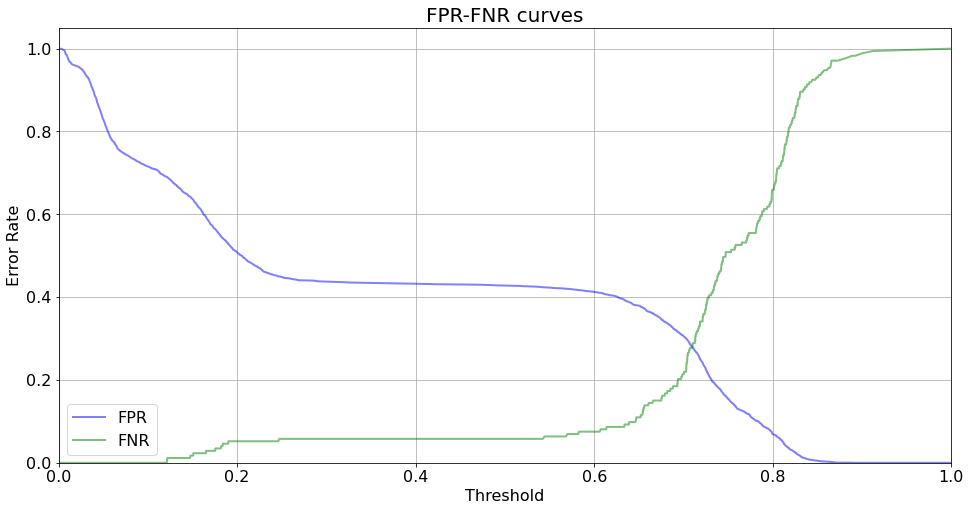

In [42]:
curve = get_roc_curve(cat_model,val_pool)
fpr, tpr, thresholds = curve
thresholds, fpr = get_fpr_curve(curve = curve)
thresholds, fnr = get_fnr_curve(curve = curve)

plt.figure(figsize=(16,8))
style = {'alpha':0.5, 'lw':2}

plt.plot(thresholds, fpr, color='blue', label='FPR', **style)
plt.plot(thresholds, fnr, color='green', label='FNR', **style)

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc='lower left', fontsize=16)

The acceptable false negative and false positive rates will depend on the cost of each of these situations.

False negatives mean there was fraud that was not identified. False positives mean that a claim was flagged as fraud even though it is not fraudulent.

While we want to capture as much fraud as possible, since false claims cost the company money, the time/resources spent investigating flagged claims that turn out not to be fraudulent still costs money.  Therefore, we may be willing to accept a certain level of undetected fraud in order to minimize false positives.  

If available, I would also want to examine the distribution of cost of fraud - what is the likelihood that fraud we missed was of a high value vs. likelihood it didn't cost a lot.

For the purpose of this project I'm going to make an assumption that the insurance company can accept missing 10% of all fraud. This may be high, but we do not have the cost information to make an informed selection.

In [44]:
#Compute thresholds for diff FNR
print('5% FNR Threshold: {}'.format(select_threshold(cat_model,val_pool,FNR=.05)))
print('10% FNR Threshold: {}'.format(select_threshold(cat_model,val_pool,FNR=.1)))
print('15% FNR Threshold: {}'.format(select_threshold(cat_model,val_pool,FNR=.15)))

5% FNR Threshold: 0.19008411254496005
10% FNR Threshold: 0.6460101370635049
15% FNR Threshold: 0.6653744220600006


In [45]:
#Calculate metrics for this catboost model with .5 threshold
test_pool=catboost.Pool(X_test_cat, y_test_cat,cat_features=cat_features)

y_hat_cat=cat_model.predict(test_pool)
curve = get_roc_curve(cat_model,test_pool)
fpr, tpr, thresholds = curve
print('AUC: {}'.format(auc(fpr,tpr)))
#print('log_loss: {}'.format(log_loss(y_test_cat,y_hat_cat)))
print('score: {}'.format(accuracy_score(y_test_cat,y_hat_cat)))
print('recall: {}'.format(recall_score(y_test_cat,y_hat_cat)))
print('precision: {}'.format(precision_score(y_test_cat,y_hat_cat)))
catboost.utils.get_confusion_matrix(cat_model,test_pool)

AUC: 0.81857840467112
score: 0.6062256809338521
recall: 0.948051948051948
precision: 0.12695652173913044


array([[2118., 1506.],
       [  12.,  219.]])

In [50]:
#Calculate metrics for this catboost model with .6 threshold
y_hat_probs=cat_model.predict_proba(test_pool)
y_hat_cat=thresh_pred(y_hat_probs[:,1],.6)
curve = get_roc_curve(cat_model,test_pool)
fpr, tpr, thresholds = curve
print('AUC: {}'.format(auc(fpr,tpr)))
#print('log_loss: {}'.format(log_loss(y_test_cat,y_hat_cat)))
print('score: {}'.format(accuracy_score(y_test_cat,y_hat_cat)))
print('recall: {}'.format(recall_score(y_test_cat,y_hat_cat)))
print('precision: {}'.format(precision_score(y_test_cat,y_hat_cat)))
catboost.utils.get_confusion_matrix(cat_model,test_pool)

AUC: 0.81857840467112
score: 0.6173800259403373
recall: 0.9134199134199135
precision: 0.12665066026410565


array([[2118., 1506.],
       [  12.,  219.]])

# Threshold Tuning #

Because this dataset is highly imbalanced, we will explore if shifting the threshold allows us to maintain a reasonable true positive rate (recall/sensitivity) without decreasing specificity too much (1-false positive rate).

In [324]:
#Find optimal G-Mean for entire training set and plot on ROC curve

new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(
    X_train,y_train,stratify=y_train
)

#model with best params
best_pipe=pipeline.Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('adasyn',ADASYN(random_state=42)),
    ('clf',xgb.XGBClassifier(objective='binary:logistic',
                             colsample_bytree = 0.8,
                             gamma = 0,
                             learning_rate = 0.01,
                             max_depth = 3,
                             reg_lambda = 0,
                             scale_pos_weight = 15,
                             subsample = 0.8,
                             random_state = 123)
    )
])

best_pipe.fit(new_X_train,new_y_train)
y_hat_prob=best_pipe.predict_proba(new_X_test)

In [325]:
y_hat_prob

array([[0.22750175, 0.77249825],
       [0.20143008, 0.7985699 ],
       [0.7973196 , 0.20268042],
       ...,
       [0.20083499, 0.799165  ],
       [0.7994631 , 0.2005369 ],
       [0.79744774, 0.20255226]], dtype=float32)

Best Threshold=0.781175, G-Mean=0.753


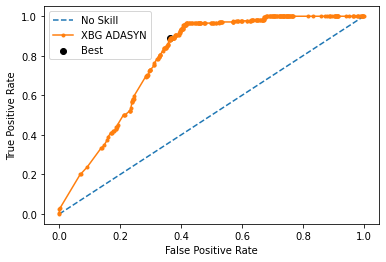

In [326]:
#keep probs for positive outcome only
y_hat=y_hat_prob[:,1]

fpr,tpr,thresholds=roc_curve(new_y_test,y_hat)
gmeans=np.sqrt(tpr*(1-fpr))
ix=np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.plot(fpr, tpr, marker='.', label='XBG ADASYN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()


In [46]:
#write a function to make predictions with adjusted threshold

def thresh_pred(probs,threshold):
    """
    Takes in probabilites predicted by model and threshold value
    Return array of classification predictions based on the threshold
    """
    predictions=np.where(probs>threshold,1,0)
    return predictions

In [348]:
def plot_confusion_matrix_(y_true, y_pred, normalize=None,
                          title='Confusion Matrix', plot_numbers=False, display_names=None,
                          figsize=(15, 11)):

    cm = confusion_matrix(y_true, y_pred)
    
    if not display_names:
        display_names = class_names
    df_cm = pd.DataFrame(cm, index=display_names, columns=display_names)
    fig = plt.figure(figsize=figsize)
    sns.heatmap(df_cm, annot=plot_numbers, cmap='Blues', fmt='g')
    plt.setp(plt.gca().get_xticklabels(), ha="right", rotation=45)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    return fig

In [343]:
new_y_test

10972    0
2730     0
9340     0
5555     0
5192     0
        ..
5528     0
1436     1
13134    1
11738    0
11833    0
Name: FraudFound_P, Length: 2891, dtype: int64

In [351]:
y_hat_class=thresh_pred(y_hat,thresholds[ix])
print(confusion_matrix(new_y_test,y_hat_class))
print(accuracy_score(new_y_test,y_hat_class))
recall_score(new_y_test,y_hat_class)

[[1729  989]
 [  20  153]]
0.650985818056036


0.884393063583815

In [ ]:
sk=StratifiedKFold(n_splits=3)
skf.split(X_train,y_train)

In [ ]:
#Use XGBoost with ADASYN to tune the model. 
#Ensure we tune on the training set

#Split the training set into three stratified folds

skf=StratifiedKFold(n_splits=3)

best_thresholds=[]

for train_index, test_index in skf.split(X_train,y_train):
    
    trainX, testX = X_train[train_index], X_train[test_index]
    trainy, testy = y_train[train_index], y_train[test_index]
    
    best_pipe.fit(trainX,trainy)
    y_hat_prob=best_pipe.predict_proba(testX)
    
    #keep probs for positive outcome only
    y_hat=y_hat_prob[:,1]

    fpr,tpr,thresholds=roc_curve(testy,y_hat)
    gmeans=np.sqrt(tpr*(1-fpr))
    ix=np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    best_thresholds.append(thresholds[ix])
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.plot(fpr, tpr, marker='.', label='XBG ADASYN')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

print('best thresholds: {}'.format(best_thresholds))
print('mean best thresholds: {}'.format(np.mean(best_thresholds)))